In [1]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [2]:
import sys
import os
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

from sklearn.utils import shuffle

''' 레퍼런스
https://spikingjelly.readthedocs.io/zh-cn/0.0.0.0.4/spikingjelly.datasets.html#module-spikingjelly.datasets
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/datasets.py
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/how_to.md
https://github.com/nmi-lab/torchneuromorphic
https://snntorch.readthedocs.io/en/latest/snntorch.spikevision.spikedata.html#shd
'''

import snntorch
from snntorch.spikevision import spikedata

from spikingjelly.datasets.dvs128_gesture import DVS128Gesture
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
from spikingjelly.datasets.n_mnist import NMNIST
# from spikingjelly.datasets.es_imagenet import ESImageNet
from spikingjelly.datasets import split_to_train_test_set
from spikingjelly.datasets.n_caltech101 import NCaltech101
from spikingjelly.datasets import pad_sequence_collate, padded_sequence_mask

import torchneuromorphic

import wandb

from torchviz import make_dot
import graphviz

/tmp/ipykernel_29355/3914466541.py:46: DeprecationWarning: The module snntorch.spikevision is deprecated. For loading neuromorphic datasets, we recommend using the Tonic project: https://github.com/neuromorphs/tonic
  from snntorch.spikevision import spikedata


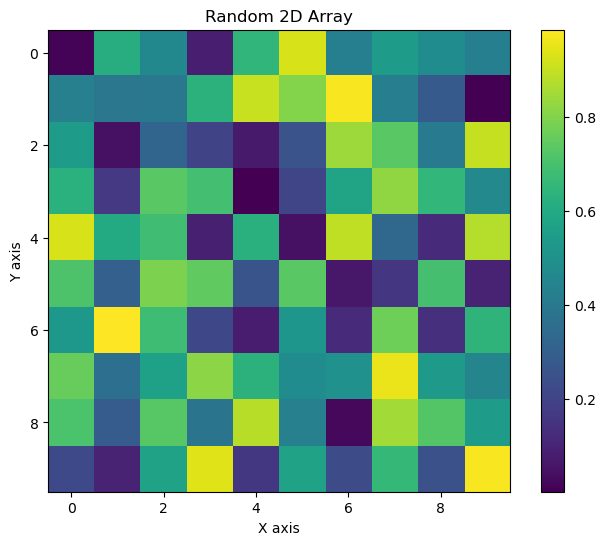

In [3]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [4]:
def my_snn_system(devices = "0,1,2,3",
                    single_step = False, # True # False
                    unique_name = 'main',
                    my_seed = 42,
                    TIME = 10,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    # CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    weight_count_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                    
                    domain_il_epoch = 0, # over 0, then domain il mode on

                    dvs_clipping = 1, 
                    dvs_duration = 10005,

                    OTTT_sWS_on = True, # True # False

                    DFA_on = False, # True # False
                    OTTT_input_trace_on = False, # True # False
                 
                    e_transport_swap = 5, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
                    e_transport_swap_tr = 0, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap

                    drop_rate = 0.5, 

                    exclude_class = True, # True # False # gesture에서 10번째 클래스 제외

                    merge_polarities = True, # True # False # tonic dvs dataset 에서 polarities 합치기
                  ):
    ## hyperparameter check #############################################################
    if OTTT_sWS_on == True:
        assert BPTT_on == False and tdBN_on == False and BN_on == False
        if convTrue_fcFalse == False:
            assert single_step == True
    if single_step == True:
        assert BPTT_on == False and tdBN_on == False 
    if tdBN_on == True:
        assert BPTT_on == True
    if pre_trained == True:
        print('\n\n')
        print("Caution! pre_trained is True\n\n"*3)    
    if DFA_on == True:
        assert single_step == True and BPTT_on == False and any(isinstance(item, list) for item in cfg) == False
    if OTTT_input_trace_on == True:
        assert BPTT_on == False and single_step == True
    ######################################################################################


    ## 함수 내 모든 로컬 변수 저장 ########################################################
    hyperparameters = locals()
    hyperparameters['current epoch'] = 0
    ######################################################################################
    
    args_gpu = None
    ## DDP settting ######################################################################
    if (ddp_on == True):
        parser = argparse.ArgumentParser(description='my_snn CIFAR10 Training')

        # # local_rank는 command line에서 따로 줄 필요는 없지만, 선언은 필요
        parser.add_argument("--local_rank", default=0, type=int)

        args = parser.parse_args() # 이거 적어줘야됨. parser argument선언하고

        args.gpu = args.local_rank
        args_gpu = args.gpu
        torch.cuda.set_device(args.gpu)
        torch.distributed.init_process_group(backend="nccl", init_method="env://")
        args.world_size = torch.distributed.get_world_size()
    #######################################################################################


    ## wandb 세팅 ###################################################################
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    if (ddp_on == True and torch.distributed.get_rank() != 0):
        wandb.finish()
    if (ddp_on == False or torch.distributed.get_rank() == 0):
        wandb.config.update(hyperparameters)
        wandb.run.name = f'lr_{learning_rate}_{unique_name}_{which_data}_tstep{TIME}'
        wandb.define_metric("summary_val_acc", summary="max")
        wandb.run.log_code(".", 
                           include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"),
                           exclude_fn=lambda path: 'logs/' in path or 'net_save/' in path or 'result_save/' in path or 'trying/' in path or 'wandb/' in path or 'private/' in path
                           )
    ###################################################################################



    ## gpu setting ##################################################################################################################
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices
    ###################################################################################################################################


    ## seed setting ##################################################################################################################
    seed_assign(my_seed)
    ###################################################################################################################################
    

    ## data_loader 가져오기 ##################################################################################################################
    # data loader, pixel channel, class num
    train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on,
            TIME,
            dvs_clipping,
            dvs_duration,
            exclude_class,
            merge_polarities)
    synapse_fc_out_features = CLASS_NUM
    ###########################################################################################################################################

    
    ## parameter number calculator (안 중요함) ##################################################################################################################
    params_num = 0
    img_size = IMAGE_SIZE 
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (convTrue_fcFalse == True):
        past_kernel = synapse_conv_in_channels
        for kernel in cfg:
            if (classifier_making == False):
                if (type(kernel) == list):
                    for residual_kernel in kernel:
                        if (residual_kernel >= 10000 and residual_kernel < 20000): # separable
                            residual_kernel -= 10000
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            params_num += (1**2 * past_kernel + bias_param) * residual_kernel
                            past_kernel = residual_kernel  
                        elif (residual_kernel >= 20000 and residual_kernel < 30000): # depthwise
                            residual_kernel -= 20000
                            # 'past_kernel' should be same with 'kernel'
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            past_kernel = residual_kernel  
                        else:
                            params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                            past_kernel = residual_kernel
                elif (kernel == 'P' or kernel == 'M'):
                    img_size = img_size // 2
                elif (kernel == 'D'):
                    img_size = 1
                elif (kernel == 'L'):
                    classifier_making = True
                    past_kernel = past_kernel * (img_size**2)
                else:
                    if (kernel >= 10000 and kernel < 20000): # separable
                        kernel -= 10000
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        params_num += (1**2 * past_kernel + bias_param) * kernel
                        past_kernel = kernel  
                    elif (kernel >= 20000 and kernel < 30000): # depthwise
                        kernel -= 20000
                        # 'past_kernel' should be same with 'kernel'
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        past_kernel = kernel  
                    else:
                        params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                        past_kernel = kernel    
            else: # classifier making
                params_num += (past_kernel + bias_param) * kernel
                past_kernel = kernel
        
        
        if classifier_making == False:
            past_kernel = past_kernel*img_size*img_size

        params_num += (past_kernel + bias_param) * synapse_fc_out_features
    else:
        past_in_channel = synapse_conv_in_channels*img_size*img_size
        for in_channel in cfg:
            if (type(in_channel) == list):
                for residual_in_channel in in_channel:
                    params_num += (past_in_channel + bias_param) * residual_in_channel
                    past_in_channel = residual_in_channel
            elif (in_channel == 'P' or in_channel == 'M'):
                img_size = img_size // 2
                past_in_channel = synapse_conv_in_channels*img_size*img_size
            else:
                params_num += (past_in_channel + bias_param) * in_channel
                past_in_channel = in_channel
        params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ###########################################################################################################################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ### network setting #######################################################################################################################
    if (convTrue_fcFalse == False):
        if (single_step == False):
            net = MY_SNN_FC(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        DFA_on,
                        drop_rate).to(device)
        else:
            net = MY_SNN_FC_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        DFA_on,
                        OTTT_sWS_on,
                        drop_rate).to(device)
    else:
        if (single_step == False):
            net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on,
                        DFA_on,
                        drop_rate).to(device)
        else:
            net = MY_SNN_CONV_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on,
                        DFA_on,
                        drop_rate).to(device)
    if (nda_net == True):
        net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
                    lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
        net.T = TIME
    if ddp_on == False:
        net = torch.nn.DataParallel(net) 
    
    if pre_trained == True:
        net.load_state_dict(torch.load(pre_trained_path))
    
    if ddp_on == True:
        device = args.gpu
        net = net.to(args.gpu)
        net = DDP(net, delay_allreduce=True)

    net = net.to(device)
    if (net_print == True):
        if ddp_on == False or torch.distributed.get_rank() == 0:
            print(net)    
    ####################################################################################################################################
    

    ## wandb logging ###########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        wandb.watch(net, log="all", log_freq = 10) #gradient, parameter logging해줌
    ############################################################

    ## param num and memory estimation except BN with MY own calculation some lines above ##########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
        if (weight_count_print == True):
            for name, param in net.named_parameters():
                if param.requires_grad:
                    print(f'Layer: {name} | Number of parameters: {param.numel()}')
        # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
        # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
        print('='*50)
        print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
        memory = params_num / 8 / 1024 / 1024 # MB
        precision = 32
        memory = memory * precision 
        print(f"Memory: {memory:.2f}MiB at {precision}-bit")
        print('='*50)
    ##############################################################################################################################



    ## criterion ########################################## # loss 구해주는 친구
    criterion = nn.CrossEntropyLoss().to(device)
    if (OTTT_sWS_on == True):
        # criterion = nn.CrossEntropyLoss().to(device)
        criterion = lambda y_t, target_t: ((1 - 0.05) * F.cross_entropy(y_t, target_t) + 0.05 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
        if which_data == 'DVS_GESTURE':
            criterion = lambda y_t, target_t: ((1 - 0.001) * F.cross_entropy(y_t, target_t) + 0.001 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
    ####################################################
    



    ## optimizer, scheduler ########################################################################
    if(optimizer_what == 'SGD'):
        # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    elif(optimizer_what == 'Adam'):
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
        # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
        # optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
        # optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))
    elif(optimizer_what == 'RMSprop'):
        pass


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        # scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=epoch_num)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=100)
    else:
        pass # 'no' scheduler
    ## optimizer, scheduler ########################################################################


    tr_acc = 0
    tr_correct = 0
    tr_total = 0
    tr_acc_best = 0
    tr_epoch_loss_temp = 0
    tr_epoch_loss= 0
    val_acc_best = 0
    val_acc_now = 0
    val_loss = 0
    elapsed_time_val = 0
    no_val_best_growth_count = 0
    no_tr_best_growth_count = 0
    iter_acc_array = np.array([])
    tr_acc_array = np.array([])
    val_acc_now_array = np.array([])
    DFA_current = DFA_on
    DFA_toggle = False
    DFA_flag = 1.0 if DFA_current == True else 0.0
    iter_of_val = False
    #======== EPOCH START ==========================================================================================
    for epoch in range(epoch_num):
        if (e_transport_swap > 0 or e_transport_swap_tr > 0):
            assert not (e_transport_swap > 0 and e_transport_swap_tr > 0)
            if e_transport_swap > 0 and no_val_best_growth_count == e_transport_swap:
                net = BP_DFA_SWAP(net, convTrue_fcFalse, single_step, ddp_on, args_gpu)
                no_val_best_growth_count = 0
                DFA_current = not DFA_current
                DFA_toggle = True
            if e_transport_swap_tr > 0 and no_tr_best_growth_count == e_transport_swap_tr:
                net = BP_DFA_SWAP(net, convTrue_fcFalse, single_step, ddp_on, args_gpu)
                no_tr_best_growth_count = 0
                DFA_current = not DFA_current
                DFA_toggle = True

        if ddp_on == False or torch.distributed.get_rank() == 0:
            # print('EPOCH', epoch)
            pass
        epoch_start_time = time.time()

        # if (domain_il_epoch>0 and which_data == 'PMNIST'):
        #     k = epoch // domain_il_epoch
        #     xtrain=data[k]['train']['x']
        #     ytrain=data[k]['train']['y']
        #     xtest =data[k]['test']['x']
        #     ytest =data[k]['test']['y']

        
        ####### iterator : input_loading & tqdm을 통한 progress_bar 생성###################
        iterator = enumerate(train_loader, 0)
        if ddp_on == False or torch.distributed.get_rank() == 0:  
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        ##################################################################################   
        
        #### validation_interval이 batch size보다 작을 시 validation_interval을 batch size로 맞춰줌#############
        validation_interval2 = validation_interval
        if (validation_interval > len(train_loader)):
            validation_interval2 = len(train_loader)
        ##################################################################################################


        ###### ITERATION START ##########################################################################################################
        for i, data in iterator:
            iter_one_train_time_start = time.time()
            net.train() # train 모드로 바꿔줘야함

            ### data loading & semi-pre-processing ################################################################################
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                # print('x_len',x_len)
                # mask = padded_sequence_mask(x_len)
                # max_time_step = x_len.max()
                # min_time_step = x_len.min()
            ## batch 크기 ######################################
            real_batch = labels.size(0)
            ###########################################################

            ###########################################################################################################################        
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ####################################################################################################################### 
                
            
            # # dvs 데이터 시각화 코드 (확인 필요할 시 써라)
            # ##############################################################################################
            # dvs_visualization(inputs, labels, TIME, BATCH, my_seed)
            # #####################################################################################################

            ## to (device) #######################################
            inputs = inputs.to(device)
            labels = labels.to(device)
            ###########################################################


            ## gradient 초기화 #######################################
            optimizer.zero_grad()
            ###########################################################
            
            ## DVS gesture에서 other label자리 매꾸기 ###############
            if (which_data == 'DVS_GESTURE'):
                labels[labels>2] -= 1
            #######################################################

            if single_step == False:
                # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매##############################
                # inputs: [Time, Batch, Channel, Height, Width]   
                inputs = inputs.permute(1, 0, 2, 3, 4) # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매
                # inputs: [Batch, Time, Channel, Height, Width] 
                #################################################################################################
            else:
                labels = labels.repeat(TIME, 1)
                ## first input도 ottt trace 적용하기 위한 코드 (validation 시에는 필요X) ##########################
                if OTTT_input_trace_on == True:
                    spike = inputs
                    trace = torch.full_like(spike, fill_value = 0.0, dtype = torch.float, requires_grad=False)
                    inputs = []
                    for t in range(TIME):
                        trace[t] = trace[t-1]*synapse_conv_trace_const2 + spike[t]*synapse_conv_trace_const1
                        inputs += [[spike[t], trace[t]]]
                ##################################################################################################
                        
            if merge_polarities == True:
                inputs = inputs[:,:,0,:,:]

            if single_step == False:
                ### input --> net --> output #####################################################
                outputs = net(inputs)
                ##################################################################################
                ## loss, backward ##########################################
                loss = criterion(outputs, labels)
                loss.backward()
                ############################################################
                ## weight 업데이트!! ##################################
                optimizer.step()
                ################################################################
            else:
                outputs_all = []
                loss = 0.0
                for t in range(TIME):
                    outputs_one_time = net(inputs[t])
                    one_time_loss = criterion(outputs_one_time, labels[t].contiguous())
                    one_time_loss.backward() # one_time backward
                    loss += one_time_loss.data
                    outputs_all.append(outputs_one_time.detach())
                optimizer.step() # full step time update
                outputs_all = torch.stack(outputs_all, dim=1)
                outputs = outputs_all.mean(1) # ottt꺼 쓸때
                labels = labels[0]
                loss /= TIME
            tr_epoch_loss_temp += loss.data/len(train_loader)

            ## net 그림 출력해보기 #################################################################
            # print('시각화')
            # make_dot(outputs, params=dict(list(net.named_parameters()))).render("net_torchviz", format="png")
            # return 0
            ##################################################################################

            #### batch 어긋남 방지 ###############################################
            assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
            #######################################################################
            

            ####### training accruacy save for print ###############################
            _, predicted = torch.max(outputs.data, 1)
            total = real_batch
            correct = (predicted == labels).sum().item()
            iter_acc = correct / total
            tr_total += total
            tr_correct += correct
            if i % verbose_interval == verbose_interval-1:
                if ddp_on == False or torch.distributed.get_rank() == 0:
                    print(f'{epoch}-{i} training acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
            iter_acc_string = f'epoch-{epoch:<3} iter_acc:{100 * iter_acc:7.2f}%, lr={[f"{lr:9.7f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            iter_acc_string2 = f'epoch-{epoch:<3} lr={[f"{lr:9.7f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            ################################################################
            




            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                if ddp_on == False or torch.distributed.get_rank() == 0:
                    print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")

            ##### validation ##################################################################################################################################
            if i % validation_interval2 == validation_interval2-1:
                iter_one_val_time_start = time.time()
                tr_acc = tr_correct/tr_total
                tr_correct = 0
                tr_total = 0
                val_loss = 0
                correct = 0
                total = 0
                with torch.no_grad():
                    net.eval() # eval 모드로 바꿔줘야함 
                    for data in test_loader:
                        ## data loading & semi-pre-processing ##########################################################
                        if len(data) == 2:
                            inputs, labels = data
                            # 처리 로직 작성
                        elif len(data) == 3:
                            inputs, labels, x_len = data
                            # print('x_len',x_len)
                            # mask = padded_sequence_mask(x_len)
                            # max_time_step = x_len.max()
                            # min_time_step = x_len.min()
                            # B, T, *spatial_dims = inputs.shape

                        if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                            inputs = inputs.permute(1, 0, 2, 3, 4)
                        elif rate_coding == True :
                            inputs = spikegen.rate(inputs, num_steps=TIME)
                        else :
                            inputs = inputs.repeat(TIME, 1, 1, 1, 1)
                        # inputs: [Time, Batch, Channel, Height, Width]  
                        ###################################################################################################

                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        real_batch = labels.size(0)
                        
                        ## DVS gesture에서 other label자리 매꾸기 ###############
                        if (which_data == 'DVS_GESTURE'):
                            labels[labels>2] -= 1
                        #######################################################
                        
                        if merge_polarities == True:
                            inputs = inputs[:,:,0,:,:]

                        ## network 연산 시작 ############################################################################################################
                        if single_step == False:
                            outputs = net(inputs.permute(1, 0, 2, 3, 4)) #inputs: [Batch, Time, Channel, Height, Width]  
                            val_loss += criterion(outputs, labels)
                        else:
                            outputs_all = []
                            for t in range(TIME):
                                outputs = net(inputs[t])
                                val_loss_temp = criterion(outputs, labels)
                                outputs_all.append(outputs.detach())
                                val_loss += (val_loss_temp.data/TIME)/len(test_loader)
                            outputs_all = torch.stack(outputs_all, dim=1)
                            outputs = outputs_all.mean(1)
                        #################################################################################################################################

                        _, predicted = torch.max(outputs.data, 1)
                        total += real_batch
                        assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
                        correct += (predicted == labels).sum().item()

                    val_acc_now = correct / total
                    # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc_best < val_acc_now:
                    val_acc_best = val_acc_now
                    if ddp_on == False or torch.distributed.get_rank() == 0:
                        # wandb 키면 state_dict아닌거는 저장 안됨
                        torch.save(net.state_dict(), f"net_save/save_now_net_weights_{unique_name}.pth")
                        # torch.save(net, f"net_save/save_now_net_{unique_name}.pth")
                        # torch.save(net.module.state_dict(), f"net_save/save_now_net_weights2_{unique_name}.pth")
                        # torch.save(net.module, f"net_save/save_now_net2_{unique_name}.pth")
                    no_val_best_growth_count = 0
                else:
                    no_val_best_growth_count = no_val_best_growth_count + 1

                if tr_acc_best < tr_acc:
                    tr_acc_best = tr_acc
                    no_tr_best_growth_count = 0
                else:
                    no_tr_best_growth_count = no_tr_best_growth_count + 1

                tr_epoch_loss = tr_epoch_loss_temp
                tr_epoch_loss_temp = 0

                if DFA_toggle == True:
                    DFA_flag = 1.0 - DFA_flag
                    DFA_toggle = False

                iter_of_val = True
            ####################################################################################################################################################
            
            ## progress bar update ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                if iter_of_val == False:
                    iterator.set_description(f"{iter_acc_string}, iter/last_val_loss:{loss:10.6f}/{val_loss:10.6f}, last tr:{100 * tr_acc:7.2f}%, last val:{100 * val_acc_now:7.2f}%, val_best:{100 * val_acc_best:7.2f}%")  
                else:
                    iterator.set_description(f"{iter_acc_string2}, tr/val_loss:{tr_epoch_loss:10.6f}/{val_loss:10.6f}, tr:{100 * tr_acc:7.2f}%, val:{100 * val_acc_now:7.2f}%, val_best:{100 * val_acc_best:7.2f}%")  
                    iter_of_val = False
            ####################################################################################################################################
            
            ## wandb logging ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                wandb.log({"iter_acc": iter_acc})
                wandb.log({"tr_acc": tr_acc})
                wandb.log({"val_acc_now": val_acc_now})
                wandb.log({"val_acc_best": val_acc_best})
                wandb.log({"summary_val_acc": val_acc_now})
                wandb.log({"epoch": epoch})
                wandb.log({"DFA_flag": DFA_flag}) # DFA mode 바뀌자 마자 바뀌는 게 아니고 validation 한번 했을 때 바뀜.
                wandb.log({"val_loss": val_loss}) 
                wandb.log({"tr_epoch_loss": tr_epoch_loss}) 
            ####################################################################################################################################
            
            
            ## accuray 로컬에 저장 하기 위한 코드 #####################################################################################
            iter_acc_array = np.append(iter_acc_array, iter_acc)
            tr_acc_array = np.append(tr_acc_array, tr_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            ####################################################################################################################
            
            iter_acc_file_name_time = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
            tr_acc_file_name_time = f'result_save/{base_name}_tr_acc_array_{unique_name}.npy'
            val_acc_file_name_time = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
            hyperparameters_file_name_time = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

            hyperparameters['current epoch'] = epoch

            ### accuracy 세이브: 덮어쓰기 하기 싫으면 주석 풀어서 사용 (시간마다 새로 쓰기) 비추천 ########################
            # if ddp_on == False or torch.distributed.get_rank() == 0:
            #     np.save(iter_acc_file_name_time, iter_acc_array)
            #     np.save(tr_acc_file_name_time, iter_acc_array)
            #     np.save(val_acc_file_name_time, val_acc_now_array)
            #     with open(hyperparameters_file_name_time, 'w') as f:
            #         json.dump(hyperparameters, f, indent=4)
            #########################################################################################################

            ## accuracy 세이브 ###########################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                np.save(f'result_save/iter_acc_array_{unique_name}.npy', iter_acc_array)
                np.save(f'result_save/tr_acc_array_{unique_name}.npy', tr_acc_array)
                np.save(f'result_save/val_acc_now_array_{unique_name}.npy', val_acc_now_array)
                with open(f'result_save/hyperparameters_{unique_name}.json', 'w') as f:
                    json.dump(hyperparameters, f, indent=4)
            ##########################################################################################################
        ###### ITERATION END ##########################################################################################################
                

        ## scheduler update #############################################################################
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        #################################################################################################
        
        # 실행 시간 계산
        epoch_time_end = time.time()
        # print(f"epoch_time: {epoch_time_end - epoch_start_time} seconds\n") 
    #======== EPOCH END ==========================================================================================


In [5]:
# ### my_snn control board (Gesture) ########################
# decay = 0.25 # 0.875 0.25 0.125 0.75 0.5
# # nda 0.25 # ottt 0.5
# const2 = False # trace 할거면 True, 안할거면 False

# unique_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save
# run_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save

# if const2 == True:
#     const2 = decay
# else:
#     const2 = 0.0

# wandb.init(project= f'my_snn {unique_name}',save_code=True)

# my_snn_system(  devices = "3",
#                 single_step = True, # True # False
#                 unique_name = run_name,
#                 my_seed = 42,
#                 TIME = 10 , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
#                 BATCH = 16, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
#                 IMAGE_SIZE = 128, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28 #NMNIST 34 # GESTURE 128
#                 # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
#                 #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

#                 # DVS_CIFAR10 할거면 time 10으로 해라
#                 which_data = 'DVS_GESTURE_TONIC',
# # 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# # 'DVS_GESTURE', 'DVS_GESTURE_TONIC','DVS_CIFAR10_2','NMNIST','NMNIST_TONIC','N_CALTECH101','n_tidigits','heidelberg'
#                 # CLASS_NUM = 10,
#                 data_path = '/data2', # YOU NEED TO CHANGE THIS
#                 rate_coding = False, # True # False
#                 lif_layer_v_init = 0.0,
#                 lif_layer_v_decay = decay,
#                 lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
#                 lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
#                 lif_layer_sg_width = 0.5, # # surrogate sigmoid 쓸 때는 의미없음

#                 # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
#                 synapse_conv_kernel_size = 3,
#                 synapse_conv_stride = 1,
#                 synapse_conv_padding = 1,
#                 synapse_conv_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
#                 synapse_conv_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

#                 # synapse_fc_out_features = CLASS_NUM,
#                 synapse_fc_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
#                 synapse_fc_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

#                 pre_trained = False, # True # False
#                 convTrue_fcFalse = False, # True # False

#                 # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
#                 # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
#                 # cfg = [64, 64],
#                 # cfg = [64, 124, 64, 124],
#                 # cfg = ['M','M',512], 
#                 # cfg = [512], 
#                 # cfg = ['M', 'M', 64, 128, 'P', 128, 'P'], 
#                 # cfg = ['M','M',512],
#                 cfg = ['M','M',200,200],
#                 # cfg = ['M','M',1024,512,256,128,64],
#                 # cfg = [200,200],
#                 # cfg = [12], #fc
#                 # cfg = [12, 'M', 48, 'M', 12], 
#                 # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
#                 # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
#                 # cfg = [20001,10001], # depthwise, separable
#                 # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
#                 # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
#                 # cfg = [],        
                
#                 net_print = True, # True # False # True로 하길 추천
#                 weight_count_print = False, # True # False
                
#                 pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
#                 learning_rate = 0.0002, # 0.001, # default 0.001  # ottt 0.1 # nda 0.001 
#                 epoch_num = 1000,
#                 verbose_interval = 999999999, #이거 걍 건들지마셈 #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
#                 validation_interval =  999999999,#999999999, #이거 걍 건들지마셈 #숫자 크게 하면 에포크 마지막 iter 때 val 함

#                 tdBN_on = False,  # True # False
#                 BN_on = False,  # True # False
                
#                 surrogate = 'hard_sigmoid', # 'rectangle' 'sigmoid' 'rough_rectangle' 'hard_sigmoid'
                
#                 gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

#                 BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
#                 optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
#                 scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
#                 ddp_on = False,   # True # False 
#                 # 지원 DATASET: cifar10, mnist

#                 nda_net = False,   # True # False

#                 domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
#                 dvs_clipping = 2, # 숫자만큼 크면 spike 아니면 걍 0
#                 # gesture, cifar-dvs2, nmnist, ncaltech101

#                 dvs_duration = 100_000, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
#                 # 있는 데이터들 #gesture 100_000 25_000 10_000 1_000 1_000_000 #nmnist 10000 #nmnist_tonic 10_000 25_000
#                 # 한 숫자가 1us인듯 (spikingjelly코드에서)
#                 # 한 장에 50 timestep만 생산함. 싫으면 my_snn/trying/spikingjelly_dvsgesture의__init__.py 를 참고해봐

#                 OTTT_sWS_on = False, # True # False # BPTT끄고, CONV에만 적용됨.

#                 DFA_on = False, # True # False # residual은 dfa지원안함.
#                 OTTT_input_trace_on = False, # True # False # 맨 처음 input에 trace 적용
                 
#                 e_transport_swap = 0, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
#                 e_transport_swap_tr = 0, # 1 이상이면 해당 숫자 에포크만큼 tr_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
                
#                 drop_rate = 0.0, # drop_rate만큼 0으로 만듦. ex) 0.2면 activation의 20%를 0으로 만듦.

#                 exclude_class = True, # True # False # gesture에서 10번째 클래스 제외

#                 merge_polarities = False, # True # False # tonic dvs dataset 에서 polarities 합치기
#                 ) 
# # sigmoid와 BN이 있어야 잘된다.
# # average pooling  
# # 이 낫다. 
 
# # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
# ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


# # DDP 실행 코드
# '''
# ddp_on 키고, gpu 개수 만큼 batch size 나눠줘
# CUDA_VISIBLE_DEVICES=0,1,2,3,4,5 python -m torch.distributed.launch --nproc_per_node=6 main_ddp.py
# CUDA_VISIBLE_DEVICES=1,2,3 python -m torch.distributed.launch --nproc_per_node=3 main_ddp.py
# CUDA_VISIBLE_DEVICES=0,1,2,3 python -m torch.distributed.launch --nproc_per_node=4 main_ddp.py
# '''


In [6]:
# ### my_snn control board (NMNIST) ########################
# decay = 0.25 # 0.875 0.25 0.125 0.75 0.5
# # nda 0.25 # ottt 0.5
# const2 = False # trace 할거면 True, 안할거면 False

# unique_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save
# run_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save

# if const2 == True:
#     const2 = decay
# else:
#     const2 = 0.0

# wandb.init(project= f'my_snn {unique_name}',save_code=True)

# my_snn_system(  devices = "4",
#                 single_step = True, # True # False
#                 unique_name = run_name,
#                 my_seed = 42,
#                 TIME = 10 , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
#                 BATCH = 128, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
#                 IMAGE_SIZE = 34, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28 #NMNIST 34 # GESTURE 128
#                 # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
#                 #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

#                 # DVS_CIFAR10 할거면 time 10으로 해라
#                 which_data = 'NMNIST_TONIC',
# # 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# # 'DVS_GESTURE', 'DVS_GESTURE_TONIC','DVS_CIFAR10_2','NMNIST','NMNIST_TONIC','N_CALTECH101','n_tidigits','heidelberg'
#                 # CLASS_NUM = 10,
#                 data_path = '/data2', # YOU NEED TO CHANGE THIS
#                 rate_coding = False, # True # False
#                 lif_layer_v_init = 0.0,
#                 lif_layer_v_decay = decay,
#                 lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
#                 lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
#                 lif_layer_sg_width = 0.5, # # surrogate sigmoid 쓸 때는 의미없음

#                 # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
#                 synapse_conv_kernel_size = 3,
#                 synapse_conv_stride = 1,
#                 synapse_conv_padding = 1,
#                 synapse_conv_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
#                 synapse_conv_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

#                 # synapse_fc_out_features = CLASS_NUM,
#                 synapse_fc_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
#                 synapse_fc_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

#                 pre_trained = False, # True # False
#                 convTrue_fcFalse = False, # True # False

#                 # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
#                 # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
#                 # cfg = [64, 64],
#                 # cfg = [64, 124, 64, 124],
#                 # cfg = ['M','M',512], 
#                 # cfg = [512], 
#                 # cfg = ['M', 'M', 64, 128, 'P', 128, 'P'], 
#                 # cfg = ['M','M',512],
#                 # cfg = ['M','M',200,200],
#                 # cfg = ['M','M',1024,512,256,128,64],
#                 cfg = [200,200],
#                 # cfg = [12], #fc
#                 # cfg = [12, 'M', 48, 'M', 12], 
#                 # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
#                 # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
#                 # cfg = [20001,10001], # depthwise, separable
#                 # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
#                 # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
#                 # cfg = [],        
                
#                 net_print = True, # True # False # True로 하길 추천
#                 weight_count_print = False, # True # False
                
#                 pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
#                 learning_rate = 0.009, # 0.001, # default 0.001  # ottt 0.1 # nda 0.001 
#                 epoch_num = 300,
#                 verbose_interval = 999999999, #이거 걍 건들지마셈 #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
#                 validation_interval =  999999999,#999999999, #이거 걍 건들지마셈 #숫자 크게 하면 에포크 마지막 iter 때 val 함

#                 tdBN_on = False,  # True # False
#                 BN_on = False,  # True # False
                
#                 surrogate = 'hard_sigmoid', # 'rectangle' 'sigmoid' 'rough_rectangle' 'hard_sigmoid'
                
#                 gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

#                 BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
#                 optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
#                 scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
#                 ddp_on = False,   # True # False 
#                 # 지원 DATASET: cifar10, mnist

#                 nda_net = False,   # True # False

#                 domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
#                 dvs_clipping = 1, # 숫자만큼 크면 spike 아니면 걍 0
#                 # gesture, cifar-dvs2, nmnist, ncaltech101

#                 dvs_duration = 10_000, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
#                 # 있는 데이터들 #gesture 100_000 25_000 10_000 1_000 1_000_000 #nmnist 10000 #nmnist_tonic 10_000 25_000
#                 # 한 숫자가 1us인듯 (spikingjelly코드에서)
#                 # 한 장에 50 timestep만 생산함. 싫으면 my_snn/trying/spikingjelly_dvsgesture의__init__.py 를 참고해봐

#                 OTTT_sWS_on = False, # True # False # BPTT끄고, CONV에만 적용됨.

#                 DFA_on = True, # True # False # residual은 dfa지원안함.
#                 OTTT_input_trace_on = False, # True # False # 맨 처음 input에 trace 적용
                 
#                 e_transport_swap = 5, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
#                 e_transport_swap_tr = 0, # 1 이상이면 해당 숫자 에포크만큼 tr_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
                
#                 drop_rate = 0.0, # drop_rate만큼 0으로 만듦. ex) 0.2면 activation의 20%를 0으로 만듦.

#                 exclude_class = True, # True # False # gesture에서 10번째 클래스 제외

#                 merge_polarities = False, # True # False # tonic dvs dataset 에서 polarities 합치기
#                 ) 
# # sigmoid와 BN이 있어야 잘된다.
# # average pooling  
# # 이 낫다. 
 
# # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
# ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


# # DDP 실행 코드
# '''
# ddp_on 키고, gpu 개수 만큼 batch size 나눠줘
# CUDA_VISIBLE_DEVICES=0,1,2,3,4,5 python -m torch.distributed.launch --nproc_per_node=6 main_ddp.py
# CUDA_VISIBLE_DEVICES=1,2,3 python -m torch.distributed.launch --nproc_per_node=3 main_ddp.py
# CUDA_VISIBLE_DEVICES=0,1,2,3 python -m torch.distributed.launch --nproc_per_node=4 main_ddp.py
# '''


In [7]:
# sweep 하는 코드, 위 셀 주석처리 해야 됨.

# 이런 워닝 뜨는 거는 걍 너가 main 안에서  wandb.config.update(hyperparameters)할 때 물려서임. 어차피 근데 sweep에서 지정한 걸로 덮어짐 
# wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).

unique_name_hyper = 'main'
run_name = 'main'
sweep_configuration = {
    'method': 'bayes',
    'name': f'my_snn_sweep{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}',
    'metric': {'goal': 'maximize', 'name': 'val_acc_best'},
    'parameters': 
    {
        "learning_rate": {"min": 0.0001, "max": 0.01},
        "BATCH": {"values": [16]},
        "decay": {"values": [0.25]},
        "IMAGE_SIZE": {"values": [128]},
        "TIME": {"values": [10]},
        "epoch_num": {"values": [150]},
        "dvs_duration": {"values": [100_000]},
        "dvs_clipping": {"values": [2]},
        "which_data": {"values": ['DVS_GESTURE_TONIC']},
        "OTTT_sWS_on": {"values": [False]},
        "const2": {"values": [False]},
        "surrogate": {"values": ['hard_sigmoid']},
        "DFA_on": {"values": [True]},
        "OTTT_input_trace_on": {"values": [False]},
        "cfg": {"values": [['M','M',200,200]]},
        "e_transport_swap": {"values": [5]},
        "e_transport_swap_tr": {"values": [0]},
        "drop_rate": {"values": [0.0]}, # "drop_rate": {"values": [0.25,0.5,0.75]}, #"drop_rate": {"min": 0.25, "max": 0.75},
        "exclude_class": {"values": [True]},
        "merge_polarities": {"values": [False]},
     }
}

def hyper_iter():
    ### my_snn control board ########################
    unique_name = unique_name_hyper ## 이거 설정하면 새로운 경로에 모두 save
    
    wandb.init(save_code = True)
    learning_rate  =  wandb.config.learning_rate
    BATCH  =  wandb.config.BATCH
    decay  =  wandb.config.decay
    IMAGE_SIZE  =  wandb.config.IMAGE_SIZE
    TIME  =  wandb.config.TIME
    epoch_num  =  wandb.config.epoch_num 
    dvs_duration  =  wandb.config.dvs_duration
    dvs_clipping  =  wandb.config.dvs_clipping
    which_data  =  wandb.config.which_data
    OTTT_sWS_on  =  wandb.config.OTTT_sWS_on
    const2  =  wandb.config.const2
    surrogate  =  wandb.config.surrogate
    DFA_on  =  wandb.config.DFA_on
    OTTT_input_trace_on  =  wandb.config.OTTT_input_trace_on
    cfg  =  wandb.config.cfg
    e_transport_swap  =  wandb.config.e_transport_swap
    e_transport_swap_tr  =  wandb.config.e_transport_swap_tr
    drop_rate  =  wandb.config.drop_rate
    exclude_class  =  wandb.config.exclude_class
    merge_polarities  =  wandb.config.merge_polarities
    if const2 == True:
        const2 = decay
    else:
        const2 = 0.0

    my_snn_system(  devices = "3",
                single_step = True, # True # False
                unique_name = run_name,
                my_seed = 42,
                TIME = TIME , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
                BATCH = BATCH, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
                IMAGE_SIZE = IMAGE_SIZE, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28 #NMNIST 34 # GESTURE 128
                # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
                #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

                # DVS_CIFAR10 할거면 time 10으로 해라
                which_data = which_data,
# 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# 'DVS_GESTURE', 'DVS_GESTURE_TONIC','DVS_CIFAR10_2','NMNIST','NMNIST_TONIC','N_CALTECH101','n_tidigits','heidelberg'
                # CLASS_NUM = 10,
                data_path = '/data2', # YOU NEED TO CHANGE THIS
                rate_coding = False, # True # False
                lif_layer_v_init = 0.0,
                lif_layer_v_decay = decay,
                lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
                lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
                lif_layer_sg_width = 0.5, # # surrogate sigmoid 쓸 때는 의미없음

                # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                synapse_conv_kernel_size = 3,
                synapse_conv_stride = 1,
                synapse_conv_padding = 1,
                synapse_conv_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
                synapse_conv_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

                # synapse_fc_out_features = CLASS_NUM,
                synapse_fc_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
                synapse_fc_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

                pre_trained = False, # True # False
                convTrue_fcFalse = False, # True # False

                # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
                # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
                # cfg = [64, 64],
                # cfg = [64, 124, 64, 124],
                # cfg = ['M','M',512], 
                # cfg = [512], 
                # cfg = ['M', 'M', 64, 128, 'P', 128, 'P'], 
                # cfg = ['M','M',200,200],
                # cfg = [200,200],
                cfg = cfg,
                # cfg = [12], #fc
                # cfg = [12, 'M', 48, 'M', 12], 
                # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
                # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
                # cfg = [20001,10001], # depthwise, separable
                # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
                # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
                # cfg = [], 
                
                net_print = True, # True # False # True로 하길 추천
                weight_count_print = False, # True # False
                
                pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
                learning_rate = learning_rate, # default 0.001  # ottt 0.1 # nda 0.001 
                epoch_num = epoch_num,
                verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
                validation_interval =  999999999,#999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

                tdBN_on = False,  # True # False
                BN_on = False,  # True # False
                
                surrogate = surrogate, # 'rectangle' 'sigmoid' 'rough_rectangle'
                
                gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

                BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
                optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
                ddp_on = False,   # True # False 
                # 지원 DATASET: cifar10, mnist

                nda_net = False,   # True # False

                domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
                dvs_clipping = dvs_clipping, # 숫자만큼 크면 spike 아니면 걍 0
                # gesture, cifar-dvs2, nmnist, ncaltech101

                dvs_duration = dvs_duration, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
                # 있는 데이터들 #gesture 100_000 25_000 10_000 1_000 1_000_000 #nmnist 10000 #nmnist_tonic 10_000 25_000
                # 한 숫자가 1us인듯 (spikingjelly코드에서)
                # 한 장에 50 timestep만 생산함. 싫으면 my_snn/trying/spikingjelly_dvsgesture의__init__.py 를 참고해봐

                OTTT_sWS_on = OTTT_sWS_on, # True # False # BPTT끄고, CONV에만 적용됨.

                DFA_on = DFA_on, # True # False # residual은 dfa지원안함.
                OTTT_input_trace_on = OTTT_input_trace_on, # True # False # 맨 처음 input에 trace 적용
                 
                e_transport_swap = e_transport_swap, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
                e_transport_swap_tr = e_transport_swap_tr, # 1 이상이면 해당 숫자 에포크만큼 tr_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
                    
                drop_rate = drop_rate,

                exclude_class = exclude_class, # True # False # gesture에서 10번째 클래스 제외

                merge_polarities = merge_polarities, # True # False # tonic dvs dataset 에서 polarities 합치기
                    ) 
    # sigmoid와 BN이 있어야 잘된다.
    # average pooling
    # 이 낫다. 
    
    # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
    ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


sweep_id = 'nr9swqfs'
wandb.agent(sweep_id, function=hyper_iter, count=10000, project=f'my_snn {unique_name_hyper}')


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Agent Starting Run: 7daevsj6 with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 5
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 150
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.0017109093276739837
wandb: 	merge_polarities: False
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relog

wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'e_transport_s

dataset_hash = 2bbd58b4e0d3c1e9ad501fad8a43feed
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0017109'], tr/val_loss:  2.099805/  1.588182, tr:  23.90%, val:  49.58%, val_best:  49.58%: 100%|██████████| 62/62 [00:06<00:00,  9.63it/s]                                    
epoch-1   lr=['0.0017107'], tr/val_loss:  1.289629/  1.392737, tr:  56.59%, val:  56.67%, val_best:  56.67%: 100%|██████████| 62/62 [00:05<00:00, 10.81it/s]                                    
epoch-2   lr=['0.0017102'], tr/val_loss:  1.106825/  1.206746, tr:  62.21%, val:  61.67%, val_best:  61.67%: 100%|██████████| 62/62 [00:05<00:00, 11.37it/s]                                    
epoch-3   lr=['0.0017092'], tr/val_loss:  0.977436/  1.153702, tr:  67.31%, val:  64.17%, val_best:  64.17%: 100%|██████████| 62/62 [00:05<00:00, 10.50it/s]                                    
epoch-4   lr=['0.0017079'], tr/val_loss:  0.978866/  1.131616, tr:  66.29%, val:  67.50%, val_best:  67.50%: 100%|██████████| 62/62 [00:05<00:00, 10.78it/s]                                    
epoch-5   lr=['0.0017062'], tr/val_


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-18  lr=['0.0016508'], tr/val_loss:  0.452228/  1.126222, tr:  93.26%, val:  78.33%, val_best:  78.33%: 100%|██████████| 62/62 [00:04<00:00, 14.18it/s]                                    
epoch-19  lr=['0.0016441'], tr/val_loss:  0.409163/  1.112534, tr:  93.77%, val:  78.33%, val_best:  78.33%: 100%|██████████| 62/62 [00:04<00:00, 13.96it/s]                                    
epoch-20  lr=['0.0016370'], tr/val_loss:  0.375289/  1.130265, tr:  96.73%, val:  76.67%, val_best:  78.33%: 100%|██████████| 62/62 [00:04<00:00, 14.07it/s]                                    
epoch-21  lr=['0.0016295'], tr/val_loss:  0.383469/  1.159778, tr:  95.10%, val:  79.17%, val_best:  79.17%: 100%|██████████| 62/62 [00:04<00:00, 13.99it/s]                                    
epoch-22  lr=['0.0016217'], tr/val_loss:  0.353747/  1.193933, tr:  95.40%, val:  77.50%, val_best:  79.17%: 100%|██████████| 62/62 [00:04<00:00, 13.61it/s]                                    
epoch-23  lr=['0.0016136'], tr/val


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-29  lr=['0.0015579'], tr/val_loss:  0.253658/  1.270623, tr:  99.28%, val:  80.42%, val_best:  80.42%: 100%|██████████| 62/62 [00:05<00:00, 12.00it/s]                                    
epoch-30  lr=['0.0015475'], tr/val_loss:  0.244049/  1.301606, tr:  99.28%, val:  78.75%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 12.64it/s]                                    
epoch-31  lr=['0.0015368'], tr/val_loss:  0.246469/  1.315961, tr:  99.08%, val:  80.00%, val_best:  80.42%: 100%|██████████| 62/62 [00:05<00:00, 12.05it/s]                                    
epoch-32  lr=['0.0015259'], tr/val_loss:  0.251221/  1.320122, tr:  98.37%, val:  77.92%, val_best:  80.42%: 100%|██████████| 62/62 [00:05<00:00, 12.03it/s]                                    
epoch-33  lr=['0.0015146'], tr/val_loss:  0.234657/  1.322242, tr:  99.28%, val:  77.08%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 12.73it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-34  lr=['0.0015030'], tr/val_loss:  0.270309/  1.339482, tr:  97.85%, val:  77.08%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.77it/s]                                    
epoch-35  lr=['0.0014912'], tr/val_loss:  0.238193/  1.372095, tr:  99.69%, val:  80.00%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.90it/s]                                    
epoch-36  lr=['0.0014791'], tr/val_loss:  0.224292/  1.397093, tr:  99.49%, val:  78.33%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.20it/s]                                    
epoch-37  lr=['0.0014667'], tr/val_loss:  0.224400/  1.436696, tr:  99.18%, val:  77.92%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.66it/s]                                    
epoch-38  lr=['0.0014540'], tr/val_loss:  0.207141/  1.426000, tr:  99.69%, val:  76.67%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.75it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-39  lr=['0.0014411'], tr/val_loss:  0.195928/  1.386290, tr:  99.59%, val:  81.25%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.31it/s]                                    
epoch-40  lr=['0.0014279'], tr/val_loss:  0.186605/  1.395432, tr:  99.80%, val:  81.25%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.02it/s]                                    
epoch-41  lr=['0.0014144'], tr/val_loss:  0.191213/  1.392014, tr:  99.90%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.90it/s]                                    
epoch-42  lr=['0.0014007'], tr/val_loss:  0.188796/  1.416280, tr:  99.69%, val:  77.92%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.05it/s]                                    
epoch-43  lr=['0.0013868'], tr/val_loss:  0.181414/  1.391603, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.07it/s]                                    
epoch-44  lr=['0.0013727'], tr/val


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-45  lr=['0.0013583'], tr/val_loss:  0.183371/  1.493730, tr:  99.90%, val:  77.92%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.05it/s]                                    
epoch-46  lr=['0.0013437'], tr/val_loss:  0.185759/  1.471061, tr:  99.69%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.27it/s]                                    
epoch-47  lr=['0.0013289'], tr/val_loss:  0.176580/  1.466483, tr: 100.00%, val:  80.42%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.03it/s]                                    
epoch-48  lr=['0.0013138'], tr/val_loss:  0.177182/  1.485213, tr:  99.49%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.22it/s]                                    
epoch-49  lr=['0.0012986'], tr/val_loss:  0.157246/  1.497074, tr:  99.69%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.36it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-50  lr=['0.0012832'], tr/val_loss:  0.137901/  1.534842, tr:  99.80%, val:  80.42%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 11.68it/s]                                    
epoch-51  lr=['0.0012676'], tr/val_loss:  0.130057/  1.523994, tr: 100.00%, val:  80.42%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.80it/s]                                    
epoch-52  lr=['0.0012518'], tr/val_loss:  0.127218/  1.535065, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.34it/s]                                    
epoch-53  lr=['0.0012358'], tr/val_loss:  0.131305/  1.536638, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:05<00:00, 12.11it/s]                                    
epoch-54  lr=['0.0012197'], tr/val_loss:  0.126747/  1.548258, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:05<00:00, 11.72it/s]                                    
epoch-55  lr=['0.0012034'], tr/val


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-59  lr=['0.0011368'], tr/val_loss:  0.130712/  1.625799, tr:  99.80%, val:  80.00%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.11it/s]                                    
epoch-60  lr=['0.0011198'], tr/val_loss:  0.130069/  1.631490, tr: 100.00%, val:  80.83%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.02it/s]                                    
epoch-61  lr=['0.0011027'], tr/val_loss:  0.120388/  1.638843, tr:  99.90%, val:  80.00%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.59it/s]                                    
epoch-62  lr=['0.0010855'], tr/val_loss:  0.118934/  1.643178, tr: 100.00%, val:  80.42%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.34it/s]                                    
epoch-63  lr=['0.0010682'], tr/val_loss:  0.111003/  1.657774, tr: 100.00%, val:  80.00%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.19it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-64  lr=['0.0010508'], tr/val_loss:  0.102228/  1.687158, tr: 100.00%, val:  79.58%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 12.72it/s]                                    
epoch-65  lr=['0.0010333'], tr/val_loss:  0.100910/  1.688403, tr: 100.00%, val:  79.17%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 12.88it/s]                                    
epoch-66  lr=['0.0010158'], tr/val_loss:  0.099526/  1.678412, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 12.96it/s]                                    
epoch-67  lr=['0.0009981'], tr/val_loss:  0.096614/  1.687192, tr: 100.00%, val:  80.42%, val_best:  82.50%: 100%|██████████| 62/62 [00:05<00:00, 12.21it/s]                                    
epoch-68  lr=['0.0009804'], tr/val_loss:  0.100471/  1.682849, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.09it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-69  lr=['0.0009627'], tr/val_loss:  0.108345/  1.713419, tr: 100.00%, val:  80.42%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.00it/s]                                    
epoch-70  lr=['0.0009449'], tr/val_loss:  0.106141/  1.741940, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.67it/s]                                    
epoch-71  lr=['0.0009270'], tr/val_loss:  0.100284/  1.738502, tr: 100.00%, val:  80.00%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.31it/s]                                    
epoch-72  lr=['0.0009092'], tr/val_loss:  0.096933/  1.750640, tr: 100.00%, val:  80.83%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.31it/s]                                    
epoch-73  lr=['0.0008913'], tr/val_loss:  0.093596/  1.773038, tr: 100.00%, val:  79.58%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.85it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-74  lr=['0.0008734'], tr/val_loss:  0.095108/  1.752306, tr: 100.00%, val:  80.42%, val_best:  82.50%: 100%|██████████| 62/62 [00:05<00:00, 12.24it/s]                                    
epoch-75  lr=['0.0008555'], tr/val_loss:  0.089505/  1.735782, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 12.95it/s]                                    
epoch-76  lr=['0.0008375'], tr/val_loss:  0.086814/  1.768494, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 12.73it/s]                                    
epoch-77  lr=['0.0008196'], tr/val_loss:  0.085536/  1.778758, tr: 100.00%, val:  80.42%, val_best:  82.50%: 100%|██████████| 62/62 [00:05<00:00, 12.38it/s]                                    
epoch-78  lr=['0.0008017'], tr/val_loss:  0.082448/  1.790239, tr: 100.00%, val:  80.83%, val_best:  82.50%: 100%|██████████| 62/62 [00:05<00:00, 12.24it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-79  lr=['0.0007839'], tr/val_loss:  0.087341/  1.805175, tr: 100.00%, val:  80.00%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 12.91it/s]                                    
epoch-80  lr=['0.0007660'], tr/val_loss:  0.084348/  1.778921, tr: 100.00%, val:  79.17%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.73it/s]                                    
epoch-81  lr=['0.0007482'], tr/val_loss:  0.085496/  1.821483, tr: 100.00%, val:  80.42%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.04it/s]                                    
epoch-82  lr=['0.0007305'], tr/val_loss:  0.079501/  1.835333, tr: 100.00%, val:  80.00%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.63it/s]                                    
epoch-83  lr=['0.0007128'], tr/val_loss:  0.076011/  1.819230, tr: 100.00%, val:  80.42%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.35it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-84  lr=['0.0006952'], tr/val_loss:  0.077326/  1.822628, tr: 100.00%, val:  78.75%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 12.52it/s]                                    
epoch-85  lr=['0.0006776'], tr/val_loss:  0.071504/  1.827042, tr: 100.00%, val:  79.58%, val_best:  82.50%: 100%|██████████| 62/62 [00:05<00:00, 12.32it/s]                                    
epoch-86  lr=['0.0006601'], tr/val_loss:  0.071648/  1.830201, tr: 100.00%, val:  79.58%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 12.58it/s]                                    
epoch-87  lr=['0.0006427'], tr/val_loss:  0.069438/  1.830907, tr: 100.00%, val:  79.58%, val_best:  82.50%: 100%|██████████| 62/62 [00:05<00:00, 12.06it/s]                                    
epoch-88  lr=['0.0006254'], tr/val_loss:  0.070023/  1.833802, tr: 100.00%, val:  79.58%, val_best:  82.50%: 100%|██████████| 62/62 [00:05<00:00, 12.18it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-89  lr=['0.0006082'], tr/val_loss:  0.073670/  1.840415, tr: 100.00%, val:  80.42%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.43it/s]                                    
epoch-90  lr=['0.0005911'], tr/val_loss:  0.074399/  1.884527, tr: 100.00%, val:  78.75%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.34it/s]                                    
epoch-91  lr=['0.0005741'], tr/val_loss:  0.071082/  1.878228, tr: 100.00%, val:  77.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.61it/s]                                    
epoch-92  lr=['0.0005573'], tr/val_loss:  0.067385/  1.874073, tr: 100.00%, val:  79.58%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.50it/s]                                    
epoch-93  lr=['0.0005405'], tr/val_loss:  0.064092/  1.898543, tr: 100.00%, val:  77.92%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.37it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-94  lr=['0.0005240'], tr/val_loss:  0.060574/  1.932205, tr: 100.00%, val:  80.00%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 12.47it/s]                                    
epoch-95  lr=['0.0005075'], tr/val_loss:  0.058937/  1.939270, tr: 100.00%, val:  80.00%, val_best:  82.50%: 100%|██████████| 62/62 [00:05<00:00, 12.39it/s]                                    
epoch-96  lr=['0.0004912'], tr/val_loss:  0.058834/  1.925272, tr: 100.00%, val:  79.58%, val_best:  82.50%: 100%|██████████| 62/62 [00:05<00:00, 11.77it/s]                                    
epoch-97  lr=['0.0004751'], tr/val_loss:  0.059358/  1.936680, tr: 100.00%, val:  79.58%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 12.51it/s]                                    
epoch-98  lr=['0.0004591'], tr/val_loss:  0.059396/  1.939138, tr: 100.00%, val:  77.92%, val_best:  82.50%: 100%|██████████| 62/62 [00:05<00:00, 12.22it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-99  lr=['0.0004433'], tr/val_loss:  0.059682/  1.935341, tr: 100.00%, val:  78.33%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.50it/s]                                    
epoch-100 lr=['0.0004277'], tr/val_loss:  0.062544/  1.948280, tr: 100.00%, val:  78.33%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.63it/s]                                    
epoch-101 lr=['0.0004123'], tr/val_loss:  0.060631/  1.943707, tr: 100.00%, val:  78.33%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.41it/s]                                    
epoch-102 lr=['0.0003971'], tr/val_loss:  0.059193/  1.966940, tr: 100.00%, val:  79.17%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.63it/s]                                    
epoch-103 lr=['0.0003821'], tr/val_loss:  0.054887/  1.968260, tr: 100.00%, val:  78.75%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.49it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-104 lr=['0.0003672'], tr/val_loss:  0.053407/  1.954541, tr: 100.00%, val:  79.58%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 12.43it/s]                                    
epoch-105 lr=['0.0003526'], tr/val_loss:  0.053313/  1.951327, tr: 100.00%, val:  78.75%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 12.57it/s]                                    
epoch-106 lr=['0.0003382'], tr/val_loss:  0.051140/  1.957283, tr: 100.00%, val:  80.00%, val_best:  82.50%: 100%|██████████| 62/62 [00:05<00:00, 12.19it/s]                                    
epoch-107 lr=['0.0003241'], tr/val_loss:  0.051794/  1.953111, tr: 100.00%, val:  79.58%, val_best:  82.50%: 100%|██████████| 62/62 [00:05<00:00, 12.32it/s]                                    
epoch-108 lr=['0.0003102'], tr/val_loss:  0.052149/  1.953041, tr: 100.00%, val:  80.00%, val_best:  82.50%: 100%|██████████| 62/62 [00:05<00:00, 12.21it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-109 lr=['0.0002965'], tr/val_loss:  0.051139/  1.952073, tr: 100.00%, val:  79.58%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.92it/s]                                    
epoch-110 lr=['0.0002830'], tr/val_loss:  0.051998/  1.944033, tr: 100.00%, val:  80.00%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.68it/s]                                    
epoch-111 lr=['0.0002699'], tr/val_loss:  0.051156/  1.954235, tr: 100.00%, val:  79.58%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.37it/s]                                    
epoch-112 lr=['0.0002569'], tr/val_loss:  0.049108/  1.954521, tr: 100.00%, val:  80.00%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.86it/s]                                    
epoch-113 lr=['0.0002443'], tr/val_loss:  0.047792/  1.968170, tr: 100.00%, val:  80.00%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.07it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-114 lr=['0.0002319'], tr/val_loss:  0.049683/  1.957082, tr: 100.00%, val:  79.58%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 12.58it/s]                                    
epoch-115 lr=['0.0002197'], tr/val_loss:  0.049167/  1.959618, tr: 100.00%, val:  79.58%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 12.87it/s]                                    
epoch-116 lr=['0.0002079'], tr/val_loss:  0.048262/  1.962290, tr: 100.00%, val:  79.58%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 12.52it/s]                                    
epoch-117 lr=['0.0001963'], tr/val_loss:  0.047525/  1.963538, tr: 100.00%, val:  79.58%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 12.50it/s]                                    
epoch-118 lr=['0.0001850'], tr/val_loss:  0.047404/  1.971421, tr: 100.00%, val:  80.00%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 12.91it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-119 lr=['0.0001741'], tr/val_loss:  0.048730/  1.970157, tr: 100.00%, val:  79.17%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.03it/s]                                    
epoch-120 lr=['0.0001634'], tr/val_loss:  0.047537/  1.973404, tr: 100.00%, val:  78.75%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.25it/s]                                    
epoch-121 lr=['0.0001530'], tr/val_loss:  0.048261/  1.979541, tr: 100.00%, val:  78.33%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.25it/s]                                    
epoch-122 lr=['0.0001429'], tr/val_loss:  0.049207/  1.974901, tr: 100.00%, val:  79.17%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.58it/s]                                    
epoch-123 lr=['0.0001332'], tr/val_loss:  0.046052/  1.977273, tr: 100.00%, val:  78.33%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.91it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-124 lr=['0.0001237'], tr/val_loss:  0.046566/  1.984230, tr: 100.00%, val:  78.75%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 12.66it/s]                                    
epoch-125 lr=['0.0001146'], tr/val_loss:  0.047601/  1.985675, tr: 100.00%, val:  79.17%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 12.63it/s]                                    
epoch-126 lr=['0.0001058'], tr/val_loss:  0.047115/  1.987527, tr: 100.00%, val:  79.17%, val_best:  82.50%: 100%|██████████| 62/62 [00:05<00:00, 12.39it/s]                                    
epoch-127 lr=['0.0000973'], tr/val_loss:  0.046761/  1.996213, tr: 100.00%, val:  79.17%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 12.74it/s]                                    
epoch-128 lr=['0.0000892'], tr/val_loss:  0.046259/  1.997070, tr: 100.00%, val:  78.75%, val_best:  82.50%: 100%|██████████| 62/62 [00:05<00:00, 12.26it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-129 lr=['0.0000814'], tr/val_loss:  0.047047/  2.001240, tr: 100.00%, val:  79.17%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.90it/s]                                    
epoch-130 lr=['0.0000740'], tr/val_loss:  0.046487/  1.990964, tr: 100.00%, val:  79.17%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.81it/s]                                    
epoch-131 lr=['0.0000668'], tr/val_loss:  0.046228/  1.995752, tr: 100.00%, val:  79.17%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.91it/s]                                    
epoch-132 lr=['0.0000601'], tr/val_loss:  0.045811/  1.996211, tr: 100.00%, val:  79.17%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.00it/s]                                    
epoch-133 lr=['0.0000537'], tr/val_loss:  0.045952/  1.996164, tr: 100.00%, val:  79.17%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.73it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-134 lr=['0.0000476'], tr/val_loss:  0.045291/  2.001113, tr: 100.00%, val:  79.58%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 12.66it/s]                                    
epoch-135 lr=['0.0000419'], tr/val_loss:  0.045928/  2.003706, tr: 100.00%, val:  79.17%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 12.48it/s]                                    
epoch-136 lr=['0.0000365'], tr/val_loss:  0.045503/  1.999437, tr: 100.00%, val:  79.17%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 12.45it/s]                                    
epoch-137 lr=['0.0000315'], tr/val_loss:  0.047564/  1.999855, tr: 100.00%, val:  79.17%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 12.43it/s]                                    
epoch-138 lr=['0.0000269'], tr/val_loss:  0.045861/  2.001841, tr: 100.00%, val:  79.17%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 12.46it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-139 lr=['0.0000226'], tr/val_loss:  0.045882/  1.998172, tr: 100.00%, val:  79.58%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.51it/s]                                    
epoch-140 lr=['0.0000187'], tr/val_loss:  0.046100/  2.001610, tr: 100.00%, val:  79.58%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.69it/s]                                    
epoch-141 lr=['0.0000152'], tr/val_loss:  0.047079/  2.001951, tr: 100.00%, val:  79.58%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.93it/s]                                    
epoch-142 lr=['0.0000120'], tr/val_loss:  0.046307/  1.997226, tr: 100.00%, val:  79.58%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.84it/s]                                    
epoch-143 lr=['0.0000092'], tr/val_loss:  0.045318/  2.003494, tr: 100.00%, val:  79.58%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.85it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-144 lr=['0.0000067'], tr/val_loss:  0.049622/  2.003329, tr: 100.00%, val:  79.58%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 12.80it/s]                                    
epoch-145 lr=['0.0000047'], tr/val_loss:  0.045784/  2.004108, tr: 100.00%, val:  79.58%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 12.56it/s]                                    
epoch-146 lr=['0.0000030'], tr/val_loss:  0.044847/  2.003987, tr: 100.00%, val:  79.58%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 12.55it/s]                                    
epoch-147 lr=['0.0000017'], tr/val_loss:  0.046359/  2.003694, tr: 100.00%, val:  79.58%, val_best:  82.50%: 100%|██████████| 62/62 [00:05<00:00, 12.28it/s]                                    
epoch-148 lr=['0.0000008'], tr/val_loss:  0.045259/  2.004005, tr: 100.00%, val:  79.58%, val_best:  82.50%: 100%|██████████| 62/62 [00:05<00:00, 12.15it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-149 lr=['0.0000002'], tr/val_loss:  0.046056/  2.004007, tr: 100.00%, val:  79.58%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.31it/s]                                    


DFA_flag,█████▁▁▁█▁▁██▁██▁▁█▁█▁▁█▁▁█▁██▁█▁██▁█▁▁█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▂▄▁▅▆▇██████████████████████████████████
summary_val_acc,▁▃▄▆▆▇▇██▇▇▇███████████▇█▇▇▇▇██▇▇▇▇▇▇▇▇▇
tr_acc,▁▃▄▅▆▇▇█████████████████████████████████
tr_epoch_loss,█▆▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▃▄▆▆▇▇▇▇▇▇█████████████████████████████
val_acc_now,▁▃▄▆▆▇▇██▇▇▇███████████▇█▇▇▇▇██▇▇▇▇▇▇▇▇▇
val_loss,▄▂▁▁▁▂▂▂▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇██████████████
DFA_flag,0.0
epoch,149


wandb: Agent Starting Run: 2rfqzzzd with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 5
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 150
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.002857257661653714
wandb: 	merge_polarities: False
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
error: short read while indexing my_snn/result_save/hyperparameters_main.json
error: my_snn/result_save/hyperparameters_main.json: failed to insert into database
fatal: cannot hash my_snn/result_save/hyperparameters_main.json


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'e_transport_s

dataset_hash = 2bbd58b4e0d3c1e9ad501fad8a43feed
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0028573'], tr/val_loss:  1.944557/  1.513190, tr:  29.93%, val:  52.50%, val_best:  52.50%: 100%|██████████| 62/62 [00:08<00:00,  7.35it/s]                                    
epoch-1   lr=['0.0028569'], tr/val_loss:  1.206736/  1.258097, tr:  59.04%, val:  60.83%, val_best:  60.83%: 100%|██████████| 62/62 [00:08<00:00,  7.23it/s]                                    
epoch-2   lr=['0.0028560'], tr/val_loss:  1.042682/  1.169709, tr:  64.76%, val:  63.75%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  7.78it/s]                                    
epoch-3   lr=['0.0028544'], tr/val_loss:  0.917117/  1.136891, tr:  68.34%, val:  63.33%, val_best:  63.75%: 100%|██████████| 62/62 [00:06<00:00,  9.12it/s]                                    
epoch-4   lr=['0.0028522'], tr/val_loss:  0.954267/  1.149999, tr:  69.25%, val:  67.50%, val_best:  67.50%: 100%|██████████| 62/62 [1:37:12<00:00, 94.08s/it]                                        
epoch-5   lr=['0.0028494'], t


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-20  lr=['0.0027337'], tr/val_loss:  0.248136/  1.284946, tr:  98.47%, val:  74.58%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 13.30it/s]                                    
epoch-21  lr=['0.0027213'], tr/val_loss:  0.224078/  1.364079, tr:  98.67%, val:  73.75%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 13.19it/s]                                    
epoch-22  lr=['0.0027083'], tr/val_loss:  0.213777/  1.409670, tr:  98.37%, val:  74.17%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 13.29it/s]                                    
epoch-23  lr=['0.0026947'], tr/val_loss:  0.188410/  1.373862, tr:  98.47%, val:  79.58%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 13.02it/s]                                    
epoch-24  lr=['0.0026805'], tr/val_loss:  0.158260/  1.442063, tr:  99.90%, val:  77.92%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 13.18it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-25  lr=['0.0026659'], tr/val_loss:  0.143836/  1.434686, tr: 100.00%, val:  79.17%, val_best:  80.00%: 100%|██████████| 62/62 [00:05<00:00, 12.37it/s]                                    
epoch-26  lr=['0.0026506'], tr/val_loss:  0.136707/  1.476341, tr: 100.00%, val:  77.08%, val_best:  80.00%: 100%|██████████| 62/62 [00:05<00:00, 11.65it/s]                                    
epoch-27  lr=['0.0026349'], tr/val_loss:  0.131548/  1.518013, tr:  99.90%, val:  78.75%, val_best:  80.00%: 100%|██████████| 62/62 [00:05<00:00, 12.07it/s]                                    
epoch-28  lr=['0.0026186'], tr/val_loss:  0.124908/  1.517207, tr: 100.00%, val:  76.67%, val_best:  80.00%: 100%|██████████| 62/62 [00:05<00:00, 11.85it/s]                                    
epoch-29  lr=['0.0026017'], tr/val_loss:  0.124740/  1.488813, tr:  99.90%, val:  79.17%, val_best:  80.00%: 100%|██████████| 62/62 [00:05<00:00, 11.68it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-30  lr=['0.0025844'], tr/val_loss:  0.137431/  1.570098, tr:  99.80%, val:  76.67%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 12.95it/s]                                    
epoch-31  lr=['0.0025666'], tr/val_loss:  0.134487/  1.573560, tr:  99.90%, val:  76.67%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 12.83it/s]                                    
epoch-32  lr=['0.0025482'], tr/val_loss:  0.140642/  1.714667, tr:  99.80%, val:  75.83%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 12.43it/s]                                    
epoch-33  lr=['0.0025294'], tr/val_loss:  0.112551/  1.547031, tr: 100.00%, val:  79.17%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 13.50it/s]                                    
epoch-34  lr=['0.0025101'], tr/val_loss:  0.104247/  1.612321, tr:  99.90%, val:  79.17%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 13.82it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-35  lr=['0.0024903'], tr/val_loss:  0.083207/  1.650571, tr: 100.00%, val:  79.58%, val_best:  80.00%: 100%|██████████| 62/62 [00:05<00:00, 11.07it/s]                                    
epoch-36  lr=['0.0024701'], tr/val_loss:  0.078725/  1.645314, tr: 100.00%, val:  78.75%, val_best:  80.00%: 100%|██████████| 62/62 [00:05<00:00, 12.35it/s]                                    
epoch-37  lr=['0.0024493'], tr/val_loss:  0.076992/  1.675295, tr: 100.00%, val:  79.17%, val_best:  80.00%: 100%|██████████| 62/62 [00:05<00:00, 11.86it/s]                                    
epoch-38  lr=['0.0024282'], tr/val_loss:  0.071735/  1.683335, tr: 100.00%, val:  78.33%, val_best:  80.00%: 100%|██████████| 62/62 [00:05<00:00, 11.49it/s]                                    
epoch-39  lr=['0.0024066'], tr/val_loss:  0.071931/  1.702198, tr: 100.00%, val:  78.75%, val_best:  80.00%: 100%|██████████| 62/62 [00:05<00:00, 11.52it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-40  lr=['0.0023846'], tr/val_loss:  0.081593/  1.716632, tr: 100.00%, val:  79.58%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 13.40it/s]                                    
epoch-41  lr=['0.0023621'], tr/val_loss:  0.076768/  1.729205, tr: 100.00%, val:  78.33%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 12.51it/s]                                    
epoch-42  lr=['0.0023393'], tr/val_loss:  0.077332/  1.788238, tr: 100.00%, val:  77.08%, val_best:  80.00%: 100%|██████████| 62/62 [00:05<00:00, 12.34it/s]                                    
epoch-43  lr=['0.0023160'], tr/val_loss:  0.063197/  1.848130, tr: 100.00%, val:  75.83%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 12.76it/s]                                    
epoch-44  lr=['0.0022924'], tr/val_loss:  0.060029/  1.793524, tr: 100.00%, val:  80.42%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.70it/s]                                    
epoch-45  lr=['0.0022684'], tr/val


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-50  lr=['0.0021429'], tr/val_loss:  0.033157/  1.895420, tr: 100.00%, val:  77.92%, val_best:  80.42%: 100%|██████████| 62/62 [00:05<00:00, 11.97it/s]                                    
epoch-51  lr=['0.0021169'], tr/val_loss:  0.031561/  1.899130, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:05<00:00, 12.25it/s]                                    
epoch-52  lr=['0.0020905'], tr/val_loss:  0.029423/  1.903796, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:05<00:00, 12.19it/s]                                    
epoch-53  lr=['0.0020638'], tr/val_loss:  0.029775/  1.925901, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:05<00:00, 12.13it/s]                                    
epoch-54  lr=['0.0020369'], tr/val_loss:  0.030195/  1.930578, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:05<00:00, 12.21it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-55  lr=['0.0020097'], tr/val_loss:  0.033701/  1.941977, tr: 100.00%, val:  78.33%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 12.68it/s]                                    
epoch-56  lr=['0.0019822'], tr/val_loss:  0.031249/  1.941754, tr: 100.00%, val:  78.33%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.46it/s]                                    
epoch-57  lr=['0.0019545'], tr/val_loss:  0.031782/  1.979424, tr: 100.00%, val:  80.42%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.58it/s]                                    
epoch-58  lr=['0.0019266'], tr/val_loss:  0.029289/  1.973830, tr: 100.00%, val:  78.75%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.25it/s]                                    
epoch-59  lr=['0.0018985'], tr/val_loss:  0.026654/  1.996748, tr: 100.00%, val:  78.75%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 12.94it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-60  lr=['0.0018701'], tr/val_loss:  0.022038/  2.002329, tr: 100.00%, val:  80.00%, val_best:  80.42%: 100%|██████████| 62/62 [00:05<00:00, 11.71it/s]                                    
epoch-61  lr=['0.0018415'], tr/val_loss:  0.021066/  2.004561, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:05<00:00, 12.02it/s]                                    
epoch-62  lr=['0.0018128'], tr/val_loss:  0.020026/  1.990053, tr: 100.00%, val:  80.42%, val_best:  80.42%: 100%|██████████| 62/62 [00:05<00:00, 10.83it/s]                                    
epoch-63  lr=['0.0017839'], tr/val_loss:  0.020589/  2.007023, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:05<00:00, 11.79it/s]                                    
epoch-64  lr=['0.0017549'], tr/val_loss:  0.020629/  2.002442, tr: 100.00%, val:  80.00%, val_best:  80.42%: 100%|██████████| 62/62 [00:05<00:00, 11.87it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-65  lr=['0.0017257'], tr/val_loss:  0.021518/  2.021731, tr: 100.00%, val:  80.00%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.65it/s]                                    
epoch-66  lr=['0.0016963'], tr/val_loss:  0.021637/  2.013948, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.52it/s]                                    
epoch-67  lr=['0.0016669'], tr/val_loss:  0.020520/  2.030084, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.88it/s]                                    
epoch-68  lr=['0.0016373'], tr/val_loss:  0.018694/  2.057793, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.86it/s]                                    
epoch-69  lr=['0.0016077'], tr/val_loss:  0.018456/  2.041572, tr: 100.00%, val:  81.25%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.02it/s]                                    
epoch-70  lr=['0.0015780'], tr/val


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-75  lr=['0.0014286'], tr/val_loss:  0.014778/  2.077482, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 11.94it/s]                                    
epoch-76  lr=['0.0013987'], tr/val_loss:  0.013174/  2.090011, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.41it/s]                                    
epoch-77  lr=['0.0013688'], tr/val_loss:  0.012349/  2.098096, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.17it/s]                                    
epoch-78  lr=['0.0013389'], tr/val_loss:  0.012472/  2.117760, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.42it/s]                                    
epoch-79  lr=['0.0013091'], tr/val_loss:  0.012474/  2.127250, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.22it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-80  lr=['0.0012793'], tr/val_loss:  0.013417/  2.130396, tr: 100.00%, val:  78.33%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.73it/s]                                    
epoch-81  lr=['0.0012496'], tr/val_loss:  0.013303/  2.139595, tr: 100.00%, val:  77.50%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.20it/s]                                    
epoch-82  lr=['0.0012199'], tr/val_loss:  0.012527/  2.151570, tr: 100.00%, val:  77.92%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.57it/s]                                    
epoch-83  lr=['0.0011904'], tr/val_loss:  0.012238/  2.162925, tr: 100.00%, val:  78.33%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.10it/s]                                    
epoch-84  lr=['0.0011609'], tr/val_loss:  0.011794/  2.157907, tr: 100.00%, val:  78.33%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.25it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-85  lr=['0.0011316'], tr/val_loss:  0.012033/  2.163573, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.10it/s]                                    
epoch-86  lr=['0.0011024'], tr/val_loss:  0.011310/  2.162487, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.26it/s]                                    
epoch-87  lr=['0.0010733'], tr/val_loss:  0.011305/  2.154428, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.29it/s]                                    
epoch-88  lr=['0.0010444'], tr/val_loss:  0.011329/  2.162528, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.81it/s]                                    
epoch-89  lr=['0.0010157'], tr/val_loss:  0.010584/  2.168900, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 11.78it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-90  lr=['0.0009872'], tr/val_loss:  0.011693/  2.185034, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.50it/s]                                    
epoch-91  lr=['0.0009588'], tr/val_loss:  0.011925/  2.176852, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.37it/s]                                    
epoch-92  lr=['0.0009306'], tr/val_loss:  0.012074/  2.181378, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.25it/s]                                    
epoch-93  lr=['0.0009027'], tr/val_loss:  0.010893/  2.177512, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.90it/s]                                    
epoch-94  lr=['0.0008750'], tr/val_loss:  0.010691/  2.167981, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.45it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-95  lr=['0.0008476'], tr/val_loss:  0.010535/  2.165079, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.24it/s]                                    
epoch-96  lr=['0.0008203'], tr/val_loss:  0.009397/  2.183254, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.33it/s]                                    
epoch-97  lr=['0.0007934'], tr/val_loss:  0.009596/  2.188929, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.47it/s]                                    
epoch-98  lr=['0.0007668'], tr/val_loss:  0.009626/  2.193782, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 11.55it/s]                                    
epoch-99  lr=['0.0007404'], tr/val_loss:  0.009318/  2.202295, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.95it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-100 lr=['0.0007143'], tr/val_loss:  0.009864/  2.201735, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.26it/s]                                    
epoch-101 lr=['0.0006886'], tr/val_loss:  0.009993/  2.200316, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.93it/s]                                    
epoch-102 lr=['0.0006631'], tr/val_loss:  0.009552/  2.195911, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.25it/s]                                    
epoch-103 lr=['0.0006380'], tr/val_loss:  0.009622/  2.210605, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.69it/s]                                    
epoch-104 lr=['0.0006133'], tr/val_loss:  0.008947/  2.201968, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.27it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-105 lr=['0.0005889'], tr/val_loss:  0.009072/  2.198090, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.16it/s]                                    
epoch-106 lr=['0.0005649'], tr/val_loss:  0.008742/  2.199584, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.57it/s]                                    
epoch-107 lr=['0.0005412'], tr/val_loss:  0.008579/  2.206327, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.37it/s]                                    
epoch-108 lr=['0.0005180'], tr/val_loss:  0.009511/  2.204319, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 11.79it/s]                                    
epoch-109 lr=['0.0004951'], tr/val_loss:  0.008466/  2.201445, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 11.89it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-110 lr=['0.0004727'], tr/val_loss:  0.008847/  2.204468, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.40it/s]                                    
epoch-111 lr=['0.0004507'], tr/val_loss:  0.008660/  2.205464, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.38it/s]                                    
epoch-112 lr=['0.0004291'], tr/val_loss:  0.008066/  2.222497, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.81it/s]                                    
epoch-113 lr=['0.0004079'], tr/val_loss:  0.008166/  2.211812, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.49it/s]                                    
epoch-114 lr=['0.0003872'], tr/val_loss:  0.008350/  2.222842, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.15it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-115 lr=['0.0003670'], tr/val_loss:  0.008240/  2.217474, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.31it/s]                                    
epoch-116 lr=['0.0003472'], tr/val_loss:  0.007480/  2.223374, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.22it/s]                                    
epoch-117 lr=['0.0003279'], tr/val_loss:  0.007617/  2.221101, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 11.76it/s]                                    
epoch-118 lr=['0.0003090'], tr/val_loss:  0.007647/  2.218932, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.15it/s]                                    
epoch-119 lr=['0.0002907'], tr/val_loss:  0.007741/  2.219883, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 11.98it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-120 lr=['0.0002728'], tr/val_loss:  0.007697/  2.219497, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.73it/s]                                    
epoch-121 lr=['0.0002555'], tr/val_loss:  0.007842/  2.226595, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.56it/s]                                    
epoch-122 lr=['0.0002387'], tr/val_loss:  0.008179/  2.221823, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.97it/s]                                    
epoch-123 lr=['0.0002224'], tr/val_loss:  0.007823/  2.215026, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.45it/s]                                    
epoch-124 lr=['0.0002066'], tr/val_loss:  0.007646/  2.222819, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.21it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-125 lr=['0.0001914'], tr/val_loss:  0.007329/  2.219734, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 11.38it/s]                                    
epoch-126 lr=['0.0001767'], tr/val_loss:  0.007389/  2.223922, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.11it/s]                                    
epoch-127 lr=['0.0001626'], tr/val_loss:  0.007457/  2.227979, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 11.83it/s]                                    
epoch-128 lr=['0.0001490'], tr/val_loss:  0.007447/  2.227878, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.34it/s]                                    
epoch-129 lr=['0.0001360'], tr/val_loss:  0.007362/  2.228354, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.23it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-130 lr=['0.0001235'], tr/val_loss:  0.007534/  2.229820, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.78it/s]                                    
epoch-131 lr=['0.0001116'], tr/val_loss:  0.007423/  2.227256, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.21it/s]                                    
epoch-132 lr=['0.0001003'], tr/val_loss:  0.007530/  2.231723, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.16it/s]                                    
epoch-133 lr=['0.0000896'], tr/val_loss:  0.007647/  2.230461, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.35it/s]                                    
epoch-134 lr=['0.0000795'], tr/val_loss:  0.007641/  2.232158, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.15it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-135 lr=['0.0000699'], tr/val_loss:  0.007568/  2.233952, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 11.71it/s]                                    
epoch-136 lr=['0.0000610'], tr/val_loss:  0.007486/  2.233301, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.10it/s]                                    
epoch-137 lr=['0.0000526'], tr/val_loss:  0.007667/  2.234115, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 11.97it/s]                                    
epoch-138 lr=['0.0000449'], tr/val_loss:  0.007571/  2.234697, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.27it/s]                                    
epoch-139 lr=['0.0000377'], tr/val_loss:  0.007482/  2.234847, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.23it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-140 lr=['0.0000312'], tr/val_loss:  0.007812/  2.236842, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.76it/s]                                    
epoch-141 lr=['0.0000253'], tr/val_loss:  0.007676/  2.235074, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.81it/s]                                    
epoch-142 lr=['0.0000200'], tr/val_loss:  0.007587/  2.235599, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.02it/s]                                    
epoch-143 lr=['0.0000153'], tr/val_loss:  0.007532/  2.232839, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.48it/s]                                    
epoch-144 lr=['0.0000113'], tr/val_loss:  0.007596/  2.234628, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.34it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-145 lr=['0.0000078'], tr/val_loss:  0.007428/  2.233707, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.55it/s]                                    
epoch-146 lr=['0.0000050'], tr/val_loss:  0.007428/  2.233951, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.10it/s]                                    
epoch-147 lr=['0.0000028'], tr/val_loss:  0.007461/  2.234020, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 11.89it/s]                                    
epoch-148 lr=['0.0000013'], tr/val_loss:  0.007378/  2.233993, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.09it/s]                                    
epoch-149 lr=['0.0000003'], tr/val_loss:  0.007625/  2.233992, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 11.61it/s]                                    


DFA_flag,██████▁██▁█▁▁▁█▁██▁▁██▁██▁█▁▁█▁█▁▁█▁██▁█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▂▆▁▇▇███████████████████████████████████
summary_val_acc,▁▂▂▃▇▇▆███▇▇█▇█▇█████▇▇▇████████████████
tr_acc,▁▃▄▅▇▇██████████████████████████████████
tr_epoch_loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▂▃▆████████████████████████████████████
val_acc_now,▁▂▂▃▇▇▆███▇▇█▇█▇█████▇▇▇████████████████
val_loss,▂▁▁▁▁▂▃▃▃▄▅▅▅▆▆▆▇▇▇▇▇▇██████████████████
DFA_flag,1.0
epoch,149


wandb: Agent Starting Run: clap5enb with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 5
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 150
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.002026175796257643
wandb: 	merge_polarities: False
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'e_transport_s

dataset_hash = 2bbd58b4e0d3c1e9ad501fad8a43feed
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0020262'], tr/val_loss:  2.040959/  1.545921, tr:  25.74%, val:  51.67%, val_best:  51.67%: 100%|██████████| 62/62 [00:20<00:00,  3.02it/s]                                    
epoch-1   lr=['0.0020260'], tr/val_loss:  1.258714/  1.334701, tr:  55.46%, val:  60.00%, val_best:  60.00%: 100%|██████████| 62/62 [00:21<00:00,  2.84it/s]                                    
epoch-2   lr=['0.0020253'], tr/val_loss:  1.078450/  1.189228, tr:  62.51%, val:  62.08%, val_best:  62.08%: 100%|██████████| 62/62 [00:25<00:00,  2.47it/s]                                    
epoch-3   lr=['0.0020242'], tr/val_loss:  0.951436/  1.141074, tr:  67.72%, val:  64.17%, val_best:  64.17%: 100%|██████████| 62/62 [00:14<00:00,  4.18it/s]                                    
epoch-4   lr=['0.0020226'], tr/val_loss:  0.974350/  1.131639, tr:  67.31%, val:  67.50%, val_best:  67.50%: 100%|██████████| 62/62 [00:21<00:00,  2.83it/s]                                    
epoch-5   lr=['0.0020206'], tr/val_


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-24  lr=['0.0019009'], tr/val_loss:  0.260578/  1.254448, tr:  99.28%, val:  77.92%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.15it/s]                                    
epoch-25  lr=['0.0018904'], tr/val_loss:  0.236999/  1.302680, tr:  99.59%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 12.60it/s]                                    
epoch-26  lr=['0.0018796'], tr/val_loss:  0.223479/  1.326860, tr:  99.69%, val:  77.50%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 12.44it/s]                                    
epoch-27  lr=['0.0018685'], tr/val_loss:  0.220744/  1.329815, tr:  99.28%, val:  77.92%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 12.87it/s]                                    
epoch-28  lr=['0.0018569'], tr/val_loss:  0.209175/  1.372790, tr:  99.39%, val:  80.00%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 12.64it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-29  lr=['0.0018450'], tr/val_loss:  0.179910/  1.369196, tr:  99.80%, val:  81.67%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 11.20it/s]                                    
epoch-30  lr=['0.0018327'], tr/val_loss:  0.175360/  1.400421, tr:  99.80%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.17it/s]                                    
epoch-31  lr=['0.0018200'], tr/val_loss:  0.172717/  1.425964, tr:  99.69%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 11.65it/s]                                    
epoch-32  lr=['0.0018070'], tr/val_loss:  0.173567/  1.441926, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 11.77it/s]                                    
epoch-33  lr=['0.0017937'], tr/val_loss:  0.167203/  1.453262, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 11.78it/s]                                    
epoch-34  lr=['0.0017800'], tr/val


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-35  lr=['0.0017660'], tr/val_loss:  0.165792/  1.508915, tr:  99.90%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 11.95it/s]                                    
epoch-36  lr=['0.0017516'], tr/val_loss:  0.158396/  1.553413, tr:  99.90%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.84it/s]                                    
epoch-37  lr=['0.0017369'], tr/val_loss:  0.156680/  1.564256, tr:  99.80%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.19it/s]                                    
epoch-38  lr=['0.0017219'], tr/val_loss:  0.143090/  1.538760, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.53it/s]                                    
epoch-39  lr=['0.0017066'], tr/val_loss:  0.135493/  1.548736, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 11.73it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-40  lr=['0.0016910'], tr/val_loss:  0.125348/  1.538127, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 11.51it/s]                                    
epoch-41  lr=['0.0016751'], tr/val_loss:  0.118502/  1.539987, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 11.49it/s]                                    
epoch-42  lr=['0.0016589'], tr/val_loss:  0.119841/  1.547158, tr: 100.00%, val:  82.08%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.19it/s]                                    
epoch-43  lr=['0.0016424'], tr/val_loss:  0.113379/  1.555234, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.26it/s]                                    
epoch-44  lr=['0.0016256'], tr/val_loss:  0.113746/  1.552848, tr: 100.00%, val:  80.83%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.36it/s]                                    
epoch-45  lr=['0.0016086'], tr/val


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-48  lr=['0.0015559'], tr/val_loss:  0.114623/  1.609772, tr: 100.00%, val:  80.42%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.56it/s]                                    
epoch-49  lr=['0.0015379'], tr/val_loss:  0.105148/  1.626503, tr: 100.00%, val:  80.83%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.72it/s]                                    
epoch-50  lr=['0.0015196'], tr/val_loss:  0.101838/  1.646878, tr: 100.00%, val:  80.83%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.46it/s]                                    
epoch-51  lr=['0.0015011'], tr/val_loss:  0.101454/  1.678456, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.23it/s]                                    
epoch-52  lr=['0.0014824'], tr/val_loss:  0.098670/  1.662996, tr: 100.00%, val:  80.83%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.95it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-53  lr=['0.0014635'], tr/val_loss:  0.084652/  1.683413, tr: 100.00%, val:  78.75%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.15it/s]                                    
epoch-54  lr=['0.0014444'], tr/val_loss:  0.079774/  1.692548, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.04it/s]                                    
epoch-55  lr=['0.0014251'], tr/val_loss:  0.078362/  1.732281, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.48it/s]                                    
epoch-56  lr=['0.0014057'], tr/val_loss:  0.077288/  1.711072, tr: 100.00%, val:  80.42%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.02it/s]                                    
epoch-57  lr=['0.0013860'], tr/val_loss:  0.074412/  1.713187, tr: 100.00%, val:  80.42%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.72it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-58  lr=['0.0013662'], tr/val_loss:  0.077827/  1.757479, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.94it/s]                                    
epoch-59  lr=['0.0013463'], tr/val_loss:  0.082765/  1.755165, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.82it/s]                                    
epoch-60  lr=['0.0013261'], tr/val_loss:  0.071598/  1.792045, tr: 100.00%, val:  80.42%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.67it/s]                                    
epoch-61  lr=['0.0013059'], tr/val_loss:  0.069010/  1.778396, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.17it/s]                                    
epoch-62  lr=['0.0012855'], tr/val_loss:  0.064828/  1.800314, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.37it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-63  lr=['0.0012650'], tr/val_loss:  0.069105/  1.843829, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.42it/s]                                    
epoch-64  lr=['0.0012444'], tr/val_loss:  0.063901/  1.824326, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.42it/s]                                    
epoch-65  lr=['0.0012237'], tr/val_loss:  0.060588/  1.847712, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.09it/s]                                    
epoch-66  lr=['0.0012029'], tr/val_loss:  0.057613/  1.832585, tr: 100.00%, val:  78.75%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.25it/s]                                    
epoch-67  lr=['0.0011820'], tr/val_loss:  0.054294/  1.848677, tr: 100.00%, val:  78.75%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.25it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-68  lr=['0.0011611'], tr/val_loss:  0.058011/  1.845762, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.80it/s]                                    
epoch-69  lr=['0.0011401'], tr/val_loss:  0.063407/  1.860482, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.78it/s]                                    
epoch-70  lr=['0.0011190'], tr/val_loss:  0.056056/  1.872639, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.74it/s]                                    
epoch-71  lr=['0.0010979'], tr/val_loss:  0.050997/  1.878967, tr: 100.00%, val:  78.33%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.45it/s]                                    
epoch-72  lr=['0.0010767'], tr/val_loss:  0.048577/  1.884170, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.88it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-73  lr=['0.0010555'], tr/val_loss:  0.043901/  1.870523, tr: 100.00%, val:  78.33%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.49it/s]                                    
epoch-74  lr=['0.0010343'], tr/val_loss:  0.043925/  1.878215, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.62it/s]                                    
epoch-75  lr=['0.0010131'], tr/val_loss:  0.041998/  1.882603, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.28it/s]                                    
epoch-76  lr=['0.0009919'], tr/val_loss:  0.041214/  1.903764, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.31it/s]                                    
epoch-77  lr=['0.0009707'], tr/val_loss:  0.041216/  1.896951, tr: 100.00%, val:  80.42%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.65it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-78  lr=['0.0009495'], tr/val_loss:  0.045824/  1.938931, tr: 100.00%, val:  78.75%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.59it/s]                                    
epoch-79  lr=['0.0009283'], tr/val_loss:  0.044241/  1.899899, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.81it/s]                                    
epoch-80  lr=['0.0009072'], tr/val_loss:  0.041671/  1.922137, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.48it/s]                                    
epoch-81  lr=['0.0008861'], tr/val_loss:  0.041665/  1.938116, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.19it/s]                                    
epoch-82  lr=['0.0008651'], tr/val_loss:  0.041420/  1.958970, tr: 100.00%, val:  78.75%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.55it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-83  lr=['0.0008441'], tr/val_loss:  0.043198/  1.954527, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.96it/s]                                    
epoch-84  lr=['0.0008233'], tr/val_loss:  0.041396/  1.969385, tr: 100.00%, val:  78.75%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.37it/s]                                    
epoch-85  lr=['0.0008025'], tr/val_loss:  0.039521/  1.984188, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.97it/s]                                    
epoch-86  lr=['0.0007817'], tr/val_loss:  0.036993/  1.979523, tr: 100.00%, val:  78.75%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.13it/s]                                    
epoch-87  lr=['0.0007611'], tr/val_loss:  0.037104/  1.994208, tr: 100.00%, val:  77.92%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.09it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-88  lr=['0.0007406'], tr/val_loss:  0.039762/  1.996141, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.56it/s]                                    
epoch-89  lr=['0.0007203'], tr/val_loss:  0.041005/  1.990083, tr: 100.00%, val:  78.75%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.74it/s]                                    
epoch-90  lr=['0.0007000'], tr/val_loss:  0.038019/  2.004709, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.56it/s]                                    
epoch-91  lr=['0.0006799'], tr/val_loss:  0.034291/  2.018309, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.30it/s]                                    
epoch-92  lr=['0.0006600'], tr/val_loss:  0.034851/  1.999657, tr: 100.00%, val:  80.42%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.41it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-93  lr=['0.0006401'], tr/val_loss:  0.031968/  2.026867, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.33it/s]                                    
epoch-94  lr=['0.0006205'], tr/val_loss:  0.031431/  2.005784, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.42it/s]                                    
epoch-95  lr=['0.0006010'], tr/val_loss:  0.030180/  2.013865, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.44it/s]                                    
epoch-96  lr=['0.0005817'], tr/val_loss:  0.028109/  2.032275, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.16it/s]                                    
epoch-97  lr=['0.0005626'], tr/val_loss:  0.029637/  2.031263, tr: 100.00%, val:  80.83%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.19it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-98  lr=['0.0005437'], tr/val_loss:  0.030411/  2.041127, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.08it/s]                                    
epoch-99  lr=['0.0005250'], tr/val_loss:  0.030763/  2.032732, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.51it/s]                                    
epoch-100 lr=['0.0005065'], tr/val_loss:  0.030485/  2.017936, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.41it/s]                                    
epoch-101 lr=['0.0004883'], tr/val_loss:  0.030342/  2.032628, tr: 100.00%, val:  78.75%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.24it/s]                                    
epoch-102 lr=['0.0004702'], tr/val_loss:  0.028845/  2.040470, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.73it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-103 lr=['0.0004525'], tr/val_loss:  0.026972/  2.037717, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.37it/s]                                    
epoch-104 lr=['0.0004349'], tr/val_loss:  0.026523/  2.032469, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.32it/s]                                    
epoch-105 lr=['0.0004176'], tr/val_loss:  0.026981/  2.050560, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.35it/s]                                    
epoch-106 lr=['0.0004006'], tr/val_loss:  0.026136/  2.061935, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.18it/s]                                    
epoch-107 lr=['0.0003838'], tr/val_loss:  0.026177/  2.059161, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.17it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-108 lr=['0.0003673'], tr/val_loss:  0.026881/  2.059772, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.81it/s]                                    
epoch-109 lr=['0.0003511'], tr/val_loss:  0.028136/  2.064888, tr: 100.00%, val:  78.75%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.38it/s]                                    
epoch-110 lr=['0.0003352'], tr/val_loss:  0.026066/  2.071040, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.44it/s]                                    
epoch-111 lr=['0.0003196'], tr/val_loss:  0.025427/  2.074901, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.10it/s]                                    
epoch-112 lr=['0.0003043'], tr/val_loss:  0.025796/  2.084838, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.84it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-113 lr=['0.0002893'], tr/val_loss:  0.024926/  2.083155, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.31it/s]                                    
epoch-114 lr=['0.0002746'], tr/val_loss:  0.025531/  2.085244, tr: 100.00%, val:  80.42%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.11it/s]                                    
epoch-115 lr=['0.0002602'], tr/val_loss:  0.024788/  2.082083, tr: 100.00%, val:  80.42%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.30it/s]                                    
epoch-116 lr=['0.0002462'], tr/val_loss:  0.024653/  2.087142, tr: 100.00%, val:  80.42%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.38it/s]                                    
epoch-117 lr=['0.0002325'], tr/val_loss:  0.024465/  2.093682, tr: 100.00%, val:  80.42%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.44it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-118 lr=['0.0002191'], tr/val_loss:  0.025883/  2.084911, tr: 100.00%, val:  80.83%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.04it/s]                                    
epoch-119 lr=['0.0002061'], tr/val_loss:  0.025814/  2.074445, tr: 100.00%, val:  80.83%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.24it/s]                                    
epoch-120 lr=['0.0001935'], tr/val_loss:  0.024273/  2.088511, tr: 100.00%, val:  80.83%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.27it/s]                                    
epoch-121 lr=['0.0001812'], tr/val_loss:  0.023690/  2.094096, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.40it/s]                                    
epoch-122 lr=['0.0001693'], tr/val_loss:  0.024115/  2.087188, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.59it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-123 lr=['0.0001577'], tr/val_loss:  0.022751/  2.089741, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.40it/s]                                    
epoch-124 lr=['0.0001465'], tr/val_loss:  0.022345/  2.091593, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.95it/s]                                    
epoch-125 lr=['0.0001357'], tr/val_loss:  0.023066/  2.098483, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.10it/s]                                    
epoch-126 lr=['0.0001253'], tr/val_loss:  0.023048/  2.096303, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.92it/s]                                    
epoch-127 lr=['0.0001153'], tr/val_loss:  0.022790/  2.093025, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.04it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-128 lr=['0.0001057'], tr/val_loss:  0.023104/  2.086899, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.60it/s]                                    
epoch-129 lr=['0.0000964'], tr/val_loss:  0.022754/  2.087333, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.35it/s]                                    
epoch-130 lr=['0.0000876'], tr/val_loss:  0.022381/  2.089658, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.52it/s]                                    
epoch-131 lr=['0.0000792'], tr/val_loss:  0.022435/  2.089129, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.42it/s]                                    
epoch-132 lr=['0.0000711'], tr/val_loss:  0.022410/  2.090649, tr: 100.00%, val:  78.75%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.60it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-133 lr=['0.0000635'], tr/val_loss:  0.022533/  2.093918, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.90it/s]                                    
epoch-134 lr=['0.0000564'], tr/val_loss:  0.022027/  2.092787, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.66it/s]                                    
epoch-135 lr=['0.0000496'], tr/val_loss:  0.022107/  2.094833, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.45it/s]                                    
epoch-136 lr=['0.0000432'], tr/val_loss:  0.022118/  2.096831, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.23it/s]                                    
epoch-137 lr=['0.0000373'], tr/val_loss:  0.023294/  2.097397, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.31it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-138 lr=['0.0000318'], tr/val_loss:  0.021709/  2.095808, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.50it/s]                                    
epoch-139 lr=['0.0000268'], tr/val_loss:  0.021931/  2.097803, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.28it/s]                                    
epoch-140 lr=['0.0000221'], tr/val_loss:  0.022026/  2.097564, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.25it/s]                                    
epoch-141 lr=['0.0000179'], tr/val_loss:  0.022591/  2.100053, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.36it/s]                                    
epoch-142 lr=['0.0000142'], tr/val_loss:  0.022365/  2.099350, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.16it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-143 lr=['0.0000109'], tr/val_loss:  0.021785/  2.099856, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.32it/s]                                    
epoch-144 lr=['0.0000080'], tr/val_loss:  0.025283/  2.099687, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.34it/s]                                    
epoch-145 lr=['0.0000055'], tr/val_loss:  0.021841/  2.099469, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.30it/s]                                    
epoch-146 lr=['0.0000036'], tr/val_loss:  0.021643/  2.099661, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.87it/s]                                    
epoch-147 lr=['0.0000020'], tr/val_loss:  0.021830/  2.098581, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.66it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-148 lr=['0.0000009'], tr/val_loss:  0.022069/  2.098540, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.63it/s]                                    
epoch-149 lr=['0.0000002'], tr/val_loss:  0.021694/  2.098430, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.66it/s]                                    


DFA_flag,███████▁██▁██▁▁█▁██▁█▁██▁█▁▁█▁▁█▁██▁█▁██
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▄▁█▇▇██████████████████████████████████
summary_val_acc,▁▂▄▆▆▇▇▇██▇██▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇
tr_acc,▁▃▄▅▇▇██████████████████████████████████
tr_epoch_loss,█▆▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▂▄▆▇▇▇▇████████████████████████████████
val_acc_now,▁▂▄▆▆▇▇▇██▇██▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇
val_loss,▃▂▁▁▁▂▂▃▃▄▄▄▄▅▅▅▆▆▆▇▇▇▇▇▇███████████████
DFA_flag,0.0
epoch,149


wandb: Agent Starting Run: cj0eel7g with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 5
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 150
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.008955491518463699
wandb: 	merge_polarities: False
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'e_transport_s

dataset_hash = 2bbd58b4e0d3c1e9ad501fad8a43feed
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0089555'], tr/val_loss:  1.747513/  1.420717, tr:  40.25%, val:  52.92%, val_best:  52.92%: 100%|██████████| 62/62 [00:07<00:00,  8.76it/s]                                    
epoch-1   lr=['0.0089545'], tr/val_loss:  1.178707/  1.305669, tr:  61.49%, val:  60.00%, val_best:  60.00%: 100%|██████████| 62/62 [00:06<00:00,  9.39it/s]                                    
epoch-2   lr=['0.0089516'], tr/val_loss:  1.020445/  1.266429, tr:  65.88%, val:  60.42%, val_best:  60.42%: 100%|██████████| 62/62 [00:06<00:00,  9.62it/s]                                    
epoch-3   lr=['0.0089467'], tr/val_loss:  0.944262/  1.248186, tr:  69.15%, val:  63.75%, val_best:  63.75%: 100%|██████████| 62/62 [00:06<00:00,  9.11it/s]                                    
epoch-4   lr=['0.0089398'], tr/val_loss:  0.904451/  1.132647, tr:  69.15%, val:  63.33%, val_best:  63.75%: 100%|██████████| 62/62 [00:06<00:00,  9.65it/s]                                    
epoch-5   lr=['0.0089310'], tr/val_


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-27  lr=['0.0082584'], tr/val_loss:  0.006151/  1.999302, tr: 100.00%, val:  80.00%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 14.10it/s]                                    
epoch-28  lr=['0.0082074'], tr/val_loss:  0.005558/  1.998954, tr: 100.00%, val:  80.83%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.82it/s]                                    
epoch-29  lr=['0.0081546'], tr/val_loss:  0.004922/  2.003872, tr: 100.00%, val:  82.08%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.73it/s]                                    
epoch-30  lr=['0.0081003'], tr/val_loss:  0.004565/  2.044736, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.69it/s]                                    
epoch-31  lr=['0.0080444'], tr/val_loss:  0.005553/  2.057909, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.44it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-32  lr=['0.0079869'], tr/val_loss:  0.004507/  2.068699, tr: 100.00%, val:  81.67%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 12.47it/s]                                    
epoch-33  lr=['0.0079279'], tr/val_loss:  0.003152/  2.085206, tr: 100.00%, val:  81.25%, val_best:  83.33%: 100%|██████████| 62/62 [00:05<00:00, 12.15it/s]                                    
epoch-34  lr=['0.0078674'], tr/val_loss:  0.002625/  2.089888, tr: 100.00%, val:  80.83%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 12.66it/s]                                    
epoch-35  lr=['0.0078054'], tr/val_loss:  0.002669/  2.095402, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:05<00:00, 12.21it/s]                                    
epoch-36  lr=['0.0077419'], tr/val_loss:  0.002454/  2.091405, tr: 100.00%, val:  81.25%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 12.48it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-37  lr=['0.0076770'], tr/val_loss:  0.002628/  2.108586, tr: 100.00%, val:  82.08%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.90it/s]                                    
epoch-38  lr=['0.0076107'], tr/val_loss:  0.002454/  2.119563, tr: 100.00%, val:  81.67%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.83it/s]                                    
epoch-39  lr=['0.0075430'], tr/val_loss:  0.002399/  2.117677, tr: 100.00%, val:  79.58%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.44it/s]                                    
epoch-40  lr=['0.0074739'], tr/val_loss:  0.001906/  2.149274, tr: 100.00%, val:  79.58%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.68it/s]                                    
epoch-41  lr=['0.0074036'], tr/val_loss:  0.002009/  2.175339, tr: 100.00%, val:  80.83%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.63it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-42  lr=['0.0073320'], tr/val_loss:  0.001777/  2.172766, tr: 100.00%, val:  80.83%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 12.63it/s]                                    
epoch-43  lr=['0.0072591'], tr/val_loss:  0.001521/  2.186639, tr: 100.00%, val:  80.83%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 12.64it/s]                                    
epoch-44  lr=['0.0071850'], tr/val_loss:  0.001483/  2.193780, tr: 100.00%, val:  81.25%, val_best:  83.33%: 100%|██████████| 62/62 [00:05<00:00, 12.04it/s]                                    
epoch-45  lr=['0.0071097'], tr/val_loss:  0.001449/  2.194420, tr: 100.00%, val:  80.83%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 12.43it/s]                                    
epoch-46  lr=['0.0070333'], tr/val_loss:  0.001373/  2.192369, tr: 100.00%, val:  81.25%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 12.66it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-47  lr=['0.0069557'], tr/val_loss:  0.001515/  2.213136, tr: 100.00%, val:  81.25%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.83it/s]                                    
epoch-48  lr=['0.0068770'], tr/val_loss:  0.001547/  2.191549, tr: 100.00%, val:  81.67%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.63it/s]                                    
epoch-49  lr=['0.0067973'], tr/val_loss:  0.001426/  2.229460, tr: 100.00%, val:  81.25%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.47it/s]                                    
epoch-50  lr=['0.0067166'], tr/val_loss:  0.001208/  2.222194, tr: 100.00%, val:  80.83%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.17it/s]                                    
epoch-51  lr=['0.0066349'], tr/val_loss:  0.001114/  2.215777, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.61it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-52  lr=['0.0065523'], tr/val_loss:  0.001101/  2.225346, tr: 100.00%, val:  80.83%, val_best:  83.33%: 100%|██████████| 62/62 [00:05<00:00, 11.92it/s]                                    
epoch-53  lr=['0.0064687'], tr/val_loss:  0.001033/  2.230713, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:05<00:00, 12.21it/s]                                    
epoch-54  lr=['0.0063843'], tr/val_loss:  0.001024/  2.229990, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:05<00:00, 12.05it/s]                                    
epoch-55  lr=['0.0062990'], tr/val_loss:  0.001020/  2.238483, tr: 100.00%, val:  80.00%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 12.82it/s]                                    
epoch-56  lr=['0.0062129'], tr/val_loss:  0.000986/  2.248832, tr: 100.00%, val:  80.00%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 12.99it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-57  lr=['0.0061261'], tr/val_loss:  0.000972/  2.256305, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 14.55it/s]                                    
epoch-58  lr=['0.0060386'], tr/val_loss:  0.001037/  2.268740, tr: 100.00%, val:  81.25%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 14.45it/s]                                    
epoch-59  lr=['0.0059503'], tr/val_loss:  0.001036/  2.260380, tr: 100.00%, val:  81.25%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 14.64it/s]                                    
epoch-60  lr=['0.0058614'], tr/val_loss:  0.001002/  2.268370, tr: 100.00%, val:  81.25%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.02it/s]                                    
epoch-61  lr=['0.0057720'], tr/val_loss:  0.000982/  2.273998, tr: 100.00%, val:  81.25%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.13it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-62  lr=['0.0056819'], tr/val_loss:  0.000944/  2.273736, tr: 100.00%, val:  81.25%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 12.60it/s]                                    
epoch-63  lr=['0.0055913'], tr/val_loss:  0.000913/  2.279096, tr: 100.00%, val:  81.67%, val_best:  83.33%: 100%|██████████| 62/62 [00:05<00:00, 12.34it/s]                                    
epoch-64  lr=['0.0055002'], tr/val_loss:  0.000904/  2.287254, tr: 100.00%, val:  80.83%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 12.89it/s]                                    
epoch-65  lr=['0.0054087'], tr/val_loss:  0.000928/  2.298079, tr: 100.00%, val:  80.83%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 12.52it/s]                                    
epoch-66  lr=['0.0053168'], tr/val_loss:  0.000936/  2.297438, tr: 100.00%, val:  80.83%, val_best:  83.33%: 100%|██████████| 62/62 [00:05<00:00, 12.27it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-67  lr=['0.0052245'], tr/val_loss:  0.000920/  2.310241, tr: 100.00%, val:  80.83%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.23it/s]                                    
epoch-68  lr=['0.0051319'], tr/val_loss:  0.000965/  2.320725, tr: 100.00%, val:  81.25%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.46it/s]                                    
epoch-69  lr=['0.0050390'], tr/val_loss:  0.000866/  2.326127, tr: 100.00%, val:  80.83%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.78it/s]                                    
epoch-70  lr=['0.0049458'], tr/val_loss:  0.000846/  2.327484, tr: 100.00%, val:  80.83%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.52it/s]                                    
epoch-71  lr=['0.0048524'], tr/val_loss:  0.000806/  2.319744, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 14.60it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-72  lr=['0.0047589'], tr/val_loss:  0.000776/  2.319060, tr: 100.00%, val:  81.67%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.51it/s]                                    
epoch-73  lr=['0.0046653'], tr/val_loss:  0.000759/  2.319588, tr: 100.00%, val:  81.67%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.46it/s]                                    
epoch-74  lr=['0.0045715'], tr/val_loss:  0.000717/  2.315120, tr: 100.00%, val:  81.25%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.60it/s]                                    
epoch-75  lr=['0.0044777'], tr/val_loss:  0.000729/  2.322905, tr: 100.00%, val:  81.25%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.36it/s]                                    
epoch-76  lr=['0.0043840'], tr/val_loss:  0.000722/  2.323792, tr: 100.00%, val:  81.25%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.37it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-77  lr=['0.0042902'], tr/val_loss:  0.000839/  2.322811, tr: 100.00%, val:  81.67%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.72it/s]                                    
epoch-78  lr=['0.0041966'], tr/val_loss:  0.001013/  2.318858, tr: 100.00%, val:  80.83%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.84it/s]                                    
epoch-79  lr=['0.0041031'], tr/val_loss:  0.000744/  2.330959, tr: 100.00%, val:  81.67%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.28it/s]                                    
epoch-80  lr=['0.0040097'], tr/val_loss:  0.000699/  2.328647, tr: 100.00%, val:  81.25%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.83it/s]                                    
epoch-81  lr=['0.0039165'], tr/val_loss:  0.000700/  2.333920, tr: 100.00%, val:  81.25%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.40it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-82  lr=['0.0038236'], tr/val_loss:  0.000640/  2.337211, tr: 100.00%, val:  81.25%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 12.42it/s]                                    
epoch-83  lr=['0.0037310'], tr/val_loss:  0.000622/  2.334152, tr: 100.00%, val:  81.25%, val_best:  83.33%: 100%|██████████| 62/62 [00:05<00:00, 12.14it/s]                                    
epoch-84  lr=['0.0036387'], tr/val_loss:  0.000627/  2.334199, tr: 100.00%, val:  80.83%, val_best:  83.33%: 100%|██████████| 62/62 [00:05<00:00, 12.22it/s]                                    
epoch-85  lr=['0.0035468'], tr/val_loss:  0.000613/  2.339057, tr: 100.00%, val:  80.83%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 12.43it/s]                                    
epoch-86  lr=['0.0034552'], tr/val_loss:  0.000613/  2.346256, tr: 100.00%, val:  80.83%, val_best:  83.33%: 100%|██████████| 62/62 [00:05<00:00, 12.24it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-87  lr=['0.0033642'], tr/val_loss:  0.000647/  2.344620, tr: 100.00%, val:  81.25%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.29it/s]                                    
epoch-88  lr=['0.0032736'], tr/val_loss:  0.000616/  2.343644, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.48it/s]                                    
epoch-89  lr=['0.0031835'], tr/val_loss:  0.000614/  2.340580, tr: 100.00%, val:  81.25%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.26it/s]                                    
epoch-90  lr=['0.0030940'], tr/val_loss:  0.000584/  2.335908, tr: 100.00%, val:  80.83%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.94it/s]                                    
epoch-91  lr=['0.0030052'], tr/val_loss:  0.000597/  2.338242, tr: 100.00%, val:  81.25%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.69it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-92  lr=['0.0029169'], tr/val_loss:  0.000559/  2.342753, tr: 100.00%, val:  80.83%, val_best:  83.33%: 100%|██████████| 62/62 [00:05<00:00, 12.29it/s]                                    
epoch-93  lr=['0.0028294'], tr/val_loss:  0.000548/  2.341599, tr: 100.00%, val:  81.25%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 12.43it/s]                                    
epoch-94  lr=['0.0027425'], tr/val_loss:  0.000561/  2.347477, tr: 100.00%, val:  81.25%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 12.82it/s]                                    
epoch-95  lr=['0.0026565'], tr/val_loss:  0.000553/  2.353880, tr: 100.00%, val:  80.83%, val_best:  83.33%: 100%|██████████| 62/62 [00:05<00:00, 12.20it/s]                                    
epoch-96  lr=['0.0025712'], tr/val_loss:  0.000565/  2.354560, tr: 100.00%, val:  80.83%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 12.47it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-97  lr=['0.0024868'], tr/val_loss:  0.000554/  2.359401, tr: 100.00%, val:  80.83%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.98it/s]                                    
epoch-98  lr=['0.0024032'], tr/val_loss:  0.000547/  2.362552, tr: 100.00%, val:  80.83%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.21it/s]                                    
epoch-99  lr=['0.0023206'], tr/val_loss:  0.000543/  2.365148, tr: 100.00%, val:  80.83%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.65it/s]                                    
epoch-100 lr=['0.0022389'], tr/val_loss:  0.000567/  2.362087, tr: 100.00%, val:  80.83%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.45it/s]                                    
epoch-101 lr=['0.0021582'], tr/val_loss:  0.000550/  2.365756, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.65it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-102 lr=['0.0020784'], tr/val_loss:  0.000498/  2.364377, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:05<00:00, 12.28it/s]                                    
epoch-103 lr=['0.0019998'], tr/val_loss:  0.000504/  2.365921, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 12.82it/s]                                    
epoch-104 lr=['0.0019222'], tr/val_loss:  0.000510/  2.368263, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.09it/s]                                    
epoch-105 lr=['0.0018458'], tr/val_loss:  0.000528/  2.366140, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.62it/s]                                    
epoch-106 lr=['0.0017705'], tr/val_loss:  0.000508/  2.365192, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.57it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-107 lr=['0.0016964'], tr/val_loss:  0.000525/  2.364974, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 14.31it/s]                                    
epoch-108 lr=['0.0016235'], tr/val_loss:  0.000548/  2.369153, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 14.58it/s]                                    
epoch-109 lr=['0.0015519'], tr/val_loss:  0.000530/  2.371783, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 14.47it/s]                                    
epoch-110 lr=['0.0014815'], tr/val_loss:  0.000489/  2.368336, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 14.73it/s]                                    
epoch-111 lr=['0.0014125'], tr/val_loss:  0.000497/  2.368838, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 14.30it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-112 lr=['0.0013448'], tr/val_loss:  0.000496/  2.367225, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.39it/s]                                    
epoch-113 lr=['0.0012785'], tr/val_loss:  0.000490/  2.369266, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.34it/s]                                    
epoch-114 lr=['0.0012136'], tr/val_loss:  0.000478/  2.368988, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.39it/s]                                    
epoch-115 lr=['0.0011501'], tr/val_loss:  0.000488/  2.369126, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.40it/s]                                    
epoch-116 lr=['0.0010881'], tr/val_loss:  0.000478/  2.371964, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 12.92it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-117 lr=['0.0010276'], tr/val_loss:  0.000492/  2.372227, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 14.36it/s]                                    
epoch-118 lr=['0.0009686'], tr/val_loss:  0.000476/  2.373521, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 14.38it/s]                                    
epoch-119 lr=['0.0009111'], tr/val_loss:  0.000468/  2.375491, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 14.56it/s]                                    
epoch-120 lr=['0.0008552'], tr/val_loss:  0.000475/  2.373754, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 14.52it/s]                                    
epoch-121 lr=['0.0008008'], tr/val_loss:  0.000481/  2.371321, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 14.60it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-122 lr=['0.0007481'], tr/val_loss:  0.000473/  2.372148, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.43it/s]                                    
epoch-123 lr=['0.0006971'], tr/val_loss:  0.000476/  2.372311, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.25it/s]                                    
epoch-124 lr=['0.0006476'], tr/val_loss:  0.000472/  2.373300, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.19it/s]                                    
epoch-125 lr=['0.0005999'], tr/val_loss:  0.000479/  2.373659, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.49it/s]                                    
epoch-126 lr=['0.0005539'], tr/val_loss:  0.000478/  2.373780, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.32it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-127 lr=['0.0005096'], tr/val_loss:  0.000477/  2.374225, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 14.44it/s]                                    
epoch-128 lr=['0.0004670'], tr/val_loss:  0.000482/  2.372710, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 14.69it/s]                                    
epoch-129 lr=['0.0004262'], tr/val_loss:  0.000471/  2.372064, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 14.98it/s]                                    
epoch-130 lr=['0.0003871'], tr/val_loss:  0.000474/  2.371184, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 14.44it/s]                                    
epoch-131 lr=['0.0003499'], tr/val_loss:  0.000478/  2.371052, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 14.40it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-132 lr=['0.0003144'], tr/val_loss:  0.000464/  2.369735, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.55it/s]                                    
epoch-133 lr=['0.0002808'], tr/val_loss:  0.000462/  2.369570, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.27it/s]                                    
epoch-134 lr=['0.0002491'], tr/val_loss:  0.000462/  2.369653, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.36it/s]                                    
epoch-135 lr=['0.0002192'], tr/val_loss:  0.000457/  2.369576, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.41it/s]                                    
epoch-136 lr=['0.0001911'], tr/val_loss:  0.000456/  2.369728, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.40it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-137 lr=['0.0001649'], tr/val_loss:  0.000460/  2.370925, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 14.47it/s]                                    
epoch-138 lr=['0.0001407'], tr/val_loss:  0.000455/  2.368705, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 14.89it/s]                                    
epoch-139 lr=['0.0001183'], tr/val_loss:  0.000461/  2.368642, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 14.41it/s]                                    
epoch-140 lr=['0.0000978'], tr/val_loss:  0.000467/  2.369987, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 14.12it/s]                                    
epoch-141 lr=['0.0000793'], tr/val_loss:  0.000467/  2.369840, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 14.22it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-142 lr=['0.0000627'], tr/val_loss:  0.000460/  2.369883, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.15it/s]                                    
epoch-143 lr=['0.0000480'], tr/val_loss:  0.000469/  2.370197, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 12.99it/s]                                    
epoch-144 lr=['0.0000353'], tr/val_loss:  0.000472/  2.370210, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.28it/s]                                    
epoch-145 lr=['0.0000245'], tr/val_loss:  0.000464/  2.369916, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.41it/s]                                    
epoch-146 lr=['0.0000157'], tr/val_loss:  0.000461/  2.369977, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 13.39it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-147 lr=['0.0000088'], tr/val_loss:  0.000463/  2.369979, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 14.51it/s]                                    
epoch-148 lr=['0.0000039'], tr/val_loss:  0.000464/  2.369980, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 14.69it/s]                                    
epoch-149 lr=['0.0000010'], tr/val_loss:  0.000464/  2.369979, tr: 100.00%, val:  80.42%, val_best:  83.33%: 100%|██████████| 62/62 [00:04<00:00, 14.48it/s]                                    


DFA_flag,████████▁█▁██▁██▁█▁▁█▁██▁█▁██▁██▁█▁▁█▁█▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▆▃█████████████████████████████████████
summary_val_acc,▁▃▁▄▇▇█▇█▇█▇▇█▇▇▇█▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
tr_acc,▁▂▄▆████████████████████████████████████
tr_epoch_loss,█▇▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▂▂▅▇▇██████████████████████████████████
val_acc_now,▁▃▁▄▇▇█▇█▇█▇▇█▇▇▇█▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
val_loss,▁▁▄▂▃▄▄▅▆▆▆▇▇▇▇▇▇▇██████████████████████
DFA_flag,0.0
epoch,149


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p6zcc38e with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 5
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 150
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.009247460567148274
wandb: 	merge_polarities: False
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'e_transport_s

dataset_hash = 2bbd58b4e0d3c1e9ad501fad8a43feed
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0092475'], tr/val_loss:  1.756438/  1.403284, tr:  40.55%, val:  53.75%, val_best:  53.75%: 100%|██████████| 62/62 [00:05<00:00, 11.80it/s]                                    
epoch-1   lr=['0.0092464'], tr/val_loss:  1.180421/  1.302688, tr:  62.10%, val:  60.00%, val_best:  60.00%: 100%|██████████| 62/62 [00:05<00:00, 11.50it/s]                                    
epoch-2   lr=['0.0092434'], tr/val_loss:  1.032007/  1.319940, tr:  65.78%, val:  60.42%, val_best:  60.42%: 100%|██████████| 62/62 [00:05<00:00, 11.90it/s]                                    
epoch-3   lr=['0.0092383'], tr/val_loss:  0.959289/  1.184810, tr:  68.54%, val:  65.42%, val_best:  65.42%: 100%|██████████| 62/62 [00:05<00:00, 11.70it/s]                                    
epoch-4   lr=['0.0092312'], tr/val_loss:  0.874207/  1.135295, tr:  70.58%, val:  60.83%, val_best:  65.42%: 100%|██████████| 62/62 [00:05<00:00, 11.91it/s]                                    
epoch-5   lr=['0.0092221'], tr/val_


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-21  lr=['0.0088074'], tr/val_loss:  0.026011/  1.856380, tr: 100.00%, val:  79.58%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 14.44it/s]                                    
epoch-22  lr=['0.0087653'], tr/val_loss:  0.020833/  1.849388, tr: 100.00%, val:  80.42%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.79it/s]                                    
epoch-23  lr=['0.0087213'], tr/val_loss:  0.023029/  1.869761, tr: 100.00%, val:  82.08%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.79it/s]                                    
epoch-24  lr=['0.0086755'], tr/val_loss:  0.011039/  1.913847, tr: 100.00%, val:  80.42%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.42it/s]                                    
epoch-25  lr=['0.0086280'], tr/val_loss:  0.008805/  1.918086, tr: 100.00%, val:  81.25%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.79it/s]                                    
epoch-26  lr=['0.0085787'], tr/val


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-29  lr=['0.0084205'], tr/val_loss:  0.006147/  2.045657, tr: 100.00%, val:  81.25%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.39it/s]                                    
epoch-30  lr=['0.0083644'], tr/val_loss:  0.003302/  2.041602, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.57it/s]                                    
epoch-31  lr=['0.0083067'], tr/val_loss:  0.003137/  2.064073, tr: 100.00%, val:  80.83%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.44it/s]                                    
epoch-32  lr=['0.0082473'], tr/val_loss:  0.002828/  2.065070, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.63it/s]                                    
epoch-33  lr=['0.0081864'], tr/val_loss:  0.002324/  2.078883, tr: 100.00%, val:  80.42%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.77it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-34  lr=['0.0081239'], tr/val_loss:  0.002900/  2.080932, tr: 100.00%, val:  80.42%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.53it/s]                                    
epoch-35  lr=['0.0080598'], tr/val_loss:  0.003920/  2.084994, tr: 100.00%, val:  81.25%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.59it/s]                                    
epoch-36  lr=['0.0079943'], tr/val_loss:  0.002400/  2.084143, tr: 100.00%, val:  80.83%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.53it/s]                                    
epoch-37  lr=['0.0079273'], tr/val_loss:  0.002166/  2.090647, tr: 100.00%, val:  80.83%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.66it/s]                                    
epoch-38  lr=['0.0078588'], tr/val_loss:  0.001773/  2.107125, tr: 100.00%, val:  80.83%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.60it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-39  lr=['0.0077889'], tr/val_loss:  0.001597/  2.102693, tr: 100.00%, val:  80.42%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.37it/s]                                    
epoch-40  lr=['0.0077176'], tr/val_loss:  0.001573/  2.122672, tr: 100.00%, val:  80.83%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.54it/s]                                    
epoch-41  lr=['0.0076450'], tr/val_loss:  0.001469/  2.142361, tr: 100.00%, val:  81.67%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.40it/s]                                    
epoch-42  lr=['0.0075710'], tr/val_loss:  0.001429/  2.135350, tr: 100.00%, val:  80.83%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.36it/s]                                    
epoch-43  lr=['0.0074958'], tr/val_loss:  0.001357/  2.137290, tr: 100.00%, val:  80.42%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.49it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-44  lr=['0.0074192'], tr/val_loss:  0.001470/  2.156668, tr: 100.00%, val:  81.67%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.36it/s]                                    
epoch-45  lr=['0.0073415'], tr/val_loss:  0.001405/  2.153575, tr: 100.00%, val:  81.25%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.40it/s]                                    
epoch-46  lr=['0.0072626'], tr/val_loss:  0.001444/  2.167805, tr: 100.00%, val:  81.25%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.71it/s]                                    
epoch-47  lr=['0.0071825'], tr/val_loss:  0.001344/  2.180435, tr: 100.00%, val:  81.25%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 15.07it/s]                                    
epoch-48  lr=['0.0071012'], tr/val_loss:  0.001151/  2.196635, tr: 100.00%, val:  80.83%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.62it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-49  lr=['0.0070189'], tr/val_loss:  0.001149/  2.195274, tr: 100.00%, val:  82.08%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.38it/s]                                    
epoch-50  lr=['0.0069356'], tr/val_loss:  0.001080/  2.199759, tr: 100.00%, val:  82.08%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.14it/s]                                    
epoch-51  lr=['0.0068512'], tr/val_loss:  0.001009/  2.211722, tr: 100.00%, val:  81.67%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.63it/s]                                    
epoch-52  lr=['0.0067659'], tr/val_loss:  0.001011/  2.214746, tr: 100.00%, val:  81.67%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.48it/s]                                    
epoch-53  lr=['0.0066796'], tr/val_loss:  0.001008/  2.212215, tr: 100.00%, val:  81.67%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.22it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-54  lr=['0.0065924'], tr/val_loss:  0.001174/  2.203283, tr: 100.00%, val:  81.67%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.61it/s]                                    
epoch-55  lr=['0.0065044'], tr/val_loss:  0.001741/  2.237685, tr: 100.00%, val:  81.25%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.94it/s]                                    
epoch-56  lr=['0.0064155'], tr/val_loss:  0.001211/  2.233488, tr: 100.00%, val:  80.83%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.78it/s]                                    
epoch-57  lr=['0.0063258'], tr/val_loss:  0.001249/  2.241149, tr: 100.00%, val:  80.42%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.56it/s]                                    
epoch-58  lr=['0.0062354'], tr/val_loss:  0.001429/  2.259773, tr: 100.00%, val:  82.08%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.71it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-59  lr=['0.0061443'], tr/val_loss:  0.000924/  2.256826, tr: 100.00%, val:  81.25%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.61it/s]                                    
epoch-60  lr=['0.0060525'], tr/val_loss:  0.000861/  2.264130, tr: 100.00%, val:  81.25%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.26it/s]                                    
epoch-61  lr=['0.0059601'], tr/val_loss:  0.000844/  2.267880, tr: 100.00%, val:  80.83%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.36it/s]                                    
epoch-62  lr=['0.0058671'], tr/val_loss:  0.000825/  2.270515, tr: 100.00%, val:  80.83%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.37it/s]                                    
epoch-63  lr=['0.0057736'], tr/val_loss:  0.000792/  2.275028, tr: 100.00%, val:  80.83%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.40it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-64  lr=['0.0056796'], tr/val_loss:  0.000804/  2.271772, tr: 100.00%, val:  81.67%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.63it/s]                                    
epoch-65  lr=['0.0055851'], tr/val_loss:  0.000781/  2.275265, tr: 100.00%, val:  80.83%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 15.07it/s]                                    
epoch-66  lr=['0.0054901'], tr/val_loss:  0.000762/  2.273306, tr: 100.00%, val:  80.83%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.42it/s]                                    
epoch-67  lr=['0.0053948'], tr/val_loss:  0.000721/  2.275114, tr: 100.00%, val:  80.83%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.24it/s]                                    
epoch-68  lr=['0.0052992'], tr/val_loss:  0.000734/  2.274571, tr: 100.00%, val:  80.83%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.75it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-69  lr=['0.0052032'], tr/val_loss:  0.000669/  2.277031, tr: 100.00%, val:  80.83%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.49it/s]                                    
epoch-70  lr=['0.0051070'], tr/val_loss:  0.000639/  2.278012, tr: 100.00%, val:  80.83%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.38it/s]                                    
epoch-71  lr=['0.0050106'], tr/val_loss:  0.000623/  2.285665, tr: 100.00%, val:  80.83%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.12it/s]                                    
epoch-72  lr=['0.0049141'], tr/val_loss:  0.000635/  2.288219, tr: 100.00%, val:  80.83%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.37it/s]                                    
epoch-73  lr=['0.0048174'], tr/val_loss:  0.000627/  2.285811, tr: 100.00%, val:  80.83%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.66it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-74  lr=['0.0047206'], tr/val_loss:  0.000666/  2.289045, tr: 100.00%, val:  80.83%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.43it/s]                                    
epoch-75  lr=['0.0046237'], tr/val_loss:  0.000637/  2.280492, tr: 100.00%, val:  81.67%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.74it/s]                                    
epoch-76  lr=['0.0045269'], tr/val_loss:  0.000633/  2.292955, tr: 100.00%, val:  80.83%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.77it/s]                                    
epoch-77  lr=['0.0044301'], tr/val_loss:  0.000640/  2.291543, tr: 100.00%, val:  80.83%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.27it/s]                                    
epoch-78  lr=['0.0043334'], tr/val_loss:  0.000643/  2.291771, tr: 100.00%, val:  80.83%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.37it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-79  lr=['0.0042368'], tr/val_loss:  0.000621/  2.284714, tr: 100.00%, val:  81.25%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.45it/s]                                    
epoch-80  lr=['0.0041404'], tr/val_loss:  0.000594/  2.289974, tr: 100.00%, val:  81.25%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.76it/s]                                    
epoch-81  lr=['0.0040442'], tr/val_loss:  0.000568/  2.290025, tr: 100.00%, val:  81.25%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.13it/s]                                    
epoch-82  lr=['0.0039483'], tr/val_loss:  0.000553/  2.288996, tr: 100.00%, val:  81.25%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.13it/s]                                    
epoch-83  lr=['0.0038526'], tr/val_loss:  0.000556/  2.290944, tr: 100.00%, val:  81.67%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.56it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-84  lr=['0.0037573'], tr/val_loss:  0.000595/  2.296689, tr: 100.00%, val:  81.67%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.13it/s]                                    
epoch-85  lr=['0.0036624'], tr/val_loss:  0.000602/  2.304383, tr: 100.00%, val:  81.25%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.96it/s]                                    
epoch-86  lr=['0.0035679'], tr/val_loss:  0.000577/  2.304963, tr: 100.00%, val:  81.67%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.55it/s]                                    
epoch-87  lr=['0.0034739'], tr/val_loss:  0.000573/  2.304708, tr: 100.00%, val:  81.67%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.46it/s]                                    
epoch-88  lr=['0.0033803'], tr/val_loss:  0.000567/  2.309618, tr: 100.00%, val:  81.67%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.41it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-89  lr=['0.0032873'], tr/val_loss:  0.000564/  2.310426, tr: 100.00%, val:  82.08%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.34it/s]                                    
epoch-90  lr=['0.0031949'], tr/val_loss:  0.000574/  2.314474, tr: 100.00%, val:  82.08%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.30it/s]                                    
epoch-91  lr=['0.0031031'], tr/val_loss:  0.000543/  2.314123, tr: 100.00%, val:  82.08%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.50it/s]                                    
epoch-92  lr=['0.0030120'], tr/val_loss:  0.000534/  2.316872, tr: 100.00%, val:  81.67%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.96it/s]                                    
epoch-93  lr=['0.0029216'], tr/val_loss:  0.000534/  2.320060, tr: 100.00%, val:  81.67%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.59it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-94  lr=['0.0028320'], tr/val_loss:  0.000541/  2.321824, tr: 100.00%, val:  81.67%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.69it/s]                                    
epoch-95  lr=['0.0027431'], tr/val_loss:  0.000542/  2.317144, tr: 100.00%, val:  82.08%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.22it/s]                                    
epoch-96  lr=['0.0026550'], tr/val_loss:  0.000517/  2.317322, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.69it/s]                                    
epoch-97  lr=['0.0025679'], tr/val_loss:  0.000518/  2.316251, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.20it/s]                                    
epoch-98  lr=['0.0024816'], tr/val_loss:  0.000533/  2.317204, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.66it/s]                                    
epoch-99  lr=['0.0023962'], tr/val


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-102 lr=['0.0021462'], tr/val_loss:  0.000520/  2.317252, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.07it/s]                                    
epoch-103 lr=['0.0020650'], tr/val_loss:  0.000524/  2.320232, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 12.97it/s]                                    
epoch-104 lr=['0.0019849'], tr/val_loss:  0.000518/  2.319042, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.43it/s]                                    
epoch-105 lr=['0.0019060'], tr/val_loss:  0.000536/  2.320720, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.35it/s]                                    
epoch-106 lr=['0.0018282'], tr/val_loss:  0.000518/  2.320275, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.48it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-107 lr=['0.0017517'], tr/val_loss:  0.000531/  2.321149, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.71it/s]                                    
epoch-108 lr=['0.0016765'], tr/val_loss:  0.000519/  2.317238, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.67it/s]                                    
epoch-109 lr=['0.0016025'], tr/val_loss:  0.000517/  2.317419, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.71it/s]                                    
epoch-110 lr=['0.0015299'], tr/val_loss:  0.000511/  2.313341, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.48it/s]                                    
epoch-111 lr=['0.0014586'], tr/val_loss:  0.000506/  2.318971, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.73it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-112 lr=['0.0013887'], tr/val_loss:  0.000507/  2.315734, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.38it/s]                                    
epoch-113 lr=['0.0013202'], tr/val_loss:  0.000492/  2.315337, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.27it/s]                                    
epoch-114 lr=['0.0012532'], tr/val_loss:  0.000491/  2.317641, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.37it/s]                                    
epoch-115 lr=['0.0011876'], tr/val_loss:  0.000505/  2.317850, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.09it/s]                                    
epoch-116 lr=['0.0011236'], tr/val_loss:  0.000492/  2.318067, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.23it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-117 lr=['0.0010611'], tr/val_loss:  0.000496/  2.317794, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.56it/s]                                    
epoch-118 lr=['0.0010001'], tr/val_loss:  0.000487/  2.321698, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.33it/s]                                    
epoch-119 lr=['0.0009408'], tr/val_loss:  0.000492/  2.319826, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.69it/s]                                    
epoch-120 lr=['0.0008831'], tr/val_loss:  0.000512/  2.319997, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.39it/s]                                    
epoch-121 lr=['0.0008270'], tr/val_loss:  0.000493/  2.319157, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.18it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-122 lr=['0.0007725'], tr/val_loss:  0.000484/  2.320251, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.41it/s]                                    
epoch-123 lr=['0.0007198'], tr/val_loss:  0.000479/  2.320860, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.44it/s]                                    
epoch-124 lr=['0.0006688'], tr/val_loss:  0.000475/  2.321102, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.75it/s]                                    
epoch-125 lr=['0.0006195'], tr/val_loss:  0.000490/  2.317937, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.38it/s]                                    
epoch-126 lr=['0.0005719'], tr/val_loss:  0.000488/  2.318211, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.24it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-127 lr=['0.0005262'], tr/val_loss:  0.000482/  2.319732, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.87it/s]                                    
epoch-128 lr=['0.0004822'], tr/val_loss:  0.000488/  2.320667, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.97it/s]                                    
epoch-129 lr=['0.0004401'], tr/val_loss:  0.000495/  2.320949, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.56it/s]                                    
epoch-130 lr=['0.0003997'], tr/val_loss:  0.000489/  2.321178, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.83it/s]                                    
epoch-131 lr=['0.0003613'], tr/val_loss:  0.000479/  2.322585, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.52it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-132 lr=['0.0003247'], tr/val_loss:  0.000478/  2.321994, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.07it/s]                                    
epoch-133 lr=['0.0002900'], tr/val_loss:  0.000477/  2.321558, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.26it/s]                                    
epoch-134 lr=['0.0002572'], tr/val_loss:  0.000479/  2.322228, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 12.94it/s]                                    
epoch-135 lr=['0.0002263'], tr/val_loss:  0.000488/  2.322264, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.57it/s]                                    
epoch-136 lr=['0.0001973'], tr/val_loss:  0.000476/  2.322183, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.19it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-137 lr=['0.0001703'], tr/val_loss:  0.000477/  2.322866, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.38it/s]                                    
epoch-138 lr=['0.0001453'], tr/val_loss:  0.000477/  2.322588, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.50it/s]                                    
epoch-139 lr=['0.0001222'], tr/val_loss:  0.000475/  2.322461, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.49it/s]                                    
epoch-140 lr=['0.0001010'], tr/val_loss:  0.000474/  2.321751, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.47it/s]                                    
epoch-141 lr=['0.0000819'], tr/val_loss:  0.000479/  2.321268, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.11it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-142 lr=['0.0000648'], tr/val_loss:  0.000474/  2.321741, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.23it/s]                                    
epoch-143 lr=['0.0000496'], tr/val_loss:  0.000478/  2.322575, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.11it/s]                                    
epoch-144 lr=['0.0000365'], tr/val_loss:  0.000479/  2.322590, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.45it/s]                                    
epoch-145 lr=['0.0000253'], tr/val_loss:  0.000470/  2.322599, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.58it/s]                                    
epoch-146 lr=['0.0000162'], tr/val_loss:  0.000469/  2.322568, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 12.85it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-147 lr=['0.0000091'], tr/val_loss:  0.000474/  2.322570, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.33it/s]                                    
epoch-148 lr=['0.0000041'], tr/val_loss:  0.000472/  2.322571, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.81it/s]                                    
epoch-149 lr=['0.0000010'], tr/val_loss:  0.000468/  2.322571, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.18it/s]                                    


DFA_flag,██████▁▁█▁▁█▁▁█▁██▁█▁██▁██▁██▁██▁█▁▁█▁█▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▆▄█████████████████████████████████████
summary_val_acc,▂▄▁▄▇▇▇██▇██████████████████████████████
tr_acc,▁▂▄▆████████████████████████████████████
tr_epoch_loss,█▇▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▃▃▅▇▇▇█████████████████████████████████
val_acc_now,▂▄▁▄▇▇▇██▇██████████████████████████████
val_loss,▂▁▅▂▃▄▅▆▆▇▇▇▇▇▇▇████████████████████████
DFA_flag,0.0
epoch,149


wandb: Agent Starting Run: kduk0m26 with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 5
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 150
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.003383383496605348
wandb: 	merge_polarities: False
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'e_transport_s

dataset_hash = 2bbd58b4e0d3c1e9ad501fad8a43feed
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0033834'], tr/val_loss:  1.905572/  1.502139, tr:  32.28%, val:  52.50%, val_best:  52.50%: 100%|██████████| 62/62 [00:05<00:00, 12.30it/s]                                    
epoch-1   lr=['0.0033830'], tr/val_loss:  1.200998/  1.233633, tr:  59.04%, val:  60.00%, val_best:  60.00%: 100%|██████████| 62/62 [00:05<00:00, 11.72it/s]                                    
epoch-2   lr=['0.0033819'], tr/val_loss:  1.020920/  1.162277, tr:  65.78%, val:  64.58%, val_best:  64.58%: 100%|██████████| 62/62 [00:05<00:00, 11.92it/s]                                    
epoch-3   lr=['0.0033800'], tr/val_loss:  0.908398/  1.139115, tr:  68.74%, val:  65.42%, val_best:  65.42%: 100%|██████████| 62/62 [00:05<00:00, 11.86it/s]                                    
epoch-4   lr=['0.0033775'], tr/val_loss:  0.923199/  1.145293, tr:  69.87%, val:  67.08%, val_best:  67.08%: 100%|██████████| 62/62 [00:04<00:00, 12.47it/s]                                    
epoch-5   lr=['0.0033741'], tr/val_


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-24  lr=['0.0031741'], tr/val_loss:  0.135402/  1.440367, tr:  99.90%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.24it/s]                                    
epoch-25  lr=['0.0031567'], tr/val_loss:  0.114340/  1.515811, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.21it/s]                                    
epoch-26  lr=['0.0031387'], tr/val_loss:  0.108477/  1.554645, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.86it/s]                                    
epoch-27  lr=['0.0031200'], tr/val_loss:  0.104928/  1.554271, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.89it/s]                                    
epoch-28  lr=['0.0031007'], tr/val_loss:  0.102300/  1.641182, tr: 100.00%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.75it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-29  lr=['0.0030808'], tr/val_loss:  0.077672/  1.609463, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.24it/s]                                    
epoch-30  lr=['0.0030603'], tr/val_loss:  0.068484/  1.635325, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.46it/s]                                    
epoch-31  lr=['0.0030392'], tr/val_loss:  0.068711/  1.668800, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.16it/s]                                    
epoch-32  lr=['0.0030175'], tr/val_loss:  0.061996/  1.687447, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.19it/s]                                    
epoch-33  lr=['0.0029952'], tr/val_loss:  0.057007/  1.729752, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.30it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-34  lr=['0.0029723'], tr/val_loss:  0.063116/  1.760740, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 15.02it/s]                                    
epoch-35  lr=['0.0029489'], tr/val_loss:  0.060343/  1.805336, tr: 100.00%, val:  77.50%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.55it/s]                                    
epoch-36  lr=['0.0029249'], tr/val_loss:  0.050112/  1.841245, tr: 100.00%, val:  77.92%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.46it/s]                                    
epoch-37  lr=['0.0029004'], tr/val_loss:  0.052099/  1.821442, tr: 100.00%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.87it/s]                                    
epoch-38  lr=['0.0028753'], tr/val_loss:  0.040656/  1.848982, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.59it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-39  lr=['0.0028497'], tr/val_loss:  0.034100/  1.812124, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.41it/s]                                    
epoch-40  lr=['0.0028237'], tr/val_loss:  0.031656/  1.834570, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.31it/s]                                    
epoch-41  lr=['0.0027971'], tr/val_loss:  0.028978/  1.855698, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.67it/s]                                    
epoch-42  lr=['0.0027700'], tr/val_loss:  0.029316/  1.868796, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.18it/s]                                    
epoch-43  lr=['0.0027425'], tr/val_loss:  0.027666/  1.864190, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 11.78it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-44  lr=['0.0027145'], tr/val_loss:  0.030176/  1.897360, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 15.09it/s]                                    
epoch-45  lr=['0.0026860'], tr/val_loss:  0.033847/  1.938191, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.07it/s]                                    
epoch-46  lr=['0.0026572'], tr/val_loss:  0.031091/  1.967619, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.89it/s]                                    
epoch-47  lr=['0.0026279'], tr/val_loss:  0.026515/  1.945616, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.63it/s]                                    
epoch-48  lr=['0.0025981'], tr/val_loss:  0.026591/  1.962764, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:03<00:00, 15.85it/s]                                    
epoch-49  lr=['0.0025680'], tr/val


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-54  lr=['0.0024120'], tr/val_loss:  0.024213/  1.983171, tr: 100.00%, val:  80.83%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.40it/s]                                    
epoch-55  lr=['0.0023798'], tr/val_loss:  0.016199/  1.994463, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.45it/s]                                    
epoch-56  lr=['0.0023472'], tr/val_loss:  0.014517/  2.002687, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:06<00:00, 10.02it/s]                                    
epoch-57  lr=['0.0023144'], tr/val_loss:  0.014386/  2.008423, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.35it/s]                                    
epoch-58  lr=['0.0022814'], tr/val_loss:  0.013158/  2.007706, tr: 100.00%, val:  80.83%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.60it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-59  lr=['0.0022480'], tr/val_loss:  0.014462/  2.063563, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.93it/s]                                    
epoch-60  lr=['0.0022145'], tr/val_loss:  0.015983/  2.088875, tr: 100.00%, val:  80.42%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.54it/s]                                    
epoch-61  lr=['0.0021806'], tr/val_loss:  0.014268/  2.080151, tr: 100.00%, val:  80.42%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.58it/s]                                    
epoch-62  lr=['0.0021466'], tr/val_loss:  0.013788/  2.099822, tr: 100.00%, val:  80.83%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.42it/s]                                    
epoch-63  lr=['0.0021124'], tr/val_loss:  0.011871/  2.089529, tr: 100.00%, val:  80.00%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.72it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-64  lr=['0.0020780'], tr/val_loss:  0.010765/  2.098461, tr: 100.00%, val:  80.83%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.24it/s]                                    
epoch-65  lr=['0.0020434'], tr/val_loss:  0.009002/  2.110908, tr: 100.00%, val:  80.83%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.41it/s]                                    
epoch-66  lr=['0.0020087'], tr/val_loss:  0.009214/  2.114545, tr: 100.00%, val:  80.83%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.39it/s]                                    
epoch-67  lr=['0.0019738'], tr/val_loss:  0.008974/  2.127477, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.36it/s]                                    
epoch-68  lr=['0.0019388'], tr/val_loss:  0.008754/  2.122016, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.43it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-69  lr=['0.0019037'], tr/val_loss:  0.008932/  2.124201, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.69it/s]                                    
epoch-70  lr=['0.0018685'], tr/val_loss:  0.009629/  2.154827, tr: 100.00%, val:  80.83%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.45it/s]                                    
epoch-71  lr=['0.0018332'], tr/val_loss:  0.009156/  2.144383, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.71it/s]                                    
epoch-72  lr=['0.0017979'], tr/val_loss:  0.009146/  2.152726, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.63it/s]                                    
epoch-73  lr=['0.0017625'], tr/val_loss:  0.009537/  2.160173, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.46it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-74  lr=['0.0017271'], tr/val_loss:  0.008466/  2.169770, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.45it/s]                                    
epoch-75  lr=['0.0016917'], tr/val_loss:  0.008019/  2.155467, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.36it/s]                                    
epoch-76  lr=['0.0016563'], tr/val_loss:  0.007859/  2.183281, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.30it/s]                                    
epoch-77  lr=['0.0016209'], tr/val_loss:  0.007854/  2.190153, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.77it/s]                                    
epoch-78  lr=['0.0015855'], tr/val_loss:  0.007731/  2.206890, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.48it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-79  lr=['0.0015501'], tr/val_loss:  0.008221/  2.198524, tr: 100.00%, val:  80.83%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.53it/s]                                    
epoch-80  lr=['0.0015149'], tr/val_loss:  0.007905/  2.198963, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.29it/s]                                    
epoch-81  lr=['0.0014797'], tr/val_loss:  0.007480/  2.231444, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 15.12it/s]                                    
epoch-82  lr=['0.0014446'], tr/val_loss:  0.006815/  2.224189, tr: 100.00%, val:  80.83%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.46it/s]                                    
epoch-83  lr=['0.0014096'], tr/val_loss:  0.006339/  2.231829, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.47it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-84  lr=['0.0013747'], tr/val_loss:  0.006382/  2.239093, tr: 100.00%, val:  80.83%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.40it/s]                                    
epoch-85  lr=['0.0013400'], tr/val_loss:  0.005820/  2.234468, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.31it/s]                                    
epoch-86  lr=['0.0013054'], tr/val_loss:  0.005628/  2.237578, tr: 100.00%, val:  80.83%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.59it/s]                                    
epoch-87  lr=['0.0012710'], tr/val_loss:  0.005613/  2.239809, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.62it/s]                                    
epoch-88  lr=['0.0012368'], tr/val_loss:  0.005493/  2.243396, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.51it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-89  lr=['0.0012027'], tr/val_loss:  0.006102/  2.246050, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 15.09it/s]                                    
epoch-90  lr=['0.0011689'], tr/val_loss:  0.006440/  2.249393, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.56it/s]                                    
epoch-91  lr=['0.0011354'], tr/val_loss:  0.005798/  2.243950, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.74it/s]                                    
epoch-92  lr=['0.0011020'], tr/val_loss:  0.006135/  2.254726, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.78it/s]                                    
epoch-93  lr=['0.0010689'], tr/val_loss:  0.005806/  2.252228, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 15.00it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-94  lr=['0.0010361'], tr/val_loss:  0.005427/  2.246387, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.48it/s]                                    
epoch-95  lr=['0.0010036'], tr/val_loss:  0.005298/  2.261733, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.60it/s]                                    
epoch-96  lr=['0.0009714'], tr/val_loss:  0.005150/  2.253875, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.46it/s]                                    
epoch-97  lr=['0.0009395'], tr/val_loss:  0.005279/  2.260969, tr: 100.00%, val:  82.92%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.69it/s]                                    
epoch-98  lr=['0.0009079'], tr/val_loss:  0.005092/  2.261290, tr: 100.00%, val:  82.50%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.31it/s]                                    
epoch-99  lr=['0.0008767'], tr/val


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-103 lr=['0.0007555'], tr/val_loss:  0.005321/  2.269381, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.06it/s]                                    
epoch-104 lr=['0.0007262'], tr/val_loss:  0.005450/  2.269152, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.67it/s]                                    
epoch-105 lr=['0.0006973'], tr/val_loss:  0.005159/  2.284597, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.67it/s]                                    
epoch-106 lr=['0.0006689'], tr/val_loss:  0.005151/  2.277426, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.79it/s]                                    
epoch-107 lr=['0.0006409'], tr/val_loss:  0.005014/  2.286636, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.35it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-108 lr=['0.0006134'], tr/val_loss:  0.004915/  2.279116, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.23it/s]                                    
epoch-109 lr=['0.0005863'], tr/val_loss:  0.004500/  2.285450, tr: 100.00%, val:  81.25%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.55it/s]                                    
epoch-110 lr=['0.0005597'], tr/val_loss:  0.004557/  2.289668, tr: 100.00%, val:  81.25%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.23it/s]                                    
epoch-111 lr=['0.0005336'], tr/val_loss:  0.004544/  2.292758, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.29it/s]                                    
epoch-112 lr=['0.0005081'], tr/val_loss:  0.005174/  2.291691, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.40it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-113 lr=['0.0004830'], tr/val_loss:  0.004575/  2.285339, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.76it/s]                                    
epoch-114 lr=['0.0004585'], tr/val_loss:  0.004741/  2.284087, tr: 100.00%, val:  81.25%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.69it/s]                                    
epoch-115 lr=['0.0004345'], tr/val_loss:  0.004679/  2.283123, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.31it/s]                                    
epoch-116 lr=['0.0004111'], tr/val_loss:  0.004548/  2.284491, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.48it/s]                                    
epoch-117 lr=['0.0003882'], tr/val_loss:  0.004420/  2.288945, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.71it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-118 lr=['0.0003659'], tr/val_loss:  0.004477/  2.288006, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.37it/s]                                    
epoch-119 lr=['0.0003442'], tr/val_loss:  0.004500/  2.287123, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.22it/s]                                    
epoch-120 lr=['0.0003231'], tr/val_loss:  0.004519/  2.284752, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.41it/s]                                    
epoch-121 lr=['0.0003026'], tr/val_loss:  0.004444/  2.283894, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 12.96it/s]                                    
epoch-122 lr=['0.0002826'], tr/val_loss:  0.004408/  2.284821, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.54it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-123 lr=['0.0002633'], tr/val_loss:  0.004352/  2.282542, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.73it/s]                                    
epoch-124 lr=['0.0002447'], tr/val_loss:  0.004405/  2.282271, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.22it/s]                                    
epoch-125 lr=['0.0002266'], tr/val_loss:  0.004488/  2.282706, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.51it/s]                                    
epoch-126 lr=['0.0002093'], tr/val_loss:  0.004408/  2.282772, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.68it/s]                                    
epoch-127 lr=['0.0001925'], tr/val_loss:  0.004485/  2.280137, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.67it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-128 lr=['0.0001764'], tr/val_loss:  0.004369/  2.279358, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.13it/s]                                    
epoch-129 lr=['0.0001610'], tr/val_loss:  0.004374/  2.283262, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.49it/s]                                    
epoch-130 lr=['0.0001463'], tr/val_loss:  0.004360/  2.282303, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.48it/s]                                    
epoch-131 lr=['0.0001322'], tr/val_loss:  0.004364/  2.281016, tr: 100.00%, val:  81.25%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.42it/s]                                    
epoch-132 lr=['0.0001188'], tr/val_loss:  0.004497/  2.284012, tr: 100.00%, val:  81.25%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.45it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-133 lr=['0.0001061'], tr/val_loss:  0.004386/  2.285116, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.65it/s]                                    
epoch-134 lr=['0.0000941'], tr/val_loss:  0.004293/  2.283155, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.29it/s]                                    
epoch-135 lr=['0.0000828'], tr/val_loss:  0.004298/  2.284914, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.17it/s]                                    
epoch-136 lr=['0.0000722'], tr/val_loss:  0.004300/  2.283764, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.71it/s]                                    
epoch-137 lr=['0.0000623'], tr/val_loss:  0.004314/  2.281966, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.58it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-138 lr=['0.0000531'], tr/val_loss:  0.004263/  2.281875, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.17it/s]                                    
epoch-139 lr=['0.0000447'], tr/val_loss:  0.004252/  2.282041, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.42it/s]                                    
epoch-140 lr=['0.0000370'], tr/val_loss:  0.004265/  2.281745, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.48it/s]                                    
epoch-141 lr=['0.0000300'], tr/val_loss:  0.004230/  2.282068, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.14it/s]                                    
epoch-142 lr=['0.0000237'], tr/val_loss:  0.004224/  2.282214, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.35it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-143 lr=['0.0000181'], tr/val_loss:  0.004262/  2.282795, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.65it/s]                                    
epoch-144 lr=['0.0000133'], tr/val_loss:  0.004255/  2.283661, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.65it/s]                                    
epoch-145 lr=['0.0000093'], tr/val_loss:  0.004273/  2.282849, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.69it/s]                                    
epoch-146 lr=['0.0000059'], tr/val_loss:  0.004237/  2.283608, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.78it/s]                                    
epoch-147 lr=['0.0000033'], tr/val_loss:  0.004266/  2.283615, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.98it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-148 lr=['0.0000015'], tr/val_loss:  0.004238/  2.283617, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.50it/s]                                    
epoch-149 lr=['0.0000004'], tr/val_loss:  0.004279/  2.283617, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:05<00:00, 12.35it/s]                                    


DFA_flag,███████▁█▁▁█▁▁▁█▁▁█▁█▁▁█▁▁██▁██▁█▁▁█▁█▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▃▆▁▇█▇██████████████████████████████████
summary_val_acc,▁▃▁▄▇▇▆▇▇▇▇▇▇█▇█▇▇███▇██████████████████
tr_acc,▁▃▄▅▇███████████████████████████████████
tr_epoch_loss,█▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▃▃▅▇███████████████████████████████████
val_acc_now,▁▃▁▄▇▇▆▇▇▇▇▇▇█▇█▇▇███▇██████████████████
val_loss,▂▁▁▁▁▂▃▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇██████████████████
DFA_flag,1.0
epoch,149


wandb: Agent Starting Run: u7ykn8rr with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 5
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 150
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.004574205651923698
wandb: 	merge_polarities: False
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'e_transport_s

dataset_hash = 2bbd58b4e0d3c1e9ad501fad8a43feed
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0045742'], tr/val_loss:  1.843706/  1.497605, tr:  35.55%, val:  49.17%, val_best:  49.17%: 100%|██████████| 62/62 [00:05<00:00, 12.23it/s]                                    
epoch-1   lr=['0.0045737'], tr/val_loss:  1.195214/  1.227817, tr:  57.81%, val:  58.75%, val_best:  58.75%: 100%|██████████| 62/62 [00:05<00:00, 11.98it/s]                                    
epoch-2   lr=['0.0045722'], tr/val_loss:  1.022186/  1.211773, tr:  67.42%, val:  65.83%, val_best:  65.83%: 100%|██████████| 62/62 [00:05<00:00, 12.14it/s]                                    
epoch-3   lr=['0.0045697'], tr/val_loss:  0.907864/  1.117556, tr:  70.28%, val:  67.50%, val_best:  67.50%: 100%|██████████| 62/62 [00:05<00:00, 11.92it/s]                                    
epoch-4   lr=['0.0045662'], tr/val_loss:  0.885738/  1.201751, tr:  70.89%, val:  65.42%, val_best:  67.50%: 100%|██████████| 62/62 [00:05<00:00, 11.96it/s]                                    
epoch-5   lr=['0.0045617'], tr/val_


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-21  lr=['0.0043565'], tr/val_loss:  0.128877/  1.600071, tr:  99.69%, val:  77.08%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 15.08it/s]                                    
epoch-22  lr=['0.0043357'], tr/val_loss:  0.110510/  1.646552, tr:  99.69%, val:  75.83%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 14.71it/s]                                    
epoch-23  lr=['0.0043139'], tr/val_loss:  0.094205/  1.626702, tr:  99.69%, val:  79.58%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 14.89it/s]                                    
epoch-24  lr=['0.0042913'], tr/val_loss:  0.065719/  1.686049, tr: 100.00%, val:  77.92%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 14.74it/s]                                    
epoch-25  lr=['0.0042678'], tr/val_loss:  0.057297/  1.747236, tr: 100.00%, val:  79.17%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 14.63it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-26  lr=['0.0042434'], tr/val_loss:  0.049528/  1.766296, tr: 100.00%, val:  79.58%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 13.31it/s]                                    
epoch-27  lr=['0.0042182'], tr/val_loss:  0.042929/  1.784064, tr: 100.00%, val:  80.00%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 13.52it/s]                                    
epoch-28  lr=['0.0041921'], tr/val_loss:  0.037967/  1.801406, tr: 100.00%, val:  80.83%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.34it/s]                                    
epoch-29  lr=['0.0041652'], tr/val_loss:  0.032730/  1.816697, tr: 100.00%, val:  80.00%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.30it/s]                                    
epoch-30  lr=['0.0041374'], tr/val_loss:  0.032422/  1.854973, tr: 100.00%, val:  80.00%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.51it/s]                                    
epoch-31  lr=['0.0041088'], tr/val


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-34  lr=['0.0040184'], tr/val_loss:  0.031223/  1.929764, tr: 100.00%, val:  80.42%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.68it/s]                                    
epoch-35  lr=['0.0039868'], tr/val_loss:  0.031949/  1.999945, tr: 100.00%, val:  77.08%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.69it/s]                                    
epoch-36  lr=['0.0039543'], tr/val_loss:  0.025565/  2.021399, tr: 100.00%, val:  77.92%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.51it/s]                                    
epoch-37  lr=['0.0039212'], tr/val_loss:  0.025461/  1.972397, tr: 100.00%, val:  80.00%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.65it/s]                                    
epoch-38  lr=['0.0038873'], tr/val_loss:  0.019457/  2.014126, tr: 100.00%, val:  78.75%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.35it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-39  lr=['0.0038527'], tr/val_loss:  0.017506/  1.994622, tr: 100.00%, val:  77.92%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.25it/s]                                    
epoch-40  lr=['0.0038175'], tr/val_loss:  0.014829/  2.036176, tr: 100.00%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.49it/s]                                    
epoch-41  lr=['0.0037815'], tr/val_loss:  0.013114/  2.066798, tr: 100.00%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.55it/s]                                    
epoch-42  lr=['0.0037450'], tr/val_loss:  0.011937/  2.053380, tr: 100.00%, val:  78.75%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.21it/s]                                    
epoch-43  lr=['0.0037077'], tr/val_loss:  0.011710/  2.064213, tr: 100.00%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.49it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-44  lr=['0.0036699'], tr/val_loss:  0.016203/  2.059923, tr: 100.00%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.39it/s]                                    
epoch-45  lr=['0.0036314'], tr/val_loss:  0.021712/  2.142317, tr: 100.00%, val:  80.00%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.55it/s]                                    
epoch-46  lr=['0.0035924'], tr/val_loss:  0.016574/  2.162328, tr: 100.00%, val:  77.92%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.55it/s]                                    
epoch-47  lr=['0.0035528'], tr/val_loss:  0.011326/  2.143800, tr: 100.00%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.67it/s]                                    
epoch-48  lr=['0.0035126'], tr/val_loss:  0.010163/  2.123238, tr: 100.00%, val:  78.75%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.54it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-49  lr=['0.0034719'], tr/val_loss:  0.009136/  2.174622, tr: 100.00%, val:  80.00%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.31it/s]                                    
epoch-50  lr=['0.0034307'], tr/val_loss:  0.007525/  2.171250, tr: 100.00%, val:  80.42%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.53it/s]                                    
epoch-51  lr=['0.0033889'], tr/val_loss:  0.007173/  2.161233, tr: 100.00%, val:  80.00%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.49it/s]                                    
epoch-52  lr=['0.0033467'], tr/val_loss:  0.006992/  2.174355, tr: 100.00%, val:  80.83%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.42it/s]                                    
epoch-53  lr=['0.0033040'], tr/val_loss:  0.006511/  2.186563, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.51it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-54  lr=['0.0032609'], tr/val_loss:  0.006856/  2.163662, tr: 100.00%, val:  80.42%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.30it/s]                                    
epoch-55  lr=['0.0032174'], tr/val_loss:  0.006559/  2.175598, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.65it/s]                                    
epoch-56  lr=['0.0031734'], tr/val_loss:  0.007483/  2.153337, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.42it/s]                                    
epoch-57  lr=['0.0031290'], tr/val_loss:  0.007156/  2.197902, tr: 100.00%, val:  80.00%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.47it/s]                                    
epoch-58  lr=['0.0030843'], tr/val_loss:  0.005514/  2.216797, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.56it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-59  lr=['0.0030393'], tr/val_loss:  0.005295/  2.216891, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.24it/s]                                    
epoch-60  lr=['0.0029939'], tr/val_loss:  0.004687/  2.214261, tr: 100.00%, val:  80.00%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.62it/s]                                    
epoch-61  lr=['0.0029481'], tr/val_loss:  0.004661/  2.218215, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.43it/s]                                    
epoch-62  lr=['0.0029022'], tr/val_loss:  0.004605/  2.223286, tr: 100.00%, val:  80.00%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.88it/s]                                    
epoch-63  lr=['0.0028559'], tr/val_loss:  0.004713/  2.231218, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.28it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-64  lr=['0.0028094'], tr/val_loss:  0.005268/  2.243673, tr: 100.00%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.51it/s]                                    
epoch-65  lr=['0.0027626'], tr/val_loss:  0.004227/  2.236812, tr: 100.00%, val:  80.42%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.50it/s]                                    
epoch-66  lr=['0.0027157'], tr/val_loss:  0.004424/  2.249566, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.88it/s]                                    
epoch-67  lr=['0.0026685'], tr/val_loss:  0.004459/  2.267405, tr: 100.00%, val:  78.33%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.41it/s]                                    
epoch-68  lr=['0.0026212'], tr/val_loss:  0.003802/  2.263242, tr: 100.00%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.59it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-69  lr=['0.0025738'], tr/val_loss:  0.003967/  2.283388, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.35it/s]                                    
epoch-70  lr=['0.0025262'], tr/val_loss:  0.003347/  2.268034, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.35it/s]                                    
epoch-71  lr=['0.0024785'], tr/val_loss:  0.003334/  2.285584, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.46it/s]                                    
epoch-72  lr=['0.0024307'], tr/val_loss:  0.003355/  2.278758, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.40it/s]                                    
epoch-73  lr=['0.0023829'], tr/val_loss:  0.003507/  2.294149, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.34it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-74  lr=['0.0023350'], tr/val_loss:  0.003761/  2.274238, tr: 100.00%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.79it/s]                                    
epoch-75  lr=['0.0022871'], tr/val_loss:  0.003997/  2.299069, tr: 100.00%, val:  80.00%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.60it/s]                                    
epoch-76  lr=['0.0022392'], tr/val_loss:  0.004126/  2.300013, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.38it/s]                                    
epoch-77  lr=['0.0021913'], tr/val_loss:  0.003318/  2.318996, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.84it/s]                                    
epoch-78  lr=['0.0021435'], tr/val_loss:  0.003323/  2.312863, tr: 100.00%, val:  78.75%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.50it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-79  lr=['0.0020957'], tr/val_loss:  0.003182/  2.319402, tr: 100.00%, val:  80.00%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.70it/s]                                    
epoch-80  lr=['0.0020480'], tr/val_loss:  0.003062/  2.330598, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.41it/s]                                    
epoch-81  lr=['0.0020005'], tr/val_loss:  0.002985/  2.327917, tr: 100.00%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 12.81it/s]                                    
epoch-82  lr=['0.0019530'], tr/val_loss:  0.002961/  2.324564, tr: 100.00%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.11it/s]                                    
epoch-83  lr=['0.0019057'], tr/val_loss:  0.002844/  2.319864, tr: 100.00%, val:  78.75%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.12it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-84  lr=['0.0018585'], tr/val_loss:  0.002908/  2.334896, tr: 100.00%, val:  78.75%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 15.05it/s]                                    
epoch-85  lr=['0.0018116'], tr/val_loss:  0.002869/  2.339122, tr: 100.00%, val:  78.33%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 15.36it/s]                                    
epoch-86  lr=['0.0017648'], tr/val_loss:  0.003012/  2.344633, tr: 100.00%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.87it/s]                                    
epoch-87  lr=['0.0017183'], tr/val_loss:  0.003049/  2.342749, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.98it/s]                                    
epoch-88  lr=['0.0016721'], tr/val_loss:  0.003013/  2.346433, tr: 100.00%, val:  80.00%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.85it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-89  lr=['0.0016261'], tr/val_loss:  0.002875/  2.353358, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.22it/s]                                    
epoch-90  lr=['0.0015803'], tr/val_loss:  0.002657/  2.356360, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.16it/s]                                    
epoch-91  lr=['0.0015350'], tr/val_loss:  0.002666/  2.361632, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 12.57it/s]                                    
epoch-92  lr=['0.0014899'], tr/val_loss:  0.002635/  2.353209, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.21it/s]                                    
epoch-93  lr=['0.0014452'], tr/val_loss:  0.002724/  2.360193, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 12.58it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-94  lr=['0.0014008'], tr/val_loss:  0.002751/  2.358448, tr: 100.00%, val:  80.42%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.31it/s]                                    
epoch-95  lr=['0.0013569'], tr/val_loss:  0.002811/  2.366817, tr: 100.00%, val:  80.83%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.12it/s]                                    
epoch-96  lr=['0.0013133'], tr/val_loss:  0.002632/  2.358533, tr: 100.00%, val:  80.42%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.53it/s]                                    
epoch-97  lr=['0.0012702'], tr/val_loss:  0.002684/  2.358377, tr: 100.00%, val:  80.42%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.60it/s]                                    
epoch-98  lr=['0.0012275'], tr/val_loss:  0.002496/  2.362267, tr: 100.00%, val:  80.42%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.90it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-99  lr=['0.0011853'], tr/val_loss:  0.002506/  2.367774, tr: 100.00%, val:  80.42%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.33it/s]                                    
epoch-100 lr=['0.0011436'], tr/val_loss:  0.002577/  2.372111, tr: 100.00%, val:  80.42%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.33it/s]                                    
epoch-101 lr=['0.0011023'], tr/val_loss:  0.002580/  2.380158, tr: 100.00%, val:  80.42%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.46it/s]                                    
epoch-102 lr=['0.0010616'], tr/val_loss:  0.002419/  2.374983, tr: 100.00%, val:  80.42%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.31it/s]                                    
epoch-103 lr=['0.0010214'], tr/val_loss:  0.002431/  2.370905, tr: 100.00%, val:  80.42%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 12.94it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-104 lr=['0.0009818'], tr/val_loss:  0.002473/  2.372716, tr: 100.00%, val:  80.00%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.32it/s]                                    
epoch-105 lr=['0.0009428'], tr/val_loss:  0.002512/  2.375703, tr: 100.00%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.49it/s]                                    
epoch-106 lr=['0.0009043'], tr/val_loss:  0.002423/  2.380929, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.53it/s]                                    
epoch-107 lr=['0.0008665'], tr/val_loss:  0.002486/  2.372628, tr: 100.00%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.55it/s]                                    
epoch-108 lr=['0.0008292'], tr/val_loss:  0.002646/  2.377741, tr: 100.00%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.52it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-109 lr=['0.0007927'], tr/val_loss:  0.002474/  2.379331, tr: 100.00%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.39it/s]                                    
epoch-110 lr=['0.0007567'], tr/val_loss:  0.002340/  2.381958, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.48it/s]                                    
epoch-111 lr=['0.0007215'], tr/val_loss:  0.002463/  2.382347, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.34it/s]                                    
epoch-112 lr=['0.0006869'], tr/val_loss:  0.002350/  2.384124, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.43it/s]                                    
epoch-113 lr=['0.0006530'], tr/val_loss:  0.002362/  2.385359, tr: 100.00%, val:  80.00%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.45it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-114 lr=['0.0006199'], tr/val_loss:  0.002431/  2.385396, tr: 100.00%, val:  80.42%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.56it/s]                                    
epoch-115 lr=['0.0005875'], tr/val_loss:  0.002353/  2.384215, tr: 100.00%, val:  80.00%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.48it/s]                                    
epoch-116 lr=['0.0005558'], tr/val_loss:  0.002314/  2.380231, tr: 100.00%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.81it/s]                                    
epoch-117 lr=['0.0005249'], tr/val_loss:  0.002288/  2.378527, tr: 100.00%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 15.03it/s]                                    
epoch-118 lr=['0.0004947'], tr/val_loss:  0.002264/  2.372823, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.09it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-119 lr=['0.0004654'], tr/val_loss:  0.002185/  2.372002, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.39it/s]                                    
epoch-120 lr=['0.0004368'], tr/val_loss:  0.002153/  2.374613, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 12.73it/s]                                    
epoch-121 lr=['0.0004091'], tr/val_loss:  0.002194/  2.370983, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.42it/s]                                    
epoch-122 lr=['0.0003821'], tr/val_loss:  0.002135/  2.374560, tr: 100.00%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.26it/s]                                    
epoch-123 lr=['0.0003560'], tr/val_loss:  0.002157/  2.373081, tr: 100.00%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.32it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-124 lr=['0.0003308'], tr/val_loss:  0.002206/  2.367467, tr: 100.00%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.71it/s]                                    
epoch-125 lr=['0.0003064'], tr/val_loss:  0.002175/  2.368647, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.39it/s]                                    
epoch-126 lr=['0.0002829'], tr/val_loss:  0.002165/  2.374826, tr: 100.00%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.91it/s]                                    
epoch-127 lr=['0.0002603'], tr/val_loss:  0.002149/  2.370881, tr: 100.00%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.03it/s]                                    
epoch-128 lr=['0.0002385'], tr/val_loss:  0.002095/  2.372830, tr: 100.00%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.85it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-129 lr=['0.0002177'], tr/val_loss:  0.002131/  2.371870, tr: 100.00%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.30it/s]                                    
epoch-130 lr=['0.0001977'], tr/val_loss:  0.002203/  2.371805, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 12.83it/s]                                    
epoch-131 lr=['0.0001787'], tr/val_loss:  0.002049/  2.373292, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.60it/s]                                    
epoch-132 lr=['0.0001606'], tr/val_loss:  0.002022/  2.373399, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.09it/s]                                    
epoch-133 lr=['0.0001434'], tr/val_loss:  0.002066/  2.373487, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 12.75it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-134 lr=['0.0001272'], tr/val_loss:  0.002051/  2.374884, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.55it/s]                                    
epoch-135 lr=['0.0001119'], tr/val_loss:  0.002043/  2.374255, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.32it/s]                                    
epoch-136 lr=['0.0000976'], tr/val_loss:  0.002059/  2.375419, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.50it/s]                                    
epoch-137 lr=['0.0000843'], tr/val_loss:  0.002026/  2.375266, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.33it/s]                                    
epoch-138 lr=['0.0000719'], tr/val_loss:  0.002080/  2.375696, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.87it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-139 lr=['0.0000604'], tr/val_loss:  0.002040/  2.375448, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.01it/s]                                    
epoch-140 lr=['0.0000500'], tr/val_loss:  0.002085/  2.375430, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.19it/s]                                    
epoch-141 lr=['0.0000405'], tr/val_loss:  0.002074/  2.375920, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.26it/s]                                    
epoch-142 lr=['0.0000320'], tr/val_loss:  0.002060/  2.375571, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.40it/s]                                    
epoch-143 lr=['0.0000245'], tr/val_loss:  0.002061/  2.375591, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.47it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-144 lr=['0.0000180'], tr/val_loss:  0.002039/  2.374923, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.31it/s]                                    
epoch-145 lr=['0.0000125'], tr/val_loss:  0.002067/  2.374936, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.45it/s]                                    
epoch-146 lr=['0.0000080'], tr/val_loss:  0.002035/  2.374946, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.22it/s]                                    
epoch-147 lr=['0.0000045'], tr/val_loss:  0.002062/  2.375513, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.20it/s]                                    
epoch-148 lr=['0.0000020'], tr/val_loss:  0.002030/  2.375515, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.51it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-149 lr=['0.0000005'], tr/val_loss:  0.002043/  2.375514, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.15it/s]                                    


DFA_flag,██████▁▁█▁▁█▁▁█▁██▁█▁██▁██▁█▁▁█▁█▁▁█▁██▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▂▆▁█████████████████████████████████████
summary_val_acc,▁▄▁▅█▇▇▇██▇▇▇▇████▇███▇▇█████▇█▇█▇▇█████
tr_acc,▁▃▄▆████████████████████████████████████
tr_epoch_loss,█▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▄▄▅████████████████████████████████████
val_acc_now,▁▄▁▅█▇▇▇██▇▇▇▇████▇███▇▇█████▇█▇█▇▇█████
val_loss,▂▁▂▂▂▃▄▄▅▅▆▆▆▇▇▇▇▇▇▇████████████████████
DFA_flag,1.0
epoch,149


wandb: Agent Starting Run: 2xy1o4si with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 5
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 150
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.00897434077973497
wandb: 	merge_polarities: False
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'e_transport_s

dataset_hash = 2bbd58b4e0d3c1e9ad501fad8a43feed
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0089743'], tr/val_loss:  1.750442/  1.413643, tr:  40.35%, val:  51.25%, val_best:  51.25%: 100%|██████████| 62/62 [00:05<00:00, 12.09it/s]                                    
epoch-1   lr=['0.0089734'], tr/val_loss:  1.181672/  1.320027, tr:  62.00%, val:  58.33%, val_best:  58.33%: 100%|██████████| 62/62 [00:05<00:00, 12.32it/s]                                    
epoch-2   lr=['0.0089704'], tr/val_loss:  1.019363/  1.280746, tr:  66.09%, val:  61.25%, val_best:  61.25%: 100%|██████████| 62/62 [00:05<00:00, 12.01it/s]                                    
epoch-3   lr=['0.0089655'], tr/val_loss:  0.943323/  1.175743, tr:  70.07%, val:  63.33%, val_best:  63.33%: 100%|██████████| 62/62 [00:05<00:00, 11.76it/s]                                    
epoch-4   lr=['0.0089586'], tr/val_loss:  0.878548/  1.105263, tr:  69.77%, val:  65.00%, val_best:  65.00%: 100%|██████████| 62/62 [00:05<00:00, 11.36it/s]                                    
epoch-5   lr=['0.0089498'], tr/val_


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-24  lr=['0.0084193'], tr/val_loss:  0.011139/  1.861905, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.47it/s]                                    
epoch-25  lr=['0.0083732'], tr/val_loss:  0.009795/  1.928886, tr: 100.00%, val:  80.42%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.61it/s]                                    
epoch-26  lr=['0.0083253'], tr/val_loss:  0.007559/  2.003715, tr: 100.00%, val:  80.83%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.43it/s]                                    
epoch-27  lr=['0.0082758'], tr/val_loss:  0.010063/  1.994925, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 15.27it/s]                                    
epoch-28  lr=['0.0082246'], tr/val_loss:  0.015974/  2.000233, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.56it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-29  lr=['0.0081718'], tr/val_loss:  0.011208/  2.057001, tr: 100.00%, val:  81.67%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.19it/s]                                    
epoch-30  lr=['0.0081174'], tr/val_loss:  0.005495/  2.044667, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.44it/s]                                    
epoch-31  lr=['0.0080613'], tr/val_loss:  0.004182/  2.078048, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.36it/s]                                    
epoch-32  lr=['0.0080037'], tr/val_loss:  0.003369/  2.082183, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.76it/s]                                    
epoch-33  lr=['0.0079446'], tr/val_loss:  0.003156/  2.083929, tr: 100.00%, val:  81.67%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.37it/s]                                    
epoch-34  lr=['0.0078839'], tr/val


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-35  lr=['0.0078218'], tr/val_loss:  0.003976/  2.145316, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.69it/s]                                    
epoch-36  lr=['0.0077582'], tr/val_loss:  0.004903/  2.160695, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.76it/s]                                    
epoch-37  lr=['0.0076931'], tr/val_loss:  0.003066/  2.160145, tr: 100.00%, val:  81.67%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.64it/s]                                    
epoch-38  lr=['0.0076267'], tr/val_loss:  0.002641/  2.147348, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 15.35it/s]                                    
epoch-39  lr=['0.0075588'], tr/val_loss:  0.002599/  2.162990, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.80it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-40  lr=['0.0074897'], tr/val_loss:  0.001917/  2.177423, tr: 100.00%, val:  81.67%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.18it/s]                                    
epoch-41  lr=['0.0074192'], tr/val_loss:  0.001899/  2.178190, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.52it/s]                                    
epoch-42  lr=['0.0073474'], tr/val_loss:  0.001677/  2.190799, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.60it/s]                                    
epoch-43  lr=['0.0072744'], tr/val_loss:  0.001678/  2.195100, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.61it/s]                                    
epoch-44  lr=['0.0072001'], tr/val_loss:  0.001592/  2.204042, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.60it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-45  lr=['0.0071247'], tr/val_loss:  0.001618/  2.227515, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 15.15it/s]                                    
epoch-46  lr=['0.0070481'], tr/val_loss:  0.001360/  2.230814, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.31it/s]                                    
epoch-47  lr=['0.0069703'], tr/val_loss:  0.001337/  2.217881, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.00it/s]                                    
epoch-48  lr=['0.0068915'], tr/val_loss:  0.001291/  2.242332, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.99it/s]                                    
epoch-49  lr=['0.0068116'], tr/val_loss:  0.001270/  2.244065, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.75it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-50  lr=['0.0067308'], tr/val_loss:  0.001147/  2.233625, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.69it/s]                                    
epoch-51  lr=['0.0066489'], tr/val_loss:  0.001065/  2.253832, tr: 100.00%, val:  81.67%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.97it/s]                                    
epoch-52  lr=['0.0065661'], tr/val_loss:  0.001011/  2.259929, tr: 100.00%, val:  81.67%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.30it/s]                                    
epoch-53  lr=['0.0064823'], tr/val_loss:  0.001003/  2.265761, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.29it/s]                                    
epoch-54  lr=['0.0063977'], tr/val_loss:  0.001016/  2.276607, tr: 100.00%, val:  81.67%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.07it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-55  lr=['0.0063123'], tr/val_loss:  0.000986/  2.286149, tr: 100.00%, val:  81.67%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.64it/s]                                    
epoch-56  lr=['0.0062260'], tr/val_loss:  0.000995/  2.291383, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.93it/s]                                    
epoch-57  lr=['0.0061390'], tr/val_loss:  0.001001/  2.290349, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.47it/s]                                    
epoch-58  lr=['0.0060513'], tr/val_loss:  0.001095/  2.309434, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.79it/s]                                    
epoch-59  lr=['0.0059629'], tr/val_loss:  0.000931/  2.293231, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.57it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-60  lr=['0.0058738'], tr/val_loss:  0.000854/  2.299937, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.70it/s]                                    
epoch-61  lr=['0.0057841'], tr/val_loss:  0.000834/  2.301494, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.36it/s]                                    
epoch-62  lr=['0.0056939'], tr/val_loss:  0.000796/  2.299998, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.49it/s]                                    
epoch-63  lr=['0.0056031'], tr/val_loss:  0.000783/  2.300651, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.27it/s]                                    
epoch-64  lr=['0.0055118'], tr/val_loss:  0.000746/  2.311456, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.26it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-65  lr=['0.0054201'], tr/val_loss:  0.000810/  2.305304, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.59it/s]                                    
epoch-66  lr=['0.0053280'], tr/val_loss:  0.000770/  2.318290, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.28it/s]                                    
epoch-67  lr=['0.0052355'], tr/val_loss:  0.000732/  2.323047, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.62it/s]                                    
epoch-68  lr=['0.0051427'], tr/val_loss:  0.000725/  2.327008, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.57it/s]                                    
epoch-69  lr=['0.0050496'], tr/val_loss:  0.000736/  2.331457, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 15.01it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-70  lr=['0.0049562'], tr/val_loss:  0.000671/  2.339782, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.81it/s]                                    
epoch-71  lr=['0.0048626'], tr/val_loss:  0.000665/  2.343487, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.76it/s]                                    
epoch-72  lr=['0.0047689'], tr/val_loss:  0.000677/  2.344085, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.84it/s]                                    
epoch-73  lr=['0.0046751'], tr/val_loss:  0.000665/  2.346376, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.92it/s]                                    
epoch-74  lr=['0.0045811'], tr/val_loss:  0.000664/  2.345886, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.68it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-75  lr=['0.0044872'], tr/val_loss:  0.000669/  2.345471, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.59it/s]                                    
epoch-76  lr=['0.0043932'], tr/val_loss:  0.000684/  2.342274, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.95it/s]                                    
epoch-77  lr=['0.0042993'], tr/val_loss:  0.000670/  2.349031, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 15.34it/s]                                    
epoch-78  lr=['0.0042054'], tr/val_loss:  0.000633/  2.349255, tr: 100.00%, val:  81.67%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.35it/s]                                    
epoch-79  lr=['0.0041117'], tr/val_loss:  0.000671/  2.340557, tr: 100.00%, val:  81.67%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 15.14it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-80  lr=['0.0040181'], tr/val_loss:  0.000684/  2.348162, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.35it/s]                                    
epoch-81  lr=['0.0039248'], tr/val_loss:  0.000626/  2.355254, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.85it/s]                                    
epoch-82  lr=['0.0038317'], tr/val_loss:  0.000620/  2.355238, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.49it/s]                                    
epoch-83  lr=['0.0037389'], tr/val_loss:  0.000621/  2.354557, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.82it/s]                                    
epoch-84  lr=['0.0036464'], tr/val_loss:  0.000632/  2.360381, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.70it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-85  lr=['0.0035542'], tr/val_loss:  0.000615/  2.366473, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.84it/s]                                    
epoch-86  lr=['0.0034625'], tr/val_loss:  0.000603/  2.353308, tr: 100.00%, val:  81.67%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.21it/s]                                    
epoch-87  lr=['0.0033713'], tr/val_loss:  0.000624/  2.359519, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.84it/s]                                    
epoch-88  lr=['0.0032805'], tr/val_loss:  0.000609/  2.370533, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 15.07it/s]                                    
epoch-89  lr=['0.0031902'], tr/val_loss:  0.000583/  2.375652, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.84it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-90  lr=['0.0031006'], tr/val_loss:  0.000571/  2.373542, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.83it/s]                                    
epoch-91  lr=['0.0030115'], tr/val_loss:  0.000573/  2.377670, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.09it/s]                                    
epoch-92  lr=['0.0029231'], tr/val_loss:  0.000570/  2.374470, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.31it/s]                                    
epoch-93  lr=['0.0028353'], tr/val_loss:  0.000557/  2.371279, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.53it/s]                                    
epoch-94  lr=['0.0027483'], tr/val_loss:  0.000571/  2.370771, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.41it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-95  lr=['0.0026621'], tr/val_loss:  0.000570/  2.374777, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.64it/s]                                    
epoch-96  lr=['0.0025766'], tr/val_loss:  0.000571/  2.376158, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.74it/s]                                    
epoch-97  lr=['0.0024920'], tr/val_loss:  0.000553/  2.371432, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.36it/s]                                    
epoch-98  lr=['0.0024083'], tr/val_loss:  0.000563/  2.369794, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.17it/s]                                    
epoch-99  lr=['0.0023255'], tr/val_loss:  0.000535/  2.371045, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.13it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-100 lr=['0.0022436'], tr/val_loss:  0.000528/  2.373979, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.62it/s]                                    
epoch-101 lr=['0.0021627'], tr/val_loss:  0.000553/  2.373386, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.44it/s]                                    
epoch-102 lr=['0.0020828'], tr/val_loss:  0.000519/  2.374140, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.52it/s]                                    
epoch-103 lr=['0.0020040'], tr/val_loss:  0.000530/  2.375665, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.69it/s]                                    
epoch-104 lr=['0.0019263'], tr/val_loss:  0.000523/  2.374540, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.78it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-105 lr=['0.0018497'], tr/val_loss:  0.000524/  2.373911, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 15.24it/s]                                    
epoch-106 lr=['0.0017742'], tr/val_loss:  0.000531/  2.379781, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.94it/s]                                    
epoch-107 lr=['0.0017000'], tr/val_loss:  0.000531/  2.378917, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.44it/s]                                    
epoch-108 lr=['0.0016269'], tr/val_loss:  0.000524/  2.381124, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 15.25it/s]                                    
epoch-109 lr=['0.0015552'], tr/val_loss:  0.000531/  2.382838, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.79it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-110 lr=['0.0014847'], tr/val_loss:  0.000563/  2.384179, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.24it/s]                                    
epoch-111 lr=['0.0014155'], tr/val_loss:  0.000511/  2.384310, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.67it/s]                                    
epoch-112 lr=['0.0013477'], tr/val_loss:  0.000498/  2.384392, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.93it/s]                                    
epoch-113 lr=['0.0012812'], tr/val_loss:  0.000490/  2.384143, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.87it/s]                                    
epoch-114 lr=['0.0012162'], tr/val_loss:  0.000495/  2.384768, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.63it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-115 lr=['0.0011526'], tr/val_loss:  0.000518/  2.382904, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 15.12it/s]                                    
epoch-116 lr=['0.0010904'], tr/val_loss:  0.000494/  2.385048, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.55it/s]                                    
epoch-117 lr=['0.0010297'], tr/val_loss:  0.000493/  2.386118, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.61it/s]                                    
epoch-118 lr=['0.0009706'], tr/val_loss:  0.000493/  2.388426, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.88it/s]                                    
epoch-119 lr=['0.0009130'], tr/val_loss:  0.000493/  2.391269, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.11it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-120 lr=['0.0008570'], tr/val_loss:  0.000485/  2.388827, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.63it/s]                                    
epoch-121 lr=['0.0008025'], tr/val_loss:  0.000496/  2.388846, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.80it/s]                                    
epoch-122 lr=['0.0007497'], tr/val_loss:  0.000486/  2.388886, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.27it/s]                                    
epoch-123 lr=['0.0006985'], tr/val_loss:  0.000498/  2.388891, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.30it/s]                                    
epoch-124 lr=['0.0006490'], tr/val_loss:  0.000484/  2.386690, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.56it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-125 lr=['0.0006012'], tr/val_loss:  0.000495/  2.387590, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.72it/s]                                    
epoch-126 lr=['0.0005550'], tr/val_loss:  0.000498/  2.388579, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.73it/s]                                    
epoch-127 lr=['0.0005106'], tr/val_loss:  0.000489/  2.387046, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.73it/s]                                    
epoch-128 lr=['0.0004680'], tr/val_loss:  0.000497/  2.385160, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.61it/s]                                    
epoch-129 lr=['0.0004271'], tr/val_loss:  0.000486/  2.383752, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.22it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-130 lr=['0.0003879'], tr/val_loss:  0.000496/  2.383738, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.61it/s]                                    
epoch-131 lr=['0.0003506'], tr/val_loss:  0.000484/  2.383607, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.15it/s]                                    
epoch-132 lr=['0.0003151'], tr/val_loss:  0.000484/  2.383252, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.56it/s]                                    
epoch-133 lr=['0.0002814'], tr/val_loss:  0.000485/  2.383762, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.62it/s]                                    
epoch-134 lr=['0.0002496'], tr/val_loss:  0.000485/  2.384598, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.21it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-135 lr=['0.0002196'], tr/val_loss:  0.000491/  2.383809, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.90it/s]                                    
epoch-136 lr=['0.0001915'], tr/val_loss:  0.000498/  2.383958, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.21it/s]                                    
epoch-137 lr=['0.0001653'], tr/val_loss:  0.000477/  2.384379, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.33it/s]                                    
epoch-138 lr=['0.0001410'], tr/val_loss:  0.000481/  2.384438, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.98it/s]                                    
epoch-139 lr=['0.0001186'], tr/val_loss:  0.000481/  2.384538, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.45it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-140 lr=['0.0000981'], tr/val_loss:  0.000482/  2.384511, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.37it/s]                                    
epoch-141 lr=['0.0000795'], tr/val_loss:  0.000483/  2.384537, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.51it/s]                                    
epoch-142 lr=['0.0000628'], tr/val_loss:  0.000476/  2.384604, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.70it/s]                                    
epoch-143 lr=['0.0000481'], tr/val_loss:  0.000487/  2.384622, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.39it/s]                                    
epoch-144 lr=['0.0000354'], tr/val_loss:  0.000496/  2.384576, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.78it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-145 lr=['0.0000246'], tr/val_loss:  0.000488/  2.384583, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.38it/s]                                    
epoch-146 lr=['0.0000157'], tr/val_loss:  0.000473/  2.384588, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.62it/s]                                    
epoch-147 lr=['0.0000089'], tr/val_loss:  0.000473/  2.384590, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.30it/s]                                    
epoch-148 lr=['0.0000039'], tr/val_loss:  0.000475/  2.384591, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 15.07it/s]                                    
epoch-149 lr=['0.0000010'], tr/val_loss:  0.000483/  2.384591, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.35it/s]                                    


DFA_flag,███████▁██▁██▁█▁██▁█▁▁█▁▁█▁██▁█▁██▁█▁▁█▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▆▅█████████████████████████████████████
summary_val_acc,▁▃▁▅▇▇▇█████████████████████████████████
tr_acc,▁▂▄▆████████████████████████████████████
tr_epoch_loss,█▇▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▃▃▅▇███████████████████████████████████
val_acc_now,▁▃▁▅▇▇▇█████████████████████████████████
val_loss,▂▁▄▂▃▄▅▅▆▆▇▇▇▇▇▇▇▇██████████████████████
DFA_flag,0.0
epoch,149


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4r9aj7we with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 5
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 150
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.0011098868857118778
wandb: 	merge_polarities: False
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'e_transport_s

dataset_hash = 2bbd58b4e0d3c1e9ad501fad8a43feed
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0011099'], tr/val_loss:  2.231458/  1.937489, tr:  18.39%, val:  40.83%, val_best:  40.83%: 100%|██████████| 62/62 [00:07<00:00,  7.76it/s]                                    
epoch-1   lr=['0.0011098'], tr/val_loss:  1.481978/  1.437963, tr:  51.38%, val:  53.75%, val_best:  53.75%: 100%|██████████| 62/62 [00:06<00:00,  9.19it/s]                                    
epoch-2   lr=['0.0011094'], tr/val_loss:  1.206803/  1.312772, tr:  60.37%, val:  53.75%, val_best:  53.75%: 100%|██████████| 62/62 [00:08<00:00,  7.23it/s]                                    
epoch-3   lr=['0.0011088'], tr/val_loss:  1.061801/  1.216746, tr:  66.09%, val:  61.25%, val_best:  61.25%: 100%|██████████| 62/62 [00:07<00:00,  8.31it/s]                                    
epoch-4   lr=['0.0011079'], tr/val_loss:  1.025561/  1.159978, tr:  64.45%, val:  63.75%, val_best:  63.75%: 100%|██████████| 62/62 [00:07<00:00,  8.01it/s]                                    
epoch-5   lr=['0.0011068'], tr/val_


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-24  lr=['0.0010412'], tr/val_loss:  0.447223/  1.114212, tr:  95.40%, val:  73.75%, val_best:  77.08%: 100%|██████████| 62/62 [00:04<00:00, 14.55it/s]                                    
epoch-25  lr=['0.0010355'], tr/val_loss:  0.431420/  1.149197, tr:  95.10%, val:  76.67%, val_best:  77.08%: 100%|██████████| 62/62 [00:04<00:00, 13.69it/s]                                    
epoch-26  lr=['0.0010296'], tr/val_loss:  0.415027/  1.147102, tr:  97.24%, val:  77.50%, val_best:  77.50%: 100%|██████████| 62/62 [00:04<00:00, 14.19it/s]                                    
epoch-27  lr=['0.0010235'], tr/val_loss:  0.404178/  1.151387, tr:  95.91%, val:  77.50%, val_best:  77.50%: 100%|██████████| 62/62 [00:04<00:00, 14.78it/s]                                    
epoch-28  lr=['0.0010172'], tr/val_loss:  0.384313/  1.194758, tr:  96.42%, val:  75.42%, val_best:  77.50%: 100%|██████████| 62/62 [00:04<00:00, 14.27it/s]                                    
epoch-29  lr=['0.0010106'], tr/val


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-36  lr=['0.0009595'], tr/val_loss:  0.321994/  1.196177, tr:  97.96%, val:  78.75%, val_best:  79.58%: 100%|██████████| 62/62 [00:04<00:00, 12.86it/s]                                    
epoch-37  lr=['0.0009514'], tr/val_loss:  0.309202/  1.197178, tr:  98.98%, val:  78.33%, val_best:  79.58%: 100%|██████████| 62/62 [00:04<00:00, 13.24it/s]                                    
epoch-38  lr=['0.0009432'], tr/val_loss:  0.313430/  1.232716, tr:  98.67%, val:  79.17%, val_best:  79.58%: 100%|██████████| 62/62 [00:04<00:00, 13.64it/s]                                    
epoch-39  lr=['0.0009348'], tr/val_loss:  0.310291/  1.213803, tr:  98.67%, val:  79.17%, val_best:  79.58%: 100%|██████████| 62/62 [00:04<00:00, 13.76it/s]                                    
epoch-40  lr=['0.0009263'], tr/val_loss:  0.299323/  1.240572, tr:  99.08%, val:  78.75%, val_best:  79.58%: 100%|██████████| 62/62 [00:04<00:00, 13.61it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-41  lr=['0.0009176'], tr/val_loss:  0.305614/  1.254353, tr:  98.26%, val:  78.75%, val_best:  79.58%: 100%|██████████| 62/62 [00:04<00:00, 15.14it/s]                                    
epoch-42  lr=['0.0009087'], tr/val_loss:  0.296475/  1.286388, tr:  99.18%, val:  79.58%, val_best:  79.58%: 100%|██████████| 62/62 [00:04<00:00, 14.50it/s]                                    
epoch-43  lr=['0.0008996'], tr/val_loss:  0.293853/  1.268279, tr:  99.18%, val:  78.33%, val_best:  79.58%: 100%|██████████| 62/62 [00:04<00:00, 13.67it/s]                                    
epoch-44  lr=['0.0008905'], tr/val_loss:  0.290044/  1.296087, tr:  99.18%, val:  77.50%, val_best:  79.58%: 100%|██████████| 62/62 [00:04<00:00, 14.14it/s]                                    
epoch-45  lr=['0.0008811'], tr/val_loss:  0.274297/  1.278633, tr:  98.37%, val:  79.17%, val_best:  79.58%: 100%|██████████| 62/62 [00:04<00:00, 14.17it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-46  lr=['0.0008717'], tr/val_loss:  0.265410/  1.258922, tr:  99.69%, val:  80.00%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 12.71it/s]                                    
epoch-47  lr=['0.0008620'], tr/val_loss:  0.260652/  1.277510, tr:  99.39%, val:  80.00%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 12.98it/s]                                    
epoch-48  lr=['0.0008523'], tr/val_loss:  0.255083/  1.279388, tr:  99.69%, val:  78.75%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 12.54it/s]                                    
epoch-49  lr=['0.0008424'], tr/val_loss:  0.256009/  1.283001, tr:  99.90%, val:  81.67%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.87it/s]                                    
epoch-50  lr=['0.0008324'], tr/val_loss:  0.257580/  1.291200, tr:  99.39%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.64it/s]                                    
epoch-51  lr=['0.0008223'], tr/val


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-55  lr=['0.0007807'], tr/val_loss:  0.258097/  1.330714, tr:  99.59%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.95it/s]                                    
epoch-56  lr=['0.0007700'], tr/val_loss:  0.258630/  1.395557, tr:  99.39%, val:  76.67%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.65it/s]                                    
epoch-57  lr=['0.0007592'], tr/val_loss:  0.246929/  1.393332, tr:  99.59%, val:  77.50%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.36it/s]                                    
epoch-58  lr=['0.0007484'], tr/val_loss:  0.246230/  1.370659, tr:  99.90%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.70it/s]                                    
epoch-59  lr=['0.0007374'], tr/val_loss:  0.230052/  1.398907, tr:  99.59%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.79it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-60  lr=['0.0007264'], tr/val_loss:  0.229090/  1.383168, tr:  98.88%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.12it/s]                                    
epoch-61  lr=['0.0007153'], tr/val_loss:  0.217496/  1.394969, tr:  99.59%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.25it/s]                                    
epoch-62  lr=['0.0007042'], tr/val_loss:  0.214245/  1.394519, tr:  99.90%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.17it/s]                                    
epoch-63  lr=['0.0006930'], tr/val_loss:  0.214096/  1.403492, tr:  99.90%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.07it/s]                                    
epoch-64  lr=['0.0006817'], tr/val_loss:  0.212651/  1.398987, tr:  99.80%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.45it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-65  lr=['0.0006703'], tr/val_loss:  0.215907/  1.423216, tr:  99.80%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.52it/s]                                    
epoch-66  lr=['0.0006589'], tr/val_loss:  0.218163/  1.392354, tr:  99.69%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.32it/s]                                    
epoch-67  lr=['0.0006475'], tr/val_loss:  0.207756/  1.432471, tr:  99.90%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.08it/s]                                    
epoch-68  lr=['0.0006360'], tr/val_loss:  0.202488/  1.406961, tr:  99.69%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.48it/s]                                    
epoch-69  lr=['0.0006245'], tr/val_loss:  0.196265/  1.445279, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.40it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-70  lr=['0.0006130'], tr/val_loss:  0.192057/  1.442098, tr:  99.90%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.38it/s]                                    
epoch-71  lr=['0.0006014'], tr/val_loss:  0.188886/  1.442450, tr:  99.90%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.22it/s]                                    
epoch-72  lr=['0.0005898'], tr/val_loss:  0.188702/  1.454539, tr:  99.90%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.60it/s]                                    
epoch-73  lr=['0.0005782'], tr/val_loss:  0.189657/  1.463868, tr:  99.90%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.27it/s]                                    
epoch-74  lr=['0.0005666'], tr/val_loss:  0.185529/  1.484966, tr:  99.90%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.06it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-75  lr=['0.0005549'], tr/val_loss:  0.188832/  1.481676, tr:  99.90%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.68it/s]                                    
epoch-76  lr=['0.0005433'], tr/val_loss:  0.184140/  1.499669, tr:  99.90%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.49it/s]                                    
epoch-77  lr=['0.0005317'], tr/val_loss:  0.176584/  1.478013, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.15it/s]                                    
epoch-78  lr=['0.0005201'], tr/val_loss:  0.178266/  1.511227, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.23it/s]                                    
epoch-79  lr=['0.0005085'], tr/val_loss:  0.174089/  1.519086, tr:  99.90%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.89it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-80  lr=['0.0004969'], tr/val_loss:  0.173200/  1.492638, tr:  99.90%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.08it/s]                                    
epoch-81  lr=['0.0004854'], tr/val_loss:  0.164147/  1.512712, tr:  99.90%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.40it/s]                                    
epoch-82  lr=['0.0004739'], tr/val_loss:  0.163337/  1.510011, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.92it/s]                                    
epoch-83  lr=['0.0004624'], tr/val_loss:  0.161267/  1.511806, tr:  99.90%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.29it/s]                                    
epoch-84  lr=['0.0004510'], tr/val_loss:  0.160955/  1.519903, tr:  99.90%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.14it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-85  lr=['0.0004396'], tr/val_loss:  0.167121/  1.536831, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.49it/s]                                    
epoch-86  lr=['0.0004282'], tr/val_loss:  0.170091/  1.540074, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.18it/s]                                    
epoch-87  lr=['0.0004169'], tr/val_loss:  0.162742/  1.521841, tr:  99.90%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.11it/s]                                    
epoch-88  lr=['0.0004057'], tr/val_loss:  0.159556/  1.561432, tr:  99.90%, val:  77.92%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.18it/s]                                    
epoch-89  lr=['0.0003945'], tr/val_loss:  0.156145/  1.534041, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.31it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-90  lr=['0.0003835'], tr/val_loss:  0.151468/  1.538793, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.43it/s]                                    
epoch-91  lr=['0.0003724'], tr/val_loss:  0.147402/  1.542144, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.39it/s]                                    
epoch-92  lr=['0.0003615'], tr/val_loss:  0.145082/  1.544299, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.91it/s]                                    
epoch-93  lr=['0.0003507'], tr/val_loss:  0.145943/  1.553936, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.13it/s]                                    
epoch-94  lr=['0.0003399'], tr/val_loss:  0.145873/  1.549993, tr:  99.90%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.33it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-95  lr=['0.0003292'], tr/val_loss:  0.151854/  1.573362, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.48it/s]                                    
epoch-96  lr=['0.0003187'], tr/val_loss:  0.152847/  1.570456, tr:  99.90%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.22it/s]                                    
epoch-97  lr=['0.0003082'], tr/val_loss:  0.147786/  1.584763, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.29it/s]                                    
epoch-98  lr=['0.0002978'], tr/val_loss:  0.146629/  1.576127, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.15it/s]                                    
epoch-99  lr=['0.0002876'], tr/val_loss:  0.141851/  1.567204, tr:  99.90%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.09it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-100 lr=['0.0002775'], tr/val_loss:  0.139211/  1.570295, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.08it/s]                                    
epoch-101 lr=['0.0002675'], tr/val_loss:  0.135951/  1.561222, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.07it/s]                                    
epoch-102 lr=['0.0002576'], tr/val_loss:  0.136435/  1.570971, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.14it/s]                                    
epoch-103 lr=['0.0002478'], tr/val_loss:  0.134941/  1.583315, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.37it/s]                                    
epoch-104 lr=['0.0002382'], tr/val_loss:  0.133458/  1.590301, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.83it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-105 lr=['0.0002288'], tr/val_loss:  0.139448/  1.588548, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.63it/s]                                    
epoch-106 lr=['0.0002194'], tr/val_loss:  0.137385/  1.597420, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.58it/s]                                    
epoch-107 lr=['0.0002102'], tr/val_loss:  0.139167/  1.584631, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.62it/s]                                    
epoch-108 lr=['0.0002012'], tr/val_loss:  0.135840/  1.604962, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.43it/s]                                    
epoch-109 lr=['0.0001923'], tr/val_loss:  0.131240/  1.584300, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.21it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-110 lr=['0.0001836'], tr/val_loss:  0.130459/  1.589817, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.90it/s]                                    
epoch-111 lr=['0.0001751'], tr/val_loss:  0.125985/  1.584321, tr: 100.00%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.81it/s]                                    
epoch-112 lr=['0.0001667'], tr/val_loss:  0.133250/  1.580232, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.94it/s]                                    
epoch-113 lr=['0.0001585'], tr/val_loss:  0.126055/  1.587230, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.80it/s]                                    
epoch-114 lr=['0.0001504'], tr/val_loss:  0.128016/  1.590861, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.98it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-115 lr=['0.0001425'], tr/val_loss:  0.127114/  1.597078, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.10it/s]                                    
epoch-116 lr=['0.0001349'], tr/val_loss:  0.127273/  1.596979, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.14it/s]                                    
epoch-117 lr=['0.0001274'], tr/val_loss:  0.128844/  1.587649, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.41it/s]                                    
epoch-118 lr=['0.0001200'], tr/val_loss:  0.126238/  1.591511, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.83it/s]                                    
epoch-119 lr=['0.0001129'], tr/val_loss:  0.124392/  1.599327, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.96it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-120 lr=['0.0001060'], tr/val_loss:  0.124944/  1.600093, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.25it/s]                                    
epoch-121 lr=['0.0000993'], tr/val_loss:  0.121125/  1.596878, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.31it/s]                                    
epoch-122 lr=['0.0000927'], tr/val_loss:  0.122893/  1.591839, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.80it/s]                                    
epoch-123 lr=['0.0000864'], tr/val_loss:  0.121784/  1.597564, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.99it/s]                                    
epoch-124 lr=['0.0000803'], tr/val_loss:  0.122099/  1.597091, tr: 100.00%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.79it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-125 lr=['0.0000743'], tr/val_loss:  0.122980/  1.597724, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.23it/s]                                    
epoch-126 lr=['0.0000686'], tr/val_loss:  0.124282/  1.603335, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.12it/s]                                    
epoch-127 lr=['0.0000632'], tr/val_loss:  0.122298/  1.600074, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.38it/s]                                    
epoch-128 lr=['0.0000579'], tr/val_loss:  0.121651/  1.609538, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.71it/s]                                    
epoch-129 lr=['0.0000528'], tr/val_loss:  0.121586/  1.610074, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.74it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-130 lr=['0.0000480'], tr/val_loss:  0.118821/  1.609765, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.57it/s]                                    
epoch-131 lr=['0.0000434'], tr/val_loss:  0.120333/  1.610378, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.86it/s]                                    
epoch-132 lr=['0.0000390'], tr/val_loss:  0.121535/  1.612273, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.62it/s]                                    
epoch-133 lr=['0.0000348'], tr/val_loss:  0.118020/  1.609812, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.03it/s]                                    
epoch-134 lr=['0.0000309'], tr/val_loss:  0.119193/  1.610633, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.22it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-135 lr=['0.0000272'], tr/val_loss:  0.119375/  1.607795, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.57it/s]                                    
epoch-136 lr=['0.0000237'], tr/val_loss:  0.122430/  1.607600, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.25it/s]                                    
epoch-137 lr=['0.0000204'], tr/val_loss:  0.120276/  1.609654, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.25it/s]                                    
epoch-138 lr=['0.0000174'], tr/val_loss:  0.119842/  1.609025, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.68it/s]                                    
epoch-139 lr=['0.0000147'], tr/val_loss:  0.119637/  1.613347, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.18it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-140 lr=['0.0000121'], tr/val_loss:  0.118957/  1.612132, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.02it/s]                                    
epoch-141 lr=['0.0000098'], tr/val_loss:  0.119367/  1.612285, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.74it/s]                                    
epoch-142 lr=['0.0000078'], tr/val_loss:  0.118416/  1.610301, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.91it/s]                                    
epoch-143 lr=['0.0000060'], tr/val_loss:  0.117437/  1.611759, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.90it/s]                                    
epoch-144 lr=['0.0000044'], tr/val_loss:  0.118611/  1.611609, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.89it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-145 lr=['0.0000030'], tr/val_loss:  0.116899/  1.611923, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.08it/s]                                    
epoch-146 lr=['0.0000019'], tr/val_loss:  0.118487/  1.610754, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.45it/s]                                    
epoch-147 lr=['0.0000011'], tr/val_loss:  0.119812/  1.611188, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.21it/s]                                    
epoch-148 lr=['0.0000005'], tr/val_loss:  0.117652/  1.611346, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.17it/s]                                    
epoch-149 lr=['0.0000001'], tr/val_loss:  0.119166/  1.611348, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.21it/s]                                    


DFA_flag,███████▁▁▁█▁▁██▁██▁█▁▁█▁▁█▁██▁█▁██▁█▁▁█▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▂▄▁▅▅▇▆█▇████▇██████████████████████████
summary_val_acc,▁▃▄▅▆▆▆▇▆▇██▇██▇██████████████▇█████████
tr_acc,▁▃▄▅▅▆▇▇████████████████████████████████
tr_epoch_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▃▄▅▆▇▇▇▇▇▇▇▇███████████████████████████
val_acc_now,▁▃▄▅▆▆▆▇▆▇██▇██▇██████████████▇█████████
val_loss,▆▃▂▂▁▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇██████████████
DFA_flag,0.0
epoch,149


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f740abno with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 5
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 150
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.007245485918953124
wandb: 	merge_polarities: False
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'e_transport_s

dataset_hash = 2bbd58b4e0d3c1e9ad501fad8a43feed
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0072455'], tr/val_loss:  1.730618/  1.434668, tr:  40.14%, val:  49.58%, val_best:  49.58%: 100%|██████████| 62/62 [00:05<00:00, 11.40it/s]                                    
epoch-1   lr=['0.0072447'], tr/val_loss:  1.189242/  1.297151, tr:  59.86%, val:  57.08%, val_best:  57.08%: 100%|██████████| 62/62 [00:05<00:00, 11.19it/s]                                    
epoch-2   lr=['0.0072423'], tr/val_loss:  1.019543/  1.185556, tr:  66.50%, val:  66.25%, val_best:  66.25%: 100%|██████████| 62/62 [00:05<00:00, 11.46it/s]                                    
epoch-3   lr=['0.0072383'], tr/val_loss:  0.910235/  1.190390, tr:  70.89%, val:  64.58%, val_best:  66.25%: 100%|██████████| 62/62 [00:05<00:00, 11.96it/s]                                    
epoch-4   lr=['0.0072328'], tr/val_loss:  0.854299/  1.109939, tr:  71.60%, val:  65.42%, val_best:  66.25%: 100%|██████████| 62/62 [00:05<00:00, 11.57it/s]                                    
epoch-5   lr=['0.0072256'], tr/val_


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-21  lr=['0.0069007'], tr/val_loss:  0.038509/  1.800838, tr: 100.00%, val:  80.83%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.61it/s]                                    
epoch-22  lr=['0.0068677'], tr/val_loss:  0.030542/  1.914009, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.53it/s]                                    
epoch-23  lr=['0.0068332'], tr/val_loss:  0.033604/  1.922138, tr: 100.00%, val:  78.75%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.64it/s]                                    
epoch-24  lr=['0.0067974'], tr/val_loss:  0.021267/  1.942086, tr: 100.00%, val:  81.67%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.74it/s]                                    
epoch-25  lr=['0.0067601'], tr/val_loss:  0.016226/  2.006300, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.70it/s]                                    
epoch-26  lr=['0.0067215'], tr/val


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-30  lr=['0.0065536'], tr/val_loss:  0.007622/  2.038243, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.16it/s]                                    
epoch-31  lr=['0.0065084'], tr/val_loss:  0.005970/  2.061308, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.16it/s]                                    
epoch-32  lr=['0.0064619'], tr/val_loss:  0.005167/  2.095986, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.53it/s]                                    
epoch-33  lr=['0.0064141'], tr/val_loss:  0.004838/  2.106748, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.33it/s]                                    
epoch-34  lr=['0.0063651'], tr/val_loss:  0.004594/  2.133460, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.20it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-35  lr=['0.0063150'], tr/val_loss:  0.005368/  2.117738, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.33it/s]                                    
epoch-36  lr=['0.0062636'], tr/val_loss:  0.004767/  2.103759, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.51it/s]                                    
epoch-37  lr=['0.0062111'], tr/val_loss:  0.004173/  2.172891, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.15it/s]                                    
epoch-38  lr=['0.0061574'], tr/val_loss:  0.003785/  2.178259, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.32it/s]                                    
epoch-39  lr=['0.0061027'], tr/val_loss:  0.003199/  2.191764, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.51it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-40  lr=['0.0060468'], tr/val_loss:  0.002720/  2.171627, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.43it/s]                                    
epoch-41  lr=['0.0059899'], tr/val_loss:  0.002809/  2.195973, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.03it/s]                                    
epoch-42  lr=['0.0059320'], tr/val_loss:  0.002535/  2.208591, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.33it/s]                                    
epoch-43  lr=['0.0058730'], tr/val_loss:  0.002445/  2.210258, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.90it/s]                                    
epoch-44  lr=['0.0058131'], tr/val_loss:  0.002539/  2.215136, tr: 100.00%, val:  81.67%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.32it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-45  lr=['0.0057521'], tr/val_loss:  0.002715/  2.230922, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.92it/s]                                    
epoch-46  lr=['0.0056903'], tr/val_loss:  0.003113/  2.264987, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.56it/s]                                    
epoch-47  lr=['0.0056275'], tr/val_loss:  0.002437/  2.275461, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.68it/s]                                    
epoch-48  lr=['0.0055639'], tr/val_loss:  0.002152/  2.266026, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.94it/s]                                    
epoch-49  lr=['0.0054994'], tr/val_loss:  0.001982/  2.291755, tr: 100.00%, val:  82.08%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.58it/s]                                    
epoch-50  lr=['0.0054341'], tr/val


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-55  lr=['0.0050962'], tr/val_loss:  0.001515/  2.313915, tr: 100.00%, val:  81.25%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.27it/s]                                    
epoch-56  lr=['0.0050266'], tr/val_loss:  0.001465/  2.327211, tr: 100.00%, val:  81.67%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.51it/s]                                    
epoch-57  lr=['0.0049564'], tr/val_loss:  0.001422/  2.331939, tr: 100.00%, val:  81.25%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.57it/s]                                    
epoch-58  lr=['0.0048855'], tr/val_loss:  0.001348/  2.328167, tr: 100.00%, val:  81.25%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.14it/s]                                    
epoch-59  lr=['0.0048141'], tr/val_loss:  0.001355/  2.333446, tr: 100.00%, val:  81.25%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.46it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-60  lr=['0.0047422'], tr/val_loss:  0.001396/  2.326994, tr: 100.00%, val:  81.25%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.92it/s]                                    
epoch-61  lr=['0.0046698'], tr/val_loss:  0.001440/  2.320852, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.55it/s]                                    
epoch-62  lr=['0.0045970'], tr/val_loss:  0.001435/  2.337672, tr: 100.00%, val:  79.58%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.52it/s]                                    
epoch-63  lr=['0.0045237'], tr/val_loss:  0.001395/  2.338289, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.07it/s]                                    
epoch-64  lr=['0.0044500'], tr/val_loss:  0.001388/  2.340504, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.49it/s]                                    
epoch-65  lr=['0.0043760'], tr/val


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-67  lr=['0.0042269'], tr/val_loss:  0.001338/  2.343636, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.24it/s]                                    
epoch-68  lr=['0.0041520'], tr/val_loss:  0.001240/  2.357050, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.37it/s]                                    
epoch-69  lr=['0.0040768'], tr/val_loss:  0.001123/  2.362121, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.14it/s]                                    
epoch-70  lr=['0.0040014'], tr/val_loss:  0.001136/  2.359260, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.46it/s]                                    
epoch-71  lr=['0.0039259'], tr/val_loss:  0.001110/  2.364141, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.46it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-72  lr=['0.0038502'], tr/val_loss:  0.001194/  2.367034, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.59it/s]                                    
epoch-73  lr=['0.0037744'], tr/val_loss:  0.001148/  2.370670, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.25it/s]                                    
epoch-74  lr=['0.0036986'], tr/val_loss:  0.001077/  2.369792, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.84it/s]                                    
epoch-75  lr=['0.0036227'], tr/val_loss:  0.001063/  2.369094, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.01it/s]                                    
epoch-76  lr=['0.0035469'], tr/val_loss:  0.001116/  2.390515, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.58it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-77  lr=['0.0034710'], tr/val_loss:  0.001190/  2.373099, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.57it/s]                                    
epoch-78  lr=['0.0033953'], tr/val_loss:  0.001093/  2.375231, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.67it/s]                                    
epoch-79  lr=['0.0033196'], tr/val_loss:  0.001029/  2.377483, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.42it/s]                                    
epoch-80  lr=['0.0032441'], tr/val_loss:  0.001028/  2.385233, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.49it/s]                                    
epoch-81  lr=['0.0031687'], tr/val_loss:  0.000980/  2.385206, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.09it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-82  lr=['0.0030935'], tr/val_loss:  0.001020/  2.387434, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.41it/s]                                    
epoch-83  lr=['0.0030186'], tr/val_loss:  0.000935/  2.399026, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.11it/s]                                    
epoch-84  lr=['0.0029439'], tr/val_loss:  0.000938/  2.401201, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.44it/s]                                    
epoch-85  lr=['0.0028695'], tr/val_loss:  0.000894/  2.406552, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.63it/s]                                    
epoch-86  lr=['0.0027955'], tr/val_loss:  0.000912/  2.405677, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.42it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-87  lr=['0.0027218'], tr/val_loss:  0.000842/  2.411437, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.40it/s]                                    
epoch-88  lr=['0.0026485'], tr/val_loss:  0.000841/  2.409199, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.35it/s]                                    
epoch-89  lr=['0.0025757'], tr/val_loss:  0.000883/  2.409038, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.44it/s]                                    
epoch-90  lr=['0.0025033'], tr/val_loss:  0.000889/  2.410903, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.44it/s]                                    
epoch-91  lr=['0.0024313'], tr/val_loss:  0.000869/  2.417625, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.40it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-92  lr=['0.0023600'], tr/val_loss:  0.000916/  2.420449, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.65it/s]                                    
epoch-93  lr=['0.0022891'], tr/val_loss:  0.000898/  2.425852, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.52it/s]                                    
epoch-94  lr=['0.0022189'], tr/val_loss:  0.000849/  2.431961, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.47it/s]                                    
epoch-95  lr=['0.0021492'], tr/val_loss:  0.000816/  2.432975, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.51it/s]                                    
epoch-96  lr=['0.0020803'], tr/val_loss:  0.000816/  2.435702, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.23it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-97  lr=['0.0020119'], tr/val_loss:  0.000766/  2.431726, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 12.74it/s]                                    
epoch-98  lr=['0.0019443'], tr/val_loss:  0.000770/  2.432865, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.17it/s]                                    
epoch-99  lr=['0.0018775'], tr/val_loss:  0.000748/  2.435152, tr: 100.00%, val:  80.83%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.24it/s]                                    
epoch-100 lr=['0.0018114'], tr/val_loss:  0.000768/  2.433301, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.27it/s]                                    
epoch-101 lr=['0.0017461'], tr/val_loss:  0.000755/  2.435349, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.38it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-102 lr=['0.0016816'], tr/val_loss:  0.000754/  2.437715, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.56it/s]                                    
epoch-103 lr=['0.0016179'], tr/val_loss:  0.000776/  2.438032, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.52it/s]                                    
epoch-104 lr=['0.0015552'], tr/val_loss:  0.000751/  2.438978, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.54it/s]                                    
epoch-105 lr=['0.0014933'], tr/val_loss:  0.000812/  2.437897, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.04it/s]                                    
epoch-106 lr=['0.0014324'], tr/val_loss:  0.000761/  2.431771, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.79it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-107 lr=['0.0013725'], tr/val_loss:  0.000751/  2.440672, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.37it/s]                                    
epoch-108 lr=['0.0013135'], tr/val_loss:  0.000737/  2.439333, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.15it/s]                                    
epoch-109 lr=['0.0012556'], tr/val_loss:  0.000727/  2.443904, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.55it/s]                                    
epoch-110 lr=['0.0011987'], tr/val_loss:  0.000745/  2.442914, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.41it/s]                                    
epoch-111 lr=['0.0011428'], tr/val_loss:  0.000740/  2.441515, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.29it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-112 lr=['0.0010880'], tr/val_loss:  0.000771/  2.434369, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.42it/s]                                    
epoch-113 lr=['0.0010344'], tr/val_loss:  0.000758/  2.435303, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.54it/s]                                    
epoch-114 lr=['0.0009819'], tr/val_loss:  0.000742/  2.432569, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.08it/s]                                    
epoch-115 lr=['0.0009305'], tr/val_loss:  0.000707/  2.433008, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.60it/s]                                    
epoch-116 lr=['0.0008803'], tr/val_loss:  0.000719/  2.434060, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.51it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-117 lr=['0.0008314'], tr/val_loss:  0.000690/  2.434713, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.14it/s]                                    
epoch-118 lr=['0.0007836'], tr/val_loss:  0.000687/  2.436168, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.68it/s]                                    
epoch-119 lr=['0.0007371'], tr/val_loss:  0.000692/  2.436108, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.17it/s]                                    
epoch-120 lr=['0.0006919'], tr/val_loss:  0.000703/  2.436238, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.27it/s]                                    
epoch-121 lr=['0.0006479'], tr/val_loss:  0.000704/  2.435781, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.05it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-122 lr=['0.0006053'], tr/val_loss:  0.000698/  2.436526, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.63it/s]                                    
epoch-123 lr=['0.0005640'], tr/val_loss:  0.000699/  2.437987, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 15.32it/s]                                    
epoch-124 lr=['0.0005240'], tr/val_loss:  0.000682/  2.436689, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.79it/s]                                    
epoch-125 lr=['0.0004854'], tr/val_loss:  0.000718/  2.437932, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.61it/s]                                    
epoch-126 lr=['0.0004481'], tr/val_loss:  0.000688/  2.435119, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.57it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-127 lr=['0.0004123'], tr/val_loss:  0.000695/  2.433611, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.27it/s]                                    
epoch-128 lr=['0.0003778'], tr/val_loss:  0.000680/  2.434459, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.22it/s]                                    
epoch-129 lr=['0.0003448'], tr/val_loss:  0.000683/  2.434529, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.18it/s]                                    
epoch-130 lr=['0.0003132'], tr/val_loss:  0.000686/  2.434971, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.38it/s]                                    
epoch-131 lr=['0.0002831'], tr/val_loss:  0.000692/  2.434916, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.13it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-132 lr=['0.0002544'], tr/val_loss:  0.000684/  2.436424, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.86it/s]                                    
epoch-133 lr=['0.0002272'], tr/val_loss:  0.000699/  2.436794, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.41it/s]                                    
epoch-134 lr=['0.0002015'], tr/val_loss:  0.000678/  2.436244, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.32it/s]                                    
epoch-135 lr=['0.0001773'], tr/val_loss:  0.000690/  2.436908, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.25it/s]                                    
epoch-136 lr=['0.0001546'], tr/val_loss:  0.000675/  2.436321, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.90it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-137 lr=['0.0001335'], tr/val_loss:  0.000704/  2.436064, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.32it/s]                                    
epoch-138 lr=['0.0001138'], tr/val_loss:  0.000693/  2.435917, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.30it/s]                                    
epoch-139 lr=['0.0000957'], tr/val_loss:  0.000679/  2.436419, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.20it/s]                                    
epoch-140 lr=['0.0000792'], tr/val_loss:  0.000681/  2.436456, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.43it/s]                                    
epoch-141 lr=['0.0000642'], tr/val_loss:  0.000679/  2.436419, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.19it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-142 lr=['0.0000507'], tr/val_loss:  0.000687/  2.436120, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.02it/s]                                    
epoch-143 lr=['0.0000389'], tr/val_loss:  0.000686/  2.436316, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.20it/s]                                    
epoch-144 lr=['0.0000286'], tr/val_loss:  0.000681/  2.437502, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.23it/s]                                    
epoch-145 lr=['0.0000198'], tr/val_loss:  0.000681/  2.437865, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.29it/s]                                    
epoch-146 lr=['0.0000127'], tr/val_loss:  0.000673/  2.437885, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.36it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-147 lr=['0.0000071'], tr/val_loss:  0.000678/  2.437887, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.25it/s]                                    
epoch-148 lr=['0.0000032'], tr/val_loss:  0.000671/  2.437888, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.38it/s]                                    
epoch-149 lr=['0.0000008'], tr/val_loss:  0.000676/  2.437888, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.02it/s]                                    


DFA_flag,██████▁▁▁█▁██▁▁█▁▁██▁█▁▁█▁█▁▁█▁▁█▁██▁█▁█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▇▄▇████████████████████████████████████
summary_val_acc,▁▃▂▄▇▇█▇██▇█████████████████████████████
tr_acc,▁▃▄▆████████████████████████████████████
tr_epoch_loss,█▆▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▄▄▅▇▇██████████████████████████████████
val_acc_now,▁▃▂▄▇▇█▇██▇█████████████████████████████
val_loss,▂▁▃▂▃▄▄▆▆▆▇▇▇▇▇▇▇▇▇█████████████████████
DFA_flag,1.0
epoch,149


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zxm4eilw with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 5
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 150
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.008871977858720915
wandb: 	merge_polarities: False
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'e_transport_s

dataset_hash = 2bbd58b4e0d3c1e9ad501fad8a43feed
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0088720'], tr/val_loss:  1.745023/  1.400892, tr:  39.84%, val:  52.08%, val_best:  52.08%: 100%|██████████| 62/62 [00:05<00:00, 10.96it/s]                                    
epoch-1   lr=['0.0088710'], tr/val_loss:  1.176471/  1.304390, tr:  62.10%, val:  57.92%, val_best:  57.92%: 100%|██████████| 62/62 [00:05<00:00, 10.59it/s]                                    
epoch-2   lr=['0.0088681'], tr/val_loss:  1.012328/  1.251203, tr:  66.60%, val:  60.83%, val_best:  60.83%: 100%|██████████| 62/62 [00:05<00:00, 10.76it/s]                                    
epoch-3   lr=['0.0088632'], tr/val_loss:  0.940271/  1.165099, tr:  69.97%, val:  65.00%, val_best:  65.00%: 100%|██████████| 62/62 [00:05<00:00, 11.21it/s]                                    
epoch-4   lr=['0.0088564'], tr/val_loss:  0.867099/  1.155509, tr:  71.30%, val:  64.17%, val_best:  65.00%: 100%|██████████| 62/62 [00:05<00:00, 10.94it/s]                                    
epoch-5   lr=['0.0088477'], tr/val_


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-34  lr=['0.0077940'], tr/val_loss:  0.003000/  2.046107, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.28it/s]                                    
epoch-35  lr=['0.0077326'], tr/val_loss:  0.002295/  2.074634, tr: 100.00%, val:  80.83%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.40it/s]                                    
epoch-36  lr=['0.0076697'], tr/val_loss:  0.002173/  2.084213, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.78it/s]                                    
epoch-37  lr=['0.0076054'], tr/val_loss:  0.002082/  2.120368, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.78it/s]                                    
epoch-38  lr=['0.0075397'], tr/val_loss:  0.002365/  2.112508, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.79it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-39  lr=['0.0074726'], tr/val_loss:  0.002001/  2.119699, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.41it/s]                                    
epoch-40  lr=['0.0074042'], tr/val_loss:  0.001761/  2.133175, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.40it/s]                                    
epoch-41  lr=['0.0073346'], tr/val_loss:  0.001708/  2.142715, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.32it/s]                                    
epoch-42  lr=['0.0072636'], tr/val_loss:  0.001546/  2.144157, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.53it/s]                                    
epoch-43  lr=['0.0071914'], tr/val_loss:  0.001517/  2.152049, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.30it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-44  lr=['0.0071180'], tr/val_loss:  0.001670/  2.160421, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.23it/s]                                    
epoch-45  lr=['0.0070434'], tr/val_loss:  0.001479/  2.187803, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.63it/s]                                    
epoch-46  lr=['0.0069677'], tr/val_loss:  0.001478/  2.185495, tr: 100.00%, val:  80.42%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.56it/s]                                    
epoch-47  lr=['0.0068908'], tr/val_loss:  0.001504/  2.199059, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.55it/s]                                    
epoch-48  lr=['0.0068129'], tr/val_loss:  0.002209/  2.205370, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.25it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-49  lr=['0.0067340'], tr/val_loss:  0.001628/  2.213517, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.51it/s]                                    
epoch-50  lr=['0.0066540'], tr/val_loss:  0.001374/  2.221089, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.81it/s]                                    
epoch-51  lr=['0.0065730'], tr/val_loss:  0.001267/  2.224113, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.51it/s]                                    
epoch-52  lr=['0.0064912'], tr/val_loss:  0.001413/  2.231832, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.62it/s]                                    
epoch-53  lr=['0.0064084'], tr/val_loss:  0.001422/  2.222231, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.37it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-54  lr=['0.0063247'], tr/val_loss:  0.001379/  2.245574, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.14it/s]                                    
epoch-55  lr=['0.0062403'], tr/val_loss:  0.001210/  2.243836, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.95it/s]                                    
epoch-56  lr=['0.0061550'], tr/val_loss:  0.001203/  2.248159, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.33it/s]                                    
epoch-57  lr=['0.0060690'], tr/val_loss:  0.001169/  2.244084, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.99it/s]                                    
epoch-58  lr=['0.0059823'], tr/val_loss:  0.001052/  2.254040, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.12it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-59  lr=['0.0058948'], tr/val_loss:  0.000996/  2.265964, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.42it/s]                                    
epoch-60  lr=['0.0058068'], tr/val_loss:  0.000961/  2.272658, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.29it/s]                                    
epoch-61  lr=['0.0057181'], tr/val_loss:  0.000994/  2.276217, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 12.94it/s]                                    
epoch-62  lr=['0.0056289'], tr/val_loss:  0.000920/  2.285068, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.22it/s]                                    
epoch-63  lr=['0.0055392'], tr/val_loss:  0.000907/  2.287693, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 12.96it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-64  lr=['0.0054490'], tr/val_loss:  0.000984/  2.286301, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.29it/s]                                    
epoch-65  lr=['0.0053583'], tr/val_loss:  0.000952/  2.282644, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.00it/s]                                    
epoch-66  lr=['0.0052672'], tr/val_loss:  0.000878/  2.289116, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.60it/s]                                    
epoch-67  lr=['0.0051758'], tr/val_loss:  0.000926/  2.285570, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.39it/s]                                    
epoch-68  lr=['0.0050840'], tr/val_loss:  0.000884/  2.298795, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.46it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-69  lr=['0.0049920'], tr/val_loss:  0.000820/  2.305988, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.27it/s]                                    
epoch-70  lr=['0.0048997'], tr/val_loss:  0.000747/  2.303688, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:05<00:00, 11.73it/s]                                    
epoch-71  lr=['0.0048072'], tr/val_loss:  0.000771/  2.308923, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.13it/s]                                    
epoch-72  lr=['0.0047145'], tr/val_loss:  0.000789/  2.314385, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.48it/s]                                    
epoch-73  lr=['0.0046217'], tr/val_loss:  0.000761/  2.317453, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.30it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-74  lr=['0.0045289'], tr/val_loss:  0.000832/  2.313474, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.62it/s]                                    
epoch-75  lr=['0.0044360'], tr/val_loss:  0.000733/  2.315955, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.39it/s]                                    
epoch-76  lr=['0.0043431'], tr/val_loss:  0.000736/  2.324942, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.49it/s]                                    
epoch-77  lr=['0.0042502'], tr/val_loss:  0.000816/  2.323117, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.57it/s]                                    
epoch-78  lr=['0.0041575'], tr/val_loss:  0.000703/  2.311572, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.50it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-79  lr=['0.0040648'], tr/val_loss:  0.000700/  2.321079, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.49it/s]                                    
epoch-80  lr=['0.0039723'], tr/val_loss:  0.000684/  2.326085, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.68it/s]                                    
epoch-81  lr=['0.0038800'], tr/val_loss:  0.000663/  2.327566, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.33it/s]                                    
epoch-82  lr=['0.0037880'], tr/val_loss:  0.000670/  2.324556, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.14it/s]                                    
epoch-83  lr=['0.0036962'], tr/val_loss:  0.000649/  2.335635, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.44it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-84  lr=['0.0036048'], tr/val_loss:  0.000777/  2.336107, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.54it/s]                                    
epoch-85  lr=['0.0035137'], tr/val_loss:  0.000695/  2.335413, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.61it/s]                                    
epoch-86  lr=['0.0034230'], tr/val_loss:  0.000667/  2.337311, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.83it/s]                                    
epoch-87  lr=['0.0033328'], tr/val_loss:  0.000645/  2.339519, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.73it/s]                                    
epoch-88  lr=['0.0032431'], tr/val_loss:  0.000624/  2.347956, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.44it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-89  lr=['0.0031538'], tr/val_loss:  0.000614/  2.356269, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.87it/s]                                    
epoch-90  lr=['0.0030652'], tr/val_loss:  0.000621/  2.358680, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 12.59it/s]                                    
epoch-91  lr=['0.0029771'], tr/val_loss:  0.000589/  2.357944, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.26it/s]                                    
epoch-92  lr=['0.0028897'], tr/val_loss:  0.000610/  2.358549, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.37it/s]                                    
epoch-93  lr=['0.0028030'], tr/val_loss:  0.000614/  2.360518, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.38it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-94  lr=['0.0027170'], tr/val_loss:  0.000602/  2.356913, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.30it/s]                                    
epoch-95  lr=['0.0026317'], tr/val_loss:  0.000589/  2.355607, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.37it/s]                                    
epoch-96  lr=['0.0025472'], tr/val_loss:  0.000572/  2.356072, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.47it/s]                                    
epoch-97  lr=['0.0024636'], tr/val_loss:  0.000579/  2.352047, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.58it/s]                                    
epoch-98  lr=['0.0023808'], tr/val_loss:  0.000564/  2.354693, tr: 100.00%, val:  80.83%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.57it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-99  lr=['0.0022989'], tr/val_loss:  0.000550/  2.355128, tr: 100.00%, val:  80.83%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.25it/s]                                    
epoch-100 lr=['0.0022180'], tr/val_loss:  0.000562/  2.355947, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.33it/s]                                    
epoch-101 lr=['0.0021380'], tr/val_loss:  0.000548/  2.360718, tr: 100.00%, val:  80.83%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.28it/s]                                    
epoch-102 lr=['0.0020591'], tr/val_loss:  0.000550/  2.362742, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.34it/s]                                    
epoch-103 lr=['0.0019812'], tr/val_loss:  0.000537/  2.363786, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.49it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-104 lr=['0.0019043'], tr/val_loss:  0.000543/  2.361764, tr: 100.00%, val:  80.83%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.32it/s]                                    
epoch-105 lr=['0.0018286'], tr/val_loss:  0.000553/  2.360053, tr: 100.00%, val:  80.83%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.39it/s]                                    
epoch-106 lr=['0.0017540'], tr/val_loss:  0.000565/  2.360899, tr: 100.00%, val:  80.83%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.61it/s]                                    
epoch-107 lr=['0.0016806'], tr/val_loss:  0.000537/  2.366031, tr: 100.00%, val:  81.25%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.58it/s]                                    
epoch-108 lr=['0.0016084'], tr/val_loss:  0.000558/  2.368561, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.55it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-109 lr=['0.0015374'], tr/val_loss:  0.000577/  2.371541, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.31it/s]                                    
epoch-110 lr=['0.0014677'], tr/val_loss:  0.000513/  2.370912, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.20it/s]                                    
epoch-111 lr=['0.0013993'], tr/val_loss:  0.000515/  2.370168, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.29it/s]                                    
epoch-112 lr=['0.0013323'], tr/val_loss:  0.000518/  2.369442, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.32it/s]                                    
epoch-113 lr=['0.0012666'], tr/val_loss:  0.000493/  2.369194, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.27it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-114 lr=['0.0012023'], tr/val_loss:  0.000518/  2.372229, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.44it/s]                                    
epoch-115 lr=['0.0011394'], tr/val_loss:  0.000499/  2.375363, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.71it/s]                                    
epoch-116 lr=['0.0010780'], tr/val_loss:  0.000496/  2.374405, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.77it/s]                                    
epoch-117 lr=['0.0010180'], tr/val_loss:  0.000496/  2.373194, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.44it/s]                                    
epoch-118 lr=['0.0009595'], tr/val_loss:  0.000484/  2.369471, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.12it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-119 lr=['0.0009026'], tr/val_loss:  0.000501/  2.370384, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.22it/s]                                    
epoch-120 lr=['0.0008472'], tr/val_loss:  0.000481/  2.370044, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.60it/s]                                    
epoch-121 lr=['0.0007934'], tr/val_loss:  0.000482/  2.371763, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.03it/s]                                    
epoch-122 lr=['0.0007412'], tr/val_loss:  0.000473/  2.371908, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.43it/s]                                    
epoch-123 lr=['0.0006906'], tr/val_loss:  0.000478/  2.372100, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.11it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-124 lr=['0.0006416'], tr/val_loss:  0.000473/  2.375087, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.54it/s]                                    
epoch-125 lr=['0.0005943'], tr/val_loss:  0.000473/  2.372999, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.46it/s]                                    
epoch-126 lr=['0.0005487'], tr/val_loss:  0.000497/  2.372502, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.69it/s]                                    
epoch-127 lr=['0.0005048'], tr/val_loss:  0.000482/  2.374361, tr: 100.00%, val:  81.67%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.58it/s]                                    
epoch-128 lr=['0.0004626'], tr/val_loss:  0.000473/  2.373085, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.31it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-129 lr=['0.0004222'], tr/val_loss:  0.000468/  2.371444, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.52it/s]                                    
epoch-130 lr=['0.0003835'], tr/val_loss:  0.000468/  2.371428, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.23it/s]                                    
epoch-131 lr=['0.0003466'], tr/val_loss:  0.000468/  2.371658, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.19it/s]                                    
epoch-132 lr=['0.0003115'], tr/val_loss:  0.000479/  2.372126, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.54it/s]                                    
epoch-133 lr=['0.0002782'], tr/val_loss:  0.000466/  2.372290, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.23it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-134 lr=['0.0002467'], tr/val_loss:  0.000481/  2.374469, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.50it/s]                                    
epoch-135 lr=['0.0002171'], tr/val_loss:  0.000478/  2.376963, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.21it/s]                                    
epoch-136 lr=['0.0001893'], tr/val_loss:  0.000473/  2.375640, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.32it/s]                                    
epoch-137 lr=['0.0001634'], tr/val_loss:  0.000465/  2.377098, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.60it/s]                                    
epoch-138 lr=['0.0001394'], tr/val_loss:  0.000458/  2.377825, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.14it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-139 lr=['0.0001172'], tr/val_loss:  0.000462/  2.377728, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.07it/s]                                    
epoch-140 lr=['0.0000969'], tr/val_loss:  0.000459/  2.377759, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.15it/s]                                    
epoch-141 lr=['0.0000786'], tr/val_loss:  0.000463/  2.377788, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.27it/s]                                    
epoch-142 lr=['0.0000621'], tr/val_loss:  0.000461/  2.377811, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.25it/s]                                    
epoch-143 lr=['0.0000476'], tr/val_loss:  0.000459/  2.377765, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.33it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-144 lr=['0.0000350'], tr/val_loss:  0.000462/  2.377777, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.24it/s]                                    
epoch-145 lr=['0.0000243'], tr/val_loss:  0.000460/  2.378314, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.51it/s]                                    
epoch-146 lr=['0.0000156'], tr/val_loss:  0.000463/  2.378034, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.37it/s]                                    
epoch-147 lr=['0.0000088'], tr/val_loss:  0.000467/  2.378036, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.42it/s]                                    
epoch-148 lr=['0.0000039'], tr/val_loss:  0.000465/  2.378036, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 14.05it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-149 lr=['0.0000010'], tr/val_loss:  0.000470/  2.378037, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 13.20it/s]                                    


DFA_flag,█████████▁▁█▁▁█▁██▁█▁██▁██▁█▁▁█▁█▁▁█▁██▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▆▃█████████████████████████████████████
summary_val_acc,▁▃▁▄▇▇██████████████████████████████████
tr_acc,▁▂▄▆████████████████████████████████████
tr_epoch_loss,█▇▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▃▃▅▇▇██████████████████████████████████
val_acc_now,▁▃▁▄▇▇██████████████████████████████████
val_loss,▂▁▄▂▃▄▄▅▆▆▆▇▇▇▇▇▇▇▇█████████████████████
DFA_flag,1.0
epoch,149


wandb: Agent Starting Run: 31hkmaw6 with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 5
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 150
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.0006721859589396763
wandb: 	merge_polarities: False
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'e_transport_s

dataset_hash = 2bbd58b4e0d3c1e9ad501fad8a43feed
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0006722'], tr/val_loss:  2.293999/  2.234105, tr:  14.81%, val:  26.67%, val_best:  26.67%: 100%|██████████| 62/62 [00:05<00:00, 11.36it/s]                                    
epoch-1   lr=['0.0006721'], tr/val_loss:  1.868980/  1.626878, tr:  39.22%, val:  46.67%, val_best:  46.67%: 100%|██████████| 62/62 [00:05<00:00, 11.15it/s]                                    
epoch-2   lr=['0.0006719'], tr/val_loss:  1.364826/  1.424653, tr:  55.26%, val:  53.75%, val_best:  53.75%: 100%|██████████| 62/62 [00:05<00:00, 11.77it/s]                                    
epoch-3   lr=['0.0006715'], tr/val_loss:  1.210871/  1.335880, tr:  61.08%, val:  57.92%, val_best:  57.92%: 100%|██████████| 62/62 [00:05<00:00, 11.57it/s]                                    
epoch-4   lr=['0.0006710'], tr/val_loss:  1.138313/  1.276612, tr:  61.59%, val:  60.83%, val_best:  60.83%: 100%|██████████| 62/62 [00:05<00:00, 11.88it/s]                                    
epoch-5   lr=['0.0006703'], tr/val_


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-18  lr=['0.0006486'], tr/val_loss:  0.688123/  1.104438, tr:  84.37%, val:  68.33%, val_best:  71.67%: 100%|██████████| 62/62 [00:04<00:00, 14.39it/s]                                    
epoch-19  lr=['0.0006459'], tr/val_loss:  0.678701/  1.080708, tr:  80.69%, val:  65.83%, val_best:  71.67%: 100%|██████████| 62/62 [00:04<00:00, 14.82it/s]                                    
epoch-20  lr=['0.0006431'], tr/val_loss:  0.662681/  1.067644, tr:  83.35%, val:  74.58%, val_best:  74.58%: 100%|██████████| 62/62 [00:04<00:00, 14.82it/s]                                    
epoch-21  lr=['0.0006402'], tr/val_loss:  0.660062/  1.054608, tr:  82.64%, val:  73.75%, val_best:  74.58%: 100%|██████████| 62/62 [00:04<00:00, 14.59it/s]                                    
epoch-22  lr=['0.0006371'], tr/val_loss:  0.630808/  1.052831, tr:  86.31%, val:  71.25%, val_best:  74.58%: 100%|██████████| 62/62 [00:04<00:00, 14.89it/s]                                    
epoch-23  lr=['0.0006339'], tr/val


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-26  lr=['0.0006236'], tr/val_loss:  0.587436/  1.072557, tr:  88.15%, val:  72.50%, val_best:  74.58%: 100%|██████████| 62/62 [00:04<00:00, 13.27it/s]                                    
epoch-27  lr=['0.0006199'], tr/val_loss:  0.590610/  1.070453, tr:  86.52%, val:  73.33%, val_best:  74.58%: 100%|██████████| 62/62 [00:04<00:00, 13.63it/s]                                    
epoch-28  lr=['0.0006160'], tr/val_loss:  0.576101/  1.051366, tr:  90.91%, val:  73.33%, val_best:  74.58%: 100%|██████████| 62/62 [00:04<00:00, 13.30it/s]                                    
epoch-29  lr=['0.0006121'], tr/val_loss:  0.588115/  1.059252, tr:  86.52%, val:  75.00%, val_best:  75.00%: 100%|██████████| 62/62 [02:26<00:00,  2.36s/it]                                    
epoch-30  lr=['0.0006080'], tr/val_loss:  0.576348/  1.055166, tr:  90.81%, val:  73.75%, val_best:  75.00%: 100%|██████████| 62/62 [00:04<00:00, 13.15it/s]                                    
epoch-31  lr=['0.0006038'], tr/val


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-37  lr=['0.0005762'], tr/val_loss:  0.560485/  1.106228, tr:  89.27%, val:  70.83%, val_best:  75.42%: 100%|██████████| 62/62 [00:04<00:00, 13.07it/s]                                    
epoch-38  lr=['0.0005712'], tr/val_loss:  0.560022/  1.082927, tr:  89.48%, val:  73.33%, val_best:  75.42%: 100%|██████████| 62/62 [00:04<00:00, 13.23it/s]                                    
epoch-39  lr=['0.0005662'], tr/val_loss:  0.540545/  1.106050, tr:  91.73%, val:  73.75%, val_best:  75.42%: 100%|██████████| 62/62 [00:04<00:00, 13.21it/s]                                    
epoch-40  lr=['0.0005610'], tr/val_loss:  0.528675/  1.139825, tr:  91.22%, val:  71.25%, val_best:  75.42%: 100%|██████████| 62/62 [00:04<00:00, 13.14it/s]                                    
epoch-41  lr=['0.0005557'], tr/val_loss:  0.527963/  1.105084, tr:  91.32%, val:  75.83%, val_best:  75.83%: 100%|██████████| 62/62 [00:04<00:00, 13.25it/s]                                    
epoch-42  lr=['0.0005503'], tr/val


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-55  lr=['0.0004728'], tr/val_loss:  0.432970/  1.132227, tr:  97.14%, val:  75.00%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 13.63it/s]                                    
epoch-56  lr=['0.0004663'], tr/val_loss:  0.426806/  1.119353, tr:  95.81%, val:  76.67%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 13.19it/s]                                    
epoch-57  lr=['0.0004598'], tr/val_loss:  0.415761/  1.137619, tr:  96.32%, val:  74.58%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 13.65it/s]                                    
epoch-58  lr=['0.0004532'], tr/val_loss:  0.424108/  1.135487, tr:  96.63%, val:  75.42%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 12.95it/s]                                    
epoch-59  lr=['0.0004466'], tr/val_loss:  0.423549/  1.151177, tr:  96.53%, val:  74.58%, val_best:  78.75%: 100%|██████████| 62/62 [00:05<00:00, 12.20it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-60  lr=['0.0004400'], tr/val_loss:  0.420740/  1.130771, tr:  96.73%, val:  76.25%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 13.88it/s]                                    
epoch-61  lr=['0.0004332'], tr/val_loss:  0.418566/  1.146972, tr:  96.12%, val:  75.83%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 13.70it/s]                                    
epoch-62  lr=['0.0004265'], tr/val_loss:  0.413434/  1.131363, tr:  98.26%, val:  78.33%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 13.73it/s]                                    
epoch-63  lr=['0.0004197'], tr/val_loss:  0.404917/  1.144225, tr:  97.14%, val:  77.92%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 13.82it/s]                                    
epoch-64  lr=['0.0004128'], tr/val_loss:  0.396124/  1.138029, tr:  97.24%, val:  76.25%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 13.64it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-65  lr=['0.0004060'], tr/val_loss:  0.383387/  1.160509, tr:  97.75%, val:  78.75%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 12.77it/s]                                    
epoch-66  lr=['0.0003991'], tr/val_loss:  0.386742/  1.147914, tr:  97.65%, val:  77.50%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 12.55it/s]                                    
epoch-67  lr=['0.0003921'], tr/val_loss:  0.384465/  1.156507, tr:  97.24%, val:  75.83%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 12.75it/s]                                    
epoch-68  lr=['0.0003852'], tr/val_loss:  0.383473/  1.150110, tr:  97.85%, val:  77.92%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 12.63it/s]                                    
epoch-69  lr=['0.0003782'], tr/val_loss:  0.378346/  1.161228, tr:  97.85%, val:  77.50%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 12.65it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-70  lr=['0.0003712'], tr/val_loss:  0.395896/  1.176787, tr:  97.45%, val:  76.67%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 13.58it/s]                                    
epoch-71  lr=['0.0003642'], tr/val_loss:  0.386324/  1.173156, tr:  97.75%, val:  77.08%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 13.75it/s]                                    
epoch-72  lr=['0.0003572'], tr/val_loss:  0.379111/  1.188458, tr:  97.34%, val:  77.92%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 13.38it/s]                                    
epoch-73  lr=['0.0003502'], tr/val_loss:  0.374077/  1.190428, tr:  97.96%, val:  74.58%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 13.82it/s]                                    
epoch-74  lr=['0.0003431'], tr/val_loss:  0.375379/  1.194798, tr:  97.65%, val:  77.08%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.17it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-75  lr=['0.0003361'], tr/val_loss:  0.366169/  1.188671, tr:  98.98%, val:  76.25%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 12.70it/s]                                    
epoch-76  lr=['0.0003291'], tr/val_loss:  0.362980/  1.193953, tr:  98.47%, val:  77.08%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 12.85it/s]                                    
epoch-77  lr=['0.0003220'], tr/val_loss:  0.362602/  1.192266, tr:  98.77%, val:  75.83%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 12.67it/s]                                    
epoch-78  lr=['0.0003150'], tr/val_loss:  0.363457/  1.191341, tr:  98.67%, val:  76.25%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 12.76it/s]                                    
epoch-79  lr=['0.0003080'], tr/val_loss:  0.359379/  1.201531, tr:  98.77%, val:  77.08%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 12.68it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-80  lr=['0.0003010'], tr/val_loss:  0.363282/  1.197890, tr:  98.67%, val:  77.08%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.07it/s]                                    
epoch-81  lr=['0.0002940'], tr/val_loss:  0.363152/  1.195112, tr:  97.75%, val:  76.25%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 13.99it/s]                                    
epoch-82  lr=['0.0002870'], tr/val_loss:  0.353976/  1.200293, tr:  98.57%, val:  77.50%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 13.78it/s]                                    
epoch-83  lr=['0.0002800'], tr/val_loss:  0.352164/  1.216089, tr:  98.77%, val:  78.33%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 13.66it/s]                                    
epoch-84  lr=['0.0002731'], tr/val_loss:  0.349413/  1.211506, tr:  99.08%, val:  77.92%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 13.83it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-85  lr=['0.0002662'], tr/val_loss:  0.343376/  1.204119, tr:  98.47%, val:  77.92%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 12.67it/s]                                    
epoch-86  lr=['0.0002593'], tr/val_loss:  0.340441/  1.220842, tr:  99.39%, val:  77.50%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 12.83it/s]                                    
epoch-87  lr=['0.0002525'], tr/val_loss:  0.338401/  1.228664, tr:  98.88%, val:  78.75%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 12.86it/s]                                    
epoch-88  lr=['0.0002457'], tr/val_loss:  0.336564/  1.213112, tr:  99.39%, val:  78.75%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 12.91it/s]                                    
epoch-89  lr=['0.0002390'], tr/val_loss:  0.337934/  1.224819, tr:  99.28%, val:  78.75%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 12.53it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-90  lr=['0.0002322'], tr/val_loss:  0.339603/  1.231407, tr:  99.39%, val:  76.67%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.20it/s]                                    
epoch-91  lr=['0.0002256'], tr/val_loss:  0.337877/  1.220359, tr:  98.77%, val:  79.17%, val_best:  79.17%: 100%|██████████| 62/62 [00:04<00:00, 13.68it/s]                                    
epoch-92  lr=['0.0002189'], tr/val_loss:  0.337264/  1.227079, tr:  98.98%, val:  77.92%, val_best:  79.17%: 100%|██████████| 62/62 [00:04<00:00, 13.57it/s]                                    
epoch-93  lr=['0.0002124'], tr/val_loss:  0.341082/  1.234085, tr:  99.28%, val:  77.92%, val_best:  79.17%: 100%|██████████| 62/62 [00:04<00:00, 13.70it/s]                                    
epoch-94  lr=['0.0002059'], tr/val_loss:  0.329988/  1.240068, tr:  99.49%, val:  76.67%, val_best:  79.17%: 100%|██████████| 62/62 [00:04<00:00, 13.94it/s]                                    
epoch-95  lr=['0.0001994'], tr/val


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-103 lr=['0.0001501'], tr/val_loss:  0.319501/  1.244332, tr:  99.39%, val:  78.33%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 12.71it/s]                                    
epoch-104 lr=['0.0001443'], tr/val_loss:  0.318135/  1.243510, tr:  99.39%, val:  80.00%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 12.62it/s]                                    
epoch-105 lr=['0.0001385'], tr/val_loss:  0.311018/  1.246608, tr:  99.59%, val:  77.92%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 12.87it/s]                                    
epoch-106 lr=['0.0001329'], tr/val_loss:  0.309776/  1.254683, tr:  99.49%, val:  79.17%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 12.63it/s]                                    
epoch-107 lr=['0.0001273'], tr/val_loss:  0.311417/  1.249545, tr:  99.39%, val:  78.33%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 12.87it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-108 lr=['0.0001219'], tr/val_loss:  0.311568/  1.244591, tr:  99.49%, val:  77.08%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 14.16it/s]                                    
epoch-109 lr=['0.0001165'], tr/val_loss:  0.311490/  1.259115, tr:  99.59%, val:  79.17%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 13.94it/s]                                    
epoch-110 lr=['0.0001112'], tr/val_loss:  0.309354/  1.246987, tr:  99.18%, val:  79.17%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 13.95it/s]                                    
epoch-111 lr=['0.0001060'], tr/val_loss:  0.306588/  1.252411, tr:  99.18%, val:  79.58%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 13.89it/s]                                    
epoch-112 lr=['0.0001009'], tr/val_loss:  0.308372/  1.246374, tr:  98.98%, val:  78.75%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 13.87it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-113 lr=['0.0000960'], tr/val_loss:  0.306059/  1.252813, tr:  99.39%, val:  78.75%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 12.78it/s]                                    
epoch-114 lr=['0.0000911'], tr/val_loss:  0.307481/  1.260907, tr:  99.39%, val:  79.17%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 12.95it/s]                                    
epoch-115 lr=['0.0000863'], tr/val_loss:  0.307157/  1.253857, tr:  99.49%, val:  80.42%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.05it/s]                                    
epoch-116 lr=['0.0000817'], tr/val_loss:  0.303560/  1.257586, tr:  99.49%, val:  80.00%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.05it/s]                                    
epoch-117 lr=['0.0000771'], tr/val_loss:  0.307865/  1.257368, tr:  99.39%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 12.48it/s]                                    
epoch-118 lr=['0.0000727'], tr/val


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-121 lr=['0.0000601'], tr/val_loss:  0.309456/  1.261331, tr:  99.69%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.89it/s]                                    
epoch-122 lr=['0.0000562'], tr/val_loss:  0.302352/  1.265890, tr:  99.69%, val:  78.75%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.81it/s]                                    
epoch-123 lr=['0.0000523'], tr/val_loss:  0.303324/  1.260927, tr:  99.59%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.86it/s]                                    
epoch-124 lr=['0.0000486'], tr/val_loss:  0.300255/  1.261619, tr:  99.59%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.84it/s]                                    
epoch-125 lr=['0.0000450'], tr/val_loss:  0.301311/  1.262167, tr:  99.49%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.77it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-126 lr=['0.0000416'], tr/val_loss:  0.296829/  1.257612, tr:  99.69%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 12.77it/s]                                    
epoch-127 lr=['0.0000382'], tr/val_loss:  0.300511/  1.258212, tr:  99.39%, val:  80.00%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.17it/s]                                    
epoch-128 lr=['0.0000351'], tr/val_loss:  0.297571/  1.262590, tr:  99.49%, val:  80.42%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 12.55it/s]                                    
epoch-129 lr=['0.0000320'], tr/val_loss:  0.297457/  1.260981, tr:  99.69%, val:  80.00%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 12.76it/s]                                    
epoch-130 lr=['0.0000291'], tr/val_loss:  0.296511/  1.261050, tr:  99.59%, val:  80.42%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 12.69it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-131 lr=['0.0000263'], tr/val_loss:  0.298479/  1.263507, tr:  99.59%, val:  80.42%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.05it/s]                                    
epoch-132 lr=['0.0000236'], tr/val_loss:  0.294075/  1.263699, tr:  99.49%, val:  80.42%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.49it/s]                                    
epoch-133 lr=['0.0000211'], tr/val_loss:  0.295226/  1.265399, tr:  99.39%, val:  80.42%, val_best:  80.42%: 100%|██████████| 62/62 [12:03<00:00, 11.66s/it]                                      
epoch-134 lr=['0.0000187'], tr/val_loss:  0.294921/  1.264320, tr:  99.39%, val:  80.42%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.45it/s]                                    
epoch-135 lr=['0.0000164'], tr/val_loss:  0.294417/  1.261866, tr:  99.39%, val:  80.42%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.47it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-136 lr=['0.0000143'], tr/val_loss:  0.294897/  1.262959, tr:  99.49%, val:  80.42%, val_best:  80.42%: 100%|██████████| 62/62 [00:05<00:00, 11.52it/s]                                    
epoch-137 lr=['0.0000124'], tr/val_loss:  0.292702/  1.264044, tr:  99.59%, val:  80.42%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 12.98it/s]                                    
epoch-138 lr=['0.0000106'], tr/val_loss:  0.289589/  1.262460, tr:  99.59%, val:  80.42%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 12.45it/s]                                    
epoch-139 lr=['0.0000089'], tr/val_loss:  0.291427/  1.261332, tr:  99.59%, val:  80.42%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 12.95it/s]                                    
epoch-140 lr=['0.0000073'], tr/val_loss:  0.292320/  1.260774, tr:  99.59%, val:  80.83%, val_best:  80.83%: 100%|██████████| 62/62 [00:05<00:00, 11.77it/s]                                    
epoch-141 lr=['0.0000060'], tr/val


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-146 lr=['0.0000012'], tr/val_loss:  0.291887/  1.259596, tr:  99.59%, val:  80.42%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.73it/s]                                    
epoch-147 lr=['0.0000007'], tr/val_loss:  0.292196/  1.260248, tr:  99.59%, val:  80.42%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.78it/s]                                    
epoch-148 lr=['0.0000003'], tr/val_loss:  0.293039/  1.260177, tr:  99.59%, val:  80.42%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.58it/s]                                    
epoch-149 lr=['0.0000001'], tr/val_loss:  0.293699/  1.260188, tr:  99.59%, val:  80.42%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.51it/s]                                    


DFA_flag,█████▁▁▁██▁▁▁▁▁█▁▁█▁██▁██▁▁▁█▁▁██▁█▁▁██▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▂▂▁▅▅▇█▇▇▆▇▆▅▇▇▆███▆▇▇████████▇█████████
summary_val_acc,▁▃▅▅▅▅▇▇▇▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇███▇██████████
tr_acc,▁▄▅▅▅▆▆▆▆▇▇▇▇▇██████████████████████████
tr_epoch_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▃▅▅▆▆▇▇▇▇▇▇▇▇██████████████████████████
val_acc_now,▁▃▅▅▅▅▇▇▇▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇███▇██████████
val_loss,█▄▂▂▁▁▁▁▁▂▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄
DFA_flag,0.0
epoch,149


wandb: Agent Starting Run: 3m5t7oke with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 5
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 150
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.005080014550247837
wandb: 	merge_polarities: False
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'e_transport_s

dataset_hash = 2bbd58b4e0d3c1e9ad501fad8a43feed
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0050800'], tr/val_loss:  1.820576/  1.455843, tr:  37.28%, val:  52.08%, val_best:  52.08%: 100%|██████████| 62/62 [00:08<00:00,  7.64it/s]                                    
epoch-1   lr=['0.0050795'], tr/val_loss:  1.204623/  1.252592, tr:  58.02%, val:  57.08%, val_best:  57.08%: 100%|██████████| 62/62 [00:07<00:00,  8.77it/s]                                    
epoch-2   lr=['0.0050778'], tr/val_loss:  1.016822/  1.222612, tr:  66.91%, val:  65.00%, val_best:  65.00%: 100%|██████████| 62/62 [00:07<00:00,  8.13it/s]                                    
epoch-3   lr=['0.0050750'], tr/val_loss:  0.904629/  1.124245, tr:  70.07%, val:  66.67%, val_best:  66.67%: 100%|██████████| 62/62 [00:06<00:00,  9.50it/s]                                    
epoch-4   lr=['0.0050711'], tr/val_loss:  0.876475/  1.208845, tr:  71.71%, val:  65.42%, val_best:  66.67%: 100%|██████████| 62/62 [00:06<00:00,  8.91it/s]                                    
epoch-5   lr=['0.0050661'], tr/val_


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-24  lr=['0.0047658'], tr/val_loss:  0.060391/  1.738193, tr: 100.00%, val:  80.00%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.56it/s]                                    
epoch-25  lr=['0.0047397'], tr/val_loss:  0.051599/  1.772076, tr: 100.00%, val:  78.33%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 12.79it/s]                                    
epoch-26  lr=['0.0047126'], tr/val_loss:  0.044314/  1.749689, tr: 100.00%, val:  80.00%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 12.63it/s]                                    
epoch-27  lr=['0.0046846'], tr/val_loss:  0.042484/  1.827721, tr: 100.00%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.23it/s]                                    
epoch-28  lr=['0.0046556'], tr/val_loss:  0.037782/  1.887335, tr: 100.00%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 12.82it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-29  lr=['0.0046257'], tr/val_loss:  0.030723/  1.847391, tr: 100.00%, val:  80.42%, val_best:  80.83%: 100%|██████████| 62/62 [00:05<00:00, 11.82it/s]                                    
epoch-30  lr=['0.0045949'], tr/val_loss:  0.021551/  1.862894, tr: 100.00%, val:  81.25%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 11.56it/s]                                    
epoch-31  lr=['0.0045632'], tr/val_loss:  0.018546/  1.901250, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 11.08it/s]                                    
epoch-32  lr=['0.0045306'], tr/val_loss:  0.019194/  1.917747, tr: 100.00%, val:  81.67%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 11.84it/s]                                    
epoch-33  lr=['0.0044971'], tr/val_loss:  0.018080/  1.937624, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.06it/s]                                    
epoch-34  lr=['0.0044628'], tr/val


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-38  lr=['0.0043172'], tr/val_loss:  0.016930/  2.050220, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.61it/s]                                    
epoch-39  lr=['0.0042788'], tr/val_loss:  0.015871/  2.075282, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.17it/s]                                    
epoch-40  lr=['0.0042396'], tr/val_loss:  0.013281/  2.096694, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.72it/s]                                    
epoch-41  lr=['0.0041997'], tr/val_loss:  0.010204/  2.118544, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.26it/s]                                    
epoch-42  lr=['0.0041591'], tr/val_loss:  0.010420/  2.091882, tr: 100.00%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.90it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-43  lr=['0.0041177'], tr/val_loss:  0.009011/  2.123521, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.10it/s]                                    
epoch-44  lr=['0.0040757'], tr/val_loss:  0.007545/  2.130076, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.06it/s]                                    
epoch-45  lr=['0.0040330'], tr/val_loss:  0.007071/  2.133185, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.10it/s]                                    
epoch-46  lr=['0.0039896'], tr/val_loss:  0.006495/  2.141905, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 11.84it/s]                                    
epoch-47  lr=['0.0039456'], tr/val_loss:  0.005960/  2.154771, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 11.57it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-48  lr=['0.0039010'], tr/val_loss:  0.007158/  2.163305, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.67it/s]                                    
epoch-49  lr=['0.0038558'], tr/val_loss:  0.006942/  2.155812, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.13it/s]                                    
epoch-50  lr=['0.0038100'], tr/val_loss:  0.006510/  2.183947, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.85it/s]                                    
epoch-51  lr=['0.0037637'], tr/val_loss:  0.005911/  2.182945, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.28it/s]                                    
epoch-52  lr=['0.0037168'], tr/val_loss:  0.005160/  2.176573, tr: 100.00%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.90it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-53  lr=['0.0036694'], tr/val_loss:  0.004577/  2.178207, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 11.96it/s]                                    
epoch-54  lr=['0.0036215'], tr/val_loss:  0.004240/  2.193009, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 11.39it/s]                                    
epoch-55  lr=['0.0035731'], tr/val_loss:  0.004006/  2.184189, tr: 100.00%, val:  77.50%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.04it/s]                                    
epoch-56  lr=['0.0035243'], tr/val_loss:  0.003667/  2.186116, tr: 100.00%, val:  77.92%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.28it/s]                                    
epoch-57  lr=['0.0034750'], tr/val_loss:  0.003825/  2.199928, tr: 100.00%, val:  77.92%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.22it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-58  lr=['0.0034254'], tr/val_loss:  0.003815/  2.220362, tr: 100.00%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.94it/s]                                    
epoch-59  lr=['0.0033753'], tr/val_loss:  0.003909/  2.232141, tr: 100.00%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.71it/s]                                    
epoch-60  lr=['0.0033249'], tr/val_loss:  0.003628/  2.235981, tr: 100.00%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.25it/s]                                    
epoch-61  lr=['0.0032742'], tr/val_loss:  0.003884/  2.237097, tr: 100.00%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.26it/s]                                    
epoch-62  lr=['0.0032231'], tr/val_loss:  0.003765/  2.257239, tr: 100.00%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [08:13<00:00,  7.96s/it]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-63  lr=['0.0031717'], tr/val_loss:  0.003965/  2.256529, tr: 100.00%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.12it/s]                                    
epoch-64  lr=['0.0031200'], tr/val_loss:  0.003888/  2.252968, tr: 100.00%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.60it/s]                                    
epoch-65  lr=['0.0030681'], tr/val_loss:  0.003541/  2.264526, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.59it/s]                                    
epoch-66  lr=['0.0030160'], tr/val_loss:  0.003314/  2.272339, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 11.55it/s]                                    
epoch-67  lr=['0.0029636'], tr/val_loss:  0.003169/  2.280663, tr: 100.00%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.66it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-68  lr=['0.0029111'], tr/val_loss:  0.003381/  2.256849, tr: 100.00%, val:  77.92%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.08it/s]                                    
epoch-69  lr=['0.0028584'], tr/val_loss:  0.003299/  2.289854, tr: 100.00%, val:  77.92%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.02it/s]                                    
epoch-70  lr=['0.0028055'], tr/val_loss:  0.003190/  2.300980, tr: 100.00%, val:  77.92%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.71it/s]                                    
epoch-71  lr=['0.0027525'], tr/val_loss:  0.002929/  2.302438, tr: 100.00%, val:  77.92%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.03it/s]                                    
epoch-72  lr=['0.0026995'], tr/val_loss:  0.002971/  2.284815, tr: 100.00%, val:  77.92%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.82it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-73  lr=['0.0026464'], tr/val_loss:  0.002758/  2.299121, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.26it/s]                                    
epoch-74  lr=['0.0025932'], tr/val_loss:  0.002604/  2.303947, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.17it/s]                                    
epoch-75  lr=['0.0025400'], tr/val_loss:  0.002473/  2.310958, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.12it/s]                                    
epoch-76  lr=['0.0024868'], tr/val_loss:  0.002513/  2.316322, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.06it/s]                                    
epoch-77  lr=['0.0024336'], tr/val_loss:  0.002495/  2.313166, tr: 100.00%, val:  77.92%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 11.84it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-78  lr=['0.0023805'], tr/val_loss:  0.002641/  2.315753, tr: 100.00%, val:  77.92%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.28it/s]                                    
epoch-79  lr=['0.0023275'], tr/val_loss:  0.002812/  2.315845, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.95it/s]                                    
epoch-80  lr=['0.0022745'], tr/val_loss:  0.002507/  2.307459, tr: 100.00%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.27it/s]                                    
epoch-81  lr=['0.0022217'], tr/val_loss:  0.002487/  2.328918, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.42it/s]                                    
epoch-82  lr=['0.0021690'], tr/val_loss:  0.002311/  2.328770, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.40it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-83  lr=['0.0021164'], tr/val_loss:  0.002218/  2.325773, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.58it/s]                                    
epoch-84  lr=['0.0020641'], tr/val_loss:  0.002330/  2.329420, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.38it/s]                                    
epoch-85  lr=['0.0020119'], tr/val_loss:  0.002170/  2.334145, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.75it/s]                                    
epoch-86  lr=['0.0019600'], tr/val_loss:  0.002270/  2.337380, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.71it/s]                                    
epoch-87  lr=['0.0019083'], tr/val_loss:  0.002164/  2.339421, tr: 100.00%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.37it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-88  lr=['0.0018569'], tr/val_loss:  0.002329/  2.343558, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.40it/s]                                    
epoch-89  lr=['0.0018059'], tr/val_loss:  0.002276/  2.347771, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.56it/s]                                    
epoch-90  lr=['0.0017551'], tr/val_loss:  0.002173/  2.353296, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.66it/s]                                    
epoch-91  lr=['0.0017047'], tr/val_loss:  0.002250/  2.346852, tr: 100.00%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.77it/s]                                    
epoch-92  lr=['0.0016546'], tr/val_loss:  0.001998/  2.348474, tr: 100.00%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.75it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-93  lr=['0.0016050'], tr/val_loss:  0.002108/  2.352107, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.38it/s]                                    
epoch-94  lr=['0.0015557'], tr/val_loss:  0.001915/  2.354723, tr: 100.00%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.39it/s]                                    
epoch-95  lr=['0.0015069'], tr/val_loss:  0.001944/  2.358080, tr: 100.00%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.42it/s]                                    
epoch-96  lr=['0.0014585'], tr/val_loss:  0.001880/  2.355309, tr: 100.00%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.57it/s]                                    
epoch-97  lr=['0.0014106'], tr/val_loss:  0.001876/  2.358431, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.41it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-98  lr=['0.0013632'], tr/val_loss:  0.002064/  2.359490, tr: 100.00%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.46it/s]                                    
epoch-99  lr=['0.0013163'], tr/val_loss:  0.002134/  2.357524, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.55it/s]                                    
epoch-100 lr=['0.0012700'], tr/val_loss:  0.002009/  2.362769, tr: 100.00%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.56it/s]                                    
epoch-101 lr=['0.0012242'], tr/val_loss:  0.002639/  2.368460, tr: 100.00%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.42it/s]                                    
epoch-102 lr=['0.0011790'], tr/val_loss:  0.001964/  2.360574, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.37it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-103 lr=['0.0011344'], tr/val_loss:  0.001945/  2.367054, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 11.53it/s]                                    
epoch-104 lr=['0.0010904'], tr/val_loss:  0.001793/  2.368262, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.07it/s]                                    
epoch-105 lr=['0.0010470'], tr/val_loss:  0.001726/  2.368690, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.51it/s]                                    
epoch-106 lr=['0.0010043'], tr/val_loss:  0.001689/  2.372194, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.46it/s]                                    
epoch-107 lr=['0.0009623'], tr/val_loss:  0.001731/  2.370662, tr: 100.00%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.06it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-108 lr=['0.0009209'], tr/val_loss:  0.001755/  2.368374, tr: 100.00%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.65it/s]                                    
epoch-109 lr=['0.0008803'], tr/val_loss:  0.001772/  2.369321, tr: 100.00%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.80it/s]                                    
epoch-110 lr=['0.0008404'], tr/val_loss:  0.001708/  2.366993, tr: 100.00%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.80it/s]                                    
epoch-111 lr=['0.0008013'], tr/val_loss:  0.001707/  2.367954, tr: 100.00%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.25it/s]                                    
epoch-112 lr=['0.0007629'], tr/val_loss:  0.001700/  2.367553, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.32it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-113 lr=['0.0007252'], tr/val_loss:  0.001674/  2.368954, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.52it/s]                                    
epoch-114 lr=['0.0006884'], tr/val_loss:  0.001627/  2.364322, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.83it/s]                                    
epoch-115 lr=['0.0006524'], tr/val_loss:  0.001684/  2.364406, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.37it/s]                                    
epoch-116 lr=['0.0006172'], tr/val_loss:  0.001682/  2.361165, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.08it/s]                                    
epoch-117 lr=['0.0005829'], tr/val_loss:  0.001701/  2.361199, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.90it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-118 lr=['0.0005494'], tr/val_loss:  0.001750/  2.364012, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.75it/s]                                    
epoch-119 lr=['0.0005168'], tr/val_loss:  0.001627/  2.363681, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.40it/s]                                    
epoch-120 lr=['0.0004851'], tr/val_loss:  0.001634/  2.364860, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.74it/s]                                    
epoch-121 lr=['0.0004543'], tr/val_loss:  0.001751/  2.365594, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.67it/s]                                    
epoch-122 lr=['0.0004244'], tr/val_loss:  0.001617/  2.365938, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.24it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-123 lr=['0.0003954'], tr/val_loss:  0.001650/  2.365832, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.21it/s]                                    
epoch-124 lr=['0.0003674'], tr/val_loss:  0.001600/  2.361878, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.00it/s]                                    
epoch-125 lr=['0.0003403'], tr/val_loss:  0.001605/  2.362257, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.13it/s]                                    
epoch-126 lr=['0.0003142'], tr/val_loss:  0.001629/  2.363175, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.40it/s]                                    
epoch-127 lr=['0.0002890'], tr/val_loss:  0.001636/  2.361155, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.27it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-128 lr=['0.0002649'], tr/val_loss:  0.001644/  2.362081, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.61it/s]                                    
epoch-129 lr=['0.0002417'], tr/val_loss:  0.001639/  2.362213, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.28it/s]                                    
epoch-130 lr=['0.0002196'], tr/val_loss:  0.001703/  2.363450, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.13it/s]                                    
epoch-131 lr=['0.0001985'], tr/val_loss:  0.001636/  2.365981, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.14it/s]                                    
epoch-132 lr=['0.0001784'], tr/val_loss:  0.001616/  2.369794, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.73it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-133 lr=['0.0001593'], tr/val_loss:  0.001680/  2.366946, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.51it/s]                                    
epoch-134 lr=['0.0001413'], tr/val_loss:  0.001614/  2.366386, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.47it/s]                                    
epoch-135 lr=['0.0001243'], tr/val_loss:  0.001614/  2.367474, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.20it/s]                                    
epoch-136 lr=['0.0001084'], tr/val_loss:  0.001595/  2.367733, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.68it/s]                                    
epoch-137 lr=['0.0000936'], tr/val_loss:  0.001603/  2.367461, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.68it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-138 lr=['0.0000798'], tr/val_loss:  0.001599/  2.368973, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.74it/s]                                    
epoch-139 lr=['0.0000671'], tr/val_loss:  0.001642/  2.369095, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.79it/s]                                    
epoch-140 lr=['0.0000555'], tr/val_loss:  0.001598/  2.370518, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.65it/s]                                    
epoch-141 lr=['0.0000450'], tr/val_loss:  0.001624/  2.369107, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.28it/s]                                    
epoch-142 lr=['0.0000356'], tr/val_loss:  0.001621/  2.369994, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.47it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-143 lr=['0.0000272'], tr/val_loss:  0.001594/  2.369708, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.38it/s]                                    
epoch-144 lr=['0.0000200'], tr/val_loss:  0.001607/  2.369627, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.56it/s]                                    
epoch-145 lr=['0.0000139'], tr/val_loss:  0.001604/  2.368450, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.57it/s]                                    
epoch-146 lr=['0.0000089'], tr/val_loss:  0.001603/  2.367155, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.23it/s]                                    
epoch-147 lr=['0.0000050'], tr/val_loss:  0.001609/  2.367013, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.35it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-148 lr=['0.0000022'], tr/val_loss:  0.001606/  2.367013, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.15it/s]                                    
epoch-149 lr=['0.0000006'], tr/val_loss:  0.001586/  2.367014, tr: 100.00%, val:  78.33%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.68it/s]                                    


DFA_flag,███████▁██▁▁█▁▁█▁██▁█▁██▁█▁▁█▁▁█▁██▁█▁██
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▃▇▁▇████████████████████████████████████
summary_val_acc,▁▄▂▅█▇▇▇██▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
tr_acc,▁▃▄▆████████████████████████████████████
tr_epoch_loss,█▆▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▄▄▆████████████████████████████████████
val_acc_now,▁▄▂▅█▇▇▇██▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
val_loss,▂▁▂▂▂▃▄▅▅▆▆▆▇▇▇▇▇▇▇█████████████████████
DFA_flag,0.0
epoch,149


wandb: Agent Starting Run: w73enfxr with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 5
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 150
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.007924995241577084
wandb: 	merge_polarities: False
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'e_transport_s

dataset_hash = 2bbd58b4e0d3c1e9ad501fad8a43feed
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0079250'], tr/val_loss:  1.722395/  1.422908, tr:  41.37%, val:  51.25%, val_best:  51.25%: 100%|██████████| 62/62 [00:06<00:00,  9.31it/s]                                    
epoch-1   lr=['0.0079241'], tr/val_loss:  1.181447/  1.309817, tr:  60.47%, val:  59.58%, val_best:  59.58%: 100%|██████████| 62/62 [00:06<00:00,  8.91it/s]                                    
epoch-2   lr=['0.0079215'], tr/val_loss:  1.024004/  1.227906, tr:  65.68%, val:  65.00%, val_best:  65.00%: 100%|██████████| 62/62 [00:06<00:00, 10.18it/s]                                    
epoch-3   lr=['0.0079172'], tr/val_loss:  0.929846/  1.204507, tr:  69.66%, val:  63.33%, val_best:  65.00%: 100%|██████████| 62/62 [00:06<00:00,  9.74it/s]                                    
epoch-4   lr=['0.0079111'], tr/val_loss:  0.883311/  1.115407, tr:  70.17%, val:  65.42%, val_best:  65.42%: 100%|██████████| 62/62 [00:06<00:00,  9.89it/s]                                    
epoch-5   lr=['0.0079033'], tr/val_


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-28  lr=['0.0072629'], tr/val_loss:  0.006829/  2.020123, tr: 100.00%, val:  81.67%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.38it/s]                                    
epoch-29  lr=['0.0072163'], tr/val_loss:  0.008172/  2.023407, tr: 100.00%, val:  82.08%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.93it/s]                                    
epoch-30  lr=['0.0071682'], tr/val_loss:  0.005655/  2.034632, tr: 100.00%, val:  81.67%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.81it/s]                                    
epoch-31  lr=['0.0071187'], tr/val_loss:  0.004467/  2.046102, tr: 100.00%, val:  82.08%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.63it/s]                                    
epoch-32  lr=['0.0070679'], tr/val_loss:  0.003799/  2.055167, tr: 100.00%, val:  81.25%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.94it/s]                                    
epoch-33  lr=['0.0070157'], tr/val


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-40  lr=['0.0066139'], tr/val_loss:  0.002275/  2.162731, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:04<00:00, 12.63it/s]                                    
epoch-41  lr=['0.0065517'], tr/val_loss:  0.001996/  2.166167, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:05<00:00, 12.25it/s]                                    
epoch-42  lr=['0.0064883'], tr/val_loss:  0.002078/  2.180022, tr: 100.00%, val:  82.08%, val_best:  82.50%: 100%|██████████| 62/62 [00:05<00:00, 12.39it/s]                                    
epoch-43  lr=['0.0064238'], tr/val_loss:  0.001909/  2.183964, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:05<00:00, 12.37it/s]                                    
epoch-44  lr=['0.0063582'], tr/val_loss:  0.001799/  2.203598, tr: 100.00%, val:  82.50%, val_best:  82.50%: 100%|██████████| 62/62 [00:05<00:00, 12.33it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-45  lr=['0.0062916'], tr/val_loss:  0.001942/  2.209183, tr: 100.00%, val:  82.92%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.85it/s]                                    
epoch-46  lr=['0.0062239'], tr/val_loss:  0.001844/  2.216167, tr: 100.00%, val:  81.25%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.13it/s]                                    
epoch-47  lr=['0.0061553'], tr/val_loss:  0.001801/  2.219654, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.75it/s]                                    
epoch-48  lr=['0.0060857'], tr/val_loss:  0.001487/  2.232162, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.68it/s]                                    
epoch-49  lr=['0.0060152'], tr/val_loss:  0.001543/  2.242649, tr: 100.00%, val:  81.25%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.66it/s]                                    
epoch-50  lr=['0.0059437'], tr/val


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-51  lr=['0.0058714'], tr/val_loss:  0.001320/  2.248031, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.47it/s]                                    
epoch-52  lr=['0.0057983'], tr/val_loss:  0.001268/  2.257197, tr: 100.00%, val:  81.25%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.09it/s]                                    
epoch-53  lr=['0.0057244'], tr/val_loss:  0.001233/  2.263022, tr: 100.00%, val:  81.25%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.31it/s]                                    
epoch-54  lr=['0.0056496'], tr/val_loss:  0.001221/  2.269434, tr: 100.00%, val:  81.25%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.18it/s]                                    
epoch-55  lr=['0.0055742'], tr/val_loss:  0.001264/  2.263682, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.36it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-56  lr=['0.0054980'], tr/val_loss:  0.001260/  2.272064, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.19it/s]                                    
epoch-57  lr=['0.0054212'], tr/val_loss:  0.001256/  2.262447, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.59it/s]                                    
epoch-58  lr=['0.0053437'], tr/val_loss:  0.001241/  2.277156, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.29it/s]                                    
epoch-59  lr=['0.0052656'], tr/val_loss:  0.001147/  2.284401, tr: 100.00%, val:  82.50%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.73it/s]                                    
epoch-60  lr=['0.0051870'], tr/val_loss:  0.001176/  2.305526, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.31it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-61  lr=['0.0051078'], tr/val_loss:  0.001180/  2.310864, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.64it/s]                                    
epoch-62  lr=['0.0050281'], tr/val_loss:  0.001056/  2.313005, tr: 100.00%, val:  82.50%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.53it/s]                                    
epoch-63  lr=['0.0049479'], tr/val_loss:  0.001076/  2.321897, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.68it/s]                                    
epoch-64  lr=['0.0048673'], tr/val_loss:  0.001078/  2.329323, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.47it/s]                                    
epoch-65  lr=['0.0047863'], tr/val_loss:  0.001017/  2.332417, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.60it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-66  lr=['0.0047050'], tr/val_loss:  0.001069/  2.339957, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.28it/s]                                    
epoch-67  lr=['0.0046233'], tr/val_loss:  0.001052/  2.350032, tr: 100.00%, val:  81.25%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 15.09it/s]                                    
epoch-68  lr=['0.0045414'], tr/val_loss:  0.001002/  2.344098, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.62it/s]                                    
epoch-69  lr=['0.0044591'], tr/val_loss:  0.001019/  2.348610, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.35it/s]                                    
epoch-70  lr=['0.0043767'], tr/val_loss:  0.001110/  2.353942, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.40it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-71  lr=['0.0042941'], tr/val_loss:  0.001052/  2.361679, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.24it/s]                                    
epoch-72  lr=['0.0042113'], tr/val_loss:  0.000947/  2.359029, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.44it/s]                                    
epoch-73  lr=['0.0041284'], tr/val_loss:  0.000946/  2.363266, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.67it/s]                                    
epoch-74  lr=['0.0040455'], tr/val_loss:  0.000920/  2.368444, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.47it/s]                                    
epoch-75  lr=['0.0039625'], tr/val_loss:  0.000868/  2.366932, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.23it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-76  lr=['0.0038795'], tr/val_loss:  0.000896/  2.362986, tr: 100.00%, val:  82.50%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.27it/s]                                    
epoch-77  lr=['0.0037966'], tr/val_loss:  0.000874/  2.362026, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.40it/s]                                    
epoch-78  lr=['0.0037137'], tr/val_loss:  0.000885/  2.364775, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.58it/s]                                    
epoch-79  lr=['0.0036309'], tr/val_loss:  0.000934/  2.381477, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.55it/s]                                    
epoch-80  lr=['0.0035483'], tr/val_loss:  0.000902/  2.389793, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.49it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-81  lr=['0.0034659'], tr/val_loss:  0.000808/  2.386394, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.16it/s]                                    
epoch-82  lr=['0.0033836'], tr/val_loss:  0.000785/  2.395061, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.25it/s]                                    
epoch-83  lr=['0.0033017'], tr/val_loss:  0.000813/  2.386271, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.71it/s]                                    
epoch-84  lr=['0.0032200'], tr/val_loss:  0.000797/  2.403844, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.64it/s]                                    
epoch-85  lr=['0.0031386'], tr/val_loss:  0.000781/  2.396504, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.53it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-86  lr=['0.0030577'], tr/val_loss:  0.000857/  2.400427, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 15.12it/s]                                    
epoch-87  lr=['0.0029771'], tr/val_loss:  0.000770/  2.391297, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.54it/s]                                    
epoch-88  lr=['0.0028969'], tr/val_loss:  0.000781/  2.407271, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.15it/s]                                    
epoch-89  lr=['0.0028172'], tr/val_loss:  0.000743/  2.404506, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.73it/s]                                    
epoch-90  lr=['0.0027380'], tr/val_loss:  0.000756/  2.408287, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.35it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-91  lr=['0.0026594'], tr/val_loss:  0.000708/  2.409891, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.29it/s]                                    
epoch-92  lr=['0.0025813'], tr/val_loss:  0.000718/  2.405888, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.15it/s]                                    
epoch-93  lr=['0.0025038'], tr/val_loss:  0.000721/  2.406271, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.30it/s]                                    
epoch-94  lr=['0.0024270'], tr/val_loss:  0.000705/  2.408529, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.26it/s]                                    
epoch-95  lr=['0.0023508'], tr/val_loss:  0.000717/  2.409535, tr: 100.00%, val:  82.50%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.27it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-96  lr=['0.0022753'], tr/val_loss:  0.000721/  2.412062, tr: 100.00%, val:  82.50%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.41it/s]                                    
epoch-97  lr=['0.0022006'], tr/val_loss:  0.000771/  2.413579, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.85it/s]                                    
epoch-98  lr=['0.0021267'], tr/val_loss:  0.000725/  2.411862, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.41it/s]                                    
epoch-99  lr=['0.0020535'], tr/val_loss:  0.000709/  2.413027, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.25it/s]                                    
epoch-100 lr=['0.0019812'], tr/val_loss:  0.000694/  2.418091, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.39it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-101 lr=['0.0019098'], tr/val_loss:  0.000685/  2.423026, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.36it/s]                                    
epoch-102 lr=['0.0018393'], tr/val_loss:  0.000672/  2.423243, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.34it/s]                                    
epoch-103 lr=['0.0017697'], tr/val_loss:  0.000661/  2.420807, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.52it/s]                                    
epoch-104 lr=['0.0017010'], tr/val_loss:  0.000658/  2.423020, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.22it/s]                                    
epoch-105 lr=['0.0016334'], tr/val_loss:  0.000687/  2.423435, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.42it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-106 lr=['0.0015668'], tr/val_loss:  0.000707/  2.424774, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.43it/s]                                    
epoch-107 lr=['0.0015012'], tr/val_loss:  0.000687/  2.422204, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.98it/s]                                    
epoch-108 lr=['0.0014367'], tr/val_loss:  0.000738/  2.421931, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 15.01it/s]                                    
epoch-109 lr=['0.0013733'], tr/val_loss:  0.000672/  2.421328, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.73it/s]                                    
epoch-110 lr=['0.0013111'], tr/val_loss:  0.000646/  2.424587, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.60it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-111 lr=['0.0012500'], tr/val_loss:  0.000645/  2.424181, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 12.61it/s]                                    
epoch-112 lr=['0.0011901'], tr/val_loss:  0.000703/  2.425623, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.19it/s]                                    
epoch-113 lr=['0.0011314'], tr/val_loss:  0.000634/  2.424666, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 12.98it/s]                                    
epoch-114 lr=['0.0010740'], tr/val_loss:  0.000648/  2.427811, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.19it/s]                                    
epoch-115 lr=['0.0010178'], tr/val_loss:  0.000654/  2.427969, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.21it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-116 lr=['0.0009629'], tr/val_loss:  0.000648/  2.429164, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.69it/s]                                    
epoch-117 lr=['0.0009093'], tr/val_loss:  0.000634/  2.429662, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.49it/s]                                    
epoch-118 lr=['0.0008571'], tr/val_loss:  0.000632/  2.428916, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.42it/s]                                    
epoch-119 lr=['0.0008062'], tr/val_loss:  0.000623/  2.429426, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.41it/s]                                    
epoch-120 lr=['0.0007568'], tr/val_loss:  0.000633/  2.427327, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.47it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-121 lr=['0.0007087'], tr/val_loss:  0.000638/  2.428303, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.46it/s]                                    
epoch-122 lr=['0.0006620'], tr/val_loss:  0.000626/  2.426077, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 12.88it/s]                                    
epoch-123 lr=['0.0006169'], tr/val_loss:  0.000624/  2.432844, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.37it/s]                                    
epoch-124 lr=['0.0005731'], tr/val_loss:  0.000637/  2.432053, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.95it/s]                                    
epoch-125 lr=['0.0005309'], tr/val_loss:  0.000630/  2.431441, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.71it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-126 lr=['0.0004901'], tr/val_loss:  0.000642/  2.429589, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.45it/s]                                    
epoch-127 lr=['0.0004509'], tr/val_loss:  0.000620/  2.431180, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.70it/s]                                    
epoch-128 lr=['0.0004132'], tr/val_loss:  0.000615/  2.433314, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.68it/s]                                    
epoch-129 lr=['0.0003771'], tr/val_loss:  0.000619/  2.433236, tr: 100.00%, val:  82.08%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.51it/s]                                    
epoch-130 lr=['0.0003426'], tr/val_loss:  0.000630/  2.433088, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.31it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-131 lr=['0.0003096'], tr/val_loss:  0.000610/  2.433924, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.56it/s]                                    
epoch-132 lr=['0.0002783'], tr/val_loss:  0.000619/  2.433660, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.16it/s]                                    
epoch-133 lr=['0.0002485'], tr/val_loss:  0.000612/  2.433399, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.59it/s]                                    
epoch-134 lr=['0.0002204'], tr/val_loss:  0.000614/  2.432684, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.01it/s]                                    
epoch-135 lr=['0.0001939'], tr/val_loss:  0.000597/  2.433977, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.32it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-136 lr=['0.0001691'], tr/val_loss:  0.000622/  2.433182, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.48it/s]                                    
epoch-137 lr=['0.0001460'], tr/val_loss:  0.000605/  2.433452, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.49it/s]                                    
epoch-138 lr=['0.0001245'], tr/val_loss:  0.000627/  2.433917, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.41it/s]                                    
epoch-139 lr=['0.0001047'], tr/val_loss:  0.000606/  2.433767, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.21it/s]                                    
epoch-140 lr=['0.0000866'], tr/val_loss:  0.000607/  2.431939, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.47it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-141 lr=['0.0000702'], tr/val_loss:  0.000610/  2.432185, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.34it/s]                                    
epoch-142 lr=['0.0000555'], tr/val_loss:  0.000601/  2.432081, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.34it/s]                                    
epoch-143 lr=['0.0000425'], tr/val_loss:  0.000593/  2.433411, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.45it/s]                                    
epoch-144 lr=['0.0000312'], tr/val_loss:  0.000597/  2.433481, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.39it/s]                                    
epoch-145 lr=['0.0000217'], tr/val_loss:  0.000596/  2.433522, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 13.44it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-146 lr=['0.0000139'], tr/val_loss:  0.000594/  2.433529, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.67it/s]                                    
epoch-147 lr=['0.0000078'], tr/val_loss:  0.000598/  2.433530, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.49it/s]                                    
epoch-148 lr=['0.0000035'], tr/val_loss:  0.000604/  2.433531, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.33it/s]                                    
epoch-149 lr=['0.0000009'], tr/val_loss:  0.000599/  2.433530, tr: 100.00%, val:  81.67%, val_best:  82.92%: 100%|██████████| 62/62 [00:04<00:00, 14.41it/s]                                    


DFA_flag,████████▁▁▁██▁█▁▁█▁██▁██▁█▁██▁█▁▁█▁██▁█▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▆▂█████████████████████████████████████
summary_val_acc,▁▂▁▄▆▇█▇████████████████████████████████
tr_acc,▁▃▄▆████████████████████████████████████
tr_epoch_loss,█▇▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▃▃▅▆▇██████████████████████████████████
val_acc_now,▁▂▁▄▆▇█▇████████████████████████████████
val_loss,▂▁▄▂▃▄▄▅▆▆▆▇▇▇▇▇▇▇██████████████████████
DFA_flag,0.0
epoch,149


wandb: Agent Starting Run: k0qyw3iv with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 5
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 150
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.005887148846345689
wandb: 	merge_polarities: False
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'e_transport_s

dataset_hash = 2bbd58b4e0d3c1e9ad501fad8a43feed
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0058871'], tr/val_loss:  1.770411/  1.456934, tr:  38.00%, val:  48.33%, val_best:  48.33%: 100%|██████████| 62/62 [00:05<00:00, 11.19it/s]                                    
epoch-1   lr=['0.0058865'], tr/val_loss:  1.220436/  1.338180, tr:  57.61%, val:  53.33%, val_best:  53.33%: 100%|██████████| 62/62 [00:05<00:00, 12.02it/s]                                    
epoch-2   lr=['0.0058846'], tr/val_loss:  1.007819/  1.186435, tr:  67.01%, val:  65.42%, val_best:  65.42%: 100%|██████████| 62/62 [00:05<00:00, 11.72it/s]                                    
epoch-3   lr=['0.0058813'], tr/val_loss:  0.880987/  1.103487, tr:  71.50%, val:  68.33%, val_best:  68.33%: 100%|██████████| 62/62 [00:05<00:00, 12.04it/s]                                    
epoch-4   lr=['0.0058768'], tr/val_loss:  0.851913/  1.153240, tr:  72.01%, val:  63.75%, val_best:  68.33%: 100%|██████████| 62/62 [00:05<00:00, 11.97it/s]                                    
epoch-5   lr=['0.0058710'], tr/val_


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-27  lr=['0.0054289'], tr/val_loss:  0.022997/  1.863658, tr: 100.00%, val:  78.75%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 14.66it/s]                                    
epoch-28  lr=['0.0053953'], tr/val_loss:  0.021229/  1.931626, tr: 100.00%, val:  80.42%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.62it/s]                                    
epoch-29  lr=['0.0053607'], tr/val_loss:  0.019355/  1.943889, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.92it/s]                                    
epoch-30  lr=['0.0053250'], tr/val_loss:  0.014199/  1.946125, tr: 100.00%, val:  80.00%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.59it/s]                                    
epoch-31  lr=['0.0052882'], tr/val_loss:  0.013376/  2.014521, tr: 100.00%, val:  77.92%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.56it/s]                                    
epoch-32  lr=['0.0052504'], tr/val


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-34  lr=['0.0051718'], tr/val_loss:  0.007331/  2.013231, tr: 100.00%, val:  78.33%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.49it/s]                                    
epoch-35  lr=['0.0051311'], tr/val_loss:  0.006917/  2.045076, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.42it/s]                                    
epoch-36  lr=['0.0050893'], tr/val_loss:  0.006166/  2.044521, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.04it/s]                                    
epoch-37  lr=['0.0050467'], tr/val_loss:  0.005901/  2.065265, tr: 100.00%, val:  78.33%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.31it/s]                                    
epoch-38  lr=['0.0050031'], tr/val_loss:  0.005370/  2.086109, tr: 100.00%, val:  78.33%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.58it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-39  lr=['0.0049586'], tr/val_loss:  0.005794/  2.097774, tr: 100.00%, val:  78.33%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.41it/s]                                    
epoch-40  lr=['0.0049132'], tr/val_loss:  0.005701/  2.107218, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.29it/s]                                    
epoch-41  lr=['0.0048670'], tr/val_loss:  0.005767/  2.098265, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.85it/s]                                    
epoch-42  lr=['0.0048199'], tr/val_loss:  0.005464/  2.108078, tr: 100.00%, val:  78.75%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.34it/s]                                    
epoch-43  lr=['0.0047720'], tr/val_loss:  0.005021/  2.112132, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.17it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-44  lr=['0.0047233'], tr/val_loss:  0.004072/  2.136365, tr: 100.00%, val:  78.75%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.43it/s]                                    
epoch-45  lr=['0.0046738'], tr/val_loss:  0.003397/  2.153766, tr: 100.00%, val:  78.75%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.23it/s]                                    
epoch-46  lr=['0.0046235'], tr/val_loss:  0.003691/  2.167717, tr: 100.00%, val:  78.75%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.07it/s]                                    
epoch-47  lr=['0.0045725'], tr/val_loss:  0.003192/  2.161817, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.56it/s]                                    
epoch-48  lr=['0.0045208'], tr/val_loss:  0.003140/  2.170771, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.39it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-49  lr=['0.0044684'], tr/val_loss:  0.003968/  2.202053, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.34it/s]                                    
epoch-50  lr=['0.0044154'], tr/val_loss:  0.003528/  2.210986, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.53it/s]                                    
epoch-51  lr=['0.0043617'], tr/val_loss:  0.003155/  2.199751, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.42it/s]                                    
epoch-52  lr=['0.0043073'], tr/val_loss:  0.002786/  2.202648, tr: 100.00%, val:  78.75%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.54it/s]                                    
epoch-53  lr=['0.0042524'], tr/val_loss:  0.003001/  2.188959, tr: 100.00%, val:  78.33%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.44it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-54  lr=['0.0041969'], tr/val_loss:  0.002604/  2.211642, tr: 100.00%, val:  78.33%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.31it/s]                                    
epoch-55  lr=['0.0041408'], tr/val_loss:  0.002384/  2.209449, tr: 100.00%, val:  77.92%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.49it/s]                                    
epoch-56  lr=['0.0040843'], tr/val_loss:  0.002367/  2.218802, tr: 100.00%, val:  77.50%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.30it/s]                                    
epoch-57  lr=['0.0040272'], tr/val_loss:  0.002353/  2.223989, tr: 100.00%, val:  78.33%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.24it/s]                                    
epoch-58  lr=['0.0039696'], tr/val_loss:  0.002250/  2.235903, tr: 100.00%, val:  78.75%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.42it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-59  lr=['0.0039116'], tr/val_loss:  0.002375/  2.243874, tr: 100.00%, val:  80.00%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.79it/s]                                    
epoch-60  lr=['0.0038532'], tr/val_loss:  0.002358/  2.255124, tr: 100.00%, val:  78.75%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.41it/s]                                    
epoch-61  lr=['0.0037944'], tr/val_loss:  0.002285/  2.267684, tr: 100.00%, val:  78.33%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.42it/s]                                    
epoch-62  lr=['0.0037352'], tr/val_loss:  0.002177/  2.277840, tr: 100.00%, val:  78.33%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.81it/s]                                    
epoch-63  lr=['0.0036756'], tr/val_loss:  0.002060/  2.279263, tr: 100.00%, val:  78.75%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.86it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-64  lr=['0.0036157'], tr/val_loss:  0.001941/  2.279832, tr: 100.00%, val:  77.50%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.33it/s]                                    
epoch-65  lr=['0.0035556'], tr/val_loss:  0.001893/  2.286552, tr: 100.00%, val:  78.33%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.49it/s]                                    
epoch-66  lr=['0.0034951'], tr/val_loss:  0.001850/  2.290085, tr: 100.00%, val:  78.33%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.56it/s]                                    
epoch-67  lr=['0.0034345'], tr/val_loss:  0.001814/  2.288804, tr: 100.00%, val:  78.75%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.22it/s]                                    
epoch-68  lr=['0.0033736'], tr/val_loss:  0.001795/  2.297202, tr: 100.00%, val:  78.33%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.44it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-69  lr=['0.0033125'], tr/val_loss:  0.001884/  2.301223, tr: 100.00%, val:  78.33%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.47it/s]                                    
epoch-70  lr=['0.0032513'], tr/val_loss:  0.001885/  2.292342, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.77it/s]                                    
epoch-71  lr=['0.0031899'], tr/val_loss:  0.001810/  2.313121, tr: 100.00%, val:  78.75%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.70it/s]                                    
epoch-72  lr=['0.0031284'], tr/val_loss:  0.001826/  2.308428, tr: 100.00%, val:  78.33%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.96it/s]                                    
epoch-73  lr=['0.0030668'], tr/val_loss:  0.001909/  2.330087, tr: 100.00%, val:  78.33%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.50it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-74  lr=['0.0030052'], tr/val_loss:  0.001751/  2.340230, tr: 100.00%, val:  78.75%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 12.90it/s]                                    
epoch-75  lr=['0.0029436'], tr/val_loss:  0.001595/  2.337581, tr: 100.00%, val:  78.75%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.31it/s]                                    
epoch-76  lr=['0.0028819'], tr/val_loss:  0.001574/  2.332972, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.41it/s]                                    
epoch-77  lr=['0.0028203'], tr/val_loss:  0.001570/  2.343999, tr: 100.00%, val:  78.75%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.53it/s]                                    
epoch-78  lr=['0.0027587'], tr/val_loss:  0.001559/  2.343548, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.75it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-79  lr=['0.0026973'], tr/val_loss:  0.001558/  2.341921, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.56it/s]                                    
epoch-80  lr=['0.0026359'], tr/val_loss:  0.001631/  2.340357, tr: 100.00%, val:  78.33%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.29it/s]                                    
epoch-81  lr=['0.0025746'], tr/val_loss:  0.001657/  2.347608, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.44it/s]                                    
epoch-82  lr=['0.0025136'], tr/val_loss:  0.001555/  2.355885, tr: 100.00%, val:  78.33%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.43it/s]                                    
epoch-83  lr=['0.0024527'], tr/val_loss:  0.001563/  2.366506, tr: 100.00%, val:  78.75%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.41it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-84  lr=['0.0023920'], tr/val_loss:  0.001510/  2.368562, tr: 100.00%, val:  78.75%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.64it/s]                                    
epoch-85  lr=['0.0023316'], tr/val_loss:  0.001456/  2.370947, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.27it/s]                                    
epoch-86  lr=['0.0022714'], tr/val_loss:  0.001393/  2.374747, tr: 100.00%, val:  78.75%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 12.92it/s]                                    
epoch-87  lr=['0.0022115'], tr/val_loss:  0.001329/  2.374999, tr: 100.00%, val:  78.75%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.07it/s]                                    
epoch-88  lr=['0.0021520'], tr/val_loss:  0.001382/  2.373158, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.30it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-89  lr=['0.0020928'], tr/val_loss:  0.001350/  2.380338, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.67it/s]                                    
epoch-90  lr=['0.0020340'], tr/val_loss:  0.001390/  2.388180, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.92it/s]                                    
epoch-91  lr=['0.0019755'], tr/val_loss:  0.001480/  2.386832, tr: 100.00%, val:  78.75%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.50it/s]                                    
epoch-92  lr=['0.0019175'], tr/val_loss:  0.001452/  2.384788, tr: 100.00%, val:  78.75%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.90it/s]                                    
epoch-93  lr=['0.0018600'], tr/val_loss:  0.001300/  2.390766, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.48it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-94  lr=['0.0018029'], tr/val_loss:  0.001310/  2.393443, tr: 100.00%, val:  78.75%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.06it/s]                                    
epoch-95  lr=['0.0017463'], tr/val_loss:  0.001302/  2.395780, tr: 100.00%, val:  78.75%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 12.92it/s]                                    
epoch-96  lr=['0.0016903'], tr/val_loss:  0.001247/  2.393304, tr: 100.00%, val:  78.75%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.44it/s]                                    
epoch-97  lr=['0.0016348'], tr/val_loss:  0.001213/  2.393669, tr: 100.00%, val:  78.75%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.34it/s]                                    
epoch-98  lr=['0.0015798'], tr/val_loss:  0.001226/  2.393222, tr: 100.00%, val:  78.75%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.14it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-99  lr=['0.0015255'], tr/val_loss:  0.001225/  2.392380, tr: 100.00%, val:  78.75%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.69it/s]                                    
epoch-100 lr=['0.0014718'], tr/val_loss:  0.001291/  2.392946, tr: 100.00%, val:  78.75%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.66it/s]                                    
epoch-101 lr=['0.0014187'], tr/val_loss:  0.001210/  2.395610, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.35it/s]                                    
epoch-102 lr=['0.0013663'], tr/val_loss:  0.001224/  2.396209, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.60it/s]                                    
epoch-103 lr=['0.0013146'], tr/val_loss:  0.001176/  2.402064, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.40it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-104 lr=['0.0012636'], tr/val_loss:  0.001182/  2.399745, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.22it/s]                                    
epoch-105 lr=['0.0012134'], tr/val_loss:  0.001161/  2.397674, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 12.93it/s]                                    
epoch-106 lr=['0.0011639'], tr/val_loss:  0.001171/  2.400006, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.46it/s]                                    
epoch-107 lr=['0.0011152'], tr/val_loss:  0.001179/  2.403248, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.38it/s]                                    
epoch-108 lr=['0.0010673'], tr/val_loss:  0.001179/  2.400915, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.29it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-109 lr=['0.0010202'], tr/val_loss:  0.001202/  2.403859, tr: 100.00%, val:  78.75%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.31it/s]                                    
epoch-110 lr=['0.0009739'], tr/val_loss:  0.001202/  2.403313, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.69it/s]                                    
epoch-111 lr=['0.0009286'], tr/val_loss:  0.001142/  2.402921, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.41it/s]                                    
epoch-112 lr=['0.0008841'], tr/val_loss:  0.001123/  2.408126, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.56it/s]                                    
epoch-113 lr=['0.0008405'], tr/val_loss:  0.001127/  2.403799, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.62it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-114 lr=['0.0007978'], tr/val_loss:  0.001136/  2.404122, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 12.44it/s]                                    
epoch-115 lr=['0.0007561'], tr/val_loss:  0.001137/  2.406480, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.08it/s]                                    
epoch-116 lr=['0.0007153'], tr/val_loss:  0.001108/  2.406248, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.30it/s]                                    
epoch-117 lr=['0.0006755'], tr/val_loss:  0.001146/  2.409512, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.36it/s]                                    
epoch-118 lr=['0.0006367'], tr/val_loss:  0.001128/  2.411762, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.66it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-119 lr=['0.0005989'], tr/val_loss:  0.001165/  2.411675, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.82it/s]                                    
epoch-120 lr=['0.0005622'], tr/val_loss:  0.001169/  2.417819, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.79it/s]                                    
epoch-121 lr=['0.0005265'], tr/val_loss:  0.001161/  2.418119, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.63it/s]                                    
epoch-122 lr=['0.0004918'], tr/val_loss:  0.001159/  2.413995, tr: 100.00%, val:  78.75%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.32it/s]                                    
epoch-123 lr=['0.0004582'], tr/val_loss:  0.001134/  2.418679, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.24it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-124 lr=['0.0004257'], tr/val_loss:  0.001101/  2.421027, tr: 100.00%, val:  78.75%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.16it/s]                                    
epoch-125 lr=['0.0003944'], tr/val_loss:  0.001108/  2.421790, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.81it/s]                                    
epoch-126 lr=['0.0003641'], tr/val_loss:  0.001100/  2.420451, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.52it/s]                                    
epoch-127 lr=['0.0003350'], tr/val_loss:  0.001105/  2.422953, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.40it/s]                                    
epoch-128 lr=['0.0003070'], tr/val_loss:  0.001081/  2.422306, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.20it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-129 lr=['0.0002801'], tr/val_loss:  0.001110/  2.423159, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.29it/s]                                    
epoch-130 lr=['0.0002545'], tr/val_loss:  0.001126/  2.421405, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.60it/s]                                    
epoch-131 lr=['0.0002300'], tr/val_loss:  0.001102/  2.417843, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.93it/s]                                    
epoch-132 lr=['0.0002067'], tr/val_loss:  0.001085/  2.420029, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.99it/s]                                    
epoch-133 lr=['0.0001846'], tr/val_loss:  0.001101/  2.420365, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.69it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-134 lr=['0.0001637'], tr/val_loss:  0.001096/  2.422763, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.73it/s]                                    
epoch-135 lr=['0.0001441'], tr/val_loss:  0.001107/  2.423336, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.29it/s]                                    
epoch-136 lr=['0.0001256'], tr/val_loss:  0.001081/  2.423353, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.37it/s]                                    
epoch-137 lr=['0.0001084'], tr/val_loss:  0.001145/  2.423570, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.08it/s]                                    
epoch-138 lr=['0.0000925'], tr/val_loss:  0.001093/  2.423061, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.35it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-139 lr=['0.0000778'], tr/val_loss:  0.001104/  2.423829, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.55it/s]                                    
epoch-140 lr=['0.0000643'], tr/val_loss:  0.001104/  2.424284, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.41it/s]                                    
epoch-141 lr=['0.0000521'], tr/val_loss:  0.001099/  2.425458, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.30it/s]                                    
epoch-142 lr=['0.0000412'], tr/val_loss:  0.001105/  2.424830, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.40it/s]                                    
epoch-143 lr=['0.0000316'], tr/val_loss:  0.001097/  2.425547, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.22it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-144 lr=['0.0000232'], tr/val_loss:  0.001131/  2.424636, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.50it/s]                                    
epoch-145 lr=['0.0000161'], tr/val_loss:  0.001100/  2.425293, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.21it/s]                                    
epoch-146 lr=['0.0000103'], tr/val_loss:  0.001087/  2.425299, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.29it/s]                                    
epoch-147 lr=['0.0000058'], tr/val_loss:  0.001108/  2.425302, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.85it/s]                                    
epoch-148 lr=['0.0000026'], tr/val_loss:  0.001090/  2.425303, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.47it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-149 lr=['0.0000006'], tr/val_loss:  0.001099/  2.425304, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.26it/s]                                    


DFA_flag,████████▁██▁██▁█▁▁█▁█▁▁█▁▁█▁██▁█▁██▁█▁▁█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▅▇▁▇████████████████████████████████████
summary_val_acc,▁▅▂▅███████████▇████████████████████████
tr_acc,▁▃▄▆████████████████████████████████████
tr_epoch_loss,█▆▅▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▅▅▅████████████████████████████████████
val_acc_now,▁▅▂▅███████████▇████████████████████████
val_loss,▂▁▃▂▂▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇████████████████████
DFA_flag,0.0
epoch,149


wandb: Agent Starting Run: udxtgczw with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 5
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 150
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.004166172624602692
wandb: 	merge_polarities: False
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'e_transport_s

dataset_hash = 2bbd58b4e0d3c1e9ad501fad8a43feed
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0041662'], tr/val_loss:  1.858762/  1.509390, tr:  34.93%, val:  50.00%, val_best:  50.00%: 100%|██████████| 62/62 [00:05<00:00, 11.66it/s]                                    
epoch-1   lr=['0.0041657'], tr/val_loss:  1.199140/  1.226100, tr:  58.32%, val:  60.42%, val_best:  60.42%: 100%|██████████| 62/62 [00:05<00:00, 11.62it/s]                                    
epoch-2   lr=['0.0041643'], tr/val_loss:  1.012807/  1.185525, tr:  67.31%, val:  65.42%, val_best:  65.42%: 100%|██████████| 62/62 [00:05<00:00, 11.03it/s]                                    
epoch-3   lr=['0.0041621'], tr/val_loss:  0.905532/  1.118580, tr:  70.28%, val:  67.08%, val_best:  67.08%: 100%|██████████| 62/62 [00:05<00:00, 11.71it/s]                                    
epoch-4   lr=['0.0041589'], tr/val_loss:  0.899071/  1.186438, tr:  70.17%, val:  67.08%, val_best:  67.08%: 100%|██████████| 62/62 [00:05<00:00, 11.26it/s]                                    
epoch-5   lr=['0.0041548'], tr/val_


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-21  lr=['0.0039679'], tr/val_loss:  0.152579/  1.549895, tr:  99.28%, val:  76.67%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.82it/s]                                    
epoch-22  lr=['0.0039489'], tr/val_loss:  0.131501/  1.643149, tr:  99.39%, val:  77.08%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.97it/s]                                    
epoch-23  lr=['0.0039291'], tr/val_loss:  0.107609/  1.575647, tr:  99.80%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.65it/s]                                    
epoch-24  lr=['0.0039085'], tr/val_loss:  0.074901/  1.648725, tr: 100.00%, val:  78.33%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.70it/s]                                    
epoch-25  lr=['0.0038871'], tr/val_loss:  0.069936/  1.666157, tr: 100.00%, val:  77.92%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.59it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-26  lr=['0.0038649'], tr/val_loss:  0.063589/  1.673965, tr: 100.00%, val:  80.00%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.31it/s]                                    
epoch-27  lr=['0.0038419'], tr/val_loss:  0.055588/  1.718483, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.48it/s]                                    
epoch-28  lr=['0.0038181'], tr/val_loss:  0.047317/  1.714809, tr: 100.00%, val:  78.75%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.55it/s]                                    
epoch-29  lr=['0.0037936'], tr/val_loss:  0.045425/  1.753837, tr: 100.00%, val:  80.42%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.60it/s]                                    
epoch-30  lr=['0.0037683'], tr/val_loss:  0.044743/  1.773463, tr: 100.00%, val:  80.00%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.63it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-31  lr=['0.0037423'], tr/val_loss:  0.050974/  1.829828, tr: 100.00%, val:  78.75%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.82it/s]                                    
epoch-32  lr=['0.0037156'], tr/val_loss:  0.051357/  1.856739, tr: 100.00%, val:  77.92%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.88it/s]                                    
epoch-33  lr=['0.0036881'], tr/val_loss:  0.049687/  1.811650, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.61it/s]                                    
epoch-34  lr=['0.0036600'], tr/val_loss:  0.039042/  1.877321, tr: 100.00%, val:  77.50%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.82it/s]                                    
epoch-35  lr=['0.0036311'], tr/val_loss:  0.030621/  1.934157, tr: 100.00%, val:  80.42%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 15.03it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-36  lr=['0.0036016'], tr/val_loss:  0.030160/  1.928417, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.65it/s]                                    
epoch-37  lr=['0.0035714'], tr/val_loss:  0.025661/  1.926869, tr: 100.00%, val:  80.42%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.43it/s]                                    
epoch-38  lr=['0.0035405'], tr/val_loss:  0.022261/  1.956812, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.48it/s]                                    
epoch-39  lr=['0.0035091'], tr/val_loss:  0.022595/  1.980858, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.34it/s]                                    
epoch-40  lr=['0.0034769'], tr/val_loss:  0.022661/  2.010585, tr: 100.00%, val:  80.00%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.70it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-41  lr=['0.0034442'], tr/val_loss:  0.021132/  1.990615, tr: 100.00%, val:  80.83%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.32it/s]                                    
epoch-42  lr=['0.0034109'], tr/val_loss:  0.023040/  2.004035, tr: 100.00%, val:  80.83%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.91it/s]                                    
epoch-43  lr=['0.0033770'], tr/val_loss:  0.021725/  1.992535, tr: 100.00%, val:  78.75%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 15.06it/s]                                    
epoch-44  lr=['0.0033425'], tr/val_loss:  0.017047/  2.053241, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.54it/s]                                    
epoch-45  lr=['0.0033075'], tr/val_loss:  0.014641/  2.095853, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.66it/s]                                    
epoch-46  lr=['0.0032719'], tr/val


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-47  lr=['0.0032358'], tr/val_loss:  0.011836/  2.072198, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.59it/s]                                    
epoch-48  lr=['0.0031993'], tr/val_loss:  0.010731/  2.084595, tr: 100.00%, val:  78.33%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.78it/s]                                    
epoch-49  lr=['0.0031622'], tr/val_loss:  0.010012/  2.090997, tr: 100.00%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.30it/s]                                    
epoch-50  lr=['0.0031246'], tr/val_loss:  0.009477/  2.089257, tr: 100.00%, val:  80.83%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.47it/s]                                    
epoch-51  lr=['0.0030866'], tr/val_loss:  0.009274/  2.100511, tr: 100.00%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.31it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-52  lr=['0.0030482'], tr/val_loss:  0.010990/  2.128098, tr: 100.00%, val:  80.00%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.62it/s]                                    
epoch-53  lr=['0.0030093'], tr/val_loss:  0.010311/  2.111948, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.62it/s]                                    
epoch-54  lr=['0.0029700'], tr/val_loss:  0.009896/  2.133422, tr: 100.00%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.63it/s]                                    
epoch-55  lr=['0.0029304'], tr/val_loss:  0.009134/  2.163178, tr: 100.00%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.68it/s]                                    
epoch-56  lr=['0.0028903'], tr/val_loss:  0.009440/  2.120743, tr: 100.00%, val:  80.42%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.51it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-57  lr=['0.0028499'], tr/val_loss:  0.007887/  2.146670, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.60it/s]                                    
epoch-58  lr=['0.0028092'], tr/val_loss:  0.007670/  2.154132, tr: 100.00%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.42it/s]                                    
epoch-59  lr=['0.0027681'], tr/val_loss:  0.007105/  2.166976, tr: 100.00%, val:  80.00%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.64it/s]                                    
epoch-60  lr=['0.0027268'], tr/val_loss:  0.006858/  2.173930, tr: 100.00%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.42it/s]                                    
epoch-61  lr=['0.0026852'], tr/val_loss:  0.006597/  2.174164, tr: 100.00%, val:  78.75%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.80it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-62  lr=['0.0026433'], tr/val_loss:  0.007404/  2.196309, tr: 100.00%, val:  80.42%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.26it/s]                                    
epoch-63  lr=['0.0026011'], tr/val_loss:  0.007676/  2.195880, tr: 100.00%, val:  80.83%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.36it/s]                                    
epoch-64  lr=['0.0025588'], tr/val_loss:  0.006291/  2.177957, tr: 100.00%, val:  80.00%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.83it/s]                                    
epoch-65  lr=['0.0025162'], tr/val_loss:  0.005946/  2.195261, tr: 100.00%, val:  80.42%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.57it/s]                                    
epoch-66  lr=['0.0024734'], tr/val_loss:  0.005885/  2.209149, tr: 100.00%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.19it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-67  lr=['0.0024305'], tr/val_loss:  0.005629/  2.219243, tr: 100.00%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.47it/s]                                    
epoch-68  lr=['0.0023874'], tr/val_loss:  0.005693/  2.268047, tr: 100.00%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.57it/s]                                    
epoch-69  lr=['0.0023442'], tr/val_loss:  0.005336/  2.254121, tr: 100.00%, val:  80.00%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.72it/s]                                    
epoch-70  lr=['0.0023008'], tr/val_loss:  0.004847/  2.246770, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.27it/s]                                    
epoch-71  lr=['0.0022574'], tr/val_loss:  0.004673/  2.258553, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.40it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-72  lr=['0.0022139'], tr/val_loss:  0.005165/  2.227095, tr: 100.00%, val:  80.42%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 12.81it/s]                                    
epoch-73  lr=['0.0021703'], tr/val_loss:  0.004921/  2.279644, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.32it/s]                                    
epoch-74  lr=['0.0021267'], tr/val_loss:  0.004957/  2.287762, tr: 100.00%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.77it/s]                                    
epoch-75  lr=['0.0020831'], tr/val_loss:  0.004547/  2.277212, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.32it/s]                                    
epoch-76  lr=['0.0020395'], tr/val_loss:  0.004193/  2.274660, tr: 100.00%, val:  80.83%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.45it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-77  lr=['0.0019959'], tr/val_loss:  0.003866/  2.275214, tr: 100.00%, val:  80.00%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.35it/s]                                    
epoch-78  lr=['0.0019523'], tr/val_loss:  0.003678/  2.281756, tr: 100.00%, val:  80.00%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.49it/s]                                    
epoch-79  lr=['0.0019088'], tr/val_loss:  0.003648/  2.274361, tr: 100.00%, val:  80.00%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.55it/s]                                    
epoch-80  lr=['0.0018653'], tr/val_loss:  0.003701/  2.289279, tr: 100.00%, val:  80.42%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.22it/s]                                    
epoch-81  lr=['0.0018220'], tr/val_loss:  0.003667/  2.282438, tr: 100.00%, val:  80.00%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.30it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-82  lr=['0.0017788'], tr/val_loss:  0.003547/  2.307408, tr: 100.00%, val:  80.00%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.51it/s]                                    
epoch-83  lr=['0.0017357'], tr/val_loss:  0.003988/  2.298893, tr: 100.00%, val:  80.83%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.80it/s]                                    
epoch-84  lr=['0.0016928'], tr/val_loss:  0.003748/  2.307788, tr: 100.00%, val:  80.83%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.72it/s]                                    
epoch-85  lr=['0.0016500'], tr/val_loss:  0.003590/  2.307374, tr: 100.00%, val:  80.42%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.31it/s]                                    
epoch-86  lr=['0.0016074'], tr/val_loss:  0.003397/  2.303564, tr: 100.00%, val:  81.25%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.51it/s]                                    
epoch-87  lr=['0.0015650'], tr/val


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-92  lr=['0.0013570'], tr/val_loss:  0.003560/  2.331808, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.22it/s]                                    
epoch-93  lr=['0.0013163'], tr/val_loss:  0.003432/  2.336166, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.21it/s]                                    
epoch-94  lr=['0.0012759'], tr/val_loss:  0.003288/  2.336495, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.42it/s]                                    
epoch-95  lr=['0.0012358'], tr/val_loss:  0.003150/  2.338384, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.60it/s]                                    
epoch-96  lr=['0.0011962'], tr/val_loss:  0.003087/  2.341846, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.60it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-97  lr=['0.0011569'], tr/val_loss:  0.003220/  2.348319, tr: 100.00%, val:  80.42%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.65it/s]                                    
epoch-98  lr=['0.0011180'], tr/val_loss:  0.003388/  2.338732, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.41it/s]                                    
epoch-99  lr=['0.0010796'], tr/val_loss:  0.003537/  2.335096, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.49it/s]                                    
epoch-100 lr=['0.0010415'], tr/val_loss:  0.003263/  2.340735, tr: 100.00%, val:  80.42%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.47it/s]                                    
epoch-101 lr=['0.0010040'], tr/val_loss:  0.003328/  2.341225, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.47it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-102 lr=['0.0009669'], tr/val_loss:  0.003105/  2.355048, tr: 100.00%, val:  80.42%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.41it/s]                                    
epoch-103 lr=['0.0009303'], tr/val_loss:  0.003139/  2.351143, tr: 100.00%, val:  80.83%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.36it/s]                                    
epoch-104 lr=['0.0008942'], tr/val_loss:  0.003104/  2.352016, tr: 100.00%, val:  80.83%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.30it/s]                                    
epoch-105 lr=['0.0008587'], tr/val_loss:  0.003174/  2.348099, tr: 100.00%, val:  80.83%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.98it/s]                                    
epoch-106 lr=['0.0008237'], tr/val_loss:  0.002897/  2.351506, tr: 100.00%, val:  80.83%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.18it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-107 lr=['0.0007892'], tr/val_loss:  0.003042/  2.359599, tr: 100.00%, val:  80.83%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.25it/s]                                    
epoch-108 lr=['0.0007553'], tr/val_loss:  0.002979/  2.358837, tr: 100.00%, val:  80.83%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.59it/s]                                    
epoch-109 lr=['0.0007220'], tr/val_loss:  0.002805/  2.364207, tr: 100.00%, val:  80.42%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.43it/s]                                    
epoch-110 lr=['0.0006892'], tr/val_loss:  0.002663/  2.362554, tr: 100.00%, val:  80.42%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.70it/s]                                    
epoch-111 lr=['0.0006571'], tr/val_loss:  0.002957/  2.360710, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.18it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-112 lr=['0.0006256'], tr/val_loss:  0.002654/  2.367456, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.33it/s]                                    
epoch-113 lr=['0.0005948'], tr/val_loss:  0.002608/  2.365814, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.19it/s]                                    
epoch-114 lr=['0.0005646'], tr/val_loss:  0.002621/  2.366351, tr: 100.00%, val:  80.42%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.29it/s]                                    
epoch-115 lr=['0.0005351'], tr/val_loss:  0.002595/  2.365279, tr: 100.00%, val:  80.42%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.05it/s]                                    
epoch-116 lr=['0.0005062'], tr/val_loss:  0.002588/  2.366461, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.37it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-117 lr=['0.0004780'], tr/val_loss:  0.002726/  2.365757, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.99it/s]                                    
epoch-118 lr=['0.0004506'], tr/val_loss:  0.002770/  2.369228, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.20it/s]                                    
epoch-119 lr=['0.0004238'], tr/val_loss:  0.002667/  2.363333, tr: 100.00%, val:  80.42%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.13it/s]                                    
epoch-120 lr=['0.0003978'], tr/val_loss:  0.002688/  2.368368, tr: 100.00%, val:  80.42%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.35it/s]                                    
epoch-121 lr=['0.0003726'], tr/val_loss:  0.002643/  2.360280, tr: 100.00%, val:  80.42%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.41it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-122 lr=['0.0003480'], tr/val_loss:  0.002631/  2.370404, tr: 100.00%, val:  80.42%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.56it/s]                                    
epoch-123 lr=['0.0003243'], tr/val_loss:  0.002677/  2.370439, tr: 100.00%, val:  80.42%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.46it/s]                                    
epoch-124 lr=['0.0003013'], tr/val_loss:  0.002616/  2.368330, tr: 100.00%, val:  80.42%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.57it/s]                                    
epoch-125 lr=['0.0002791'], tr/val_loss:  0.002637/  2.368476, tr: 100.00%, val:  80.42%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.33it/s]                                    
epoch-126 lr=['0.0002577'], tr/val_loss:  0.002617/  2.366061, tr: 100.00%, val:  80.42%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.34it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-127 lr=['0.0002370'], tr/val_loss:  0.002627/  2.366709, tr: 100.00%, val:  80.42%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.71it/s]                                    
epoch-128 lr=['0.0002172'], tr/val_loss:  0.002644/  2.362938, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.47it/s]                                    
epoch-129 lr=['0.0001983'], tr/val_loss:  0.002622/  2.362398, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.57it/s]                                    
epoch-130 lr=['0.0001801'], tr/val_loss:  0.002615/  2.359915, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.43it/s]                                    
epoch-131 lr=['0.0001628'], tr/val_loss:  0.002609/  2.361702, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.57it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-132 lr=['0.0001463'], tr/val_loss:  0.002576/  2.363081, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.31it/s]                                    
epoch-133 lr=['0.0001306'], tr/val_loss:  0.002673/  2.363027, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.99it/s]                                    
epoch-134 lr=['0.0001159'], tr/val_loss:  0.002584/  2.363237, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.34it/s]                                    
epoch-135 lr=['0.0001020'], tr/val_loss:  0.002571/  2.364417, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.13it/s]                                    
epoch-136 lr=['0.0000889'], tr/val_loss:  0.002583/  2.364247, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.50it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-137 lr=['0.0000767'], tr/val_loss:  0.002572/  2.362876, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.27it/s]                                    
epoch-138 lr=['0.0000654'], tr/val_loss:  0.002577/  2.363067, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.09it/s]                                    
epoch-139 lr=['0.0000550'], tr/val_loss:  0.002585/  2.362576, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.52it/s]                                    
epoch-140 lr=['0.0000455'], tr/val_loss:  0.002584/  2.362452, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.25it/s]                                    
epoch-141 lr=['0.0000369'], tr/val_loss:  0.002602/  2.360309, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.67it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-142 lr=['0.0000292'], tr/val_loss:  0.002577/  2.360080, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.29it/s]                                    
epoch-143 lr=['0.0000223'], tr/val_loss:  0.002578/  2.360010, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.38it/s]                                    
epoch-144 lr=['0.0000164'], tr/val_loss:  0.002687/  2.359929, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.15it/s]                                    
epoch-145 lr=['0.0000114'], tr/val_loss:  0.002596/  2.359944, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.08it/s]                                    
epoch-146 lr=['0.0000073'], tr/val_loss:  0.002546/  2.360331, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.03it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-147 lr=['0.0000041'], tr/val_loss:  0.002611/  2.360333, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.16it/s]                                    
epoch-148 lr=['0.0000018'], tr/val_loss:  0.002610/  2.360335, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.85it/s]                                    
epoch-149 lr=['0.0000005'], tr/val_loss:  0.002620/  2.360334, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.03it/s]                                    


DFA_flag,██████▁▁█▁█▁▁█▁▁█▁██▁█▁▁▁█▁██▁██▁█▁▁█▁█▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▂▆▁▇█▇██████████████████████████████████
summary_val_acc,▁▃▁▄█▇▇▇█▇███▇██▇█▇█████████████████████
tr_acc,▁▃▄▆████████████████████████████████████
tr_epoch_loss,█▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▃▃▅████████████████████████████████████
val_acc_now,▁▃▁▄█▇▇▇█▇███▇██▇█▇█████████████████████
val_loss,▂▁▂▂▂▃▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇██████████████████
DFA_flag,0.0
epoch,149


wandb: Agent Starting Run: kcnxslu5 with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 5
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 150
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.0006031274043215401
wandb: 	merge_polarities: False
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'e_transport_s

dataset_hash = 2bbd58b4e0d3c1e9ad501fad8a43feed
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0006031'], tr/val_loss:  2.299012/  2.260267, tr:  13.69%, val:  24.58%, val_best:  24.58%: 100%|██████████| 62/62 [00:05<00:00, 10.98it/s]                                    
epoch-1   lr=['0.0006031'], tr/val_loss:  1.954534/  1.696056, tr:  34.63%, val:  46.67%, val_best:  46.67%: 100%|██████████| 62/62 [00:05<00:00, 11.94it/s]                                    
epoch-2   lr=['0.0006029'], tr/val_loss:  1.426358/  1.457986, tr:  53.73%, val:  52.50%, val_best:  52.50%: 100%|██████████| 62/62 [00:05<00:00, 11.43it/s]                                    
epoch-3   lr=['0.0006025'], tr/val_loss:  1.247533/  1.358911, tr:  59.35%, val:  55.42%, val_best:  55.42%: 100%|██████████| 62/62 [00:05<00:00, 11.27it/s]                                    
epoch-4   lr=['0.0006021'], tr/val_loss:  1.166679/  1.298666, tr:  62.00%, val:  60.83%, val_best:  60.83%: 100%|██████████| 62/62 [00:05<00:00, 11.37it/s]                                    
epoch-5   lr=['0.0006015'], tr/val_


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-18  lr=['0.0005820'], tr/val_loss:  0.721761/  1.099365, tr:  83.45%, val:  69.17%, val_best:  72.08%: 100%|██████████| 62/62 [00:04<00:00, 14.58it/s]                                    
epoch-19  lr=['0.0005796'], tr/val_loss:  0.711060/  1.086303, tr:  79.78%, val:  65.42%, val_best:  72.08%: 100%|██████████| 62/62 [00:04<00:00, 13.78it/s]                                    
epoch-20  lr=['0.0005771'], tr/val_loss:  0.695334/  1.073194, tr:  82.84%, val:  73.75%, val_best:  73.75%: 100%|██████████| 62/62 [00:04<00:00, 14.24it/s]                                    
epoch-21  lr=['0.0005744'], tr/val_loss:  0.686808/  1.059575, tr:  81.61%, val:  72.92%, val_best:  73.75%: 100%|██████████| 62/62 [00:04<00:00, 14.13it/s]                                    
epoch-22  lr=['0.0005717'], tr/val_loss:  0.660582/  1.055507, tr:  84.47%, val:  70.00%, val_best:  73.75%: 100%|██████████| 62/62 [00:04<00:00, 14.42it/s]                                    
epoch-23  lr=['0.0005688'], tr/val


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-33  lr=['0.0005339'], tr/val_loss:  0.576976/  1.052555, tr:  86.62%, val:  76.25%, val_best:  76.25%: 100%|██████████| 62/62 [00:04<00:00, 13.17it/s]                                    
epoch-34  lr=['0.0005298'], tr/val_loss:  0.566090/  1.070422, tr:  91.32%, val:  70.42%, val_best:  76.25%: 100%|██████████| 62/62 [00:04<00:00, 13.12it/s]                                    
epoch-35  lr=['0.0005257'], tr/val_loss:  0.573282/  1.066715, tr:  88.66%, val:  71.25%, val_best:  76.25%: 100%|██████████| 62/62 [00:04<00:00, 13.24it/s]                                    
epoch-36  lr=['0.0005214'], tr/val_loss:  0.571109/  1.061330, tr:  89.68%, val:  73.33%, val_best:  76.25%: 100%|██████████| 62/62 [00:04<00:00, 13.20it/s]                                    
epoch-37  lr=['0.0005170'], tr/val_loss:  0.555346/  1.053634, tr:  91.22%, val:  74.58%, val_best:  76.25%: 100%|██████████| 62/62 [00:04<00:00, 12.76it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-38  lr=['0.0005126'], tr/val_loss:  0.566224/  1.064060, tr:  89.07%, val:  74.58%, val_best:  76.25%: 100%|██████████| 62/62 [00:04<00:00, 14.51it/s]                                    
epoch-39  lr=['0.0005080'], tr/val_loss:  0.556039/  1.073451, tr:  90.60%, val:  74.58%, val_best:  76.25%: 100%|██████████| 62/62 [00:04<00:00, 14.36it/s]                                    
epoch-40  lr=['0.0005033'], tr/val_loss:  0.541855/  1.108828, tr:  89.48%, val:  70.00%, val_best:  76.25%: 100%|██████████| 62/62 [00:04<00:00, 14.32it/s]                                    
epoch-41  lr=['0.0004986'], tr/val_loss:  0.545918/  1.074742, tr:  90.60%, val:  75.00%, val_best:  76.25%: 100%|██████████| 62/62 [00:04<00:00, 14.80it/s]                                    
epoch-42  lr=['0.0004938'], tr/val_loss:  0.533042/  1.076457, tr:  92.13%, val:  75.00%, val_best:  76.25%: 100%|██████████| 62/62 [00:04<00:00, 14.10it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-43  lr=['0.0004889'], tr/val_loss:  0.523467/  1.077914, tr:  92.24%, val:  76.25%, val_best:  76.25%: 100%|██████████| 62/62 [00:04<00:00, 13.08it/s]                                    
epoch-44  lr=['0.0004839'], tr/val_loss:  0.529057/  1.089943, tr:  90.19%, val:  76.25%, val_best:  76.25%: 100%|██████████| 62/62 [00:04<00:00, 12.97it/s]                                    
epoch-45  lr=['0.0004788'], tr/val_loss:  0.517635/  1.092823, tr:  93.26%, val:  75.00%, val_best:  76.25%: 100%|██████████| 62/62 [00:04<00:00, 13.13it/s]                                    
epoch-46  lr=['0.0004737'], tr/val_loss:  0.514122/  1.098297, tr:  94.18%, val:  77.08%, val_best:  77.08%: 100%|██████████| 62/62 [00:04<00:00, 13.07it/s]                                    
epoch-47  lr=['0.0004684'], tr/val_loss:  0.518198/  1.092022, tr:  93.46%, val:  75.83%, val_best:  77.08%: 100%|██████████| 62/62 [00:04<00:00, 13.02it/s]                                    
epoch-48  lr=['0.0004631'], tr/val


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-52  lr=['0.0004413'], tr/val_loss:  0.517206/  1.113820, tr:  92.54%, val:  72.50%, val_best:  77.08%: 100%|██████████| 62/62 [00:04<00:00, 14.46it/s]                                    
epoch-53  lr=['0.0004356'], tr/val_loss:  0.514670/  1.116964, tr:  92.85%, val:  76.67%, val_best:  77.08%: 100%|██████████| 62/62 [00:04<00:00, 14.42it/s]                                    
epoch-54  lr=['0.0004300'], tr/val_loss:  0.494152/  1.124355, tr:  93.77%, val:  76.67%, val_best:  77.08%: 100%|██████████| 62/62 [00:04<00:00, 14.38it/s]                                    
epoch-55  lr=['0.0004242'], tr/val_loss:  0.498039/  1.123621, tr:  93.46%, val:  76.67%, val_best:  77.08%: 100%|██████████| 62/62 [00:04<00:00, 14.54it/s]                                    
epoch-56  lr=['0.0004184'], tr/val_loss:  0.493449/  1.112795, tr:  93.26%, val:  74.58%, val_best:  77.08%: 100%|██████████| 62/62 [00:04<00:00, 13.94it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-57  lr=['0.0004126'], tr/val_loss:  0.482695/  1.095935, tr:  94.48%, val:  75.42%, val_best:  77.08%: 100%|██████████| 62/62 [00:04<00:00, 13.19it/s]                                    
epoch-58  lr=['0.0004067'], tr/val_loss:  0.479694/  1.117914, tr:  94.89%, val:  76.25%, val_best:  77.08%: 100%|██████████| 62/62 [00:04<00:00, 13.07it/s]                                    
epoch-59  lr=['0.0004007'], tr/val_loss:  0.475572/  1.121803, tr:  94.69%, val:  76.25%, val_best:  77.08%: 100%|██████████| 62/62 [00:04<00:00, 13.04it/s]                                    
epoch-60  lr=['0.0003948'], tr/val_loss:  0.462953/  1.123966, tr:  95.40%, val:  75.42%, val_best:  77.08%: 100%|██████████| 62/62 [00:04<00:00, 13.02it/s]                                    
epoch-61  lr=['0.0003887'], tr/val_loss:  0.471492/  1.125773, tr:  94.89%, val:  76.25%, val_best:  77.08%: 100%|██████████| 62/62 [00:04<00:00, 13.14it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-62  lr=['0.0003827'], tr/val_loss:  0.477739/  1.124630, tr:  94.48%, val:  76.67%, val_best:  77.08%: 100%|██████████| 62/62 [00:04<00:00, 14.30it/s]                                    
epoch-63  lr=['0.0003766'], tr/val_loss:  0.462669/  1.121993, tr:  94.99%, val:  76.67%, val_best:  77.08%: 100%|██████████| 62/62 [00:04<00:00, 14.31it/s]                                    
epoch-64  lr=['0.0003704'], tr/val_loss:  0.461865/  1.143541, tr:  94.69%, val:  75.00%, val_best:  77.08%: 100%|██████████| 62/62 [00:04<00:00, 14.17it/s]                                    
epoch-65  lr=['0.0003643'], tr/val_loss:  0.451488/  1.141221, tr:  96.02%, val:  76.25%, val_best:  77.08%: 100%|██████████| 62/62 [00:04<00:00, 14.34it/s]                                    
epoch-66  lr=['0.0003581'], tr/val_loss:  0.447516/  1.113679, tr:  94.18%, val:  77.08%, val_best:  77.08%: 100%|██████████| 62/62 [00:04<00:00, 14.21it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-67  lr=['0.0003519'], tr/val_loss:  0.432144/  1.125473, tr:  96.73%, val:  77.92%, val_best:  77.92%: 100%|██████████| 62/62 [00:04<00:00, 12.69it/s]                                    
epoch-68  lr=['0.0003456'], tr/val_loss:  0.435561/  1.113113, tr:  96.32%, val:  77.92%, val_best:  77.92%: 100%|██████████| 62/62 [00:04<00:00, 12.64it/s]                                    
epoch-69  lr=['0.0003394'], tr/val_loss:  0.435369/  1.122307, tr:  96.83%, val:  77.92%, val_best:  77.92%: 100%|██████████| 62/62 [00:04<00:00, 12.67it/s]                                    
epoch-70  lr=['0.0003331'], tr/val_loss:  0.436126/  1.120446, tr:  95.71%, val:  78.75%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 13.05it/s]                                    
epoch-71  lr=['0.0003268'], tr/val_loss:  0.433265/  1.133570, tr:  95.40%, val:  76.67%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 13.15it/s]                                    
epoch-72  lr=['0.0003205'], tr/val


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-76  lr=['0.0002952'], tr/val_loss:  0.426879/  1.151927, tr:  96.12%, val:  76.67%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.15it/s]                                    
epoch-77  lr=['0.0002889'], tr/val_loss:  0.437053/  1.148180, tr:  96.02%, val:  76.67%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.20it/s]                                    
epoch-78  lr=['0.0002826'], tr/val_loss:  0.426941/  1.145691, tr:  95.71%, val:  76.67%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.63it/s]                                    
epoch-79  lr=['0.0002763'], tr/val_loss:  0.424030/  1.147430, tr:  96.32%, val:  78.33%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.07it/s]                                    
epoch-80  lr=['0.0002700'], tr/val_loss:  0.420292/  1.151846, tr:  96.73%, val:  77.08%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.39it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-81  lr=['0.0002638'], tr/val_loss:  0.417762/  1.149399, tr:  96.22%, val:  76.67%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 12.87it/s]                                    
epoch-82  lr=['0.0002575'], tr/val_loss:  0.414147/  1.140728, tr:  97.55%, val:  77.50%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 13.19it/s]                                    
epoch-83  lr=['0.0002513'], tr/val_loss:  0.411912/  1.140635, tr:  96.83%, val:  78.33%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 13.23it/s]                                    
epoch-84  lr=['0.0002451'], tr/val_loss:  0.408508/  1.157478, tr:  97.14%, val:  77.92%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 13.16it/s]                                    
epoch-85  lr=['0.0002389'], tr/val_loss:  0.412086/  1.149732, tr:  96.22%, val:  77.92%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 12.87it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-86  lr=['0.0002327'], tr/val_loss:  0.419353/  1.158444, tr:  96.63%, val:  77.08%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.49it/s]                                    
epoch-87  lr=['0.0002266'], tr/val_loss:  0.410234/  1.163641, tr:  97.34%, val:  77.50%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.71it/s]                                    
epoch-88  lr=['0.0002205'], tr/val_loss:  0.405097/  1.168934, tr:  97.34%, val:  78.33%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.35it/s]                                    
epoch-89  lr=['0.0002144'], tr/val_loss:  0.399717/  1.164973, tr:  97.14%, val:  77.92%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.18it/s]                                    
epoch-90  lr=['0.0002084'], tr/val_loss:  0.396292/  1.180391, tr:  97.65%, val:  76.67%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.04it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-91  lr=['0.0002024'], tr/val_loss:  0.392604/  1.174826, tr:  97.65%, val:  76.67%, val_best:  78.75%: 100%|██████████| 62/62 [00:05<00:00, 12.32it/s]                                    
epoch-92  lr=['0.0001964'], tr/val_loss:  0.391794/  1.175319, tr:  97.96%, val:  76.67%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 13.23it/s]                                    
epoch-93  lr=['0.0001906'], tr/val_loss:  0.392370/  1.174896, tr:  98.16%, val:  75.83%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 13.17it/s]                                    
epoch-94  lr=['0.0001847'], tr/val_loss:  0.392834/  1.163889, tr:  98.26%, val:  77.50%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 13.06it/s]                                    
epoch-95  lr=['0.0001789'], tr/val_loss:  0.395760/  1.172477, tr:  97.65%, val:  77.50%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 12.91it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-96  lr=['0.0001732'], tr/val_loss:  0.399204/  1.166138, tr:  97.55%, val:  76.67%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.26it/s]                                    
epoch-97  lr=['0.0001675'], tr/val_loss:  0.395570/  1.169541, tr:  97.45%, val:  77.50%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.33it/s]                                    
epoch-98  lr=['0.0001619'], tr/val_loss:  0.390480/  1.171085, tr:  97.85%, val:  76.67%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.61it/s]                                    
epoch-99  lr=['0.0001563'], tr/val_loss:  0.385583/  1.173072, tr:  98.26%, val:  77.50%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.41it/s]                                    
epoch-100 lr=['0.0001508'], tr/val_loss:  0.390733/  1.172700, tr:  98.26%, val:  77.08%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.48it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-101 lr=['0.0001453'], tr/val_loss:  0.379317/  1.178472, tr:  97.75%, val:  77.92%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 13.13it/s]                                    
epoch-102 lr=['0.0001400'], tr/val_loss:  0.380344/  1.177282, tr:  98.37%, val:  76.67%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 13.11it/s]                                    
epoch-103 lr=['0.0001347'], tr/val_loss:  0.383270/  1.176121, tr:  97.85%, val:  77.92%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 12.61it/s]                                    
epoch-104 lr=['0.0001295'], tr/val_loss:  0.379001/  1.186251, tr:  97.34%, val:  76.25%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 12.91it/s]                                    
epoch-105 lr=['0.0001243'], tr/val_loss:  0.378567/  1.180461, tr:  97.96%, val:  77.08%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 12.85it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-106 lr=['0.0001192'], tr/val_loss:  0.384427/  1.188950, tr:  98.16%, val:  75.83%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 13.83it/s]                                    
epoch-107 lr=['0.0001142'], tr/val_loss:  0.386237/  1.181742, tr:  98.37%, val:  76.67%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.16it/s]                                    
epoch-108 lr=['0.0001093'], tr/val_loss:  0.387128/  1.189629, tr:  98.37%, val:  77.50%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.40it/s]                                    
epoch-109 lr=['0.0001045'], tr/val_loss:  0.375107/  1.181745, tr:  98.37%, val:  76.67%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.18it/s]                                    
epoch-110 lr=['0.0000998'], tr/val_loss:  0.379450/  1.182510, tr:  97.75%, val:  77.08%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.09it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-111 lr=['0.0000951'], tr/val_loss:  0.372058/  1.182216, tr:  98.57%, val:  78.33%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 12.96it/s]                                    
epoch-112 lr=['0.0000906'], tr/val_loss:  0.378156/  1.179657, tr:  98.57%, val:  77.50%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 12.90it/s]                                    
epoch-113 lr=['0.0000861'], tr/val_loss:  0.370305/  1.178885, tr:  98.77%, val:  77.92%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 13.13it/s]                                    
epoch-114 lr=['0.0000817'], tr/val_loss:  0.371918/  1.179273, tr:  98.57%, val:  78.33%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 12.93it/s]                                    
epoch-115 lr=['0.0000775'], tr/val_loss:  0.372714/  1.188523, tr:  98.67%, val:  78.33%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 12.62it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-116 lr=['0.0000733'], tr/val_loss:  0.368999/  1.193151, tr:  98.77%, val:  77.50%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.52it/s]                                    
epoch-117 lr=['0.0000692'], tr/val_loss:  0.369512/  1.194937, tr:  98.88%, val:  77.50%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.06it/s]                                    
epoch-118 lr=['0.0000652'], tr/val_loss:  0.370246/  1.193763, tr:  98.37%, val:  77.92%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.26it/s]                                    
epoch-119 lr=['0.0000614'], tr/val_loss:  0.366732/  1.196263, tr:  98.37%, val:  78.33%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.25it/s]                                    
epoch-120 lr=['0.0000576'], tr/val_loss:  0.364062/  1.196156, tr:  98.26%, val:  77.50%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 13.98it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-121 lr=['0.0000539'], tr/val_loss:  0.366987/  1.194936, tr:  98.57%, val:  77.50%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 12.42it/s]                                    
epoch-122 lr=['0.0000504'], tr/val_loss:  0.365622/  1.197913, tr:  98.57%, val:  77.50%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 13.19it/s]                                    
epoch-123 lr=['0.0000469'], tr/val_loss:  0.362707/  1.194646, tr:  98.47%, val:  76.67%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 12.97it/s]                                    
epoch-124 lr=['0.0000436'], tr/val_loss:  0.365005/  1.194658, tr:  98.67%, val:  76.67%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 13.10it/s]                                    
epoch-125 lr=['0.0000404'], tr/val_loss:  0.367539/  1.194117, tr:  98.57%, val:  77.08%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 13.09it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-126 lr=['0.0000373'], tr/val_loss:  0.365318/  1.195195, tr:  98.57%, val:  77.50%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.04it/s]                                    
epoch-127 lr=['0.0000343'], tr/val_loss:  0.364705/  1.194559, tr:  98.57%, val:  78.33%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.25it/s]                                    
epoch-128 lr=['0.0000314'], tr/val_loss:  0.368793/  1.196719, tr:  98.57%, val:  78.75%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.07it/s]                                    
epoch-129 lr=['0.0000287'], tr/val_loss:  0.367014/  1.190102, tr:  98.47%, val:  78.75%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.12it/s]                                    
epoch-130 lr=['0.0000261'], tr/val_loss:  0.361274/  1.193916, tr:  98.67%, val:  78.33%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.44it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-131 lr=['0.0000236'], tr/val_loss:  0.361390/  1.198940, tr:  98.57%, val:  77.92%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 12.82it/s]                                    
epoch-132 lr=['0.0000212'], tr/val_loss:  0.368322/  1.195976, tr:  98.77%, val:  77.92%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 13.29it/s]                                    
epoch-133 lr=['0.0000189'], tr/val_loss:  0.361556/  1.195112, tr:  98.67%, val:  78.33%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 12.43it/s]                                    
epoch-134 lr=['0.0000168'], tr/val_loss:  0.363561/  1.196505, tr:  98.57%, val:  77.92%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 13.02it/s]                                    
epoch-135 lr=['0.0000148'], tr/val_loss:  0.362096/  1.197354, tr:  98.77%, val:  77.92%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 12.83it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-136 lr=['0.0000129'], tr/val_loss:  0.362915/  1.198610, tr:  98.57%, val:  77.92%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.09it/s]                                    
epoch-137 lr=['0.0000111'], tr/val_loss:  0.362823/  1.198976, tr:  98.57%, val:  77.92%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.01it/s]                                    
epoch-138 lr=['0.0000095'], tr/val_loss:  0.360733/  1.199556, tr:  98.67%, val:  77.92%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 13.77it/s]                                    
epoch-139 lr=['0.0000080'], tr/val_loss:  0.361075/  1.200464, tr:  98.57%, val:  77.92%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.05it/s]                                    
epoch-140 lr=['0.0000066'], tr/val_loss:  0.362340/  1.200073, tr:  98.67%, val:  77.92%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.11it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-141 lr=['0.0000053'], tr/val_loss:  0.359142/  1.200242, tr:  98.77%, val:  77.92%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 12.76it/s]                                    
epoch-142 lr=['0.0000042'], tr/val_loss:  0.358721/  1.199181, tr:  98.77%, val:  77.92%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 12.77it/s]                                    
epoch-143 lr=['0.0000032'], tr/val_loss:  0.358505/  1.199994, tr:  98.77%, val:  77.92%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 12.76it/s]                                    
epoch-144 lr=['0.0000024'], tr/val_loss:  0.363432/  1.199803, tr:  98.77%, val:  77.92%, val_best:  78.75%: 100%|██████████| 62/62 [00:05<00:00, 12.35it/s]                                    
epoch-145 lr=['0.0000017'], tr/val_loss:  0.359459/  1.198766, tr:  98.77%, val:  77.92%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 12.83it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-146 lr=['0.0000011'], tr/val_loss:  0.361142/  1.199538, tr:  98.77%, val:  77.92%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 13.92it/s]                                    
epoch-147 lr=['0.0000006'], tr/val_loss:  0.361399/  1.199916, tr:  98.77%, val:  77.92%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.08it/s]                                    
epoch-148 lr=['0.0000003'], tr/val_loss:  0.363415/  1.199979, tr:  98.77%, val:  77.92%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 13.86it/s]                                    
epoch-149 lr=['0.0000001'], tr/val_loss:  0.365703/  1.199931, tr:  98.77%, val:  77.92%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.23it/s]                                    


DFA_flag,█████▁▁▁▁█▁▁██▁▁█▁███▁██▁█▁██▁█▁▁█▁██▁█▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▄▂▁▅▅▇█▅▇▆▇▇█▆▆▇▇██▇▇▆█▇████████████▇███
summary_val_acc,▁▃▅▆▆▅▇▇▆▆▇▇█▇▇▇▇████████▇██████████████
tr_acc,▁▄▅▅▅▆▆▇▇▇▇▇▇█▇▇████████████████████████
tr_epoch_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▃▅▆▇▇▇▇▇▇▇▇▇███████████████████████████
val_acc_now,▁▃▅▆▆▅▇▇▆▆▇▇█▇▇▇▇████████▇██████████████
val_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▃▃▃▃▃
DFA_flag,0.0
epoch,149


wandb: Agent Starting Run: qlaemufa with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 5
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 150
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.00292201944742488
wandb: 	merge_polarities: False
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'e_transport_s

dataset_hash = 2bbd58b4e0d3c1e9ad501fad8a43feed
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0029220'], tr/val_loss:  1.939919/  1.513198, tr:  29.62%, val:  52.92%, val_best:  52.92%: 100%|██████████| 62/62 [00:05<00:00, 11.56it/s]                                    
epoch-1   lr=['0.0029217'], tr/val_loss:  1.206750/  1.255314, tr:  58.84%, val:  60.83%, val_best:  60.83%: 100%|██████████| 62/62 [00:05<00:00, 11.40it/s]                                    
epoch-2   lr=['0.0029207'], tr/val_loss:  1.041203/  1.172620, tr:  64.66%, val:  62.92%, val_best:  62.92%: 100%|██████████| 62/62 [00:05<00:00, 10.60it/s]                                    
epoch-3   lr=['0.0029191'], tr/val_loss:  0.914659/  1.147161, tr:  68.74%, val:  62.92%, val_best:  62.92%: 100%|██████████| 62/62 [00:06<00:00,  9.82it/s]                                    
epoch-4   lr=['0.0029169'], tr/val_loss:  0.955411/  1.157897, tr:  69.46%, val:  67.92%, val_best:  67.92%: 100%|██████████| 62/62 [00:06<00:00,  9.39it/s]                                    
epoch-5   lr=['0.0029140'], tr/val_


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-18  lr=['0.0028194'], tr/val_loss:  0.296542/  1.262307, tr:  96.53%, val:  75.83%, val_best:  78.75%: 100%|██████████| 62/62 [00:04<00:00, 14.56it/s]                                    
epoch-19  lr=['0.0028079'], tr/val_loss:  0.261839/  1.255663, tr:  97.75%, val:  80.00%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 13.84it/s]                                    
epoch-20  lr=['0.0027957'], tr/val_loss:  0.220913/  1.293902, tr:  98.77%, val:  76.67%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 13.96it/s]                                    
epoch-21  lr=['0.0027830'], tr/val_loss:  0.226918/  1.381911, tr:  98.47%, val:  76.67%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 14.00it/s]                                    
epoch-22  lr=['0.0027697'], tr/val_loss:  0.218791/  1.419684, tr:  98.06%, val:  75.42%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 13.88it/s]                                    
epoch-23  lr=['0.0027558'], tr/val


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-25  lr=['0.0027263'], tr/val_loss:  0.141237/  1.426733, tr: 100.00%, val:  81.25%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.79it/s]                                    
epoch-26  lr=['0.0027107'], tr/val_loss:  0.135837/  1.472272, tr: 100.00%, val:  77.08%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.12it/s]                                    
epoch-27  lr=['0.0026946'], tr/val_loss:  0.135399/  1.497611, tr:  99.90%, val:  78.33%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.31it/s]                                    
epoch-28  lr=['0.0026779'], tr/val_loss:  0.125512/  1.490820, tr:  99.90%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.59it/s]                                    
epoch-29  lr=['0.0026607'], tr/val_loss:  0.120757/  1.487370, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.54it/s]                                    
epoch-30  lr=['0.0026430'], tr/val


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-31  lr=['0.0026247'], tr/val_loss:  0.141146/  1.597642, tr:  99.90%, val:  77.92%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.76it/s]                                    
epoch-32  lr=['0.0026060'], tr/val_loss:  0.137268/  1.720782, tr:  99.80%, val:  75.83%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.87it/s]                                    
epoch-33  lr=['0.0025867'], tr/val_loss:  0.120030/  1.560279, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.80it/s]                                    
epoch-34  lr=['0.0025670'], tr/val_loss:  0.107058/  1.619456, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.59it/s]                                    
epoch-35  lr=['0.0025468'], tr/val_loss:  0.095525/  1.678076, tr: 100.00%, val:  77.08%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.83it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-36  lr=['0.0025260'], tr/val_loss:  0.089420/  1.639874, tr: 100.00%, val:  78.33%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.70it/s]                                    
epoch-37  lr=['0.0025049'], tr/val_loss:  0.082815/  1.651838, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.58it/s]                                    
epoch-38  lr=['0.0024832'], tr/val_loss:  0.076985/  1.694435, tr: 100.00%, val:  78.33%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.61it/s]                                    
epoch-39  lr=['0.0024611'], tr/val_loss:  0.075687/  1.740686, tr: 100.00%, val:  77.08%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.76it/s]                                    
epoch-40  lr=['0.0024386'], tr/val_loss:  0.072579/  1.735036, tr: 100.00%, val:  77.92%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.65it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-41  lr=['0.0024157'], tr/val_loss:  0.076873/  1.764273, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.51it/s]                                    
epoch-42  lr=['0.0023923'], tr/val_loss:  0.077199/  1.777789, tr: 100.00%, val:  77.08%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.59it/s]                                    
epoch-43  lr=['0.0023685'], tr/val_loss:  0.074186/  1.791113, tr: 100.00%, val:  77.08%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.09it/s]                                    
epoch-44  lr=['0.0023443'], tr/val_loss:  0.059918/  1.769446, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.79it/s]                                    
epoch-45  lr=['0.0023198'], tr/val_loss:  0.056735/  1.804614, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.55it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-46  lr=['0.0022948'], tr/val_loss:  0.071265/  1.841798, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.66it/s]                                    
epoch-47  lr=['0.0022695'], tr/val_loss:  0.054656/  1.846658, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.19it/s]                                    
epoch-48  lr=['0.0022439'], tr/val_loss:  0.048393/  1.844837, tr: 100.00%, val:  78.33%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.65it/s]                                    
epoch-49  lr=['0.0022179'], tr/val_loss:  0.047242/  1.873641, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.44it/s]                                    
epoch-50  lr=['0.0021915'], tr/val_loss:  0.045566/  1.904684, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.60it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-51  lr=['0.0021649'], tr/val_loss:  0.054376/  1.878766, tr: 100.00%, val:  80.42%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.59it/s]                                    
epoch-52  lr=['0.0021379'], tr/val_loss:  0.074712/  1.907978, tr:  99.80%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.67it/s]                                    
epoch-53  lr=['0.0021106'], tr/val_loss:  0.043990/  1.860906, tr: 100.00%, val:  78.33%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.19it/s]                                    
epoch-54  lr=['0.0020831'], tr/val_loss:  0.038509/  1.918488, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.19it/s]                                    
epoch-55  lr=['0.0020553'], tr/val_loss:  0.039757/  1.950492, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.48it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-56  lr=['0.0020272'], tr/val_loss:  0.033887/  1.899818, tr: 100.00%, val:  78.33%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.17it/s]                                    
epoch-57  lr=['0.0019988'], tr/val_loss:  0.031509/  1.901518, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.96it/s]                                    
epoch-58  lr=['0.0019703'], tr/val_loss:  0.030256/  1.942498, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.60it/s]                                    
epoch-59  lr=['0.0019415'], tr/val_loss:  0.029501/  1.955206, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.56it/s]                                    
epoch-60  lr=['0.0019125'], tr/val_loss:  0.027768/  1.957874, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.83it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-61  lr=['0.0018833'], tr/val_loss:  0.030835/  1.964379, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.95it/s]                                    
epoch-62  lr=['0.0018539'], tr/val_loss:  0.029833/  1.965778, tr: 100.00%, val:  78.33%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.30it/s]                                    
epoch-63  lr=['0.0018243'], tr/val_loss:  0.033951/  2.009854, tr: 100.00%, val:  78.33%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.69it/s]                                    
epoch-64  lr=['0.0017946'], tr/val_loss:  0.029272/  2.041733, tr: 100.00%, val:  77.92%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.26it/s]                                    
epoch-65  lr=['0.0017648'], tr/val_loss:  0.024105/  1.993851, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.86it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-66  lr=['0.0017348'], tr/val_loss:  0.023486/  2.038929, tr: 100.00%, val:  77.50%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.54it/s]                                    
epoch-67  lr=['0.0017047'], tr/val_loss:  0.020598/  2.050343, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.79it/s]                                    
epoch-68  lr=['0.0016744'], tr/val_loss:  0.020241/  2.067145, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.56it/s]                                    
epoch-69  lr=['0.0016441'], tr/val_loss:  0.019369/  2.061040, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.77it/s]                                    
epoch-70  lr=['0.0016137'], tr/val_loss:  0.018770/  2.057265, tr: 100.00%, val:  77.50%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.73it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-71  lr=['0.0015833'], tr/val_loss:  0.020435/  2.122348, tr: 100.00%, val:  76.67%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.75it/s]                                    
epoch-72  lr=['0.0015527'], tr/val_loss:  0.024796/  2.089109, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.88it/s]                                    
epoch-73  lr=['0.0015222'], tr/val_loss:  0.020722/  2.096224, tr: 100.00%, val:  77.08%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.56it/s]                                    
epoch-74  lr=['0.0014916'], tr/val_loss:  0.018488/  2.112132, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.61it/s]                                    
epoch-75  lr=['0.0014610'], tr/val_loss:  0.016613/  2.137928, tr: 100.00%, val:  77.92%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.85it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-76  lr=['0.0014304'], tr/val_loss:  0.015582/  2.127133, tr: 100.00%, val:  78.33%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.37it/s]                                    
epoch-77  lr=['0.0013998'], tr/val_loss:  0.014804/  2.130620, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:06<00:00,  9.94it/s]                                    
epoch-78  lr=['0.0013693'], tr/val_loss:  0.014244/  2.148570, tr: 100.00%, val:  77.50%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.62it/s]                                    
epoch-79  lr=['0.0013388'], tr/val_loss:  0.014088/  2.144322, tr: 100.00%, val:  78.33%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.83it/s]                                    
epoch-80  lr=['0.0013083'], tr/val_loss:  0.014170/  2.134737, tr: 100.00%, val:  78.33%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.87it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-81  lr=['0.0012779'], tr/val_loss:  0.015694/  2.155677, tr: 100.00%, val:  78.33%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.01it/s]                                    
epoch-82  lr=['0.0012476'], tr/val_loss:  0.015048/  2.172764, tr: 100.00%, val:  77.92%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.83it/s]                                    
epoch-83  lr=['0.0012174'], tr/val_loss:  0.014497/  2.182695, tr: 100.00%, val:  77.92%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.19it/s]                                    
epoch-84  lr=['0.0011872'], tr/val_loss:  0.014049/  2.167701, tr: 100.00%, val:  77.92%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.32it/s]                                    
epoch-85  lr=['0.0011572'], tr/val_loss:  0.013103/  2.179882, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.15it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-86  lr=['0.0011274'], tr/val_loss:  0.012039/  2.179564, tr: 100.00%, val:  77.50%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.67it/s]                                    
epoch-87  lr=['0.0010977'], tr/val_loss:  0.010954/  2.188013, tr: 100.00%, val:  77.92%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.58it/s]                                    
epoch-88  lr=['0.0010681'], tr/val_loss:  0.011403/  2.190768, tr: 100.00%, val:  77.92%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.49it/s]                                    
epoch-89  lr=['0.0010387'], tr/val_loss:  0.011247/  2.203102, tr: 100.00%, val:  78.33%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.29it/s]                                    
epoch-90  lr=['0.0010095'], tr/val_loss:  0.011119/  2.206533, tr: 100.00%, val:  77.92%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.69it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-91  lr=['0.0009805'], tr/val_loss:  0.011566/  2.211301, tr: 100.00%, val:  77.08%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.59it/s]                                    
epoch-92  lr=['0.0009517'], tr/val_loss:  0.012042/  2.199557, tr: 100.00%, val:  77.92%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.64it/s]                                    
epoch-93  lr=['0.0009232'], tr/val_loss:  0.011599/  2.196271, tr: 100.00%, val:  77.08%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.77it/s]                                    
epoch-94  lr=['0.0008948'], tr/val_loss:  0.011189/  2.226876, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.97it/s]                                    
epoch-95  lr=['0.0008668'], tr/val_loss:  0.010490/  2.219221, tr: 100.00%, val:  77.50%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.96it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-96  lr=['0.0008389'], tr/val_loss:  0.011138/  2.227793, tr: 100.00%, val:  77.50%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.30it/s]                                    
epoch-97  lr=['0.0008114'], tr/val_loss:  0.010982/  2.223432, tr: 100.00%, val:  77.92%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.57it/s]                                    
epoch-98  lr=['0.0007841'], tr/val_loss:  0.010403/  2.224389, tr: 100.00%, val:  77.92%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.50it/s]                                    
epoch-99  lr=['0.0007572'], tr/val_loss:  0.010559/  2.224740, tr: 100.00%, val:  77.92%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.68it/s]                                    
epoch-100 lr=['0.0007305'], tr/val_loss:  0.010108/  2.233724, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 11.46it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-101 lr=['0.0007042'], tr/val_loss:  0.010101/  2.236714, tr: 100.00%, val:  78.33%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.17it/s]                                    
epoch-102 lr=['0.0006782'], tr/val_loss:  0.010050/  2.237569, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.48it/s]                                    
epoch-103 lr=['0.0006525'], tr/val_loss:  0.010258/  2.219925, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.79it/s]                                    
epoch-104 lr=['0.0006272'], tr/val_loss:  0.009752/  2.243973, tr: 100.00%, val:  77.50%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.65it/s]                                    
epoch-105 lr=['0.0006022'], tr/val_loss:  0.009738/  2.233376, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.97it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-106 lr=['0.0005777'], tr/val_loss:  0.009609/  2.247993, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.29it/s]                                    
epoch-107 lr=['0.0005535'], tr/val_loss:  0.009443/  2.249512, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.92it/s]                                    
epoch-108 lr=['0.0005297'], tr/val_loss:  0.009395/  2.248268, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.18it/s]                                    
epoch-109 lr=['0.0005064'], tr/val_loss:  0.009687/  2.245027, tr: 100.00%, val:  78.33%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.42it/s]                                    
epoch-110 lr=['0.0004834'], tr/val_loss:  0.009405/  2.247807, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.02it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-111 lr=['0.0004609'], tr/val_loss:  0.009786/  2.258067, tr: 100.00%, val:  78.33%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.76it/s]                                    
epoch-112 lr=['0.0004388'], tr/val_loss:  0.009508/  2.258560, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.65it/s]                                    
epoch-113 lr=['0.0004172'], tr/val_loss:  0.009367/  2.265775, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.85it/s]                                    
epoch-114 lr=['0.0003960'], tr/val_loss:  0.009705/  2.255656, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.66it/s]                                    
epoch-115 lr=['0.0003753'], tr/val_loss:  0.009058/  2.252436, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.80it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-116 lr=['0.0003550'], tr/val_loss:  0.008623/  2.249028, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.57it/s]                                    
epoch-117 lr=['0.0003353'], tr/val_loss:  0.008545/  2.254676, tr: 100.00%, val:  78.33%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.47it/s]                                    
epoch-118 lr=['0.0003160'], tr/val_loss:  0.008503/  2.256879, tr: 100.00%, val:  78.33%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.10it/s]                                    
epoch-119 lr=['0.0002973'], tr/val_loss:  0.008529/  2.255422, tr: 100.00%, val:  78.33%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.45it/s]                                    
epoch-120 lr=['0.0002790'], tr/val_loss:  0.008435/  2.264843, tr: 100.00%, val:  78.33%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.23it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-121 lr=['0.0002613'], tr/val_loss:  0.008638/  2.263891, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.72it/s]                                    
epoch-122 lr=['0.0002441'], tr/val_loss:  0.008798/  2.266251, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.65it/s]                                    
epoch-123 lr=['0.0002274'], tr/val_loss:  0.008806/  2.262881, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.77it/s]                                    
epoch-124 lr=['0.0002113'], tr/val_loss:  0.008544/  2.270740, tr: 100.00%, val:  78.33%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.65it/s]                                    
epoch-125 lr=['0.0001957'], tr/val_loss:  0.008493/  2.272416, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.91it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-126 lr=['0.0001807'], tr/val_loss:  0.007989/  2.275854, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.47it/s]                                    
epoch-127 lr=['0.0001663'], tr/val_loss:  0.007891/  2.276869, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.67it/s]                                    
epoch-128 lr=['0.0001524'], tr/val_loss:  0.008019/  2.275302, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.65it/s]                                    
epoch-129 lr=['0.0001390'], tr/val_loss:  0.008116/  2.277870, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.30it/s]                                    
epoch-130 lr=['0.0001263'], tr/val_loss:  0.008654/  2.276455, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.53it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-131 lr=['0.0001142'], tr/val_loss:  0.008026/  2.276505, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.55it/s]                                    
epoch-132 lr=['0.0001026'], tr/val_loss:  0.007967/  2.278321, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.05it/s]                                    
epoch-133 lr=['0.0000916'], tr/val_loss:  0.007980/  2.273497, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.77it/s]                                    
epoch-134 lr=['0.0000813'], tr/val_loss:  0.007918/  2.275103, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.14it/s]                                    
epoch-135 lr=['0.0000715'], tr/val_loss:  0.007844/  2.277050, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.38it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-136 lr=['0.0000624'], tr/val_loss:  0.007660/  2.273841, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.37it/s]                                    
epoch-137 lr=['0.0000538'], tr/val_loss:  0.007689/  2.272770, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.77it/s]                                    
epoch-138 lr=['0.0000459'], tr/val_loss:  0.007612/  2.272913, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.61it/s]                                    
epoch-139 lr=['0.0000386'], tr/val_loss:  0.007647/  2.275640, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.74it/s]                                    
epoch-140 lr=['0.0000319'], tr/val_loss:  0.007749/  2.275551, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 11.91it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-141 lr=['0.0000259'], tr/val_loss:  0.007668/  2.272580, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.59it/s]                                    
epoch-142 lr=['0.0000205'], tr/val_loss:  0.007673/  2.272798, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.25it/s]                                    
epoch-143 lr=['0.0000157'], tr/val_loss:  0.007700/  2.272960, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.87it/s]                                    
epoch-144 lr=['0.0000115'], tr/val_loss:  0.007663/  2.273660, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.80it/s]                                    
epoch-145 lr=['0.0000080'], tr/val_loss:  0.007689/  2.273565, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.03it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-146 lr=['0.0000051'], tr/val_loss:  0.007700/  2.272878, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.43it/s]                                    
epoch-147 lr=['0.0000029'], tr/val_loss:  0.007628/  2.272890, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.48it/s]                                    
epoch-148 lr=['0.0000013'], tr/val_loss:  0.007545/  2.272893, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.11it/s]                                    
epoch-149 lr=['0.0000003'], tr/val_loss:  0.007609/  2.272893, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.27it/s]                                    


DFA_flag,█████▁▁██▁█▁▁█▁██▁█▁▁█▁▁█▁█▁▁█▁██▁█▁▁█▁█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▂▆▁▇████████████████████████████████████
summary_val_acc,▁▂▂▄▇█▆█▇▇▇▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
tr_acc,▁▃▄▅▇███████████████████████████████████
tr_epoch_loss,█▆▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▂▃▅▇███████████████████████████████████
val_acc_now,▁▂▂▄▇█▆█▇▇▇▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
val_loss,▂▁▁▁▁▂▃▃▃▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇████████████████
DFA_flag,1.0
epoch,149


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: eeetkedz with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 5
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 150
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.0039335358059044865
wandb: 	merge_polarities: False
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'e_transport_s

dataset_hash = 2bbd58b4e0d3c1e9ad501fad8a43feed
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0039335'], tr/val_loss:  1.868728/  1.495708, tr:  34.63%, val:  49.17%, val_best:  49.17%: 100%|██████████| 62/62 [00:06<00:00,  9.30it/s]                                    
epoch-1   lr=['0.0039331'], tr/val_loss:  1.196601/  1.217358, tr:  58.63%, val:  61.67%, val_best:  61.67%: 100%|██████████| 62/62 [00:06<00:00,  9.95it/s]                                    
epoch-2   lr=['0.0039318'], tr/val_loss:  1.007362/  1.179261, tr:  66.91%, val:  66.25%, val_best:  66.25%: 100%|██████████| 62/62 [00:06<00:00,  9.17it/s]                                    
epoch-3   lr=['0.0039297'], tr/val_loss:  0.909847/  1.127218, tr:  69.66%, val:  66.67%, val_best:  66.67%: 100%|██████████| 62/62 [00:06<00:00, 10.31it/s]                                    
epoch-4   lr=['0.0039266'], tr/val_loss:  0.902568/  1.163240, tr:  69.97%, val:  68.33%, val_best:  68.33%: 100%|██████████| 62/62 [00:06<00:00, 10.04it/s]                                    
epoch-5   lr=['0.0039228'], tr/val_


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-21  lr=['0.0037464'], tr/val_loss:  0.154383/  1.519005, tr:  99.59%, val:  76.67%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.16it/s]                                    
epoch-22  lr=['0.0037284'], tr/val_loss:  0.139270/  1.554436, tr:  99.49%, val:  77.08%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.95it/s]                                    
epoch-23  lr=['0.0037097'], tr/val_loss:  0.117533/  1.555693, tr:  99.80%, val:  77.08%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 14.29it/s]                                    
epoch-24  lr=['0.0036903'], tr/val_loss:  0.091819/  1.614251, tr: 100.00%, val:  78.75%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.80it/s]                                    
epoch-25  lr=['0.0036700'], tr/val_loss:  0.083254/  1.687407, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.80it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-26  lr=['0.0036491'], tr/val_loss:  0.066755/  1.668906, tr: 100.00%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:05<00:00, 12.21it/s]                                    
epoch-27  lr=['0.0036274'], tr/val_loss:  0.060369/  1.706400, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:05<00:00, 12.08it/s]                                    
epoch-28  lr=['0.0036049'], tr/val_loss:  0.055260/  1.693521, tr: 100.00%, val:  78.75%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 12.44it/s]                                    
epoch-29  lr=['0.0035818'], tr/val_loss:  0.051880/  1.716116, tr: 100.00%, val:  80.83%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 12.66it/s]                                    
epoch-30  lr=['0.0035579'], tr/val_loss:  0.049546/  1.738677, tr: 100.00%, val:  81.25%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.24it/s]                                    
epoch-31  lr=['0.0035334'], tr/val


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-36  lr=['0.0034005'], tr/val_loss:  0.049007/  1.925121, tr: 100.00%, val:  77.08%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.81it/s]                                    
epoch-37  lr=['0.0033720'], tr/val_loss:  0.054465/  1.962474, tr: 100.00%, val:  78.33%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.41it/s]                                    
epoch-38  lr=['0.0033428'], tr/val_loss:  0.041184/  1.962491, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.66it/s]                                    
epoch-39  lr=['0.0033131'], tr/val_loss:  0.035675/  1.959736, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.87it/s]                                    
epoch-40  lr=['0.0032828'], tr/val_loss:  0.033685/  1.937504, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.85it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-41  lr=['0.0032519'], tr/val_loss:  0.028194/  1.994961, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.70it/s]                                    
epoch-42  lr=['0.0032204'], tr/val_loss:  0.023820/  1.997141, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.92it/s]                                    
epoch-43  lr=['0.0031884'], tr/val_loss:  0.021437/  2.003187, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.37it/s]                                    
epoch-44  lr=['0.0031559'], tr/val_loss:  0.019387/  2.013403, tr: 100.00%, val:  80.42%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.89it/s]                                    
epoch-45  lr=['0.0031228'], tr/val_loss:  0.019519/  2.014460, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.51it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-46  lr=['0.0030892'], tr/val_loss:  0.021809/  2.050098, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.71it/s]                                    
epoch-47  lr=['0.0030552'], tr/val_loss:  0.022063/  2.052374, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [1:32:14<00:00, 89.27s/it]                                       
epoch-48  lr=['0.0030206'], tr/val_loss:  0.018475/  2.060732, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.04it/s]                                    
epoch-49  lr=['0.0029856'], tr/val_loss:  0.019046/  2.109875, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.68it/s]                                    
epoch-50  lr=['0.0029502'], tr/val_loss:  0.017330/  2.148684, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.26it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-51  lr=['0.0029143'], tr/val_loss:  0.015005/  2.096083, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.13it/s]                                    
epoch-52  lr=['0.0028780'], tr/val_loss:  0.013892/  2.083464, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.21it/s]                                    
epoch-53  lr=['0.0028413'], tr/val_loss:  0.012753/  2.099551, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.10it/s]                                    
epoch-54  lr=['0.0028042'], tr/val_loss:  0.012230/  2.124278, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 11.69it/s]                                    
epoch-55  lr=['0.0027667'], tr/val_loss:  0.011199/  2.112416, tr: 100.00%, val:  80.42%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.31it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-56  lr=['0.0027289'], tr/val_loss:  0.013270/  2.134024, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.37it/s]                                    
epoch-57  lr=['0.0026908'], tr/val_loss:  0.017115/  2.173073, tr: 100.00%, val:  81.25%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.22it/s]                                    
epoch-58  lr=['0.0026523'], tr/val_loss:  0.015583/  2.130328, tr: 100.00%, val:  80.42%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.65it/s]                                    
epoch-59  lr=['0.0026136'], tr/val_loss:  0.012696/  2.154074, tr: 100.00%, val:  80.83%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.93it/s]                                    
epoch-60  lr=['0.0025745'], tr/val_loss:  0.010293/  2.142205, tr: 100.00%, val:  81.25%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.87it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-61  lr=['0.0025352'], tr/val_loss:  0.009210/  2.153348, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.10it/s]                                    
epoch-62  lr=['0.0024957'], tr/val_loss:  0.008535/  2.162446, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.06it/s]                                    
epoch-63  lr=['0.0024559'], tr/val_loss:  0.008251/  2.182466, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.79it/s]                                    
epoch-64  lr=['0.0024159'], tr/val_loss:  0.008025/  2.177526, tr: 100.00%, val:  81.67%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.70it/s]                                    
epoch-65  lr=['0.0023757'], tr/val_loss:  0.007623/  2.190667, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.80it/s]                                    
epoch-66  lr=['0.0023353'], tr/val


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-70  lr=['0.0021724'], tr/val_loss:  0.008204/  2.244659, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.97it/s]                                    
epoch-71  lr=['0.0021313'], tr/val_loss:  0.007486/  2.225008, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.96it/s]                                    
epoch-72  lr=['0.0020903'], tr/val_loss:  0.007193/  2.257717, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.63it/s]                                    
epoch-73  lr=['0.0020491'], tr/val_loss:  0.007248/  2.258815, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.17it/s]                                    
epoch-74  lr=['0.0020080'], tr/val_loss:  0.007470/  2.247278, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.97it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-75  lr=['0.0019668'], tr/val_loss:  0.005932/  2.254606, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.83it/s]                                    
epoch-76  lr=['0.0019256'], tr/val_loss:  0.005755/  2.239147, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.68it/s]                                    
epoch-77  lr=['0.0018844'], tr/val_loss:  0.005655/  2.243739, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.89it/s]                                    
epoch-78  lr=['0.0018433'], tr/val_loss:  0.005142/  2.269229, tr: 100.00%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.95it/s]                                    
epoch-79  lr=['0.0018022'], tr/val_loss:  0.005286/  2.268426, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.12it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-80  lr=['0.0017612'], tr/val_loss:  0.005392/  2.287273, tr: 100.00%, val:  77.92%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.09it/s]                                    
epoch-81  lr=['0.0017203'], tr/val_loss:  0.005695/  2.279758, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.85it/s]                                    
epoch-82  lr=['0.0016795'], tr/val_loss:  0.005308/  2.314613, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.13it/s]                                    
epoch-83  lr=['0.0016388'], tr/val_loss:  0.005052/  2.283302, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.96it/s]                                    
epoch-84  lr=['0.0015982'], tr/val_loss:  0.005396/  2.303701, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.08it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-85  lr=['0.0015579'], tr/val_loss:  0.004700/  2.304294, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.86it/s]                                    
epoch-86  lr=['0.0015177'], tr/val_loss:  0.004358/  2.302835, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.85it/s]                                    
epoch-87  lr=['0.0014777'], tr/val_loss:  0.004418/  2.310767, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.90it/s]                                    
epoch-88  lr=['0.0014379'], tr/val_loss:  0.004369/  2.316932, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.62it/s]                                    
epoch-89  lr=['0.0013983'], tr/val_loss:  0.004217/  2.320952, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.80it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-90  lr=['0.0013590'], tr/val_loss:  0.004673/  2.323861, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.20it/s]                                    
epoch-91  lr=['0.0013200'], tr/val_loss:  0.004685/  2.321590, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.11it/s]                                    
epoch-92  lr=['0.0012812'], tr/val_loss:  0.004884/  2.329387, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.93it/s]                                    
epoch-93  lr=['0.0012428'], tr/val_loss:  0.004345/  2.337970, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.82it/s]                                    
epoch-94  lr=['0.0012046'], tr/val_loss:  0.004501/  2.336530, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.16it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-95  lr=['0.0011668'], tr/val_loss:  0.004197/  2.336084, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.74it/s]                                    
epoch-96  lr=['0.0011294'], tr/val_loss:  0.003858/  2.317104, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.61it/s]                                    
epoch-97  lr=['0.0010923'], tr/val_loss:  0.003936/  2.320046, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.72it/s]                                    
epoch-98  lr=['0.0010556'], tr/val_loss:  0.003770/  2.316438, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.70it/s]                                    
epoch-99  lr=['0.0010193'], tr/val_loss:  0.003872/  2.323381, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.63it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-100 lr=['0.0009834'], tr/val_loss:  0.004123/  2.324649, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.73it/s]                                    
epoch-101 lr=['0.0009479'], tr/val_loss:  0.003826/  2.335981, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.00it/s]                                    
epoch-102 lr=['0.0009129'], tr/val_loss:  0.003849/  2.337730, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.95it/s]                                    
epoch-103 lr=['0.0008784'], tr/val_loss:  0.003622/  2.336665, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.77it/s]                                    
epoch-104 lr=['0.0008443'], tr/val_loss:  0.003595/  2.334662, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.76it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-105 lr=['0.0008107'], tr/val_loss:  0.003542/  2.331909, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.62it/s]                                    
epoch-106 lr=['0.0007777'], tr/val_loss:  0.003429/  2.339403, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.01it/s]                                    
epoch-107 lr=['0.0007451'], tr/val_loss:  0.003436/  2.344924, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.61it/s]                                    
epoch-108 lr=['0.0007131'], tr/val_loss:  0.003444/  2.346771, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.69it/s]                                    
epoch-109 lr=['0.0006816'], tr/val_loss:  0.003404/  2.351923, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.97it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-110 lr=['0.0006507'], tr/val_loss:  0.003422/  2.344605, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.99it/s]                                    
epoch-111 lr=['0.0006204'], tr/val_loss:  0.003385/  2.356141, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.92it/s]                                    
epoch-112 lr=['0.0005907'], tr/val_loss:  0.003291/  2.359317, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.71it/s]                                    
epoch-113 lr=['0.0005616'], tr/val_loss:  0.003314/  2.360645, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.82it/s]                                    
epoch-114 lr=['0.0005331'], tr/val_loss:  0.003360/  2.359669, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.72it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-115 lr=['0.0005052'], tr/val_loss:  0.003389/  2.366244, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.52it/s]                                    
epoch-116 lr=['0.0004779'], tr/val_loss:  0.003312/  2.364439, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.63it/s]                                    
epoch-117 lr=['0.0004513'], tr/val_loss:  0.003301/  2.360793, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.04it/s]                                    
epoch-118 lr=['0.0004254'], tr/val_loss:  0.003357/  2.358963, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.05it/s]                                    
epoch-119 lr=['0.0004002'], tr/val_loss:  0.003421/  2.359310, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.71it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-120 lr=['0.0003756'], tr/val_loss:  0.003416/  2.358469, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.95it/s]                                    
epoch-121 lr=['0.0003518'], tr/val_loss:  0.003502/  2.353338, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.85it/s]                                    
epoch-122 lr=['0.0003286'], tr/val_loss:  0.003416/  2.351022, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.52it/s]                                    
epoch-123 lr=['0.0003062'], tr/val_loss:  0.003417/  2.352771, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.67it/s]                                    
epoch-124 lr=['0.0002845'], tr/val_loss:  0.003472/  2.353463, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.81it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-125 lr=['0.0002635'], tr/val_loss:  0.003346/  2.350463, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.58it/s]                                    
epoch-126 lr=['0.0002433'], tr/val_loss:  0.003306/  2.352824, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.99it/s]                                    
epoch-127 lr=['0.0002238'], tr/val_loss:  0.003269/  2.354109, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.36it/s]                                    
epoch-128 lr=['0.0002051'], tr/val_loss:  0.003344/  2.356085, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.69it/s]                                    
epoch-129 lr=['0.0001872'], tr/val_loss:  0.003328/  2.357148, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.93it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-130 lr=['0.0001700'], tr/val_loss:  0.003330/  2.357934, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.76it/s]                                    
epoch-131 lr=['0.0001537'], tr/val_loss:  0.003244/  2.357121, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.83it/s]                                    
epoch-132 lr=['0.0001381'], tr/val_loss:  0.003211/  2.356262, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.67it/s]                                    
epoch-133 lr=['0.0001234'], tr/val_loss:  0.003256/  2.358062, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.93it/s]                                    
epoch-134 lr=['0.0001094'], tr/val_loss:  0.003349/  2.357227, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.98it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-135 lr=['0.0000963'], tr/val_loss:  0.003236/  2.356467, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.85it/s]                                    
epoch-136 lr=['0.0000839'], tr/val_loss:  0.003204/  2.357385, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.62it/s]                                    
epoch-137 lr=['0.0000725'], tr/val_loss:  0.003350/  2.357929, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.58it/s]                                    
epoch-138 lr=['0.0000618'], tr/val_loss:  0.003221/  2.357000, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.55it/s]                                    
epoch-139 lr=['0.0000520'], tr/val_loss:  0.003198/  2.357019, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.86it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-140 lr=['0.0000430'], tr/val_loss:  0.003318/  2.356729, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.52it/s]                                    
epoch-141 lr=['0.0000348'], tr/val_loss:  0.003344/  2.358627, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.63it/s]                                    
epoch-142 lr=['0.0000275'], tr/val_loss:  0.003215/  2.358784, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.63it/s]                                    
epoch-143 lr=['0.0000211'], tr/val_loss:  0.003215/  2.355737, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.84it/s]                                    
epoch-144 lr=['0.0000155'], tr/val_loss:  0.003254/  2.355260, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.80it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-145 lr=['0.0000108'], tr/val_loss:  0.003267/  2.355768, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.56it/s]                                    
epoch-146 lr=['0.0000069'], tr/val_loss:  0.003188/  2.355780, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.80it/s]                                    
epoch-147 lr=['0.0000039'], tr/val_loss:  0.003238/  2.355783, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.99it/s]                                    
epoch-148 lr=['0.0000017'], tr/val_loss:  0.003196/  2.355787, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.19it/s]                                    
epoch-149 lr=['0.0000004'], tr/val_loss:  0.003271/  2.355788, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.27it/s]                                    


DFA_flag,██████▁▁██▁██▁█▁▁██▁██▁██▁█▁▁█▁█▁▁█▁██▁█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▂▆▁▇█▇██████████████████████████████████
summary_val_acc,▁▃▁▄█▇▆▇█▇▇▇█▇▇███▇▇▇▇██▇▇▇▇██████████▇▇
tr_acc,▁▃▄▆▇███████████████████████████████████
tr_epoch_loss,█▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▃▃▄████████████████████████████████████
val_acc_now,▁▃▁▄█▇▆▇█▇▇▇█▇▇███▇▇▇▇██▇▇▇▇██████████▇▇
val_loss,▂▁▁▂▁▂▃▄▄▅▆▆▆▆▆▇▇▇▇▇▇▇██████████████████
DFA_flag,1.0
epoch,149


wandb: Agent Starting Run: qw9a2jbr with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 5
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 150
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.0037892152374914665
wandb: 	merge_polarities: False
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'e_transport_s

dataset_hash = 2bbd58b4e0d3c1e9ad501fad8a43feed
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0037892'], tr/val_loss:  1.878472/  1.497171, tr:  33.71%, val:  49.17%, val_best:  49.17%: 100%|██████████| 62/62 [00:05<00:00, 10.40it/s]                                    
epoch-1   lr=['0.0037888'], tr/val_loss:  1.192595/  1.218008, tr:  58.73%, val:  61.67%, val_best:  61.67%: 100%|██████████| 62/62 [00:06<00:00, 10.32it/s]                                    
epoch-2   lr=['0.0037876'], tr/val_loss:  1.013124/  1.168353, tr:  66.29%, val:  65.42%, val_best:  65.42%: 100%|██████████| 62/62 [00:06<00:00, 10.18it/s]                                    
epoch-3   lr=['0.0037855'], tr/val_loss:  0.910746/  1.126803, tr:  69.36%, val:  67.08%, val_best:  67.08%: 100%|██████████| 62/62 [00:06<00:00,  9.95it/s]                                    
epoch-4   lr=['0.0037826'], tr/val_loss:  0.899295/  1.159270, tr:  70.38%, val:  66.67%, val_best:  67.08%: 100%|██████████| 62/62 [00:05<00:00, 10.55it/s]                                    
epoch-5   lr=['0.0037788'], tr/val_


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-21  lr=['0.0036089'], tr/val_loss:  0.160130/  1.477987, tr:  99.49%, val:  77.92%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.03it/s]                                    
epoch-22  lr=['0.0035916'], tr/val_loss:  0.144567/  1.550893, tr:  99.49%, val:  75.83%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.75it/s]                                    
epoch-23  lr=['0.0035736'], tr/val_loss:  0.121393/  1.505357, tr:  99.80%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.56it/s]                                    
epoch-24  lr=['0.0035549'], tr/val_loss:  0.096572/  1.563121, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.86it/s]                                    
epoch-25  lr=['0.0035354'], tr/val_loss:  0.086697/  1.603717, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.03it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-26  lr=['0.0035152'], tr/val_loss:  0.080456/  1.612230, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.57it/s]                                    
epoch-27  lr=['0.0034943'], tr/val_loss:  0.069986/  1.637106, tr: 100.00%, val:  80.42%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.49it/s]                                    
epoch-28  lr=['0.0034727'], tr/val_loss:  0.059323/  1.618418, tr: 100.00%, val:  76.67%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.26it/s]                                    
epoch-29  lr=['0.0034504'], tr/val_loss:  0.058095/  1.668587, tr: 100.00%, val:  80.42%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.76it/s]                                    
epoch-30  lr=['0.0034274'], tr/val_loss:  0.056932/  1.710469, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.86it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-31  lr=['0.0034037'], tr/val_loss:  0.072205/  1.779416, tr: 100.00%, val:  78.33%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.83it/s]                                    
epoch-32  lr=['0.0033794'], tr/val_loss:  0.075018/  1.795697, tr: 100.00%, val:  78.33%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.75it/s]                                    
epoch-33  lr=['0.0033544'], tr/val_loss:  0.055793/  1.689589, tr: 100.00%, val:  82.08%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.77it/s]                                    
epoch-34  lr=['0.0033288'], tr/val_loss:  0.055230/  1.857386, tr: 100.00%, val:  80.42%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.82it/s]                                    
epoch-35  lr=['0.0033026'], tr/val_loss:  0.041100/  1.837735, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.64it/s]                                    
epoch-36  lr=['0.0032757'], tr/val


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-39  lr=['0.0031916'], tr/val_loss:  0.027386/  1.915979, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.40it/s]                                    
epoch-40  lr=['0.0031623'], tr/val_loss:  0.022463/  1.928238, tr: 100.00%, val:  78.75%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.99it/s]                                    
epoch-41  lr=['0.0031326'], tr/val_loss:  0.021022/  1.942615, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.21it/s]                                    
epoch-42  lr=['0.0031023'], tr/val_loss:  0.020462/  1.942027, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.97it/s]                                    
epoch-43  lr=['0.0030714'], tr/val_loss:  0.019563/  1.961524, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.00it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-44  lr=['0.0030401'], tr/val_loss:  0.022277/  1.963269, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.56it/s]                                    
epoch-45  lr=['0.0030082'], tr/val_loss:  0.020512/  1.965801, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.47it/s]                                    
epoch-46  lr=['0.0029759'], tr/val_loss:  0.019576/  2.003184, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.20it/s]                                    
epoch-47  lr=['0.0029431'], tr/val_loss:  0.019659/  2.003124, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.47it/s]                                    
epoch-48  lr=['0.0029098'], tr/val_loss:  0.023039/  2.008241, tr: 100.00%, val:  80.42%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 14.54it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-49  lr=['0.0028761'], tr/val_loss:  0.015984/  2.014319, tr: 100.00%, val:  80.42%, val_best:  82.08%: 100%|██████████| 62/62 [10:43<00:00, 10.38s/it]                                     
epoch-50  lr=['0.0028419'], tr/val_loss:  0.013166/  2.033216, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.73it/s]                                    
epoch-51  lr=['0.0028073'], tr/val_loss:  0.012409/  2.045863, tr: 100.00%, val:  80.42%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.69it/s]                                    
epoch-52  lr=['0.0027724'], tr/val_loss:  0.011953/  2.067280, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.67it/s]                                    
epoch-53  lr=['0.0027370'], tr/val_loss:  0.011538/  2.059063, tr: 100.00%, val:  80.42%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.31it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-54  lr=['0.0027013'], tr/val_loss:  0.014694/  2.058749, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.25it/s]                                    
epoch-55  lr=['0.0026652'], tr/val_loss:  0.013507/  2.110476, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.59it/s]                                    
epoch-56  lr=['0.0026288'], tr/val_loss:  0.013944/  2.102976, tr: 100.00%, val:  78.75%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.75it/s]                                    
epoch-57  lr=['0.0025921'], tr/val_loss:  0.012312/  2.137694, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.41it/s]                                    
epoch-58  lr=['0.0025550'], tr/val_loss:  0.010999/  2.130495, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.03it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-59  lr=['0.0025177'], tr/val_loss:  0.009953/  2.150977, tr: 100.00%, val:  77.92%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.86it/s]                                    
epoch-60  lr=['0.0024801'], tr/val_loss:  0.008748/  2.142601, tr: 100.00%, val:  78.75%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.11it/s]                                    
epoch-61  lr=['0.0024422'], tr/val_loss:  0.008412/  2.154799, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.10it/s]                                    
epoch-62  lr=['0.0024041'], tr/val_loss:  0.007616/  2.159944, tr: 100.00%, val:  78.75%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.22it/s]                                    
epoch-63  lr=['0.0023658'], tr/val_loss:  0.007820/  2.167958, tr: 100.00%, val:  78.75%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.42it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-64  lr=['0.0023272'], tr/val_loss:  0.007778/  2.172135, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.38it/s]                                    
epoch-65  lr=['0.0022885'], tr/val_loss:  0.009184/  2.174235, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.58it/s]                                    
epoch-66  lr=['0.0022496'], tr/val_loss:  0.008400/  2.181892, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.74it/s]                                    
epoch-67  lr=['0.0022106'], tr/val_loss:  0.008543/  2.194708, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.33it/s]                                    
epoch-68  lr=['0.0021714'], tr/val_loss:  0.007548/  2.204597, tr: 100.00%, val:  77.92%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.36it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-69  lr=['0.0021321'], tr/val_loss:  0.008901/  2.243382, tr: 100.00%, val:  77.92%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.39it/s]                                    
epoch-70  lr=['0.0020926'], tr/val_loss:  0.007593/  2.233458, tr: 100.00%, val:  78.75%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.27it/s]                                    
epoch-71  lr=['0.0020531'], tr/val_loss:  0.007285/  2.233793, tr: 100.00%, val:  78.75%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.58it/s]                                    
epoch-72  lr=['0.0020136'], tr/val_loss:  0.006344/  2.249257, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.18it/s]                                    
epoch-73  lr=['0.0019739'], tr/val_loss:  0.006436/  2.256216, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.64it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-74  lr=['0.0019343'], tr/val_loss:  0.007460/  2.261745, tr: 100.00%, val:  78.75%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.99it/s]                                    
epoch-75  lr=['0.0018946'], tr/val_loss:  0.008015/  2.266229, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.33it/s]                                    
epoch-76  lr=['0.0018549'], tr/val_loss:  0.007750/  2.286480, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.40it/s]                                    
epoch-77  lr=['0.0018153'], tr/val_loss:  0.006140/  2.273004, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.03it/s]                                    
epoch-78  lr=['0.0017756'], tr/val_loss:  0.006106/  2.268887, tr: 100.00%, val:  78.75%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.37it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-79  lr=['0.0017361'], tr/val_loss:  0.005287/  2.266957, tr: 100.00%, val:  78.75%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.80it/s]                                    
epoch-80  lr=['0.0016966'], tr/val_loss:  0.004948/  2.264987, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.97it/s]                                    
epoch-81  lr=['0.0016572'], tr/val_loss:  0.004864/  2.275009, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.16it/s]                                    
epoch-82  lr=['0.0016178'], tr/val_loss:  0.005035/  2.274415, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.62it/s]                                    
epoch-83  lr=['0.0015786'], tr/val_loss:  0.004726/  2.276278, tr: 100.00%, val:  80.42%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.27it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-84  lr=['0.0015396'], tr/val_loss:  0.004851/  2.282639, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.38it/s]                                    
epoch-85  lr=['0.0015007'], tr/val_loss:  0.004940/  2.283946, tr: 100.00%, val:  78.33%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.38it/s]                                    
epoch-86  lr=['0.0014620'], tr/val_loss:  0.004576/  2.297291, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.92it/s]                                    
epoch-87  lr=['0.0014234'], tr/val_loss:  0.004477/  2.300526, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.23it/s]                                    
epoch-88  lr=['0.0013851'], tr/val_loss:  0.004735/  2.291097, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.88it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-89  lr=['0.0013470'], tr/val_loss:  0.004373/  2.291632, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.80it/s]                                    
epoch-90  lr=['0.0013091'], tr/val_loss:  0.004240/  2.300939, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.54it/s]                                    
epoch-91  lr=['0.0012715'], tr/val_loss:  0.004184/  2.300637, tr: 100.00%, val:  78.75%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.34it/s]                                    
epoch-92  lr=['0.0012342'], tr/val_loss:  0.004020/  2.297458, tr: 100.00%, val:  78.75%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.59it/s]                                    
epoch-93  lr=['0.0011972'], tr/val_loss:  0.004010/  2.301548, tr: 100.00%, val:  78.75%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.06it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-94  lr=['0.0011604'], tr/val_loss:  0.003964/  2.317122, tr: 100.00%, val:  78.33%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.98it/s]                                    
epoch-95  lr=['0.0011240'], tr/val_loss:  0.004080/  2.310734, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.99it/s]                                    
epoch-96  lr=['0.0010879'], tr/val_loss:  0.004446/  2.309098, tr: 100.00%, val:  78.75%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.36it/s]                                    
epoch-97  lr=['0.0010522'], tr/val_loss:  0.004165/  2.302295, tr: 100.00%, val:  78.75%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.79it/s]                                    
epoch-98  lr=['0.0010168'], tr/val_loss:  0.004005/  2.313678, tr: 100.00%, val:  77.92%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.20it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-99  lr=['0.0009819'], tr/val_loss:  0.003821/  2.308275, tr: 100.00%, val:  78.33%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.58it/s]                                    
epoch-100 lr=['0.0009473'], tr/val_loss:  0.003834/  2.311420, tr: 100.00%, val:  78.33%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.31it/s]                                    
epoch-101 lr=['0.0009131'], tr/val_loss:  0.004266/  2.315542, tr: 100.00%, val:  78.33%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.49it/s]                                    
epoch-102 lr=['0.0008794'], tr/val_loss:  0.003634/  2.318563, tr: 100.00%, val:  78.33%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.89it/s]                                    
epoch-103 lr=['0.0008461'], tr/val_loss:  0.003769/  2.317971, tr: 100.00%, val:  78.33%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.94it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-104 lr=['0.0008133'], tr/val_loss:  0.004374/  2.313634, tr: 100.00%, val:  78.33%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.18it/s]                                    
epoch-105 lr=['0.0007810'], tr/val_loss:  0.004155/  2.314355, tr: 100.00%, val:  78.75%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.07it/s]                                    
epoch-106 lr=['0.0007491'], tr/val_loss:  0.003882/  2.317971, tr: 100.00%, val:  78.75%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.63it/s]                                    
epoch-107 lr=['0.0007178'], tr/val_loss:  0.003793/  2.317851, tr: 100.00%, val:  78.33%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.81it/s]                                    
epoch-108 lr=['0.0006869'], tr/val_loss:  0.004116/  2.320252, tr: 100.00%, val:  78.75%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.04it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-109 lr=['0.0006566'], tr/val_loss:  0.003760/  2.330212, tr: 100.00%, val:  78.75%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.21it/s]                                    
epoch-110 lr=['0.0006269'], tr/val_loss:  0.003675/  2.330176, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.43it/s]                                    
epoch-111 lr=['0.0005977'], tr/val_loss:  0.003889/  2.330653, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.87it/s]                                    
epoch-112 lr=['0.0005690'], tr/val_loss:  0.003820/  2.330075, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.64it/s]                                    
epoch-113 lr=['0.0005410'], tr/val_loss:  0.003887/  2.330822, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.06it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-114 lr=['0.0005135'], tr/val_loss:  0.003943/  2.333598, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.63it/s]                                    
epoch-115 lr=['0.0004866'], tr/val_loss:  0.004101/  2.332236, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.52it/s]                                    
epoch-116 lr=['0.0004604'], tr/val_loss:  0.003802/  2.335698, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.00it/s]                                    
epoch-117 lr=['0.0004348'], tr/val_loss:  0.003846/  2.341596, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.16it/s]                                    
epoch-118 lr=['0.0004098'], tr/val_loss:  0.003811/  2.340253, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.82it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-119 lr=['0.0003855'], tr/val_loss:  0.003681/  2.340549, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.90it/s]                                    
epoch-120 lr=['0.0003618'], tr/val_loss:  0.003676/  2.339193, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.43it/s]                                    
epoch-121 lr=['0.0003389'], tr/val_loss:  0.003613/  2.335319, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.29it/s]                                    
epoch-122 lr=['0.0003165'], tr/val_loss:  0.003616/  2.336541, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.72it/s]                                    
epoch-123 lr=['0.0002949'], tr/val_loss:  0.003548/  2.332489, tr: 100.00%, val:  79.17%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.70it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-124 lr=['0.0002740'], tr/val_loss:  0.003560/  2.333655, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.88it/s]                                    
epoch-125 lr=['0.0002538'], tr/val_loss:  0.003725/  2.334812, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.35it/s]                                    
epoch-126 lr=['0.0002344'], tr/val_loss:  0.003644/  2.336385, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.73it/s]                                    
epoch-127 lr=['0.0002156'], tr/val_loss:  0.003388/  2.336986, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.94it/s]                                    
epoch-128 lr=['0.0001976'], tr/val_loss:  0.003531/  2.334301, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.03it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-129 lr=['0.0001803'], tr/val_loss:  0.003413/  2.333922, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.03it/s]                                    
epoch-130 lr=['0.0001638'], tr/val_loss:  0.003659/  2.333995, tr: 100.00%, val:  79.58%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.66it/s]                                    
epoch-131 lr=['0.0001480'], tr/val_loss:  0.003409/  2.331540, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.54it/s]                                    
epoch-132 lr=['0.0001330'], tr/val_loss:  0.003407/  2.332516, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.86it/s]                                    
epoch-133 lr=['0.0001188'], tr/val_loss:  0.003493/  2.330642, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.52it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-134 lr=['0.0001054'], tr/val_loss:  0.003509/  2.332293, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.66it/s]                                    
epoch-135 lr=['0.0000927'], tr/val_loss:  0.003486/  2.330192, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.60it/s]                                    
epoch-136 lr=['0.0000809'], tr/val_loss:  0.003446/  2.331706, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.94it/s]                                    
epoch-137 lr=['0.0000698'], tr/val_loss:  0.003468/  2.332299, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.34it/s]                                    
epoch-138 lr=['0.0000595'], tr/val_loss:  0.003348/  2.330798, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.68it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-139 lr=['0.0000501'], tr/val_loss:  0.003333/  2.331403, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.81it/s]                                    
epoch-140 lr=['0.0000414'], tr/val_loss:  0.003408/  2.332943, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.78it/s]                                    
epoch-141 lr=['0.0000336'], tr/val_loss:  0.003375/  2.331538, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.67it/s]                                    
epoch-142 lr=['0.0000265'], tr/val_loss:  0.003336/  2.332763, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 11.52it/s]                                    
epoch-143 lr=['0.0000203'], tr/val_loss:  0.003384/  2.332741, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.15it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-144 lr=['0.0000149'], tr/val_loss:  0.003319/  2.332974, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.00it/s]                                    
epoch-145 lr=['0.0000104'], tr/val_loss:  0.003376/  2.333168, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.40it/s]                                    
epoch-146 lr=['0.0000066'], tr/val_loss:  0.003325/  2.332920, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 12.91it/s]                                    
epoch-147 lr=['0.0000037'], tr/val_loss:  0.003334/  2.332486, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.13it/s]                                    
epoch-148 lr=['0.0000017'], tr/val_loss:  0.003363/  2.332554, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:04<00:00, 13.52it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-149 lr=['0.0000004'], tr/val_loss:  0.003324/  2.332555, tr: 100.00%, val:  80.00%, val_best:  82.08%: 100%|██████████| 62/62 [00:05<00:00, 12.11it/s]                                    


DFA_flag,██████▁▁█▁▁█▁▁█▁██▁█▁██▁██▁█▁▁█▁█▁▁█▁██▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▂▆▁▇█▇██████████████████████████████████
summary_val_acc,▁▃▁▄█▇▇███▇▇▇█▇▇▇▇▇▇█▇█▇▇▇▇▇▇▇▇▇▇▇▇█████
tr_acc,▁▃▄▆████████████████████████████████████
tr_epoch_loss,█▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▃▃▅████████████████████████████████████
val_acc_now,▁▃▁▄█▇▇███▇▇▇█▇▇▇▇▇▇█▇█▇▇▇▇▇▇▇▇▇▇▇▇█████
val_loss,▂▁▁▂▁▂▃▄▄▅▅▆▆▆▆▇▇▇▇▇████████████████████
DFA_flag,1.0
epoch,149


wandb: Agent Starting Run: tvsug0af with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 5
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 150
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.006153959783702544
wandb: 	merge_polarities: False
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'e_transport_s

dataset_hash = 2bbd58b4e0d3c1e9ad501fad8a43feed
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0061540'], tr/val_loss:  1.760941/  1.468492, tr:  39.22%, val:  48.75%, val_best:  48.75%: 100%|██████████| 62/62 [00:17<00:00,  3.52it/s]                                    
epoch-1   lr=['0.0061533'], tr/val_loss:  1.218690/  1.324766, tr:  58.43%, val:  54.58%, val_best:  54.58%: 100%|██████████| 62/62 [00:19<00:00,  3.15it/s]                                    
epoch-2   lr=['0.0061513'], tr/val_loss:  1.006431/  1.181504, tr:  66.91%, val:  65.00%, val_best:  65.00%: 100%|██████████| 62/62 [00:20<00:00,  3.02it/s]                                    
epoch-3   lr=['0.0061479'], tr/val_loss:  0.881794/  1.117406, tr:  71.09%, val:  69.17%, val_best:  69.17%: 100%|██████████| 62/62 [00:19<00:00,  3.11it/s]                                    
epoch-4   lr=['0.0061432'], tr/val_loss:  0.846114/  1.112783, tr:  71.81%, val:  65.83%, val_best:  69.17%: 100%|██████████| 62/62 [00:18<00:00,  3.32it/s]                                    
epoch-5   lr=['0.0061371'], tr/val_


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-9   lr=['0.0060995'], tr/val_loss:  0.556578/  1.123103, tr:  86.01%, val:  76.25%, val_best:  76.25%: 100%|██████████| 62/62 [00:04<00:00, 13.05it/s]                                    
epoch-10  lr=['0.0060867'], tr/val_loss:  0.396584/  1.348222, tr:  93.05%, val:  69.58%, val_best:  76.25%: 100%|██████████| 62/62 [00:04<00:00, 13.07it/s]                                    
epoch-11  lr=['0.0060727'], tr/val_loss:  0.412941/  1.139315, tr:  90.60%, val:  75.83%, val_best:  76.25%: 100%|██████████| 62/62 [00:04<00:00, 12.61it/s]                                    
epoch-12  lr=['0.0060573'], tr/val_loss:  0.320280/  1.236279, tr:  94.08%, val:  78.75%, val_best:  78.75%: 100%|██████████| 62/62 [00:05<00:00, 11.85it/s]                                    
epoch-13  lr=['0.0060406'], tr/val_loss:  0.274773/  1.455898, tr:  96.53%, val:  69.17%, val_best:  78.75%: 100%|██████████| 62/62 [00:05<00:00, 12.38it/s]                                    
epoch-14  lr=['0.0060226'], tr/val


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-18  lr=['0.0059379'], tr/val_loss:  0.128218/  1.513242, tr:  99.69%, val:  80.00%, val_best:  80.00%: 100%|██████████| 62/62 [00:05<00:00, 12.30it/s]                                    
epoch-19  lr=['0.0059135'], tr/val_loss:  0.117035/  1.580840, tr:  99.69%, val:  77.08%, val_best:  80.00%: 100%|██████████| 62/62 [00:05<00:00, 12.18it/s]                                    
epoch-20  lr=['0.0058879'], tr/val_loss:  0.117304/  1.561839, tr:  99.49%, val:  80.00%, val_best:  80.00%: 100%|██████████| 62/62 [00:05<00:00, 11.94it/s]                                    
epoch-21  lr=['0.0058611'], tr/val_loss:  0.105866/  1.582819, tr:  99.80%, val:  80.83%, val_best:  80.83%: 100%|██████████| 62/62 [00:05<00:00, 12.15it/s]                                    
epoch-22  lr=['0.0058331'], tr/val_loss:  0.098532/  1.615999, tr: 100.00%, val:  79.58%, val_best:  80.83%: 100%|██████████| 62/62 [00:05<00:00, 12.23it/s]                                    
epoch-23  lr=['0.0058038'], tr/val


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-27  lr=['0.0056750'], tr/val_loss:  0.083339/  1.894289, tr:  99.90%, val:  75.42%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 12.68it/s]                                    
epoch-28  lr=['0.0056399'], tr/val_loss:  0.122271/  1.907318, tr:  98.98%, val:  76.67%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.28it/s]                                    
epoch-29  lr=['0.0056036'], tr/val_loss:  0.120869/  1.954182, tr:  99.08%, val:  78.75%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.12it/s]                                    
epoch-30  lr=['0.0055663'], tr/val_loss:  0.092753/  1.857247, tr:  99.59%, val:  79.17%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.12it/s]                                    
epoch-31  lr=['0.0055279'], tr/val_loss:  0.063354/  1.854427, tr: 100.00%, val:  80.00%, val_best:  80.83%: 100%|██████████| 62/62 [00:04<00:00, 13.04it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-32  lr=['0.0054884'], tr/val_loss:  0.043189/  1.813610, tr: 100.00%, val:  80.42%, val_best:  80.83%: 100%|██████████| 62/62 [00:05<00:00, 12.24it/s]                                    
epoch-33  lr=['0.0054478'], tr/val_loss:  0.031869/  1.866556, tr: 100.00%, val:  81.67%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.47it/s]                                    
epoch-34  lr=['0.0054062'], tr/val_loss:  0.029569/  1.832432, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 11.94it/s]                                    
epoch-35  lr=['0.0053636'], tr/val_loss:  0.026353/  1.897327, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.87it/s]                                    
epoch-36  lr=['0.0053200'], tr/val_loss:  0.023283/  1.882065, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [54:24<00:00, 52.65s/it]                                       
epoch-37  lr=['0.0052754'], tr/


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-39  lr=['0.0051833'], tr/val_loss:  0.020915/  1.951757, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.13it/s]                                    
epoch-40  lr=['0.0051359'], tr/val_loss:  0.028528/  2.026160, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.23it/s]                                    
epoch-41  lr=['0.0050875'], tr/val_loss:  0.021992/  2.079898, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.98it/s]                                    
epoch-42  lr=['0.0050383'], tr/val_loss:  0.018768/  2.068008, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.11it/s]                                    
epoch-43  lr=['0.0049882'], tr/val_loss:  0.015075/  2.135364, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.48it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-44  lr=['0.0049373'], tr/val_loss:  0.011155/  2.106241, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.11it/s]                                    
epoch-45  lr=['0.0048856'], tr/val_loss:  0.007777/  2.137810, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 11.93it/s]                                    
epoch-46  lr=['0.0048331'], tr/val_loss:  0.007424/  2.145116, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.21it/s]                                    
epoch-47  lr=['0.0047798'], tr/val_loss:  0.006676/  2.165222, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.21it/s]                                    
epoch-48  lr=['0.0047257'], tr/val_loss:  0.006024/  2.174096, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.50it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-49  lr=['0.0046709'], tr/val_loss:  0.006311/  2.178592, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.09it/s]                                    
epoch-50  lr=['0.0046155'], tr/val_loss:  0.007058/  2.216641, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.17it/s]                                    
epoch-51  lr=['0.0045593'], tr/val_loss:  0.006563/  2.240610, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.47it/s]                                    
epoch-52  lr=['0.0045025'], tr/val_loss:  0.005745/  2.242223, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.37it/s]                                    
epoch-53  lr=['0.0044451'], tr/val_loss:  0.005460/  2.260109, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.82it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-54  lr=['0.0043871'], tr/val_loss:  0.004796/  2.260014, tr: 100.00%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 11.98it/s]                                    
epoch-55  lr=['0.0043285'], tr/val_loss:  0.004048/  2.271112, tr: 100.00%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.73it/s]                                    
epoch-56  lr=['0.0042694'], tr/val_loss:  0.003743/  2.280122, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 11.88it/s]                                    
epoch-57  lr=['0.0042097'], tr/val_loss:  0.003585/  2.289299, tr: 100.00%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.72it/s]                                    
epoch-58  lr=['0.0041495'], tr/val_loss:  0.003581/  2.281864, tr: 100.00%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.48it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-59  lr=['0.0040889'], tr/val_loss:  0.003276/  2.282783, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.74it/s]                                    
epoch-60  lr=['0.0040278'], tr/val_loss:  0.004613/  2.341126, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.37it/s]                                    
epoch-61  lr=['0.0039663'], tr/val_loss:  0.004361/  2.320783, tr: 100.00%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.38it/s]                                    
epoch-62  lr=['0.0039044'], tr/val_loss:  0.003407/  2.344625, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.54it/s]                                    
epoch-63  lr=['0.0038422'], tr/val_loss:  0.003926/  2.332163, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.92it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-64  lr=['0.0037796'], tr/val_loss:  0.002737/  2.333667, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.68it/s]                                    
epoch-65  lr=['0.0037167'], tr/val_loss:  0.002494/  2.353417, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.34it/s]                                    
epoch-66  lr=['0.0036535'], tr/val_loss:  0.002408/  2.359870, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.59it/s]                                    
epoch-67  lr=['0.0035901'], tr/val_loss:  0.002220/  2.374196, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.29it/s]                                    
epoch-68  lr=['0.0035265'], tr/val_loss:  0.002254/  2.373780, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.61it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-69  lr=['0.0034626'], tr/val_loss:  0.002488/  2.378282, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.27it/s]                                    
epoch-70  lr=['0.0033986'], tr/val_loss:  0.002430/  2.392324, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.17it/s]                                    
epoch-71  lr=['0.0033345'], tr/val_loss:  0.002614/  2.383715, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.78it/s]                                    
epoch-72  lr=['0.0032702'], tr/val_loss:  0.002353/  2.376309, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.54it/s]                                    
epoch-73  lr=['0.0032058'], tr/val_loss:  0.002140/  2.398423, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.91it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-74  lr=['0.0031414'], tr/val_loss:  0.001992/  2.405438, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 11.88it/s]                                    
epoch-75  lr=['0.0030770'], tr/val_loss:  0.001840/  2.398211, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.07it/s]                                    
epoch-76  lr=['0.0030125'], tr/val_loss:  0.001844/  2.401794, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 11.88it/s]                                    
epoch-77  lr=['0.0029481'], tr/val_loss:  0.001851/  2.404224, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.25it/s]                                    
epoch-78  lr=['0.0028838'], tr/val_loss:  0.001836/  2.403460, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.26it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-79  lr=['0.0028195'], tr/val_loss:  0.001723/  2.400573, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.77it/s]                                    
epoch-80  lr=['0.0027553'], tr/val_loss:  0.001741/  2.407870, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.07it/s]                                    
epoch-81  lr=['0.0026913'], tr/val_loss:  0.001681/  2.411121, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.45it/s]                                    
epoch-82  lr=['0.0026275'], tr/val_loss:  0.001650/  2.410378, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.11it/s]                                    
epoch-83  lr=['0.0025638'], tr/val_loss:  0.001543/  2.422079, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.98it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-84  lr=['0.0025004'], tr/val_loss:  0.001536/  2.418680, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 11.79it/s]                                    
epoch-85  lr=['0.0024372'], tr/val_loss:  0.001532/  2.420996, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.05it/s]                                    
epoch-86  lr=['0.0023743'], tr/val_loss:  0.001501/  2.416665, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.48it/s]                                    
epoch-87  lr=['0.0023118'], tr/val_loss:  0.001424/  2.417902, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 11.86it/s]                                    
epoch-88  lr=['0.0022495'], tr/val_loss:  0.001402/  2.424355, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.12it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-89  lr=['0.0021876'], tr/val_loss:  0.001457/  2.432614, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.50it/s]                                    
epoch-90  lr=['0.0021261'], tr/val_loss:  0.001545/  2.431972, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.47it/s]                                    
epoch-91  lr=['0.0020651'], tr/val_loss:  0.001476/  2.433055, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.78it/s]                                    
epoch-92  lr=['0.0020044'], tr/val_loss:  0.001332/  2.425894, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.01it/s]                                    
epoch-93  lr=['0.0019443'], tr/val_loss:  0.001458/  2.426485, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.63it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-94  lr=['0.0018846'], tr/val_loss:  0.001350/  2.429615, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.41it/s]                                    
epoch-95  lr=['0.0018255'], tr/val_loss:  0.001333/  2.432941, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.34it/s]                                    
epoch-96  lr=['0.0017669'], tr/val_loss:  0.001298/  2.432490, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 11.63it/s]                                    
epoch-97  lr=['0.0017088'], tr/val_loss:  0.001332/  2.432685, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.02it/s]                                    
epoch-98  lr=['0.0016514'], tr/val_loss:  0.001343/  2.433389, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.60it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-99  lr=['0.0015946'], tr/val_loss:  0.001374/  2.440053, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.80it/s]                                    
epoch-100 lr=['0.0015385'], tr/val_loss:  0.001374/  2.437421, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.84it/s]                                    
epoch-101 lr=['0.0014830'], tr/val_loss:  0.001350/  2.443615, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.90it/s]                                    
epoch-102 lr=['0.0014283'], tr/val_loss:  0.001424/  2.447394, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.03it/s]                                    
epoch-103 lr=['0.0013742'], tr/val_loss:  0.001469/  2.458125, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.70it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-104 lr=['0.0013209'], tr/val_loss:  0.001403/  2.455633, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.57it/s]                                    
epoch-105 lr=['0.0012684'], tr/val_loss:  0.001347/  2.459419, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.89it/s]                                    
epoch-106 lr=['0.0012166'], tr/val_loss:  0.001345/  2.458360, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.82it/s]                                    
epoch-107 lr=['0.0011657'], tr/val_loss:  0.001470/  2.457611, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.46it/s]                                    
epoch-108 lr=['0.0011156'], tr/val_loss:  0.001281/  2.458986, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.06it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-109 lr=['0.0010664'], tr/val_loss:  0.001436/  2.468205, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.63it/s]                                    
epoch-110 lr=['0.0010181'], tr/val_loss:  0.001360/  2.462966, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.06it/s]                                    
epoch-111 lr=['0.0009706'], tr/val_loss:  0.001208/  2.467624, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.60it/s]                                    
epoch-112 lr=['0.0009241'], tr/val_loss:  0.001223/  2.465067, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.87it/s]                                    
epoch-113 lr=['0.0008786'], tr/val_loss:  0.001207/  2.457406, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.89it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-114 lr=['0.0008340'], tr/val_loss:  0.001156/  2.460070, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.31it/s]                                    
epoch-115 lr=['0.0007903'], tr/val_loss:  0.001138/  2.459344, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.20it/s]                                    
epoch-116 lr=['0.0007477'], tr/val_loss:  0.001212/  2.459727, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.58it/s]                                    
epoch-117 lr=['0.0007061'], tr/val_loss:  0.001152/  2.463462, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.62it/s]                                    
epoch-118 lr=['0.0006656'], tr/val_loss:  0.001185/  2.461936, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.17it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-119 lr=['0.0006261'], tr/val_loss:  0.001281/  2.465427, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.60it/s]                                    
epoch-120 lr=['0.0005877'], tr/val_loss:  0.001170/  2.471119, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.19it/s]                                    
epoch-121 lr=['0.0005503'], tr/val_loss:  0.001181/  2.469950, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.62it/s]                                    
epoch-122 lr=['0.0005141'], tr/val_loss:  0.001174/  2.465831, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.67it/s]                                    
epoch-123 lr=['0.0004790'], tr/val_loss:  0.001115/  2.468570, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.18it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-124 lr=['0.0004450'], tr/val_loss:  0.001098/  2.465917, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.68it/s]                                    
epoch-125 lr=['0.0004122'], tr/val_loss:  0.001138/  2.465314, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.88it/s]                                    
epoch-126 lr=['0.0003806'], tr/val_loss:  0.001111/  2.468617, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.17it/s]                                    
epoch-127 lr=['0.0003501'], tr/val_loss:  0.001106/  2.466382, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.36it/s]                                    
epoch-128 lr=['0.0003209'], tr/val_loss:  0.001109/  2.466636, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.28it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-129 lr=['0.0002928'], tr/val_loss:  0.001114/  2.465678, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.93it/s]                                    
epoch-130 lr=['0.0002660'], tr/val_loss:  0.001097/  2.467826, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.66it/s]                                    
epoch-131 lr=['0.0002404'], tr/val_loss:  0.001112/  2.463923, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.73it/s]                                    
epoch-132 lr=['0.0002161'], tr/val_loss:  0.001158/  2.467122, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.72it/s]                                    
epoch-133 lr=['0.0001930'], tr/val_loss:  0.001146/  2.467085, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.74it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-134 lr=['0.0001712'], tr/val_loss:  0.001093/  2.466758, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.61it/s]                                    
epoch-135 lr=['0.0001506'], tr/val_loss:  0.001087/  2.465538, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.43it/s]                                    
epoch-136 lr=['0.0001313'], tr/val_loss:  0.001090/  2.466264, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.58it/s]                                    
epoch-137 lr=['0.0001133'], tr/val_loss:  0.001090/  2.466338, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.79it/s]                                    
epoch-138 lr=['0.0000967'], tr/val_loss:  0.001086/  2.466858, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.73it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-139 lr=['0.0000813'], tr/val_loss:  0.001082/  2.467233, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.78it/s]                                    
epoch-140 lr=['0.0000672'], tr/val_loss:  0.001085/  2.466950, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.93it/s]                                    
epoch-141 lr=['0.0000545'], tr/val_loss:  0.001086/  2.467706, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.10it/s]                                    
epoch-142 lr=['0.0000431'], tr/val_loss:  0.001101/  2.467500, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.18it/s]                                    
epoch-143 lr=['0.0000330'], tr/val_loss:  0.001088/  2.468253, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.93it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-144 lr=['0.0000243'], tr/val_loss:  0.001082/  2.468014, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.70it/s]                                    
epoch-145 lr=['0.0000169'], tr/val_loss:  0.001099/  2.468024, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.76it/s]                                    
epoch-146 lr=['0.0000108'], tr/val_loss:  0.001083/  2.468027, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.64it/s]                                    
epoch-147 lr=['0.0000061'], tr/val_loss:  0.001087/  2.468031, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.85it/s]                                    
epoch-148 lr=['0.0000027'], tr/val_loss:  0.001069/  2.468031, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.57it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-149 lr=['0.0000007'], tr/val_loss:  0.001112/  2.468032, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.38it/s]                                    


DFA_flag,███▁▁███▁██▁██▁█▁▁█▁█▁▁█▁▁█▁██▁█▁██▁█▁▁█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▃▇▁▇████████████████████████████████████
summary_val_acc,▁▅▂▇▆▇██▇█████▇▇████████████████████████
tr_acc,▁▃▄▆████████████████████████████████████
tr_epoch_loss,█▆▅▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▅▅▇▇███████████████████████████████████
val_acc_now,▁▅▂▇▆▇██▇█████▇▇████████████████████████
val_loss,▂▁▃▁▃▃▃▄▅▅▅▆▆▆▇▇▇▇▇█████████████████████
DFA_flag,0.0
epoch,149


wandb: Agent Starting Run: iwqui25t with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 5
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 150
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.003908539673518674
wandb: 	merge_polarities: False
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'e_transport_s

dataset_hash = 2bbd58b4e0d3c1e9ad501fad8a43feed
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0039085'], tr/val_loss:  1.870535/  1.499489, tr:  34.42%, val:  49.58%, val_best:  49.58%: 100%|██████████| 62/62 [00:07<00:00,  8.82it/s]                                    
epoch-1   lr=['0.0039081'], tr/val_loss:  1.193515/  1.225072, tr:  59.75%, val:  60.42%, val_best:  60.42%: 100%|██████████| 62/62 [00:06<00:00,  9.91it/s]                                    
epoch-2   lr=['0.0039068'], tr/val_loss:  1.011794/  1.183588, tr:  66.91%, val:  65.00%, val_best:  65.00%: 100%|██████████| 62/62 [00:05<00:00, 10.84it/s]                                    
epoch-3   lr=['0.0039047'], tr/val_loss:  0.909491/  1.119978, tr:  69.66%, val:  67.08%, val_best:  67.08%: 100%|██████████| 62/62 [00:06<00:00,  9.89it/s]                                    
epoch-4   lr=['0.0039017'], tr/val_loss:  0.902265/  1.157179, tr:  69.77%, val:  68.33%, val_best:  68.33%: 100%|██████████| 62/62 [00:06<00:00, 10.05it/s]                                    
epoch-5   lr=['0.0038978'], tr/val_


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-24  lr=['0.0036668'], tr/val_loss:  0.094068/  1.578332, tr:  99.90%, val:  80.00%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.88it/s]                                    
epoch-25  lr=['0.0036467'], tr/val_loss:  0.085085/  1.672637, tr: 100.00%, val:  80.00%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.02it/s]                                    
epoch-26  lr=['0.0036259'], tr/val_loss:  0.078189/  1.678661, tr: 100.00%, val:  80.00%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.02it/s]                                    
epoch-27  lr=['0.0036043'], tr/val_loss:  0.070322/  1.691905, tr: 100.00%, val:  76.67%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.39it/s]                                    
epoch-28  lr=['0.0035820'], tr/val_loss:  0.064351/  1.750910, tr: 100.00%, val:  77.92%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 14.08it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-29  lr=['0.0035590'], tr/val_loss:  0.059663/  1.689693, tr: 100.00%, val:  78.33%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 12.94it/s]                                    
epoch-30  lr=['0.0035353'], tr/val_loss:  0.050316/  1.730268, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 12.57it/s]                                    
epoch-31  lr=['0.0035109'], tr/val_loss:  0.046703/  1.770422, tr: 100.00%, val:  78.75%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 12.62it/s]                                    
epoch-32  lr=['0.0034858'], tr/val_loss:  0.045166/  1.775694, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 12.71it/s]                                    
epoch-33  lr=['0.0034601'], tr/val_loss:  0.037425/  1.789088, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 12.49it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-34  lr=['0.0034336'], tr/val_loss:  0.044213/  1.825084, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.63it/s]                                    
epoch-35  lr=['0.0034066'], tr/val_loss:  0.040128/  1.852589, tr: 100.00%, val:  79.17%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.90it/s]                                    
epoch-36  lr=['0.0033789'], tr/val_loss:  0.034166/  1.930894, tr: 100.00%, val:  77.08%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.41it/s]                                    
epoch-37  lr=['0.0033505'], tr/val_loss:  0.040693/  1.930803, tr: 100.00%, val:  80.00%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.68it/s]                                    
epoch-38  lr=['0.0033216'], tr/val_loss:  0.029129/  1.944683, tr: 100.00%, val:  79.58%, val_best:  80.42%: 100%|██████████| 62/62 [00:04<00:00, 13.70it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-39  lr=['0.0032921'], tr/val_loss:  0.024696/  1.945097, tr: 100.00%, val:  81.67%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.62it/s]                                    
epoch-40  lr=['0.0032619'], tr/val_loss:  0.020329/  1.972069, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.70it/s]                                    
epoch-41  lr=['0.0032312'], tr/val_loss:  0.018018/  1.996318, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.63it/s]                                    
epoch-42  lr=['0.0032000'], tr/val_loss:  0.018967/  1.990560, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.71it/s]                                    
epoch-43  lr=['0.0031682'], tr/val_loss:  0.017972/  2.005177, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.64it/s]                                    
epoch-44  lr=['0.0031358'], tr/val


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-45  lr=['0.0031030'], tr/val_loss:  0.019690/  2.019514, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.77it/s]                                    
epoch-46  lr=['0.0030696'], tr/val_loss:  0.020484/  2.065821, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.50it/s]                                    
epoch-47  lr=['0.0030357'], tr/val_loss:  0.017451/  2.052055, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.36it/s]                                    
epoch-48  lr=['0.0030014'], tr/val_loss:  0.018659/  2.077340, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.29it/s]                                    
epoch-49  lr=['0.0029666'], tr/val_loss:  0.013741/  2.096957, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.70it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-50  lr=['0.0029314'], tr/val_loss:  0.012987/  2.109187, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.10it/s]                                    
epoch-51  lr=['0.0028957'], tr/val_loss:  0.012904/  2.114613, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.84it/s]                                    
epoch-52  lr=['0.0028597'], tr/val_loss:  0.011113/  2.103385, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.67it/s]                                    
epoch-53  lr=['0.0028232'], tr/val_loss:  0.011036/  2.120743, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.64it/s]                                    
epoch-54  lr=['0.0027864'], tr/val_loss:  0.010933/  2.112588, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.80it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-55  lr=['0.0027491'], tr/val_loss:  0.011991/  2.153543, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.85it/s]                                    
epoch-56  lr=['0.0027116'], tr/val_loss:  0.011409/  2.168463, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.06it/s]                                    
epoch-57  lr=['0.0026737'], tr/val_loss:  0.011973/  2.161335, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.16it/s]                                    
epoch-58  lr=['0.0026355'], tr/val_loss:  0.010037/  2.174384, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.61it/s]                                    
epoch-59  lr=['0.0025970'], tr/val_loss:  0.010165/  2.203419, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.82it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-60  lr=['0.0025582'], tr/val_loss:  0.008917/  2.193647, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.03it/s]                                    
epoch-61  lr=['0.0025191'], tr/val_loss:  0.007560/  2.188499, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.53it/s]                                    
epoch-62  lr=['0.0024798'], tr/val_loss:  0.007612/  2.197046, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.79it/s]                                    
epoch-63  lr=['0.0024403'], tr/val_loss:  0.007528/  2.207568, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.00it/s]                                    
epoch-64  lr=['0.0024005'], tr/val_loss:  0.007309/  2.203324, tr: 100.00%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.65it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-65  lr=['0.0023606'], tr/val_loss:  0.008033/  2.206112, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.65it/s]                                    
epoch-66  lr=['0.0023205'], tr/val_loss:  0.007401/  2.218899, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.00it/s]                                    
epoch-67  lr=['0.0022802'], tr/val_loss:  0.006953/  2.228676, tr: 100.00%, val:  78.75%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.69it/s]                                    
epoch-68  lr=['0.0022398'], tr/val_loss:  0.006622/  2.240374, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.90it/s]                                    
epoch-69  lr=['0.0021992'], tr/val_loss:  0.006823/  2.257170, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.84it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-70  lr=['0.0021585'], tr/val_loss:  0.006093/  2.230718, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.21it/s]                                    
epoch-71  lr=['0.0021178'], tr/val_loss:  0.005788/  2.263826, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.62it/s]                                    
epoch-72  lr=['0.0020770'], tr/val_loss:  0.005641/  2.247226, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.45it/s]                                    
epoch-73  lr=['0.0020361'], tr/val_loss:  0.005362/  2.262721, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.30it/s]                                    
epoch-74  lr=['0.0019952'], tr/val_loss:  0.005340/  2.264208, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.90it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-75  lr=['0.0019543'], tr/val_loss:  0.005776/  2.266560, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.74it/s]                                    
epoch-76  lr=['0.0019133'], tr/val_loss:  0.005949/  2.257229, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.78it/s]                                    
epoch-77  lr=['0.0018724'], tr/val_loss:  0.005319/  2.273729, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.56it/s]                                    
epoch-78  lr=['0.0018316'], tr/val_loss:  0.005279/  2.268383, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.38it/s]                                    
epoch-79  lr=['0.0017907'], tr/val_loss:  0.004903/  2.281731, tr: 100.00%, val:  81.25%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.35it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-80  lr=['0.0017500'], tr/val_loss:  0.004688/  2.287690, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.17it/s]                                    
epoch-81  lr=['0.0017093'], tr/val_loss:  0.004193/  2.291097, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.33it/s]                                    
epoch-82  lr=['0.0016688'], tr/val_loss:  0.004434/  2.295342, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.31it/s]                                    
epoch-83  lr=['0.0016284'], tr/val_loss:  0.004423/  2.300966, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.66it/s]                                    
epoch-84  lr=['0.0015881'], tr/val_loss:  0.004522/  2.306266, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.49it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-85  lr=['0.0015480'], tr/val_loss:  0.005084/  2.294822, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.37it/s]                                    
epoch-86  lr=['0.0015080'], tr/val_loss:  0.005567/  2.289145, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.32it/s]                                    
epoch-87  lr=['0.0014683'], tr/val_loss:  0.004778/  2.303366, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.72it/s]                                    
epoch-88  lr=['0.0014287'], tr/val_loss:  0.004768/  2.294777, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.57it/s]                                    
epoch-89  lr=['0.0013894'], tr/val_loss:  0.004461/  2.319900, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.36it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-90  lr=['0.0013504'], tr/val_loss:  0.005084/  2.342806, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.26it/s]                                    
epoch-91  lr=['0.0013116'], tr/val_loss:  0.004766/  2.340294, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.45it/s]                                    
epoch-92  lr=['0.0012731'], tr/val_loss:  0.004734/  2.342674, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:05<00:00, 12.20it/s]                                    
epoch-93  lr=['0.0012349'], tr/val_loss:  0.004414/  2.347672, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.62it/s]                                    
epoch-94  lr=['0.0011970'], tr/val_loss:  0.004435/  2.347144, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.81it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-95  lr=['0.0011594'], tr/val_loss:  0.004229/  2.330740, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.39it/s]                                    
epoch-96  lr=['0.0011222'], tr/val_loss:  0.004701/  2.338304, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.33it/s]                                    
epoch-97  lr=['0.0010853'], tr/val_loss:  0.004298/  2.332364, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.75it/s]                                    
epoch-98  lr=['0.0010489'], tr/val_loss:  0.003801/  2.327898, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.17it/s]                                    
epoch-99  lr=['0.0010128'], tr/val_loss:  0.003926/  2.340226, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.86it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-100 lr=['0.0009771'], tr/val_loss:  0.003655/  2.332412, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.13it/s]                                    
epoch-101 lr=['0.0009419'], tr/val_loss:  0.003618/  2.340663, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.67it/s]                                    
epoch-102 lr=['0.0009071'], tr/val_loss:  0.003396/  2.346045, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.70it/s]                                    
epoch-103 lr=['0.0008728'], tr/val_loss:  0.003328/  2.346357, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.00it/s]                                    
epoch-104 lr=['0.0008389'], tr/val_loss:  0.003321/  2.344007, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.74it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-105 lr=['0.0008056'], tr/val_loss:  0.003577/  2.338391, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.01it/s]                                    
epoch-106 lr=['0.0007727'], tr/val_loss:  0.003456/  2.341273, tr: 100.00%, val:  80.83%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.99it/s]                                    
epoch-107 lr=['0.0007404'], tr/val_loss:  0.003441/  2.358972, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.12it/s]                                    
epoch-108 lr=['0.0007086'], tr/val_loss:  0.003550/  2.370336, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.04it/s]                                    
epoch-109 lr=['0.0006773'], tr/val_loss:  0.003587/  2.355857, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.70it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-110 lr=['0.0006466'], tr/val_loss:  0.003584/  2.359058, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.75it/s]                                    
epoch-111 lr=['0.0006165'], tr/val_loss:  0.003464/  2.356369, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.60it/s]                                    
epoch-112 lr=['0.0005869'], tr/val_loss:  0.003433/  2.353142, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.70it/s]                                    
epoch-113 lr=['0.0005580'], tr/val_loss:  0.003286/  2.355692, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.63it/s]                                    
epoch-114 lr=['0.0005297'], tr/val_loss:  0.003495/  2.354884, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.46it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-115 lr=['0.0005020'], tr/val_loss:  0.003393/  2.356883, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.45it/s]                                    
epoch-116 lr=['0.0004749'], tr/val_loss:  0.003526/  2.364708, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.08it/s]                                    
epoch-117 lr=['0.0004485'], tr/val_loss:  0.003536/  2.358445, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.07it/s]                                    
epoch-118 lr=['0.0004227'], tr/val_loss:  0.003535/  2.358793, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.86it/s]                                    
epoch-119 lr=['0.0003976'], tr/val_loss:  0.003296/  2.361568, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.64it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-120 lr=['0.0003732'], tr/val_loss:  0.003269/  2.362717, tr: 100.00%, val:  80.42%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.95it/s]                                    
epoch-121 lr=['0.0003495'], tr/val_loss:  0.003207/  2.364768, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.65it/s]                                    
epoch-122 lr=['0.0003265'], tr/val_loss:  0.003158/  2.367753, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.65it/s]                                    
epoch-123 lr=['0.0003042'], tr/val_loss:  0.003078/  2.369832, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.84it/s]                                    
epoch-124 lr=['0.0002827'], tr/val_loss:  0.003255/  2.370178, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.81it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-125 lr=['0.0002618'], tr/val_loss:  0.003268/  2.373684, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.69it/s]                                    
epoch-126 lr=['0.0002417'], tr/val_loss:  0.003282/  2.374012, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.17it/s]                                    
epoch-127 lr=['0.0002224'], tr/val_loss:  0.003219/  2.370070, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.70it/s]                                    
epoch-128 lr=['0.0002038'], tr/val_loss:  0.003215/  2.366148, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.74it/s]                                    
epoch-129 lr=['0.0001860'], tr/val_loss:  0.003309/  2.370186, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.69it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-130 lr=['0.0001690'], tr/val_loss:  0.003163/  2.366617, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.60it/s]                                    
epoch-131 lr=['0.0001527'], tr/val_loss:  0.003108/  2.367186, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.49it/s]                                    
epoch-132 lr=['0.0001372'], tr/val_loss:  0.003053/  2.368323, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.61it/s]                                    
epoch-133 lr=['0.0001226'], tr/val_loss:  0.003149/  2.368268, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.86it/s]                                    
epoch-134 lr=['0.0001087'], tr/val_loss:  0.003222/  2.370072, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.75it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-135 lr=['0.0000956'], tr/val_loss:  0.003093/  2.370472, tr: 100.00%, val:  80.00%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 14.15it/s]                                    
epoch-136 lr=['0.0000834'], tr/val_loss:  0.003125/  2.371823, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.84it/s]                                    
epoch-137 lr=['0.0000720'], tr/val_loss:  0.003018/  2.374051, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.91it/s]                                    
epoch-138 lr=['0.0000614'], tr/val_loss:  0.003051/  2.374095, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.61it/s]                                    
epoch-139 lr=['0.0000516'], tr/val_loss:  0.003070/  2.376303, tr: 100.00%, val:  79.58%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.91it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-140 lr=['0.0000427'], tr/val_loss:  0.002985/  2.377764, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.01it/s]                                    
epoch-141 lr=['0.0000346'], tr/val_loss:  0.003042/  2.377452, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.76it/s]                                    
epoch-142 lr=['0.0000274'], tr/val_loss:  0.002985/  2.377464, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.47it/s]                                    
epoch-143 lr=['0.0000210'], tr/val_loss:  0.003091/  2.377604, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.74it/s]                                    
epoch-144 lr=['0.0000154'], tr/val_loss:  0.003295/  2.377670, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 12.59it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-145 lr=['0.0000107'], tr/val_loss:  0.003089/  2.378576, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [37:33<00:00, 36.35s/it]                                       
epoch-146 lr=['0.0000069'], tr/val_loss:  0.003007/  2.379300, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.48it/s]                                    
epoch-147 lr=['0.0000039'], tr/val_loss:  0.002998/  2.379310, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.40it/s]                                    
epoch-148 lr=['0.0000017'], tr/val_loss:  0.003044/  2.379311, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.80it/s]                                    
epoch-149 lr=['0.0000004'], tr/val_loss:  0.002967/  2.379312, tr: 100.00%, val:  79.17%, val_best:  81.67%: 100%|██████████| 62/62 [00:04<00:00, 13.51it/s]                                    


DFA_flag,███████▁█▁▁██▁█▁██▁█▁▁█▁▁█▁██▁█▁██▁█▁▁█▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▂▆▁▇█▇██████████████████████████████████
summary_val_acc,▁▃▁▄█▇▇█▇▇▇▇█▇█▇█▇▇████▇█████▇████▇▇█▇▇▇
tr_acc,▁▃▄▆████████████████████████████████████
tr_epoch_loss,█▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▃▄▅▇███████████████████████████████████
val_acc_now,▁▃▁▄█▇▇█▇▇▇▇█▇█▇█▇▇████▇█████▇████▇▇█▇▇▇
val_loss,▂▁▂▁▁▂▃▄▄▅▆▆▆▆▆▇▇▇▇▇▇▇██████████████████
DFA_flag,0.0
epoch,149


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: den8pajt with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.25
wandb: 	drop_rate: 0
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	e_transport_swap: 5
wandb: 	e_transport_swap_tr: 0
wandb: 	epoch_num: 150
wandb: 	exclude_class: True
wandb: 	learning_rate: 0.004523238299559296
wandb: 	merge_polarities: False
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'e_transport_s

dataset_hash = 2bbd58b4e0d3c1e9ad501fad8a43feed
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,010, system's param_num : 452,010
Memory: 1.72MiB at 32-bit


epoch-0   lr=['0.0045232'], tr/val_loss:  1.843038/  1.498017, tr:  35.65%, val:  50.83%, val_best:  50.83%: 100%|██████████| 62/62 [00:07<00:00,  8.82it/s]                                    
epoch-1   lr=['0.0045227'], tr/val_loss:  1.192545/  1.222451, tr:  57.61%, val:  58.33%, val_best:  58.33%: 100%|██████████| 62/62 [00:06<00:00,  9.86it/s]                                    
epoch-2   lr=['0.0045213'], tr/val_loss:  1.019781/  1.202430, tr:  67.82%, val:  65.83%, val_best:  65.83%: 100%|██████████| 62/62 [00:06<00:00, 10.20it/s]                                    
epoch-3   lr=['0.0045188'], tr/val_loss:  0.909069/  1.119054, tr:  70.28%, val:  67.08%, val_best:  67.08%: 100%|██████████| 62/62 [00:06<00:00,  9.15it/s]                                    
epoch-4   lr=['0.0045153'], tr/val_loss:  0.885327/  1.205309, tr:  70.79%, val:  66.67%, val_best:  67.08%: 100%|██████████| 62/62 [00:06<00:00,  9.27it/s]                                    
epoch-5   lr=['0.0045108'], tr/val_


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-25  lr=['0.0042202'], tr/val_loss:  0.069379/  1.765524, tr:  99.90%, val:  78.33%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 14.79it/s]                                    
epoch-26  lr=['0.0041961'], tr/val_loss:  0.058346/  1.751086, tr: 100.00%, val:  78.75%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 13.93it/s]                                    
epoch-27  lr=['0.0041712'], tr/val_loss:  0.048494/  1.761649, tr: 100.00%, val:  77.50%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 14.35it/s]                                    
epoch-28  lr=['0.0041454'], tr/val_loss:  0.045224/  1.817317, tr: 100.00%, val:  79.58%, val_best:  80.00%: 100%|██████████| 62/62 [00:04<00:00, 14.00it/s]                                    
epoch-29  lr=['0.0041187'], tr/val_loss:  0.035012/  1.808754, tr: 100.00%, val:  81.25%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.74it/s]                                    
epoch-30  lr=['0.0040913'], tr/val


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-35  lr=['0.0039423'], tr/val_loss:  0.017888/  1.972708, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.77it/s]                                    
epoch-36  lr=['0.0039103'], tr/val_loss:  0.015235/  1.997879, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.71it/s]                                    
epoch-37  lr=['0.0038775'], tr/val_loss:  0.013750/  2.005874, tr: 100.00%, val:  78.33%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.46it/s]                                    
epoch-38  lr=['0.0038440'], tr/val_loss:  0.013872/  2.034251, tr: 100.00%, val:  77.92%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.70it/s]                                    
epoch-39  lr=['0.0038098'], tr/val_loss:  0.011973/  2.019114, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.74it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-40  lr=['0.0037749'], tr/val_loss:  0.012393/  2.061307, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.58it/s]                                    
epoch-41  lr=['0.0037394'], tr/val_loss:  0.014577/  2.059681, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.99it/s]                                    
epoch-42  lr=['0.0037032'], tr/val_loss:  0.011609/  2.018734, tr: 100.00%, val:  80.83%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.86it/s]                                    
epoch-43  lr=['0.0036664'], tr/val_loss:  0.010644/  2.070759, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.72it/s]                                    
epoch-44  lr=['0.0036290'], tr/val_loss:  0.008792/  2.086498, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.72it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-45  lr=['0.0035910'], tr/val_loss:  0.007474/  2.109673, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.43it/s]                                    
epoch-46  lr=['0.0035524'], tr/val_loss:  0.007783/  2.138544, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.29it/s]                                    
epoch-47  lr=['0.0035132'], tr/val_loss:  0.007213/  2.125023, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.69it/s]                                    
epoch-48  lr=['0.0034735'], tr/val_loss:  0.006424/  2.125220, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:05<00:00, 12.35it/s]                                    
epoch-49  lr=['0.0034332'], tr/val_loss:  0.006323/  2.148206, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.89it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-50  lr=['0.0033924'], tr/val_loss:  0.006451/  2.152869, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.64it/s]                                    
epoch-51  lr=['0.0033512'], tr/val_loss:  0.007324/  2.172149, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.07it/s]                                    
epoch-52  lr=['0.0033094'], tr/val_loss:  0.007802/  2.169856, tr: 100.00%, val:  78.33%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.53it/s]                                    
epoch-53  lr=['0.0032672'], tr/val_loss:  0.006070/  2.182233, tr: 100.00%, val:  80.00%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.52it/s]                                    
epoch-54  lr=['0.0032246'], tr/val_loss:  0.005821/  2.203230, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.59it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-55  lr=['0.0031815'], tr/val_loss:  0.005238/  2.209253, tr: 100.00%, val:  77.92%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.44it/s]                                    
epoch-56  lr=['0.0031380'], tr/val_loss:  0.004692/  2.209792, tr: 100.00%, val:  78.33%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.41it/s]                                    
epoch-57  lr=['0.0030942'], tr/val_loss:  0.004631/  2.211761, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.48it/s]                                    
epoch-58  lr=['0.0030500'], tr/val_loss:  0.004336/  2.204809, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.77it/s]                                    
epoch-59  lr=['0.0030054'], tr/val_loss:  0.004331/  2.219523, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.46it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-60  lr=['0.0029605'], tr/val_loss:  0.004606/  2.223025, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.89it/s]                                    
epoch-61  lr=['0.0029153'], tr/val_loss:  0.004541/  2.233885, tr: 100.00%, val:  78.33%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.18it/s]                                    
epoch-62  lr=['0.0028698'], tr/val_loss:  0.004904/  2.241881, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.97it/s]                                    
epoch-63  lr=['0.0028241'], tr/val_loss:  0.004409/  2.244801, tr: 100.00%, val:  79.58%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.83it/s]                                    
epoch-64  lr=['0.0027781'], tr/val_loss:  0.004055/  2.246524, tr: 100.00%, val:  78.33%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.62it/s]                                    


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================





epoch-65  lr=['0.0027318'], tr/val_loss:  0.003911/  2.261933, tr: 100.00%, val:  78.33%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.47it/s]                                    
epoch-66  lr=['0.0026854'], tr/val_loss:  0.003651/  2.267465, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.85it/s]                                    
epoch-67  lr=['0.0026388'], tr/val_loss:  0.003553/  2.265853, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.45it/s]                                    
epoch-68  lr=['0.0025920'], tr/val_loss:  0.003417/  2.264265, tr: 100.00%, val:  78.33%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.63it/s]                                    
epoch-69  lr=['0.0025451'], tr/val_loss:  0.003451/  2.260139, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 12.82it/s]                                    


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================





epoch-70  lr=['0.0024980'], tr/val_loss:  0.003700/  2.277388, tr: 100.00%, val:  79.17%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 14.03it/s]                                    
epoch-71  lr=['0.0024509'], tr/val_loss:  0.003630/  2.287392, tr: 100.00%, val:  78.75%, val_best:  81.25%: 100%|██████████| 62/62 [00:04<00:00, 13.74it/s]                                    
epoch-72  iter_acc: 100.00%, lr=['0.0024036'], iter/last_val_loss:  0.004101/  2.287392, last tr: 100.00%, last val:  78.75%, val_best:  81.25%:  73%|███████▎  | 45/62 [00:21<00:00, 17.97it/s]

In [ ]:
wandb.finish()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import json
# run_name = 'main_FINAL_TEST'

# unique_name = run_name
# def pad_array_to_match_length(array1, array2):
#     if len(array1) > len(array2):
#         padded_array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
#         return array1, padded_array2
#     elif len(array2) > len(array1):
#         padded_array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
#         return padded_array1, array2
#     else:
#         return array1, array2
# def load_hyperparameters(filename=f'result_save/hyperparameters_{unique_name}.json'):
#     with open(filename, 'r') as f:
#         return json.load(f)
    




# current_time = '20240628_110116'
# base_name = f'{current_time}'
# iter_acc_file_name = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

# ### if you want to just see most recent train and val acc###########################
# iter_acc_file_name = f'result_save/iter_acc_array_{unique_name}.npy'
# tr_acc_file_name = f'result_save/tr_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/hyperparameters_{unique_name}.json'

# loaded_iter_acc_array = np.load(iter_acc_file_name)*100
# loaded_tr_acc_array = np.load(tr_acc_file_name)*100
# loaded_val_acc_array = np.load(val_acc_file_name)*100
# hyperparameters = load_hyperparameters(hyperparameters_file_name)

# loaded_iter_acc_array, loaded_val_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_val_acc_array)
# loaded_iter_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_tr_acc_array)
# loaded_val_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_val_acc_array, loaded_tr_acc_array)

# top_iter_acc = np.max(loaded_iter_acc_array)
# top_tr_acc = np.max(loaded_tr_acc_array)
# top_val_acc = np.max(loaded_val_acc_array)

# which_data = hyperparameters['which_data']
# BPTT_on = hyperparameters['BPTT_on']
# current_epoch = hyperparameters['current epoch']
# surrogate = hyperparameters['surrogate']
# cfg = hyperparameters['cfg']
# tdBN_on = hyperparameters['tdBN_on']
# BN_on = hyperparameters['BN_on']


# iterations = np.arange(len(loaded_iter_acc_array))

# # 그래프 그리기
# plt.figure(figsize=(10, 5))
# plt.plot(iterations, loaded_iter_acc_array, label='Iter Accuracy', color='g', alpha=0.2)
# plt.plot(iterations, loaded_tr_acc_array, label='Training Accuracy', color='b')
# plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')

# # # 텍스트 추가
# # plt.text(0.05, 0.95, f'Top Training Accuracy: {100*top_iter_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='blue')
# # plt.text(0.05, 0.90, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')
# # 텍스트 추가
# plt.text(0.5, 0.10, f'Top Training Accuracy: {top_tr_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='blue')
# plt.text(0.5, 0.05, f'Top Validation Accuracy: {top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='red')

# plt.xlabel('Iterations')
# plt.ylabel('Accuracy [%]')

# # 그래프 제목에 하이퍼파라미터 정보 추가
# title = f'Training and Validation Accuracy over Iterations\n\nData: {which_data}, BPTT: {"On" if BPTT_on else "Off"}, Current Epoch: {current_epoch}, Surrogate: {surrogate},\nCFG: {cfg}, tdBN: {"On" if tdBN_on else "Off"}, BN: {"On" if BN_on else "Off"}'

# plt.title(title)

# plt.legend(loc='lower right')
# plt.xlim(0)  # x축을 0부터 시작
# plt.grid(True)
# plt.show()